In [1]:
# !pip install datasets
# !pip install torch
# !pip install pyarrow
# !pip install tokenizers


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
# from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
import gc

/common/home/projectgrps/CS425/CS425G9/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [3]:
from datasets import load_dataset
import ast

def prepare_dataset(batch_size=32, max_length=128, train_size=100000, val_size=10000, test_size=10000):
    dataset = load_dataset("PedroCJardim/QASports")

    train_dataset = dataset["train"].select(range(min(train_size, len(dataset["train"]))))
    val_dataset = dataset["validation"].select(range(min(val_size, len(dataset["validation"]))))
    test_dataset = dataset["test"].select(range(min(test_size, len(dataset["test"]))))

    train_context = pd.Series(train_dataset["context"])
    val_context = pd.Series(val_dataset["context"])
    # test_context = pd.Series(test_dataset["context"])

    # full_df = pd.concat([train_context,val_context,test_context])
    full_df = pd.concat([train_context,val_context])
    full = list(full_df)
    random.shuffle(full)

    def preprocess_function(examples):
        questions_preprocess = [q.strip() for q in examples["question"] if q]
        answers_preprocess = [ast.literal_eval(a)["text"] for a in examples["answer"] if a]

        df_preprocess = pd.DataFrame(questions_preprocess, columns=['questions'])
        df_preprocess['answers'] = answers_preprocess
        df_preprocess = df_preprocess[df_preprocess["answers"] != ""]
        return df_preprocess

    train_dataset = preprocess_function(train_dataset)
    val_dataset = preprocess_function(val_dataset)
    test_dataset = preprocess_function(test_dataset)
    
    # Reset the index of the DataFrame
    train_dataset = train_dataset.reset_index(drop=True)
    val_dataset = val_dataset.reset_index(drop=True)
    test_dataset = test_dataset.reset_index(drop=True)


    return train_dataset, val_dataset, test_dataset, full

train_dataset, val_dataset, test_dataset, full = prepare_dataset()

In [4]:
train_dataset

,questions,answers
0,How many field goals did Kobe Bryant score?,"9,936"
1,Which Lakers forward scored a Finals record 61...,Elgin Baylor
2,Who owns the building?,City of Memphis
3,"Who was the team's president, front office man...",Rick Pitino
4,What college did Marbury commit to?,Georgia Tech
...,...,...
65651,Where is the University System of Maryland loc...,southwest Baltimore County communities of Cato...
65652,Iguodala became the first player to win the aw...,regular season
65653,Why did Parish receive virtually no notice?,one of the most severe penalties ever levied b...
65654,How many contestants were eliminated in 2013?,sixth


In [5]:
# train BERT tokenizer on vocabulary from the sportsQA dataset "context" column
bert_tokenizer = Tokenizer(WordPiece(unk_token="<unk>"))
bert_tokenizer.normalizer = normalizers.Sequence([Lowercase()])
bert_tokenizer.pre_tokenizer = Whitespace()
bert_tokenizer.decoder = decoders.WordPiece()
trainer = WordPieceTrainer(special_tokens=["<unk>","<pad>","<bos>","<eos>"])
bert_tokenizer.train_from_iterator(full,trainer)
bert_tokenizer.enable_padding(
    pad_id=bert_tokenizer.token_to_id('<pad>'),
    length=128,
    pad_token='<pad>'
)
bert_tokenizer.enable_truncation(128)

base = Path('tokenizer',)
base.mkdir(exist_ok=True,parents=True)
bert_tokenizer.save(str(base / 'sportsQA_context.json'))

In [6]:
x = bert_tokenizer.encode(f"<bos>{train_dataset.loc[1,'questions']}<eos>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')
    
print('\n',bert_tokenizer.decode(x.ids),'\n\n')

x = bert_tokenizer.encode(f"<bos>{train_dataset.loc[1,'answers']}<eos>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')
    
print('\n',bert_tokenizer.decode(x.ids))

2 : <bos>
1562 : which
1124 : lakers
1284 : forward
1742 : scored
40 : a
1109 : finals
1126 : record
1753 : 61
1032 : points
33 : ?
3 : <eos>

 which lakers forward scored a finals record 61 points? 


2 : <bos>
5774 : elgin
2775 : baylor
3 : <eos>

 elgin baylor


In [7]:
class Dataset:
    def __init__(self,df):
        self.df = df
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        en,lang2 = sample['questions'], sample['answers']
        start_token = "<bos>"
        qn = bert_tokenizer.encode(f'<bos>{en.strip()}<eos>').ids
        ans = bert_tokenizer.encode(f'<bos>{lang2.strip()}<eos>').ids
        ans_shift = ans.copy()
        ans_shift[:-1] = ans[1:]
        ans_shift[-1] = bert_tokenizer.token_to_id('<pad>')
        
        qn = torch.tensor(qn,dtype=torch.long)
        ans = torch.tensor(ans,dtype=torch.long)
        ans_shift = torch.tensor(ans_shift,dtype=torch.long)
        ans_shift[ans_shift==1]=-100
        return qn,ans,ans_shift

In [8]:
train_ds = Dataset(train_dataset)
val_ds = Dataset(val_dataset)

In [9]:
# https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed


class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        assert dim % n_heads == 0, 'dim should be div by n_heads'
        self.head_dim = self.dim // self.n_heads
        self.q = nn.Linear(dim, dim, bias=False)
        self.k = nn.Linear(dim, dim, bias=False)
        self.v = nn.Linear(dim, dim, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        self.out_proj = nn.Linear(dim, dim, bias=False)
        
        # Add weight matrix W
        self.W = nn.Parameter(torch.Tensor(self.head_dim, self.head_dim))
        nn.init.xavier_uniform_(self.W)

    def forward(self, q, k, v, mask=None):
        batch, t, c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(batch, q.size(1), self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(batch, k.size(1), self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch, v.size(1), self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Apply weight matrix W
        q = torch.matmul(q, self.W)
        
        qkT = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        qkT = self.attn_dropout(qkT)
        
        if mask is not None:
            mask = mask.to(dtype=qkT.dtype, device=qkT.device)
            a, b = qkT.size(-2), qkT.size(-1)
            qkT = qkT.masked_fill(mask[:, :, :a, :b] == 0, float('-inf'))
            
        qkT = F.softmax(qkT, dim=-1)
            
        attn = torch.matmul(qkT, v)
        attn = attn.permute(0, 2, 1, 3).contiguous().view(batch, t, c)
        out = self.out_proj(attn)
        return out


    


class FeedForward(nn.Module):
    def __init__(self,dim,dropout=0.):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim,dim*4,bias=False),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim*4,dim,bias=False)
        )
        
    def forward(self, x):
        return self.feed_forward(x)
    


class EncoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ffd = FeedForward(dim,mlp_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        
    def forward(self,x,mask=None):
        x = self.ln_1(x)
        x = x + self.attn(x,x,x,mask)
        x = self.ln_2(x)
        x = x + self.ffd(x)
        return x
    


class DecoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.self_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.cross_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        self.ln_3 = RMSNorm(dim)
        self.ffd = FeedForward(dim,mlp_dropout)
        
    def forward(self, x, enc_out, src_mask, tgt_mask):
        x = self.ln_1(x)
        x = x + self.self_attn(x,x,x,tgt_mask)
        x = self.ln_2(x)
        x = x + self.cross_attn(x,enc_out,enc_out,src_mask) # decoder: q, encoder: k,v
        x = self.ln_3(x)
        x = x + self.ffd(x)
        
        return x
    


class Embedding(nn.Module):
    def __init__(self,vocab_size,max_len,dim):
        super().__init__()
        self.max_len = max_len
        self.class_embedding = nn.Embedding(vocab_size,dim)
        self.pos_embedding = nn.Embedding(max_len,dim)
    def forward(self,x):
        x = self.class_embedding(x)
        pos = torch.arange(0,x.size(1),device=x.device)
        x = x + self.pos_embedding(pos)
        return x
    


class Seq2SeqTransformer(nn.Module):
    def __init__(self, config):
        
        super().__init__()
        
        self.embedding = Embedding(config['vocab_size'],config['max_len'],config['dim'])
        
        self.depth = config['depth']
        self.encoders = nn.ModuleList([
            EncoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        self.decoders = nn.ModuleList([
            DecoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        
        self.ln_f = RMSNorm(config['dim'])
        self.lm_head = nn.Linear(config['dim'],config['vocab_size'],bias=False)
        
        self.embedding.class_embedding.weight = self.lm_head.weight
        
        self.pad_token_id = config['pad_token_id']
        self.register_buffer('tgt_mask',torch.tril(torch.ones(1,1,config['max_len'],config['max_len'])))
    
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def create_src_mask(self,src):
        return (src != self.pad_token_id).unsqueeze(1).unsqueeze(2) # N, 1, 1, src_len
    
    def forward(self, src, tgt, labels=None):
        
        src_mask = self.create_src_mask(src)
        
        enc_out = self.embedding(src)
        dec_out = self.embedding(tgt)
        
        for i in range(self.depth):
            enc_out = self.encoders[i](enc_out,mask=src_mask)
            dec_out = self.decoders[i](dec_out,enc_out,src_mask=src_mask,tgt_mask=self.tgt_mask)
            
        dec_out = self.ln_f(dec_out)
        
        if labels is not None:
            lm_logits = self.lm_head(dec_out)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(dec_out[:,[-1],:])
        return lm_logits
    
    def generate(self,src,max_tokens=80,temperature=1.0,deterministic=False,eos=5,bos=None):
        tgt = torch.ones(1,1).long() * bos
        tgt = tgt.to(src.device)
        for _ in range(max_tokens):
            out = self(src,tgt)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            tgt = torch.cat([tgt,next_token],dim=1)
            if next_token.item() == eos:
                break
            
        return tgt.cpu().flatten()

In [10]:
config = {
    'dim': 768,
    'n_heads': 12,
    'attn_dropout': 0.1,
    'mlp_dropout': 0.1,
    'depth': 6,
    'vocab_size': bert_tokenizer.get_vocab_size(),  # Set to tokenizer vocabulary size
    'max_len': 128,
    'pad_token_id': bert_tokenizer.token_to_id('<pad>')
}

In [11]:
torch.cuda.empty_cache()

In [12]:
model = Seq2SeqTransformer(config).to('cuda')
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

122326272


In [13]:
print(model)

Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 768)
    (pos_embedding): Embedding(128, 768)
  )
  (encoders): ModuleList(
    (0-5): 6 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=3072, out_features=768, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-5): 6 x DecoderBlock(
      (self_attn): M

In [14]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True,pin_memory=True,num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128,shuffle=False,pin_memory=True,num_workers=2)
print(len(train_dl), len(val_dl))


513 51


In [15]:
test_dataset.head()

,questions,answers
0,How many.429.000.875 3.7 2002 Minnesota 3 1?,14.3
1,Who punched Kent Benson?,Abdul-Jabbar
2,How many regular-season games did the Huskies ...,126
3,In what year did Mitchell pledge her allegianc...,2013
4,When did the NBL merge with the BAA?,"August 3, 1949"


In [16]:
test_samples = [(test_dataset.loc[i,'questions'],test_dataset.loc[i,'answers']) for i in range(len(test_dataset))]


In [18]:
epochs = 6
train_losses = []
valid_losses = []
best_val_loss = 1e9

all_tl = []
all_lr = []

optim = torch.optim.Adam(model.parameters(),lr=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=250,
    eta_min=1e-8
)

scaler = GradScaler()

/tmp/ipykernel_2573817/1174862910.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [19]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    correct_train = 0
    total_train = 0
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, batch in tprog:
        with autocast():
            src, tgt, labels = [b.to('cuda') for b in batch]
            loss = model(src,tgt,labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad()
            sched.step(ep + i / len(train_dl))
            all_lr.append(sched.get_last_lr())
            trl += loss.item()
            all_tl.append(loss.item())
            tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_dl))
    
    gc.collect()
    torch.cuda.empty_cache()
        
    model.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, batch in vprog:
            with autocast():
                src, tgt, labels = [b.to('cuda') for b in batch]
                loss = model(src,tgt,labels)
                vrl += loss.item()
                vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')
        
        if vloss < best_val_loss:
            best_val_loss = vloss
            
            print('saving best model...')
            sd = model.state_dict()
            torch.save(sd,'./kaggle_checkpoint/best_model_multiplicative_100k.pt')
            
        print('saving epoch checkpoint...')
        sd = model.state_dict()
        torch.save(sd,f'./kaggle_checkpoint/checkpoint_model_epoch{ep}.pt')
        # TODO: finish fixing this part of the code (tokenizing stuff)
        print('predicting with current epoch model...')
        for (src,tgt) in random.choices(test_samples,k=5):
            input_ids = bert_tokenizer.encode(f"<bos>{src}<eos>").ids
            input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')

            bos = bert_tokenizer.token_to_id('<bos>')
            
            tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
            tgt_out = bert_tokenizer.decode(tgt_out.numpy())
            print(f'\nQuestion: {src} \nAnswer: {tgt} \nModelAnswer: {tgt_out}\n')

        print('-'*30,'\n\n')
    
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

/tmp/ipykernel_2573817/1398837166.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


train step loss: 10.5480:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 10.5480:   0%|          | 1/513 [00:00<06:50,  1.25it/s]

train step loss: 7.8614:   0%|          | 1/513 [00:01<06:50,  1.25it/s] 

train step loss: 7.8614:   0%|          | 2/513 [00:01<04:45,  1.79it/s]

train step loss: 8.3918:   0%|          | 2/513 [00:01<04:45,  1.79it/s]

train step loss: 8.3918:   1%|          | 3/513 [00:01<04:02,  2.10it/s]

train step loss: 8.6793:   1%|          | 3/513 [00:01<04:02,  2.10it/s]

train step loss: 8.6793:   1%|          | 4/513 [00:01<03:44,  2.27it/s]

train step loss: 7.5477:   1%|          | 4/513 [00:02<03:44,  2.27it/s]

train step loss: 7.5477:   1%|          | 5/513 [00:02<03:34,  2.37it/s]

train step loss: 7.7499:   1%|          | 5/513 [00:02<03:34,  2.37it/s]

train step loss: 7.7499:   1%|          | 6/513 [00:02<03:28,  2.44it/s]

train step loss: 7.7500:   1%|          | 6/513 [00:03<03:28,  2.44it/s]

train step loss: 7.7500:   1%|▏         | 7/513 [00:03<03:24,  2.48it/s]

train step loss: 7.4356:   1%|▏         | 7/513 [00:03<03:24,  2.48it/s]

train step loss: 7.4356:   2%|▏         | 8/513 [00:03<03:21,  2.50it/s]

train step loss: 7.0872:   2%|▏         | 8/513 [00:03<03:21,  2.50it/s]

train step loss: 7.0872:   2%|▏         | 9/513 [00:03<03:19,  2.52it/s]

train step loss: 7.5094:   2%|▏         | 9/513 [00:04<03:19,  2.52it/s]

train step loss: 7.5094:   2%|▏         | 10/513 [00:04<03:18,  2.54it/s]

train step loss: 7.3069:   2%|▏         | 10/513 [00:04<03:18,  2.54it/s]

train step loss: 7.3069:   2%|▏         | 11/513 [00:04<03:17,  2.55it/s]

train step loss: 7.3564:   2%|▏         | 11/513 [00:05<03:17,  2.55it/s]

train step loss: 7.3564:   2%|▏         | 12/513 [00:05<03:16,  2.55it/s]

train step loss: 7.1706:   2%|▏         | 12/513 [00:05<03:16,  2.55it/s]

train step loss: 7.1706:   3%|▎         | 13/513 [00:05<03:15,  2.56it/s]

train step loss: 6.8373:   3%|▎         | 13/513 [00:05<03:15,  2.56it/s]

train step loss: 6.8373:   3%|▎         | 14/513 [00:05<03:14,  2.56it/s]

train step loss: 6.8659:   3%|▎         | 14/513 [00:06<03:14,  2.56it/s]

train step loss: 6.8659:   3%|▎         | 15/513 [00:06<03:14,  2.56it/s]

train step loss: 7.0622:   3%|▎         | 15/513 [00:06<03:14,  2.56it/s]

train step loss: 7.0622:   3%|▎         | 16/513 [00:06<03:13,  2.57it/s]

train step loss: 6.7977:   3%|▎         | 16/513 [00:07<03:13,  2.57it/s]

train step loss: 6.7977:   3%|▎         | 17/513 [00:07<03:13,  2.57it/s]

train step loss: 6.6977:   3%|▎         | 17/513 [00:07<03:13,  2.57it/s]

train step loss: 6.6977:   4%|▎         | 18/513 [00:07<03:12,  2.57it/s]

train step loss: 6.7391:   4%|▎         | 18/513 [00:07<03:12,  2.57it/s]

train step loss: 6.7391:   4%|▎         | 19/513 [00:07<03:12,  2.57it/s]

train step loss: 6.7416:   4%|▎         | 19/513 [00:08<03:12,  2.57it/s]

train step loss: 6.7416:   4%|▍         | 20/513 [00:08<03:12,  2.57it/s]

train step loss: 6.6606:   4%|▍         | 20/513 [00:08<03:12,  2.57it/s]

train step loss: 6.6606:   4%|▍         | 21/513 [00:08<03:11,  2.57it/s]

train step loss: 6.5920:   4%|▍         | 21/513 [00:08<03:11,  2.57it/s]

train step loss: 6.5920:   4%|▍         | 22/513 [00:08<03:11,  2.57it/s]

train step loss: 6.0018:   4%|▍         | 22/513 [00:09<03:11,  2.57it/s]

train step loss: 6.0018:   4%|▍         | 23/513 [00:09<03:10,  2.57it/s]

train step loss: 6.2386:   4%|▍         | 23/513 [00:09<03:10,  2.57it/s]

train step loss: 6.2386:   5%|▍         | 24/513 [00:09<03:10,  2.57it/s]

train step loss: 6.6556:   5%|▍         | 24/513 [00:10<03:10,  2.57it/s]

train step loss: 6.6556:   5%|▍         | 25/513 [00:10<03:09,  2.57it/s]

train step loss: 6.3867:   5%|▍         | 25/513 [00:10<03:09,  2.57it/s]

train step loss: 6.3867:   5%|▌         | 26/513 [00:10<03:09,  2.58it/s]

train step loss: 6.0219:   5%|▌         | 26/513 [00:10<03:09,  2.58it/s]

train step loss: 6.0219:   5%|▌         | 27/513 [00:10<03:08,  2.58it/s]

train step loss: 6.1254:   5%|▌         | 27/513 [00:11<03:08,  2.58it/s]

train step loss: 6.1254:   5%|▌         | 28/513 [00:11<03:08,  2.58it/s]

train step loss: 6.2431:   5%|▌         | 28/513 [00:11<03:08,  2.58it/s]

train step loss: 6.2431:   6%|▌         | 29/513 [00:11<03:07,  2.58it/s]

train step loss: 5.9958:   6%|▌         | 29/513 [00:12<03:07,  2.58it/s]

train step loss: 5.9958:   6%|▌         | 30/513 [00:12<03:07,  2.58it/s]

train step loss: 6.2618:   6%|▌         | 30/513 [00:12<03:07,  2.58it/s]

train step loss: 6.2618:   6%|▌         | 31/513 [00:12<03:06,  2.58it/s]

train step loss: 6.3788:   6%|▌         | 31/513 [00:12<03:06,  2.58it/s]

train step loss: 6.3788:   6%|▌         | 32/513 [00:12<03:06,  2.58it/s]

train step loss: 6.2382:   6%|▌         | 32/513 [00:13<03:06,  2.58it/s]

train step loss: 6.2382:   6%|▋         | 33/513 [00:13<03:06,  2.58it/s]

train step loss: 6.1576:   6%|▋         | 33/513 [00:13<03:06,  2.58it/s]

train step loss: 6.1576:   7%|▋         | 34/513 [00:13<03:05,  2.58it/s]

train step loss: 5.9706:   7%|▋         | 34/513 [00:14<03:05,  2.58it/s]

train step loss: 5.9706:   7%|▋         | 35/513 [00:14<03:05,  2.58it/s]

train step loss: 5.9486:   7%|▋         | 35/513 [00:14<03:05,  2.58it/s]

train step loss: 5.9486:   7%|▋         | 36/513 [00:14<03:05,  2.58it/s]

train step loss: 5.9189:   7%|▋         | 36/513 [00:14<03:05,  2.58it/s]

train step loss: 5.9189:   7%|▋         | 37/513 [00:14<03:04,  2.57it/s]

train step loss: 5.7103:   7%|▋         | 37/513 [00:15<03:04,  2.57it/s]

train step loss: 5.7103:   7%|▋         | 38/513 [00:15<03:04,  2.58it/s]

train step loss: 5.7164:   7%|▋         | 38/513 [00:15<03:04,  2.58it/s]

train step loss: 5.7164:   8%|▊         | 39/513 [00:15<03:04,  2.57it/s]

train step loss: 5.5699:   8%|▊         | 39/513 [00:15<03:04,  2.57it/s]

train step loss: 5.5699:   8%|▊         | 40/513 [00:15<03:03,  2.57it/s]

train step loss: 5.8654:   8%|▊         | 40/513 [00:16<03:03,  2.57it/s]

train step loss: 5.8654:   8%|▊         | 41/513 [00:16<03:03,  2.57it/s]

train step loss: 5.9330:   8%|▊         | 41/513 [00:16<03:03,  2.57it/s]

train step loss: 5.9330:   8%|▊         | 42/513 [00:16<03:03,  2.57it/s]

train step loss: 5.6979:   8%|▊         | 42/513 [00:17<03:03,  2.57it/s]

train step loss: 5.6979:   8%|▊         | 43/513 [00:17<03:03,  2.57it/s]

train step loss: 5.4737:   8%|▊         | 43/513 [00:17<03:03,  2.57it/s]

train step loss: 5.4737:   9%|▊         | 44/513 [00:17<03:02,  2.57it/s]

train step loss: 5.4630:   9%|▊         | 44/513 [00:17<03:02,  2.57it/s]

train step loss: 5.4630:   9%|▉         | 45/513 [00:17<03:02,  2.56it/s]

train step loss: 5.6227:   9%|▉         | 45/513 [00:18<03:02,  2.56it/s]

train step loss: 5.6227:   9%|▉         | 46/513 [00:18<03:02,  2.56it/s]

train step loss: 5.8875:   9%|▉         | 46/513 [00:18<03:02,  2.56it/s]

train step loss: 5.8875:   9%|▉         | 47/513 [00:18<03:02,  2.56it/s]

train step loss: 5.4663:   9%|▉         | 47/513 [00:19<03:02,  2.56it/s]

train step loss: 5.4663:   9%|▉         | 48/513 [00:19<03:01,  2.56it/s]

train step loss: 5.4159:   9%|▉         | 48/513 [00:19<03:01,  2.56it/s]

train step loss: 5.4159:  10%|▉         | 49/513 [00:19<03:01,  2.56it/s]

train step loss: 5.3645:  10%|▉         | 49/513 [00:19<03:01,  2.56it/s]

train step loss: 5.3645:  10%|▉         | 50/513 [00:19<03:01,  2.56it/s]

train step loss: 5.6190:  10%|▉         | 50/513 [00:20<03:01,  2.56it/s]

train step loss: 5.6190:  10%|▉         | 51/513 [00:20<03:00,  2.56it/s]

train step loss: 5.0711:  10%|▉         | 51/513 [00:20<03:00,  2.56it/s]

train step loss: 5.0711:  10%|█         | 52/513 [00:20<03:00,  2.56it/s]

train step loss: 5.7158:  10%|█         | 52/513 [00:21<03:00,  2.56it/s]

train step loss: 5.7158:  10%|█         | 53/513 [00:21<02:59,  2.56it/s]

train step loss: 5.5506:  10%|█         | 53/513 [00:21<02:59,  2.56it/s]

train step loss: 5.5506:  11%|█         | 54/513 [00:21<02:59,  2.56it/s]

train step loss: 5.5400:  11%|█         | 54/513 [00:21<02:59,  2.56it/s]

train step loss: 5.5400:  11%|█         | 55/513 [00:21<02:59,  2.56it/s]

train step loss: 5.6039:  11%|█         | 55/513 [00:22<02:59,  2.56it/s]

train step loss: 5.6039:  11%|█         | 56/513 [00:22<02:58,  2.56it/s]

train step loss: 5.2622:  11%|█         | 56/513 [00:22<02:58,  2.56it/s]

train step loss: 5.2622:  11%|█         | 57/513 [00:22<02:58,  2.56it/s]

train step loss: 5.0336:  11%|█         | 57/513 [00:22<02:58,  2.56it/s]

train step loss: 5.0336:  11%|█▏        | 58/513 [00:22<02:58,  2.56it/s]

train step loss: 5.4812:  11%|█▏        | 58/513 [00:23<02:58,  2.56it/s]

train step loss: 5.4812:  12%|█▏        | 59/513 [00:23<02:57,  2.55it/s]

train step loss: 5.2680:  12%|█▏        | 59/513 [00:23<02:57,  2.55it/s]

train step loss: 5.2680:  12%|█▏        | 60/513 [00:23<02:57,  2.55it/s]

train step loss: 5.5494:  12%|█▏        | 60/513 [00:24<02:57,  2.55it/s]

train step loss: 5.5494:  12%|█▏        | 61/513 [00:24<02:57,  2.55it/s]

train step loss: 5.3550:  12%|█▏        | 61/513 [00:24<02:57,  2.55it/s]

train step loss: 5.3550:  12%|█▏        | 62/513 [00:24<02:56,  2.55it/s]

train step loss: 5.4707:  12%|█▏        | 62/513 [00:24<02:56,  2.55it/s]

train step loss: 5.4707:  12%|█▏        | 63/513 [00:24<02:56,  2.55it/s]

train step loss: 5.6314:  12%|█▏        | 63/513 [00:25<02:56,  2.55it/s]

train step loss: 5.6314:  12%|█▏        | 64/513 [00:25<02:56,  2.55it/s]

train step loss: 5.0562:  12%|█▏        | 64/513 [00:25<02:56,  2.55it/s]

train step loss: 5.0562:  13%|█▎        | 65/513 [00:25<02:55,  2.55it/s]

train step loss: 5.3651:  13%|█▎        | 65/513 [00:26<02:55,  2.55it/s]

train step loss: 5.3651:  13%|█▎        | 66/513 [00:26<02:55,  2.55it/s]

train step loss: 4.8412:  13%|█▎        | 66/513 [00:26<02:55,  2.55it/s]

train step loss: 4.8412:  13%|█▎        | 67/513 [00:26<02:54,  2.55it/s]

train step loss: 5.0165:  13%|█▎        | 67/513 [00:26<02:54,  2.55it/s]

train step loss: 5.0165:  13%|█▎        | 68/513 [00:26<02:54,  2.55it/s]

train step loss: 5.2550:  13%|█▎        | 68/513 [00:27<02:54,  2.55it/s]

train step loss: 5.2550:  13%|█▎        | 69/513 [00:27<02:54,  2.54it/s]

train step loss: 5.2133:  13%|█▎        | 69/513 [00:27<02:54,  2.54it/s]

train step loss: 5.2133:  14%|█▎        | 70/513 [00:27<02:54,  2.54it/s]

train step loss: 5.3511:  14%|█▎        | 70/513 [00:28<02:54,  2.54it/s]

train step loss: 5.3511:  14%|█▍        | 71/513 [00:28<02:53,  2.54it/s]

train step loss: 5.2258:  14%|█▍        | 71/513 [00:28<02:53,  2.54it/s]

train step loss: 5.2258:  14%|█▍        | 72/513 [00:28<02:53,  2.54it/s]

train step loss: 5.3708:  14%|█▍        | 72/513 [00:28<02:53,  2.54it/s]

train step loss: 5.3708:  14%|█▍        | 73/513 [00:28<02:53,  2.54it/s]

train step loss: 4.9402:  14%|█▍        | 73/513 [00:29<02:53,  2.54it/s]

train step loss: 4.9402:  14%|█▍        | 74/513 [00:29<02:52,  2.54it/s]

train step loss: 4.9124:  14%|█▍        | 74/513 [00:29<02:52,  2.54it/s]

train step loss: 4.9124:  15%|█▍        | 75/513 [00:29<02:52,  2.54it/s]

train step loss: 5.2443:  15%|█▍        | 75/513 [00:30<02:52,  2.54it/s]

train step loss: 5.2443:  15%|█▍        | 76/513 [00:30<02:51,  2.54it/s]

train step loss: 5.3870:  15%|█▍        | 76/513 [00:30<02:51,  2.54it/s]

train step loss: 5.3870:  15%|█▌        | 77/513 [00:30<02:51,  2.54it/s]

train step loss: 5.3285:  15%|█▌        | 77/513 [00:30<02:51,  2.54it/s]

train step loss: 5.3285:  15%|█▌        | 78/513 [00:30<02:51,  2.54it/s]

train step loss: 5.2054:  15%|█▌        | 78/513 [00:31<02:51,  2.54it/s]

train step loss: 5.2054:  15%|█▌        | 79/513 [00:31<02:50,  2.54it/s]

train step loss: 5.0978:  15%|█▌        | 79/513 [00:31<02:50,  2.54it/s]

train step loss: 5.0978:  16%|█▌        | 80/513 [00:31<02:50,  2.54it/s]

train step loss: 5.4409:  16%|█▌        | 80/513 [00:32<02:50,  2.54it/s]

train step loss: 5.4409:  16%|█▌        | 81/513 [00:32<02:49,  2.54it/s]

train step loss: 5.4612:  16%|█▌        | 81/513 [00:32<02:49,  2.54it/s]

train step loss: 5.4612:  16%|█▌        | 82/513 [00:32<02:49,  2.54it/s]

train step loss: 5.6054:  16%|█▌        | 82/513 [00:32<02:49,  2.54it/s]

train step loss: 5.6054:  16%|█▌        | 83/513 [00:32<02:49,  2.54it/s]

train step loss: 5.1616:  16%|█▌        | 83/513 [00:33<02:49,  2.54it/s]

train step loss: 5.1616:  16%|█▋        | 84/513 [00:33<02:48,  2.54it/s]

train step loss: 5.0636:  16%|█▋        | 84/513 [00:33<02:48,  2.54it/s]

train step loss: 5.0636:  17%|█▋        | 85/513 [00:33<02:48,  2.54it/s]

train step loss: 4.7523:  17%|█▋        | 85/513 [00:33<02:48,  2.54it/s]

train step loss: 4.7523:  17%|█▋        | 86/513 [00:33<02:48,  2.54it/s]

train step loss: 5.2228:  17%|█▋        | 86/513 [00:34<02:48,  2.54it/s]

train step loss: 5.2228:  17%|█▋        | 87/513 [00:34<02:47,  2.54it/s]

train step loss: 5.1490:  17%|█▋        | 87/513 [00:34<02:47,  2.54it/s]

train step loss: 5.1490:  17%|█▋        | 88/513 [00:34<02:47,  2.54it/s]

train step loss: 5.0292:  17%|█▋        | 88/513 [00:35<02:47,  2.54it/s]

train step loss: 5.0292:  17%|█▋        | 89/513 [00:35<02:47,  2.54it/s]

train step loss: 5.2119:  17%|█▋        | 89/513 [00:35<02:47,  2.54it/s]

train step loss: 5.2119:  18%|█▊        | 90/513 [00:35<02:46,  2.54it/s]

train step loss: 4.9205:  18%|█▊        | 90/513 [00:35<02:46,  2.54it/s]

train step loss: 4.9205:  18%|█▊        | 91/513 [00:35<02:46,  2.54it/s]

train step loss: 5.3528:  18%|█▊        | 91/513 [00:36<02:46,  2.54it/s]

train step loss: 5.3528:  18%|█▊        | 92/513 [00:36<02:46,  2.54it/s]

train step loss: 5.3286:  18%|█▊        | 92/513 [00:36<02:46,  2.54it/s]

train step loss: 5.3286:  18%|█▊        | 93/513 [00:36<02:45,  2.54it/s]

train step loss: 5.0744:  18%|█▊        | 93/513 [00:37<02:45,  2.54it/s]

train step loss: 5.0744:  18%|█▊        | 94/513 [00:37<02:45,  2.54it/s]

train step loss: 5.3961:  18%|█▊        | 94/513 [00:37<02:45,  2.54it/s]

train step loss: 5.3961:  19%|█▊        | 95/513 [00:37<02:44,  2.54it/s]

train step loss: 5.0003:  19%|█▊        | 95/513 [00:37<02:44,  2.54it/s]

train step loss: 5.0003:  19%|█▊        | 96/513 [00:37<02:44,  2.54it/s]

train step loss: 4.3842:  19%|█▊        | 96/513 [00:38<02:44,  2.54it/s]

train step loss: 4.3842:  19%|█▉        | 97/513 [00:38<02:44,  2.54it/s]

train step loss: 5.0865:  19%|█▉        | 97/513 [00:38<02:44,  2.54it/s]

train step loss: 5.0865:  19%|█▉        | 98/513 [00:38<02:43,  2.54it/s]

train step loss: 4.7906:  19%|█▉        | 98/513 [00:39<02:43,  2.54it/s]

train step loss: 4.7906:  19%|█▉        | 99/513 [00:39<02:43,  2.53it/s]

train step loss: 4.7179:  19%|█▉        | 99/513 [00:39<02:43,  2.53it/s]

train step loss: 4.7179:  19%|█▉        | 100/513 [00:39<02:43,  2.53it/s]

train step loss: 4.5945:  19%|█▉        | 100/513 [00:39<02:43,  2.53it/s]

train step loss: 4.5945:  20%|█▉        | 101/513 [00:39<02:42,  2.53it/s]

train step loss: 4.9375:  20%|█▉        | 101/513 [00:40<02:42,  2.53it/s]

train step loss: 4.9375:  20%|█▉        | 102/513 [00:40<02:42,  2.53it/s]

train step loss: 4.9294:  20%|█▉        | 102/513 [00:40<02:42,  2.53it/s]

train step loss: 4.9294:  20%|██        | 103/513 [00:40<02:41,  2.53it/s]

train step loss: 5.0068:  20%|██        | 103/513 [00:41<02:41,  2.53it/s]

train step loss: 5.0068:  20%|██        | 104/513 [00:41<02:41,  2.53it/s]

train step loss: 4.6225:  20%|██        | 104/513 [00:41<02:41,  2.53it/s]

train step loss: 4.6225:  20%|██        | 105/513 [00:41<02:40,  2.54it/s]

train step loss: 5.1288:  20%|██        | 105/513 [00:41<02:40,  2.54it/s]

train step loss: 5.1288:  21%|██        | 106/513 [00:41<02:40,  2.53it/s]

train step loss: 5.1649:  21%|██        | 106/513 [00:42<02:40,  2.53it/s]

train step loss: 5.1649:  21%|██        | 107/513 [00:42<02:40,  2.53it/s]

train step loss: 4.7480:  21%|██        | 107/513 [00:42<02:40,  2.53it/s]

train step loss: 4.7480:  21%|██        | 108/513 [00:42<02:39,  2.54it/s]

train step loss: 4.9016:  21%|██        | 108/513 [00:43<02:39,  2.54it/s]

train step loss: 4.9016:  21%|██        | 109/513 [00:43<02:39,  2.53it/s]

train step loss: 4.7400:  21%|██        | 109/513 [00:43<02:39,  2.53it/s]

train step loss: 4.7400:  21%|██▏       | 110/513 [00:43<02:39,  2.53it/s]

train step loss: 4.7978:  21%|██▏       | 110/513 [00:43<02:39,  2.53it/s]

train step loss: 4.7978:  22%|██▏       | 111/513 [00:43<02:38,  2.53it/s]

train step loss: 4.5232:  22%|██▏       | 111/513 [00:44<02:38,  2.53it/s]

train step loss: 4.5232:  22%|██▏       | 112/513 [00:44<02:38,  2.53it/s]

train step loss: 4.9505:  22%|██▏       | 112/513 [00:44<02:38,  2.53it/s]

train step loss: 4.9505:  22%|██▏       | 113/513 [00:44<02:38,  2.53it/s]

train step loss: 4.7403:  22%|██▏       | 113/513 [00:45<02:38,  2.53it/s]

train step loss: 4.7403:  22%|██▏       | 114/513 [00:45<02:38,  2.52it/s]

train step loss: 4.9414:  22%|██▏       | 114/513 [00:45<02:38,  2.52it/s]

train step loss: 4.9414:  22%|██▏       | 115/513 [00:45<02:37,  2.52it/s]

train step loss: 4.6600:  22%|██▏       | 115/513 [00:45<02:37,  2.52it/s]

train step loss: 4.6600:  23%|██▎       | 116/513 [00:45<02:37,  2.52it/s]

train step loss: 4.8556:  23%|██▎       | 116/513 [00:46<02:37,  2.52it/s]

train step loss: 4.8556:  23%|██▎       | 117/513 [00:46<02:37,  2.52it/s]

train step loss: 4.3260:  23%|██▎       | 117/513 [00:46<02:37,  2.52it/s]

train step loss: 4.3260:  23%|██▎       | 118/513 [00:46<02:36,  2.52it/s]

train step loss: 4.7262:  23%|██▎       | 118/513 [00:47<02:36,  2.52it/s]

train step loss: 4.7262:  23%|██▎       | 119/513 [00:47<02:36,  2.52it/s]

train step loss: 4.7673:  23%|██▎       | 119/513 [00:47<02:36,  2.52it/s]

train step loss: 4.7673:  23%|██▎       | 120/513 [00:47<02:36,  2.52it/s]

train step loss: 4.5294:  23%|██▎       | 120/513 [00:47<02:36,  2.52it/s]

train step loss: 4.5294:  24%|██▎       | 121/513 [00:47<02:35,  2.52it/s]

train step loss: 4.8580:  24%|██▎       | 121/513 [00:48<02:35,  2.52it/s]

train step loss: 4.8580:  24%|██▍       | 122/513 [00:48<02:35,  2.52it/s]

train step loss: 4.4849:  24%|██▍       | 122/513 [00:48<02:35,  2.52it/s]

train step loss: 4.4849:  24%|██▍       | 123/513 [00:48<02:34,  2.52it/s]

train step loss: 4.3043:  24%|██▍       | 123/513 [00:49<02:34,  2.52it/s]

train step loss: 4.3043:  24%|██▍       | 124/513 [00:49<02:34,  2.52it/s]

train step loss: 4.8298:  24%|██▍       | 124/513 [00:49<02:34,  2.52it/s]

train step loss: 4.8298:  24%|██▍       | 125/513 [00:49<02:33,  2.52it/s]

train step loss: 4.7690:  24%|██▍       | 125/513 [00:49<02:33,  2.52it/s]

train step loss: 4.7690:  25%|██▍       | 126/513 [00:49<02:33,  2.52it/s]

train step loss: 4.6016:  25%|██▍       | 126/513 [00:50<02:33,  2.52it/s]

train step loss: 4.6016:  25%|██▍       | 127/513 [00:50<02:33,  2.52it/s]

train step loss: 4.5420:  25%|██▍       | 127/513 [00:50<02:33,  2.52it/s]

train step loss: 4.5420:  25%|██▍       | 128/513 [00:50<02:32,  2.52it/s]

train step loss: 4.4720:  25%|██▍       | 128/513 [00:51<02:32,  2.52it/s]

train step loss: 4.4720:  25%|██▌       | 129/513 [00:51<02:32,  2.52it/s]

train step loss: 4.4104:  25%|██▌       | 129/513 [00:51<02:32,  2.52it/s]

train step loss: 4.4104:  25%|██▌       | 130/513 [00:51<02:32,  2.52it/s]

train step loss: 4.8791:  25%|██▌       | 130/513 [00:51<02:32,  2.52it/s]

train step loss: 4.8791:  26%|██▌       | 131/513 [00:51<02:31,  2.52it/s]

train step loss: 4.6442:  26%|██▌       | 131/513 [00:52<02:31,  2.52it/s]

train step loss: 4.6442:  26%|██▌       | 132/513 [00:52<02:31,  2.52it/s]

train step loss: 4.9272:  26%|██▌       | 132/513 [00:52<02:31,  2.52it/s]

train step loss: 4.9272:  26%|██▌       | 133/513 [00:52<02:30,  2.52it/s]

train step loss: 4.9349:  26%|██▌       | 133/513 [00:52<02:30,  2.52it/s]

train step loss: 4.9349:  26%|██▌       | 134/513 [00:52<02:30,  2.52it/s]

train step loss: 4.4907:  26%|██▌       | 134/513 [00:53<02:30,  2.52it/s]

train step loss: 4.4907:  26%|██▋       | 135/513 [00:53<02:30,  2.52it/s]

train step loss: 4.7977:  26%|██▋       | 135/513 [00:53<02:30,  2.52it/s]

train step loss: 4.7977:  27%|██▋       | 136/513 [00:53<02:29,  2.52it/s]

train step loss: 4.3236:  27%|██▋       | 136/513 [00:54<02:29,  2.52it/s]

train step loss: 4.3236:  27%|██▋       | 137/513 [00:54<02:29,  2.52it/s]

train step loss: 4.7877:  27%|██▋       | 137/513 [00:54<02:29,  2.52it/s]

train step loss: 4.7877:  27%|██▋       | 138/513 [00:54<02:28,  2.52it/s]

train step loss: 4.9555:  27%|██▋       | 138/513 [00:54<02:28,  2.52it/s]

train step loss: 4.9555:  27%|██▋       | 139/513 [00:54<02:28,  2.52it/s]

train step loss: 4.5993:  27%|██▋       | 139/513 [00:55<02:28,  2.52it/s]

train step loss: 4.5993:  27%|██▋       | 140/513 [00:55<02:28,  2.52it/s]

train step loss: 4.0355:  27%|██▋       | 140/513 [00:55<02:28,  2.52it/s]

train step loss: 4.0355:  27%|██▋       | 141/513 [00:55<02:27,  2.52it/s]

train step loss: 4.5733:  27%|██▋       | 141/513 [00:56<02:27,  2.52it/s]

train step loss: 4.5733:  28%|██▊       | 142/513 [00:56<02:27,  2.52it/s]

train step loss: 4.5967:  28%|██▊       | 142/513 [00:56<02:27,  2.52it/s]

train step loss: 4.5967:  28%|██▊       | 143/513 [00:56<02:26,  2.52it/s]

train step loss: 4.7465:  28%|██▊       | 143/513 [00:56<02:26,  2.52it/s]

train step loss: 4.7465:  28%|██▊       | 144/513 [00:56<02:26,  2.52it/s]

train step loss: 4.2037:  28%|██▊       | 144/513 [00:57<02:26,  2.52it/s]

train step loss: 4.2037:  28%|██▊       | 145/513 [00:57<02:26,  2.52it/s]

train step loss: 3.9812:  28%|██▊       | 145/513 [00:57<02:26,  2.52it/s]

train step loss: 3.9812:  28%|██▊       | 146/513 [00:57<02:25,  2.51it/s]

train step loss: 4.5703:  28%|██▊       | 146/513 [00:58<02:25,  2.51it/s]

train step loss: 4.5703:  29%|██▊       | 147/513 [00:58<02:25,  2.51it/s]

train step loss: 4.9539:  29%|██▊       | 147/513 [00:58<02:25,  2.51it/s]

train step loss: 4.9539:  29%|██▉       | 148/513 [00:58<02:25,  2.51it/s]

train step loss: 4.6282:  29%|██▉       | 148/513 [00:58<02:25,  2.51it/s]

train step loss: 4.6282:  29%|██▉       | 149/513 [00:58<02:24,  2.51it/s]

train step loss: 4.5274:  29%|██▉       | 149/513 [00:59<02:24,  2.51it/s]

train step loss: 4.5274:  29%|██▉       | 150/513 [00:59<02:24,  2.51it/s]

train step loss: 4.4003:  29%|██▉       | 150/513 [00:59<02:24,  2.51it/s]

train step loss: 4.4003:  29%|██▉       | 151/513 [00:59<02:24,  2.51it/s]

train step loss: 4.4414:  29%|██▉       | 151/513 [01:00<02:24,  2.51it/s]

train step loss: 4.4414:  30%|██▉       | 152/513 [01:00<02:23,  2.51it/s]

train step loss: 4.2953:  30%|██▉       | 152/513 [01:00<02:23,  2.51it/s]

train step loss: 4.2953:  30%|██▉       | 153/513 [01:00<02:23,  2.51it/s]

train step loss: 4.3151:  30%|██▉       | 153/513 [01:00<02:23,  2.51it/s]

train step loss: 4.3151:  30%|███       | 154/513 [01:00<02:22,  2.51it/s]

train step loss: 4.8184:  30%|███       | 154/513 [01:01<02:22,  2.51it/s]

train step loss: 4.8184:  30%|███       | 155/513 [01:01<02:22,  2.51it/s]

train step loss: 4.8766:  30%|███       | 155/513 [01:01<02:22,  2.51it/s]

train step loss: 4.8766:  30%|███       | 156/513 [01:01<02:22,  2.51it/s]

train step loss: 4.7027:  30%|███       | 156/513 [01:02<02:22,  2.51it/s]

train step loss: 4.7027:  31%|███       | 157/513 [01:02<02:21,  2.51it/s]

train step loss: 4.6007:  31%|███       | 157/513 [01:02<02:21,  2.51it/s]

train step loss: 4.6007:  31%|███       | 158/513 [01:02<02:21,  2.51it/s]

train step loss: 4.6577:  31%|███       | 158/513 [01:02<02:21,  2.51it/s]

train step loss: 4.6577:  31%|███       | 159/513 [01:02<02:20,  2.51it/s]

train step loss: 4.5944:  31%|███       | 159/513 [01:03<02:20,  2.51it/s]

train step loss: 4.5944:  31%|███       | 160/513 [01:03<02:20,  2.51it/s]

train step loss: 4.7441:  31%|███       | 160/513 [01:03<02:20,  2.51it/s]

train step loss: 4.7441:  31%|███▏      | 161/513 [01:03<02:20,  2.51it/s]

train step loss: 4.6043:  31%|███▏      | 161/513 [01:04<02:20,  2.51it/s]

train step loss: 4.6043:  32%|███▏      | 162/513 [01:04<02:19,  2.51it/s]

train step loss: 4.4449:  32%|███▏      | 162/513 [01:04<02:19,  2.51it/s]

train step loss: 4.4449:  32%|███▏      | 163/513 [01:04<02:19,  2.51it/s]

train step loss: 4.1304:  32%|███▏      | 163/513 [01:04<02:19,  2.51it/s]

train step loss: 4.1304:  32%|███▏      | 164/513 [01:04<02:19,  2.51it/s]

train step loss: 4.4798:  32%|███▏      | 164/513 [01:05<02:19,  2.51it/s]

train step loss: 4.4798:  32%|███▏      | 165/513 [01:05<02:18,  2.51it/s]

train step loss: 4.8382:  32%|███▏      | 165/513 [01:05<02:18,  2.51it/s]

train step loss: 4.8382:  32%|███▏      | 166/513 [01:05<02:18,  2.51it/s]

train step loss: 4.5049:  32%|███▏      | 166/513 [01:06<02:18,  2.51it/s]

train step loss: 4.5049:  33%|███▎      | 167/513 [01:06<02:17,  2.51it/s]

train step loss: 4.6325:  33%|███▎      | 167/513 [01:06<02:17,  2.51it/s]

train step loss: 4.6325:  33%|███▎      | 168/513 [01:06<02:18,  2.50it/s]

train step loss: 4.3492:  33%|███▎      | 168/513 [01:06<02:18,  2.50it/s]

train step loss: 4.3492:  33%|███▎      | 169/513 [01:06<02:17,  2.50it/s]

train step loss: 4.8922:  33%|███▎      | 169/513 [01:07<02:17,  2.50it/s]

train step loss: 4.8922:  33%|███▎      | 170/513 [01:07<02:16,  2.50it/s]

train step loss: 4.8750:  33%|███▎      | 170/513 [01:07<02:16,  2.50it/s]

train step loss: 4.8750:  33%|███▎      | 171/513 [01:07<02:16,  2.50it/s]

train step loss: 4.1009:  33%|███▎      | 171/513 [01:08<02:16,  2.50it/s]

train step loss: 4.1009:  34%|███▎      | 172/513 [01:08<02:16,  2.51it/s]

train step loss: 4.5962:  34%|███▎      | 172/513 [01:08<02:16,  2.51it/s]

train step loss: 4.5962:  34%|███▎      | 173/513 [01:08<02:15,  2.50it/s]

train step loss: 4.6370:  34%|███▎      | 173/513 [01:08<02:15,  2.50it/s]

train step loss: 4.6370:  34%|███▍      | 174/513 [01:08<02:15,  2.51it/s]

train step loss: 4.4391:  34%|███▍      | 174/513 [01:09<02:15,  2.51it/s]

train step loss: 4.4391:  34%|███▍      | 175/513 [01:09<02:14,  2.51it/s]

train step loss: 4.5851:  34%|███▍      | 175/513 [01:09<02:14,  2.51it/s]

train step loss: 4.5851:  34%|███▍      | 176/513 [01:09<02:14,  2.50it/s]

train step loss: 4.9517:  34%|███▍      | 176/513 [01:10<02:14,  2.50it/s]

train step loss: 4.9517:  35%|███▍      | 177/513 [01:10<02:14,  2.50it/s]

train step loss: 4.3855:  35%|███▍      | 177/513 [01:10<02:14,  2.50it/s]

train step loss: 4.3855:  35%|███▍      | 178/513 [01:10<02:14,  2.50it/s]

train step loss: 4.6852:  35%|███▍      | 178/513 [01:10<02:14,  2.50it/s]

train step loss: 4.6852:  35%|███▍      | 179/513 [01:10<02:13,  2.50it/s]

train step loss: 4.4198:  35%|███▍      | 179/513 [01:11<02:13,  2.50it/s]

train step loss: 4.4198:  35%|███▌      | 180/513 [01:11<02:12,  2.50it/s]

train step loss: 4.3859:  35%|███▌      | 180/513 [01:11<02:12,  2.50it/s]

train step loss: 4.3859:  35%|███▌      | 181/513 [01:11<02:12,  2.50it/s]

train step loss: 3.8416:  35%|███▌      | 181/513 [01:12<02:12,  2.50it/s]

train step loss: 3.8416:  35%|███▌      | 182/513 [01:12<02:12,  2.51it/s]

train step loss: 4.4055:  35%|███▌      | 182/513 [01:12<02:12,  2.51it/s]

train step loss: 4.4055:  36%|███▌      | 183/513 [01:12<02:11,  2.51it/s]

train step loss: 4.5230:  36%|███▌      | 183/513 [01:12<02:11,  2.51it/s]

train step loss: 4.5230:  36%|███▌      | 184/513 [01:12<02:11,  2.51it/s]

train step loss: 5.0159:  36%|███▌      | 184/513 [01:13<02:11,  2.51it/s]

train step loss: 5.0159:  36%|███▌      | 185/513 [01:13<02:10,  2.51it/s]

train step loss: 4.2935:  36%|███▌      | 185/513 [01:13<02:10,  2.51it/s]

train step loss: 4.2935:  36%|███▋      | 186/513 [01:13<02:10,  2.51it/s]

train step loss: 4.9278:  36%|███▋      | 186/513 [01:14<02:10,  2.51it/s]

train step loss: 4.9278:  36%|███▋      | 187/513 [01:14<02:10,  2.51it/s]

train step loss: 4.8670:  36%|███▋      | 187/513 [01:14<02:10,  2.51it/s]

train step loss: 4.8670:  37%|███▋      | 188/513 [01:14<02:09,  2.50it/s]

train step loss: 4.4936:  37%|███▋      | 188/513 [01:14<02:09,  2.50it/s]

train step loss: 4.4936:  37%|███▋      | 189/513 [01:14<02:09,  2.50it/s]

train step loss: 4.5260:  37%|███▋      | 189/513 [01:15<02:09,  2.50it/s]

train step loss: 4.5260:  37%|███▋      | 190/513 [01:15<02:08,  2.50it/s]

train step loss: 4.4688:  37%|███▋      | 190/513 [01:15<02:08,  2.50it/s]

train step loss: 4.4688:  37%|███▋      | 191/513 [01:15<02:08,  2.50it/s]

train step loss: 4.0953:  37%|███▋      | 191/513 [01:16<02:08,  2.50it/s]

train step loss: 4.0953:  37%|███▋      | 192/513 [01:16<02:08,  2.50it/s]

train step loss: 4.0834:  37%|███▋      | 192/513 [01:16<02:08,  2.50it/s]

train step loss: 4.0834:  38%|███▊      | 193/513 [01:16<02:08,  2.50it/s]

train step loss: 4.5983:  38%|███▊      | 193/513 [01:16<02:08,  2.50it/s]

train step loss: 4.5983:  38%|███▊      | 194/513 [01:16<02:07,  2.50it/s]

train step loss: 4.6324:  38%|███▊      | 194/513 [01:17<02:07,  2.50it/s]

train step loss: 4.6324:  38%|███▊      | 195/513 [01:17<02:07,  2.50it/s]

train step loss: 4.6190:  38%|███▊      | 195/513 [01:17<02:07,  2.50it/s]

train step loss: 4.6190:  38%|███▊      | 196/513 [01:17<02:06,  2.50it/s]

train step loss: 4.5651:  38%|███▊      | 196/513 [01:18<02:06,  2.50it/s]

train step loss: 4.5651:  38%|███▊      | 197/513 [01:18<02:06,  2.50it/s]

train step loss: 4.6236:  38%|███▊      | 197/513 [01:18<02:06,  2.50it/s]

train step loss: 4.6236:  39%|███▊      | 198/513 [01:18<02:06,  2.50it/s]

train step loss: 4.4940:  39%|███▊      | 198/513 [01:18<02:06,  2.50it/s]

train step loss: 4.4940:  39%|███▉      | 199/513 [01:18<02:05,  2.50it/s]

train step loss: 4.6971:  39%|███▉      | 199/513 [01:19<02:05,  2.50it/s]

train step loss: 4.6971:  39%|███▉      | 200/513 [01:19<02:05,  2.50it/s]

train step loss: 4.3714:  39%|███▉      | 200/513 [01:19<02:05,  2.50it/s]

train step loss: 4.3714:  39%|███▉      | 201/513 [01:19<02:04,  2.50it/s]

train step loss: 4.1197:  39%|███▉      | 201/513 [01:20<02:04,  2.50it/s]

train step loss: 4.1197:  39%|███▉      | 202/513 [01:20<02:04,  2.50it/s]

train step loss: 4.2908:  39%|███▉      | 202/513 [01:20<02:04,  2.50it/s]

train step loss: 4.2908:  40%|███▉      | 203/513 [01:20<02:04,  2.50it/s]

train step loss: 4.3363:  40%|███▉      | 203/513 [01:20<02:04,  2.50it/s]

train step loss: 4.3363:  40%|███▉      | 204/513 [01:20<02:03,  2.50it/s]

train step loss: 4.3481:  40%|███▉      | 204/513 [01:21<02:03,  2.50it/s]

train step loss: 4.3481:  40%|███▉      | 205/513 [01:21<02:03,  2.49it/s]

train step loss: 4.2161:  40%|███▉      | 205/513 [01:21<02:03,  2.49it/s]

train step loss: 4.2161:  40%|████      | 206/513 [01:21<02:03,  2.49it/s]

train step loss: 4.0472:  40%|████      | 206/513 [01:22<02:03,  2.49it/s]

train step loss: 4.0472:  40%|████      | 207/513 [01:22<02:02,  2.49it/s]

train step loss: 4.3422:  40%|████      | 207/513 [01:22<02:02,  2.49it/s]

train step loss: 4.3422:  41%|████      | 208/513 [01:22<02:02,  2.49it/s]

train step loss: 4.2262:  41%|████      | 208/513 [01:22<02:02,  2.49it/s]

train step loss: 4.2262:  41%|████      | 209/513 [01:22<02:02,  2.49it/s]

train step loss: 4.7209:  41%|████      | 209/513 [01:23<02:02,  2.49it/s]

train step loss: 4.7209:  41%|████      | 210/513 [01:23<02:01,  2.49it/s]

train step loss: 4.0203:  41%|████      | 210/513 [01:23<02:01,  2.49it/s]

train step loss: 4.0203:  41%|████      | 211/513 [01:23<02:01,  2.49it/s]

train step loss: 4.2696:  41%|████      | 211/513 [01:24<02:01,  2.49it/s]

train step loss: 4.2696:  41%|████▏     | 212/513 [01:24<02:00,  2.49it/s]

train step loss: 4.0585:  41%|████▏     | 212/513 [01:24<02:00,  2.49it/s]

train step loss: 4.0585:  42%|████▏     | 213/513 [01:24<02:00,  2.49it/s]

train step loss: 4.0561:  42%|████▏     | 213/513 [01:24<02:00,  2.49it/s]

train step loss: 4.0561:  42%|████▏     | 214/513 [01:24<01:59,  2.50it/s]

train step loss: 4.5873:  42%|████▏     | 214/513 [01:25<01:59,  2.50it/s]

train step loss: 4.5873:  42%|████▏     | 215/513 [01:25<01:59,  2.49it/s]

train step loss: 3.9805:  42%|████▏     | 215/513 [01:25<01:59,  2.49it/s]

train step loss: 3.9805:  42%|████▏     | 216/513 [01:25<01:58,  2.50it/s]

train step loss: 4.4656:  42%|████▏     | 216/513 [01:26<01:58,  2.50it/s]

train step loss: 4.4656:  42%|████▏     | 217/513 [01:26<01:58,  2.50it/s]

train step loss: 4.6691:  42%|████▏     | 217/513 [01:26<01:58,  2.50it/s]

train step loss: 4.6691:  42%|████▏     | 218/513 [01:26<01:58,  2.49it/s]

train step loss: 4.1347:  42%|████▏     | 218/513 [01:26<01:58,  2.49it/s]

train step loss: 4.1347:  43%|████▎     | 219/513 [01:26<01:57,  2.49it/s]

train step loss: 4.1408:  43%|████▎     | 219/513 [01:27<01:57,  2.49it/s]

train step loss: 4.1408:  43%|████▎     | 220/513 [01:27<01:57,  2.49it/s]

train step loss: 4.6667:  43%|████▎     | 220/513 [01:27<01:57,  2.49it/s]

train step loss: 4.6667:  43%|████▎     | 221/513 [01:27<01:57,  2.49it/s]

train step loss: 4.4459:  43%|████▎     | 221/513 [01:28<01:57,  2.49it/s]

train step loss: 4.4459:  43%|████▎     | 222/513 [01:28<01:56,  2.49it/s]

train step loss: 4.2271:  43%|████▎     | 222/513 [01:28<01:56,  2.49it/s]

train step loss: 4.2271:  43%|████▎     | 223/513 [01:28<01:56,  2.49it/s]

train step loss: 4.0945:  43%|████▎     | 223/513 [01:28<01:56,  2.49it/s]

train step loss: 4.0945:  44%|████▎     | 224/513 [01:28<01:56,  2.49it/s]

train step loss: 4.0309:  44%|████▎     | 224/513 [01:29<01:56,  2.49it/s]

train step loss: 4.0309:  44%|████▍     | 225/513 [01:29<01:55,  2.49it/s]

train step loss: 3.9074:  44%|████▍     | 225/513 [01:29<01:55,  2.49it/s]

train step loss: 3.9074:  44%|████▍     | 226/513 [01:29<01:55,  2.49it/s]

train step loss: 4.4206:  44%|████▍     | 226/513 [01:30<01:55,  2.49it/s]

train step loss: 4.4206:  44%|████▍     | 227/513 [01:30<01:54,  2.49it/s]

train step loss: 4.7428:  44%|████▍     | 227/513 [01:30<01:54,  2.49it/s]

train step loss: 4.7428:  44%|████▍     | 228/513 [01:30<01:54,  2.49it/s]

train step loss: 3.9796:  44%|████▍     | 228/513 [01:30<01:54,  2.49it/s]

train step loss: 3.9796:  45%|████▍     | 229/513 [01:30<01:54,  2.49it/s]

train step loss: 4.1884:  45%|████▍     | 229/513 [01:31<01:54,  2.49it/s]

train step loss: 4.1884:  45%|████▍     | 230/513 [01:31<01:53,  2.49it/s]

train step loss: 4.7349:  45%|████▍     | 230/513 [01:31<01:53,  2.49it/s]

train step loss: 4.7349:  45%|████▌     | 231/513 [01:31<01:53,  2.49it/s]

train step loss: 4.2828:  45%|████▌     | 231/513 [01:32<01:53,  2.49it/s]

train step loss: 4.2828:  45%|████▌     | 232/513 [01:32<01:52,  2.49it/s]

train step loss: 4.3649:  45%|████▌     | 232/513 [01:32<01:52,  2.49it/s]

train step loss: 4.3649:  45%|████▌     | 233/513 [01:32<01:52,  2.49it/s]

train step loss: 4.3844:  45%|████▌     | 233/513 [01:32<01:52,  2.49it/s]

train step loss: 4.3844:  46%|████▌     | 234/513 [01:32<01:52,  2.49it/s]

train step loss: 4.3764:  46%|████▌     | 234/513 [01:33<01:52,  2.49it/s]

train step loss: 4.3764:  46%|████▌     | 235/513 [01:33<01:51,  2.49it/s]

train step loss: 4.4313:  46%|████▌     | 235/513 [01:33<01:51,  2.49it/s]

train step loss: 4.4313:  46%|████▌     | 236/513 [01:33<01:51,  2.49it/s]

train step loss: 4.3651:  46%|████▌     | 236/513 [01:34<01:51,  2.49it/s]

train step loss: 4.3651:  46%|████▌     | 237/513 [01:34<01:50,  2.49it/s]

train step loss: 4.6062:  46%|████▌     | 237/513 [01:34<01:50,  2.49it/s]

train step loss: 4.6062:  46%|████▋     | 238/513 [01:34<01:50,  2.49it/s]

train step loss: 4.0030:  46%|████▋     | 238/513 [01:34<01:50,  2.49it/s]

train step loss: 4.0030:  47%|████▋     | 239/513 [01:34<01:50,  2.49it/s]

train step loss: 4.3847:  47%|████▋     | 239/513 [01:35<01:50,  2.49it/s]

train step loss: 4.3847:  47%|████▋     | 240/513 [01:35<01:49,  2.49it/s]

train step loss: 3.7290:  47%|████▋     | 240/513 [01:35<01:49,  2.49it/s]

train step loss: 3.7290:  47%|████▋     | 241/513 [01:35<01:49,  2.49it/s]

train step loss: 3.9542:  47%|████▋     | 241/513 [01:36<01:49,  2.49it/s]

train step loss: 3.9542:  47%|████▋     | 242/513 [01:36<01:48,  2.49it/s]

train step loss: 4.1065:  47%|████▋     | 242/513 [01:36<01:48,  2.49it/s]

train step loss: 4.1065:  47%|████▋     | 243/513 [01:36<01:48,  2.49it/s]

train step loss: 3.9025:  47%|████▋     | 243/513 [01:36<01:48,  2.49it/s]

train step loss: 3.9025:  48%|████▊     | 244/513 [01:36<01:48,  2.48it/s]

train step loss: 3.6610:  48%|████▊     | 244/513 [01:37<01:48,  2.48it/s]

train step loss: 3.6610:  48%|████▊     | 245/513 [01:37<01:47,  2.48it/s]

train step loss: 4.5944:  48%|████▊     | 245/513 [01:37<01:47,  2.48it/s]

train step loss: 4.5944:  48%|████▊     | 246/513 [01:37<01:47,  2.49it/s]

train step loss: 4.1306:  48%|████▊     | 246/513 [01:38<01:47,  2.49it/s]

train step loss: 4.1306:  48%|████▊     | 247/513 [01:38<01:47,  2.49it/s]

train step loss: 4.2314:  48%|████▊     | 247/513 [01:38<01:47,  2.49it/s]

train step loss: 4.2314:  48%|████▊     | 248/513 [01:38<01:46,  2.49it/s]

train step loss: 4.7871:  48%|████▊     | 248/513 [01:38<01:46,  2.49it/s]

train step loss: 4.7871:  49%|████▊     | 249/513 [01:38<01:46,  2.49it/s]

train step loss: 4.2496:  49%|████▊     | 249/513 [01:39<01:46,  2.49it/s]

train step loss: 4.2496:  49%|████▊     | 250/513 [01:39<01:45,  2.49it/s]

train step loss: 4.1091:  49%|████▊     | 250/513 [01:39<01:45,  2.49it/s]

train step loss: 4.1091:  49%|████▉     | 251/513 [01:39<01:45,  2.49it/s]

train step loss: 4.0500:  49%|████▉     | 251/513 [01:40<01:45,  2.49it/s]

train step loss: 4.0500:  49%|████▉     | 252/513 [01:40<01:44,  2.49it/s]

train step loss: 3.9608:  49%|████▉     | 252/513 [01:40<01:44,  2.49it/s]

train step loss: 3.9608:  49%|████▉     | 253/513 [01:40<01:44,  2.49it/s]

train step loss: 3.9504:  49%|████▉     | 253/513 [01:41<01:44,  2.49it/s]

train step loss: 3.9504:  50%|████▉     | 254/513 [01:41<01:44,  2.49it/s]

train step loss: 4.1890:  50%|████▉     | 254/513 [01:41<01:44,  2.49it/s]

train step loss: 4.1890:  50%|████▉     | 255/513 [01:41<01:43,  2.48it/s]

train step loss: 4.5567:  50%|████▉     | 255/513 [01:41<01:43,  2.48it/s]

train step loss: 4.5567:  50%|████▉     | 256/513 [01:41<01:43,  2.48it/s]

train step loss: 4.1140:  50%|████▉     | 256/513 [01:42<01:43,  2.48it/s]

train step loss: 4.1140:  50%|█████     | 257/513 [01:42<01:42,  2.49it/s]

train step loss: 4.1418:  50%|█████     | 257/513 [01:42<01:42,  2.49it/s]

train step loss: 4.1418:  50%|█████     | 258/513 [01:42<01:42,  2.49it/s]

train step loss: 3.8724:  50%|█████     | 258/513 [01:43<01:42,  2.49it/s]

train step loss: 3.8724:  50%|█████     | 259/513 [01:43<01:42,  2.49it/s]

train step loss: 4.0525:  50%|█████     | 259/513 [01:43<01:42,  2.49it/s]

train step loss: 4.0525:  51%|█████     | 260/513 [01:43<01:41,  2.49it/s]

train step loss: 4.6636:  51%|█████     | 260/513 [01:43<01:41,  2.49it/s]

train step loss: 4.6636:  51%|█████     | 261/513 [01:43<01:41,  2.48it/s]

train step loss: 4.5291:  51%|█████     | 261/513 [01:44<01:41,  2.48it/s]

train step loss: 4.5291:  51%|█████     | 262/513 [01:44<01:41,  2.48it/s]

train step loss: 4.2040:  51%|█████     | 262/513 [01:44<01:41,  2.48it/s]

train step loss: 4.2040:  51%|█████▏    | 263/513 [01:44<01:40,  2.48it/s]

train step loss: 4.3621:  51%|█████▏    | 263/513 [01:45<01:40,  2.48it/s]

train step loss: 4.3621:  51%|█████▏    | 264/513 [01:45<01:40,  2.48it/s]

train step loss: 4.1021:  51%|█████▏    | 264/513 [01:45<01:40,  2.48it/s]

train step loss: 4.1021:  52%|█████▏    | 265/513 [01:45<01:39,  2.48it/s]

train step loss: 4.0089:  52%|█████▏    | 265/513 [01:45<01:39,  2.48it/s]

train step loss: 4.0089:  52%|█████▏    | 266/513 [01:45<01:39,  2.48it/s]

train step loss: 4.4421:  52%|█████▏    | 266/513 [01:46<01:39,  2.48it/s]

train step loss: 4.4421:  52%|█████▏    | 267/513 [01:46<01:39,  2.48it/s]

train step loss: 4.3337:  52%|█████▏    | 267/513 [01:46<01:39,  2.48it/s]

train step loss: 4.3337:  52%|█████▏    | 268/513 [01:46<01:38,  2.48it/s]

train step loss: 4.3682:  52%|█████▏    | 268/513 [01:47<01:38,  2.48it/s]

train step loss: 4.3682:  52%|█████▏    | 269/513 [01:47<01:38,  2.48it/s]

train step loss: 4.5846:  52%|█████▏    | 269/513 [01:47<01:38,  2.48it/s]

train step loss: 4.5846:  53%|█████▎    | 270/513 [01:47<01:37,  2.48it/s]

train step loss: 4.2581:  53%|█████▎    | 270/513 [01:47<01:37,  2.48it/s]

train step loss: 4.2581:  53%|█████▎    | 271/513 [01:47<01:37,  2.48it/s]

train step loss: 3.9779:  53%|█████▎    | 271/513 [01:48<01:37,  2.48it/s]

train step loss: 3.9779:  53%|█████▎    | 272/513 [01:48<01:37,  2.48it/s]

train step loss: 3.9256:  53%|█████▎    | 272/513 [01:48<01:37,  2.48it/s]

train step loss: 3.9256:  53%|█████▎    | 273/513 [01:48<01:36,  2.48it/s]

train step loss: 4.1718:  53%|█████▎    | 273/513 [01:49<01:36,  2.48it/s]

train step loss: 4.1718:  53%|█████▎    | 274/513 [01:49<01:36,  2.48it/s]

train step loss: 4.0885:  53%|█████▎    | 274/513 [01:49<01:36,  2.48it/s]

train step loss: 4.0885:  54%|█████▎    | 275/513 [01:49<01:36,  2.48it/s]

train step loss: 4.5157:  54%|█████▎    | 275/513 [01:49<01:36,  2.48it/s]

train step loss: 4.5157:  54%|█████▍    | 276/513 [01:49<01:35,  2.48it/s]

train step loss: 4.3733:  54%|█████▍    | 276/513 [01:50<01:35,  2.48it/s]

train step loss: 4.3733:  54%|█████▍    | 277/513 [01:50<01:35,  2.48it/s]

train step loss: 4.4238:  54%|█████▍    | 277/513 [01:50<01:35,  2.48it/s]

train step loss: 4.4238:  54%|█████▍    | 278/513 [01:50<01:35,  2.47it/s]

train step loss: 4.0589:  54%|█████▍    | 278/513 [01:51<01:35,  2.47it/s]

train step loss: 4.0589:  54%|█████▍    | 279/513 [01:51<01:34,  2.47it/s]

train step loss: 4.5193:  54%|█████▍    | 279/513 [01:51<01:34,  2.47it/s]

train step loss: 4.5193:  55%|█████▍    | 280/513 [01:51<01:34,  2.47it/s]

train step loss: 4.1773:  55%|█████▍    | 280/513 [01:51<01:34,  2.47it/s]

train step loss: 4.1773:  55%|█████▍    | 281/513 [01:51<01:33,  2.47it/s]

train step loss: 4.2832:  55%|█████▍    | 281/513 [01:52<01:33,  2.47it/s]

train step loss: 4.2832:  55%|█████▍    | 282/513 [01:52<01:33,  2.47it/s]

train step loss: 4.2896:  55%|█████▍    | 282/513 [01:52<01:33,  2.47it/s]

train step loss: 4.2896:  55%|█████▌    | 283/513 [01:52<01:32,  2.47it/s]

train step loss: 3.7440:  55%|█████▌    | 283/513 [01:53<01:32,  2.47it/s]

train step loss: 3.7440:  55%|█████▌    | 284/513 [01:53<01:32,  2.47it/s]

train step loss: 4.3968:  55%|█████▌    | 284/513 [01:53<01:32,  2.47it/s]

train step loss: 4.3968:  56%|█████▌    | 285/513 [01:53<01:32,  2.47it/s]

train step loss: 4.0122:  56%|█████▌    | 285/513 [01:53<01:32,  2.47it/s]

train step loss: 4.0122:  56%|█████▌    | 286/513 [01:53<01:31,  2.47it/s]

train step loss: 4.0377:  56%|█████▌    | 286/513 [01:54<01:31,  2.47it/s]

train step loss: 4.0377:  56%|█████▌    | 287/513 [01:54<01:31,  2.47it/s]

train step loss: 4.2924:  56%|█████▌    | 287/513 [01:54<01:31,  2.47it/s]

train step loss: 4.2924:  56%|█████▌    | 288/513 [01:54<01:31,  2.46it/s]

train step loss: 3.9373:  56%|█████▌    | 288/513 [01:55<01:31,  2.46it/s]

train step loss: 3.9373:  56%|█████▋    | 289/513 [01:55<01:31,  2.46it/s]

train step loss: 3.9194:  56%|█████▋    | 289/513 [01:55<01:31,  2.46it/s]

train step loss: 3.9194:  57%|█████▋    | 290/513 [01:55<01:30,  2.46it/s]

train step loss: 4.1961:  57%|█████▋    | 290/513 [01:55<01:30,  2.46it/s]

train step loss: 4.1961:  57%|█████▋    | 291/513 [01:55<01:30,  2.46it/s]

train step loss: 4.1316:  57%|█████▋    | 291/513 [01:56<01:30,  2.46it/s]

train step loss: 4.1316:  57%|█████▋    | 292/513 [01:56<01:30,  2.45it/s]

train step loss: 4.1644:  57%|█████▋    | 292/513 [01:56<01:30,  2.45it/s]

train step loss: 4.1644:  57%|█████▋    | 293/513 [01:56<01:29,  2.45it/s]

train step loss: 3.9619:  57%|█████▋    | 293/513 [01:57<01:29,  2.45it/s]

train step loss: 3.9619:  57%|█████▋    | 294/513 [01:57<01:29,  2.46it/s]

train step loss: 3.8812:  57%|█████▋    | 294/513 [01:57<01:29,  2.46it/s]

train step loss: 3.8812:  58%|█████▊    | 295/513 [01:57<01:28,  2.46it/s]

train step loss: 3.9974:  58%|█████▊    | 295/513 [01:57<01:28,  2.46it/s]

train step loss: 3.9974:  58%|█████▊    | 296/513 [01:57<01:28,  2.46it/s]

train step loss: 4.4150:  58%|█████▊    | 296/513 [01:58<01:28,  2.46it/s]

train step loss: 4.4150:  58%|█████▊    | 297/513 [01:58<01:27,  2.46it/s]

train step loss: 4.1992:  58%|█████▊    | 297/513 [01:58<01:27,  2.46it/s]

train step loss: 4.1992:  58%|█████▊    | 298/513 [01:58<01:27,  2.46it/s]

train step loss: 4.3873:  58%|█████▊    | 298/513 [01:59<01:27,  2.46it/s]

train step loss: 4.3873:  58%|█████▊    | 299/513 [01:59<01:26,  2.47it/s]

train step loss: 4.8651:  58%|█████▊    | 299/513 [01:59<01:26,  2.47it/s]

train step loss: 4.8651:  58%|█████▊    | 300/513 [01:59<01:26,  2.47it/s]

train step loss: 4.1029:  58%|█████▊    | 300/513 [02:00<01:26,  2.47it/s]

train step loss: 4.1029:  59%|█████▊    | 301/513 [02:00<01:25,  2.47it/s]

train step loss: 3.7655:  59%|█████▊    | 301/513 [02:00<01:25,  2.47it/s]

train step loss: 3.7655:  59%|█████▉    | 302/513 [02:00<01:25,  2.47it/s]

train step loss: 4.1974:  59%|█████▉    | 302/513 [02:00<01:25,  2.47it/s]

train step loss: 4.1974:  59%|█████▉    | 303/513 [02:00<01:25,  2.47it/s]

train step loss: 4.4122:  59%|█████▉    | 303/513 [02:01<01:25,  2.47it/s]

train step loss: 4.4122:  59%|█████▉    | 304/513 [02:01<01:24,  2.47it/s]

train step loss: 3.9424:  59%|█████▉    | 304/513 [02:01<01:24,  2.47it/s]

train step loss: 3.9424:  59%|█████▉    | 305/513 [02:01<01:24,  2.47it/s]

train step loss: 4.0945:  59%|█████▉    | 305/513 [02:02<01:24,  2.47it/s]

train step loss: 4.0945:  60%|█████▉    | 306/513 [02:02<01:23,  2.47it/s]

train step loss: 4.0841:  60%|█████▉    | 306/513 [02:02<01:23,  2.47it/s]

train step loss: 4.0841:  60%|█████▉    | 307/513 [02:02<01:23,  2.46it/s]

train step loss: 4.6155:  60%|█████▉    | 307/513 [02:02<01:23,  2.46it/s]

train step loss: 4.6155:  60%|██████    | 308/513 [02:02<01:23,  2.46it/s]

train step loss: 4.3217:  60%|██████    | 308/513 [02:03<01:23,  2.46it/s]

train step loss: 4.3217:  60%|██████    | 309/513 [02:03<01:22,  2.46it/s]

train step loss: 4.1437:  60%|██████    | 309/513 [02:03<01:22,  2.46it/s]

train step loss: 4.1437:  60%|██████    | 310/513 [02:03<01:22,  2.46it/s]

train step loss: 4.0549:  60%|██████    | 310/513 [02:04<01:22,  2.46it/s]

train step loss: 4.0549:  61%|██████    | 311/513 [02:04<01:22,  2.46it/s]

train step loss: 4.5127:  61%|██████    | 311/513 [02:04<01:22,  2.46it/s]

train step loss: 4.5127:  61%|██████    | 312/513 [02:04<01:21,  2.45it/s]

train step loss: 4.1918:  61%|██████    | 312/513 [02:04<01:21,  2.45it/s]

train step loss: 4.1918:  61%|██████    | 313/513 [02:04<01:21,  2.45it/s]

train step loss: 4.1819:  61%|██████    | 313/513 [02:05<01:21,  2.45it/s]

train step loss: 4.1819:  61%|██████    | 314/513 [02:05<01:21,  2.45it/s]

train step loss: 4.0417:  61%|██████    | 314/513 [02:05<01:21,  2.45it/s]

train step loss: 4.0417:  61%|██████▏   | 315/513 [02:05<01:20,  2.45it/s]

train step loss: 4.0724:  61%|██████▏   | 315/513 [02:06<01:20,  2.45it/s]

train step loss: 4.0724:  62%|██████▏   | 316/513 [02:06<01:20,  2.45it/s]

train step loss: 4.0962:  62%|██████▏   | 316/513 [02:06<01:20,  2.45it/s]

train step loss: 4.0962:  62%|██████▏   | 317/513 [02:06<01:19,  2.45it/s]

train step loss: 4.1604:  62%|██████▏   | 317/513 [02:06<01:19,  2.45it/s]

train step loss: 4.1604:  62%|██████▏   | 318/513 [02:06<01:19,  2.45it/s]

train step loss: 4.2417:  62%|██████▏   | 318/513 [02:07<01:19,  2.45it/s]

train step loss: 4.2417:  62%|██████▏   | 319/513 [02:07<01:19,  2.45it/s]

train step loss: 4.3466:  62%|██████▏   | 319/513 [02:07<01:19,  2.45it/s]

train step loss: 4.3466:  62%|██████▏   | 320/513 [02:07<01:18,  2.45it/s]

train step loss: 4.2606:  62%|██████▏   | 320/513 [02:08<01:18,  2.45it/s]

train step loss: 4.2606:  63%|██████▎   | 321/513 [02:08<01:18,  2.45it/s]

train step loss: 4.1402:  63%|██████▎   | 321/513 [02:08<01:18,  2.45it/s]

train step loss: 4.1402:  63%|██████▎   | 322/513 [02:08<01:18,  2.45it/s]

train step loss: 3.9443:  63%|██████▎   | 322/513 [02:08<01:18,  2.45it/s]

train step loss: 3.9443:  63%|██████▎   | 323/513 [02:08<01:17,  2.45it/s]

train step loss: 4.0984:  63%|██████▎   | 323/513 [02:09<01:17,  2.45it/s]

train step loss: 4.0984:  63%|██████▎   | 324/513 [02:09<01:17,  2.44it/s]

train step loss: 4.1999:  63%|██████▎   | 324/513 [02:09<01:17,  2.44it/s]

train step loss: 4.1999:  63%|██████▎   | 325/513 [02:09<01:16,  2.44it/s]

train step loss: 3.9474:  63%|██████▎   | 325/513 [02:10<01:16,  2.44it/s]

train step loss: 3.9474:  64%|██████▎   | 326/513 [02:10<01:16,  2.44it/s]

train step loss: 4.5040:  64%|██████▎   | 326/513 [02:10<01:16,  2.44it/s]

train step loss: 4.5040:  64%|██████▎   | 327/513 [02:10<01:16,  2.44it/s]

train step loss: 4.2010:  64%|██████▎   | 327/513 [02:11<01:16,  2.44it/s]

train step loss: 4.2010:  64%|██████▍   | 328/513 [02:11<01:16,  2.43it/s]

train step loss: 4.5526:  64%|██████▍   | 328/513 [02:11<01:16,  2.43it/s]

train step loss: 4.5526:  64%|██████▍   | 329/513 [02:11<01:15,  2.44it/s]

train step loss: 4.0698:  64%|██████▍   | 329/513 [02:11<01:15,  2.44it/s]

train step loss: 4.0698:  64%|██████▍   | 330/513 [02:11<01:15,  2.43it/s]

train step loss: 3.8544:  64%|██████▍   | 330/513 [02:12<01:15,  2.43it/s]

train step loss: 3.8544:  65%|██████▍   | 331/513 [02:12<01:14,  2.44it/s]

train step loss: 4.3377:  65%|██████▍   | 331/513 [02:12<01:14,  2.44it/s]

train step loss: 4.3377:  65%|██████▍   | 332/513 [02:12<01:14,  2.44it/s]

train step loss: 4.1950:  65%|██████▍   | 332/513 [02:13<01:14,  2.44it/s]

train step loss: 4.1950:  65%|██████▍   | 333/513 [02:13<01:13,  2.44it/s]

train step loss: 3.7938:  65%|██████▍   | 333/513 [02:13<01:13,  2.44it/s]

train step loss: 3.7938:  65%|██████▌   | 334/513 [02:13<01:13,  2.43it/s]

train step loss: 3.9013:  65%|██████▌   | 334/513 [02:13<01:13,  2.43it/s]

train step loss: 3.9013:  65%|██████▌   | 335/513 [02:13<01:13,  2.44it/s]

train step loss: 4.3031:  65%|██████▌   | 335/513 [02:14<01:13,  2.44it/s]

train step loss: 4.3031:  65%|██████▌   | 336/513 [02:14<01:12,  2.43it/s]

train step loss: 4.1454:  65%|██████▌   | 336/513 [02:14<01:12,  2.43it/s]

train step loss: 4.1454:  66%|██████▌   | 337/513 [02:14<01:12,  2.44it/s]

train step loss: 3.8587:  66%|██████▌   | 337/513 [02:15<01:12,  2.44it/s]

train step loss: 3.8587:  66%|██████▌   | 338/513 [02:15<01:11,  2.43it/s]

train step loss: 3.9298:  66%|██████▌   | 338/513 [02:15<01:11,  2.43it/s]

train step loss: 3.9298:  66%|██████▌   | 339/513 [02:15<01:11,  2.43it/s]

train step loss: 3.8061:  66%|██████▌   | 339/513 [02:15<01:11,  2.43it/s]

train step loss: 3.8061:  66%|██████▋   | 340/513 [02:15<01:11,  2.43it/s]

train step loss: 4.2188:  66%|██████▋   | 340/513 [02:16<01:11,  2.43it/s]

train step loss: 4.2188:  66%|██████▋   | 341/513 [02:16<01:10,  2.43it/s]

train step loss: 4.0382:  66%|██████▋   | 341/513 [02:16<01:10,  2.43it/s]

train step loss: 4.0382:  67%|██████▋   | 342/513 [02:16<01:10,  2.43it/s]

train step loss: 4.1208:  67%|██████▋   | 342/513 [02:17<01:10,  2.43it/s]

train step loss: 4.1208:  67%|██████▋   | 343/513 [02:17<01:09,  2.43it/s]

train step loss: 4.1519:  67%|██████▋   | 343/513 [02:17<01:09,  2.43it/s]

train step loss: 4.1519:  67%|██████▋   | 344/513 [02:17<01:09,  2.43it/s]

train step loss: 4.0544:  67%|██████▋   | 344/513 [02:18<01:09,  2.43it/s]

train step loss: 4.0544:  67%|██████▋   | 345/513 [02:18<01:08,  2.44it/s]

train step loss: 4.3901:  67%|██████▋   | 345/513 [02:18<01:08,  2.44it/s]

train step loss: 4.3901:  67%|██████▋   | 346/513 [02:18<01:08,  2.43it/s]

train step loss: 4.3168:  67%|██████▋   | 346/513 [02:18<01:08,  2.43it/s]

train step loss: 4.3168:  68%|██████▊   | 347/513 [02:18<01:08,  2.44it/s]

train step loss: 3.8622:  68%|██████▊   | 347/513 [02:19<01:08,  2.44it/s]

train step loss: 3.8622:  68%|██████▊   | 348/513 [02:19<01:07,  2.43it/s]

train step loss: 4.1142:  68%|██████▊   | 348/513 [02:19<01:07,  2.43it/s]

train step loss: 4.1142:  68%|██████▊   | 349/513 [02:19<01:07,  2.44it/s]

train step loss: 4.2824:  68%|██████▊   | 349/513 [02:20<01:07,  2.44it/s]

train step loss: 4.2824:  68%|██████▊   | 350/513 [02:20<01:06,  2.43it/s]

train step loss: 4.2972:  68%|██████▊   | 350/513 [02:20<01:06,  2.43it/s]

train step loss: 4.2972:  68%|██████▊   | 351/513 [02:20<01:06,  2.43it/s]

train step loss: 3.9458:  68%|██████▊   | 351/513 [02:20<01:06,  2.43it/s]

train step loss: 3.9458:  69%|██████▊   | 352/513 [02:20<01:06,  2.43it/s]

train step loss: 4.5280:  69%|██████▊   | 352/513 [02:21<01:06,  2.43it/s]

train step loss: 4.5280:  69%|██████▉   | 353/513 [02:21<01:05,  2.43it/s]

train step loss: 4.2918:  69%|██████▉   | 353/513 [02:21<01:05,  2.43it/s]

train step loss: 4.2918:  69%|██████▉   | 354/513 [02:21<01:05,  2.44it/s]

train step loss: 4.2070:  69%|██████▉   | 354/513 [02:22<01:05,  2.44it/s]

train step loss: 4.2070:  69%|██████▉   | 355/513 [02:22<01:04,  2.44it/s]

train step loss: 4.1092:  69%|██████▉   | 355/513 [02:22<01:04,  2.44it/s]

train step loss: 4.1092:  69%|██████▉   | 356/513 [02:22<01:04,  2.45it/s]

train step loss: 3.9120:  69%|██████▉   | 356/513 [02:22<01:04,  2.45it/s]

train step loss: 3.9120:  70%|██████▉   | 357/513 [02:22<01:03,  2.45it/s]

train step loss: 3.9250:  70%|██████▉   | 357/513 [02:23<01:03,  2.45it/s]

train step loss: 3.9250:  70%|██████▉   | 358/513 [02:23<01:03,  2.44it/s]

train step loss: 4.2118:  70%|██████▉   | 358/513 [02:23<01:03,  2.44it/s]

train step loss: 4.2118:  70%|██████▉   | 359/513 [02:23<01:03,  2.44it/s]

train step loss: 4.0512:  70%|██████▉   | 359/513 [02:24<01:03,  2.44it/s]

train step loss: 4.0512:  70%|███████   | 360/513 [02:24<01:02,  2.43it/s]

train step loss: 4.4358:  70%|███████   | 360/513 [02:24<01:02,  2.43it/s]

train step loss: 4.4358:  70%|███████   | 361/513 [02:24<01:02,  2.44it/s]

train step loss: 4.1335:  70%|███████   | 361/513 [02:24<01:02,  2.44it/s]

train step loss: 4.1335:  71%|███████   | 362/513 [02:24<01:01,  2.44it/s]

train step loss: 3.9723:  71%|███████   | 362/513 [02:25<01:01,  2.44it/s]

train step loss: 3.9723:  71%|███████   | 363/513 [02:25<01:01,  2.44it/s]

train step loss: 3.9588:  71%|███████   | 363/513 [02:25<01:01,  2.44it/s]

train step loss: 3.9588:  71%|███████   | 364/513 [02:25<01:01,  2.44it/s]

train step loss: 4.0761:  71%|███████   | 364/513 [02:26<01:01,  2.44it/s]

train step loss: 4.0761:  71%|███████   | 365/513 [02:26<01:00,  2.44it/s]

train step loss: 3.9774:  71%|███████   | 365/513 [02:26<01:00,  2.44it/s]

train step loss: 3.9774:  71%|███████▏  | 366/513 [02:26<01:00,  2.44it/s]

train step loss: 4.2534:  71%|███████▏  | 366/513 [02:27<01:00,  2.44it/s]

train step loss: 4.2534:  72%|███████▏  | 367/513 [02:27<00:59,  2.45it/s]

train step loss: 3.8833:  72%|███████▏  | 367/513 [02:27<00:59,  2.45it/s]

train step loss: 3.8833:  72%|███████▏  | 368/513 [02:27<00:59,  2.45it/s]

train step loss: 3.7781:  72%|███████▏  | 368/513 [02:27<00:59,  2.45it/s]

train step loss: 3.7781:  72%|███████▏  | 369/513 [02:27<00:58,  2.45it/s]

train step loss: 4.0150:  72%|███████▏  | 369/513 [02:28<00:58,  2.45it/s]

train step loss: 4.0150:  72%|███████▏  | 370/513 [02:28<00:58,  2.45it/s]

train step loss: 3.9307:  72%|███████▏  | 370/513 [02:28<00:58,  2.45it/s]

train step loss: 3.9307:  72%|███████▏  | 371/513 [02:28<00:57,  2.45it/s]

train step loss: 4.0693:  72%|███████▏  | 371/513 [02:29<00:57,  2.45it/s]

train step loss: 4.0693:  73%|███████▎  | 372/513 [02:29<00:57,  2.44it/s]

train step loss: 4.0198:  73%|███████▎  | 372/513 [02:29<00:57,  2.44it/s]

train step loss: 4.0198:  73%|███████▎  | 373/513 [02:29<00:57,  2.44it/s]

train step loss: 4.6590:  73%|███████▎  | 373/513 [02:29<00:57,  2.44it/s]

train step loss: 4.6590:  73%|███████▎  | 374/513 [02:29<00:56,  2.44it/s]

train step loss: 4.4429:  73%|███████▎  | 374/513 [02:30<00:56,  2.44it/s]

train step loss: 4.4429:  73%|███████▎  | 375/513 [02:30<00:56,  2.44it/s]

train step loss: 3.7578:  73%|███████▎  | 375/513 [02:30<00:56,  2.44it/s]

train step loss: 3.7578:  73%|███████▎  | 376/513 [02:30<00:56,  2.44it/s]

train step loss: 4.1678:  73%|███████▎  | 376/513 [02:31<00:56,  2.44it/s]

train step loss: 4.1678:  73%|███████▎  | 377/513 [02:31<00:55,  2.44it/s]

train step loss: 3.8239:  73%|███████▎  | 377/513 [02:31<00:55,  2.44it/s]

train step loss: 3.8239:  74%|███████▎  | 378/513 [02:31<00:55,  2.44it/s]

train step loss: 4.2144:  74%|███████▎  | 378/513 [02:31<00:55,  2.44it/s]

train step loss: 4.2144:  74%|███████▍  | 379/513 [02:31<00:54,  2.44it/s]

train step loss: 4.0823:  74%|███████▍  | 379/513 [02:32<00:54,  2.44it/s]

train step loss: 4.0823:  74%|███████▍  | 380/513 [02:32<00:54,  2.44it/s]

train step loss: 4.1133:  74%|███████▍  | 380/513 [02:32<00:54,  2.44it/s]

train step loss: 4.1133:  74%|███████▍  | 381/513 [02:32<00:54,  2.44it/s]

train step loss: 4.2997:  74%|███████▍  | 381/513 [02:33<00:54,  2.44it/s]

train step loss: 4.2997:  74%|███████▍  | 382/513 [02:33<00:53,  2.44it/s]

train step loss: 3.9030:  74%|███████▍  | 382/513 [02:33<00:53,  2.44it/s]

train step loss: 3.9030:  75%|███████▍  | 383/513 [02:33<00:53,  2.43it/s]

train step loss: 4.6113:  75%|███████▍  | 383/513 [02:33<00:53,  2.43it/s]

train step loss: 4.6113:  75%|███████▍  | 384/513 [02:33<00:52,  2.44it/s]

train step loss: 3.8847:  75%|███████▍  | 384/513 [02:34<00:52,  2.44it/s]

train step loss: 3.8847:  75%|███████▌  | 385/513 [02:34<00:52,  2.44it/s]

train step loss: 4.2970:  75%|███████▌  | 385/513 [02:34<00:52,  2.44it/s]

train step loss: 4.2970:  75%|███████▌  | 386/513 [02:34<00:52,  2.44it/s]

train step loss: 4.1283:  75%|███████▌  | 386/513 [02:35<00:52,  2.44it/s]

train step loss: 4.1283:  75%|███████▌  | 387/513 [02:35<00:51,  2.44it/s]

train step loss: 4.4154:  75%|███████▌  | 387/513 [02:35<00:51,  2.44it/s]

train step loss: 4.4154:  76%|███████▌  | 388/513 [02:35<00:51,  2.44it/s]

train step loss: 3.4634:  76%|███████▌  | 388/513 [02:36<00:51,  2.44it/s]

train step loss: 3.4634:  76%|███████▌  | 389/513 [02:36<00:50,  2.44it/s]

train step loss: 3.9615:  76%|███████▌  | 389/513 [02:36<00:50,  2.44it/s]

train step loss: 3.9615:  76%|███████▌  | 390/513 [02:36<00:50,  2.44it/s]

train step loss: 4.1550:  76%|███████▌  | 390/513 [02:36<00:50,  2.44it/s]

train step loss: 4.1550:  76%|███████▌  | 391/513 [02:36<00:50,  2.44it/s]

train step loss: 4.1770:  76%|███████▌  | 391/513 [02:37<00:50,  2.44it/s]

train step loss: 4.1770:  76%|███████▋  | 392/513 [02:37<00:49,  2.44it/s]

train step loss: 3.5679:  76%|███████▋  | 392/513 [02:37<00:49,  2.44it/s]

train step loss: 3.5679:  77%|███████▋  | 393/513 [02:37<00:49,  2.44it/s]

train step loss: 4.0754:  77%|███████▋  | 393/513 [02:38<00:49,  2.44it/s]

train step loss: 4.0754:  77%|███████▋  | 394/513 [02:38<00:48,  2.44it/s]

train step loss: 3.9962:  77%|███████▋  | 394/513 [02:38<00:48,  2.44it/s]

train step loss: 3.9962:  77%|███████▋  | 395/513 [02:38<00:48,  2.44it/s]

train step loss: 4.4305:  77%|███████▋  | 395/513 [02:38<00:48,  2.44it/s]

train step loss: 4.4305:  77%|███████▋  | 396/513 [02:38<00:47,  2.44it/s]

train step loss: 4.0932:  77%|███████▋  | 396/513 [02:39<00:47,  2.44it/s]

train step loss: 4.0932:  77%|███████▋  | 397/513 [02:39<00:47,  2.44it/s]

train step loss: 4.1021:  77%|███████▋  | 397/513 [02:39<00:47,  2.44it/s]

train step loss: 4.1021:  78%|███████▊  | 398/513 [02:39<00:47,  2.44it/s]

train step loss: 4.1484:  78%|███████▊  | 398/513 [02:40<00:47,  2.44it/s]

train step loss: 4.1484:  78%|███████▊  | 399/513 [02:40<00:46,  2.44it/s]

train step loss: 4.1697:  78%|███████▊  | 399/513 [02:40<00:46,  2.44it/s]

train step loss: 4.1697:  78%|███████▊  | 400/513 [02:40<00:46,  2.44it/s]

train step loss: 4.0837:  78%|███████▊  | 400/513 [02:40<00:46,  2.44it/s]

train step loss: 4.0837:  78%|███████▊  | 401/513 [02:40<00:45,  2.44it/s]

train step loss: 3.9161:  78%|███████▊  | 401/513 [02:41<00:45,  2.44it/s]

train step loss: 3.9161:  78%|███████▊  | 402/513 [02:41<00:45,  2.44it/s]

train step loss: 3.8977:  78%|███████▊  | 402/513 [02:41<00:45,  2.44it/s]

train step loss: 3.8977:  79%|███████▊  | 403/513 [02:41<00:44,  2.45it/s]

train step loss: 4.2206:  79%|███████▊  | 403/513 [02:42<00:44,  2.45it/s]

train step loss: 4.2206:  79%|███████▉  | 404/513 [02:42<00:44,  2.45it/s]

train step loss: 4.0417:  79%|███████▉  | 404/513 [02:42<00:44,  2.45it/s]

train step loss: 4.0417:  79%|███████▉  | 405/513 [02:42<00:43,  2.45it/s]

train step loss: 4.1689:  79%|███████▉  | 405/513 [02:43<00:43,  2.45it/s]

train step loss: 4.1689:  79%|███████▉  | 406/513 [02:43<00:43,  2.45it/s]

train step loss: 3.7764:  79%|███████▉  | 406/513 [02:43<00:43,  2.45it/s]

train step loss: 3.7764:  79%|███████▉  | 407/513 [02:43<00:43,  2.45it/s]

train step loss: 3.6302:  79%|███████▉  | 407/513 [02:43<00:43,  2.45it/s]

train step loss: 3.6302:  80%|███████▉  | 408/513 [02:43<00:42,  2.45it/s]

train step loss: 3.5193:  80%|███████▉  | 408/513 [02:44<00:42,  2.45it/s]

train step loss: 3.5193:  80%|███████▉  | 409/513 [02:44<00:42,  2.44it/s]

train step loss: 3.5914:  80%|███████▉  | 409/513 [02:44<00:42,  2.44it/s]

train step loss: 3.5914:  80%|███████▉  | 410/513 [02:44<00:42,  2.44it/s]

train step loss: 4.2206:  80%|███████▉  | 410/513 [02:45<00:42,  2.44it/s]

train step loss: 4.2206:  80%|████████  | 411/513 [02:45<00:41,  2.44it/s]

train step loss: 4.2186:  80%|████████  | 411/513 [02:45<00:41,  2.44it/s]

train step loss: 4.2186:  80%|████████  | 412/513 [02:45<00:41,  2.44it/s]

train step loss: 3.6880:  80%|████████  | 412/513 [02:45<00:41,  2.44it/s]

train step loss: 3.6880:  81%|████████  | 413/513 [02:45<00:41,  2.44it/s]

train step loss: 4.0658:  81%|████████  | 413/513 [02:46<00:41,  2.44it/s]

train step loss: 4.0658:  81%|████████  | 414/513 [02:46<00:40,  2.43it/s]

train step loss: 4.1879:  81%|████████  | 414/513 [02:46<00:40,  2.43it/s]

train step loss: 4.1879:  81%|████████  | 415/513 [02:46<00:40,  2.44it/s]

train step loss: 4.3895:  81%|████████  | 415/513 [02:47<00:40,  2.44it/s]

train step loss: 4.3895:  81%|████████  | 416/513 [02:47<00:39,  2.44it/s]

train step loss: 4.0899:  81%|████████  | 416/513 [02:47<00:39,  2.44it/s]

train step loss: 4.0899:  81%|████████▏ | 417/513 [02:47<00:39,  2.44it/s]

train step loss: 3.8159:  81%|████████▏ | 417/513 [02:47<00:39,  2.44it/s]

train step loss: 3.8159:  81%|████████▏ | 418/513 [02:47<00:38,  2.44it/s]

train step loss: 4.1160:  81%|████████▏ | 418/513 [02:48<00:38,  2.44it/s]

train step loss: 4.1160:  82%|████████▏ | 419/513 [02:48<00:38,  2.44it/s]

train step loss: 3.7744:  82%|████████▏ | 419/513 [02:48<00:38,  2.44it/s]

train step loss: 3.7744:  82%|████████▏ | 420/513 [02:48<00:38,  2.44it/s]

train step loss: 3.7035:  82%|████████▏ | 420/513 [02:49<00:38,  2.44it/s]

train step loss: 3.7035:  82%|████████▏ | 421/513 [02:49<00:37,  2.44it/s]

train step loss: 4.0882:  82%|████████▏ | 421/513 [02:49<00:37,  2.44it/s]

train step loss: 4.0882:  82%|████████▏ | 422/513 [02:49<00:37,  2.44it/s]

train step loss: 4.0228:  82%|████████▏ | 422/513 [02:49<00:37,  2.44it/s]

train step loss: 4.0228:  82%|████████▏ | 423/513 [02:49<00:36,  2.44it/s]

train step loss: 3.9581:  82%|████████▏ | 423/513 [02:50<00:36,  2.44it/s]

train step loss: 3.9581:  83%|████████▎ | 424/513 [02:50<00:36,  2.43it/s]

train step loss: 4.3839:  83%|████████▎ | 424/513 [02:50<00:36,  2.43it/s]

train step loss: 4.3839:  83%|████████▎ | 425/513 [02:50<00:36,  2.44it/s]

train step loss: 3.9438:  83%|████████▎ | 425/513 [02:51<00:36,  2.44it/s]

train step loss: 3.9438:  83%|████████▎ | 426/513 [02:51<00:35,  2.44it/s]

train step loss: 3.8829:  83%|████████▎ | 426/513 [02:51<00:35,  2.44it/s]

train step loss: 3.8829:  83%|████████▎ | 427/513 [02:51<00:35,  2.45it/s]

train step loss: 4.4438:  83%|████████▎ | 427/513 [02:52<00:35,  2.45it/s]

train step loss: 4.4438:  83%|████████▎ | 428/513 [02:52<00:34,  2.44it/s]

train step loss: 3.6995:  83%|████████▎ | 428/513 [02:52<00:34,  2.44it/s]

train step loss: 3.6995:  84%|████████▎ | 429/513 [02:52<00:34,  2.45it/s]

train step loss: 3.9198:  84%|████████▎ | 429/513 [02:52<00:34,  2.45it/s]

train step loss: 3.9198:  84%|████████▍ | 430/513 [02:52<00:33,  2.44it/s]

train step loss: 3.8225:  84%|████████▍ | 430/513 [02:53<00:33,  2.44it/s]

train step loss: 3.8225:  84%|████████▍ | 431/513 [02:53<00:33,  2.44it/s]

train step loss: 3.9276:  84%|████████▍ | 431/513 [02:53<00:33,  2.44it/s]

train step loss: 3.9276:  84%|████████▍ | 432/513 [02:53<00:33,  2.44it/s]

train step loss: 4.2252:  84%|████████▍ | 432/513 [02:54<00:33,  2.44it/s]

train step loss: 4.2252:  84%|████████▍ | 433/513 [02:54<00:32,  2.44it/s]

train step loss: 3.8738:  84%|████████▍ | 433/513 [02:54<00:32,  2.44it/s]

train step loss: 3.8738:  85%|████████▍ | 434/513 [02:54<00:32,  2.44it/s]

train step loss: 4.1621:  85%|████████▍ | 434/513 [02:54<00:32,  2.44it/s]

train step loss: 4.1621:  85%|████████▍ | 435/513 [02:54<00:31,  2.44it/s]

train step loss: 3.7686:  85%|████████▍ | 435/513 [02:55<00:31,  2.44it/s]

train step loss: 3.7686:  85%|████████▍ | 436/513 [02:55<00:31,  2.44it/s]

train step loss: 4.0605:  85%|████████▍ | 436/513 [02:55<00:31,  2.44it/s]

train step loss: 4.0605:  85%|████████▌ | 437/513 [02:55<00:31,  2.43it/s]

train step loss: 4.0061:  85%|████████▌ | 437/513 [02:56<00:31,  2.43it/s]

train step loss: 4.0061:  85%|████████▌ | 438/513 [02:56<00:30,  2.43it/s]

train step loss: 3.8003:  85%|████████▌ | 438/513 [02:56<00:30,  2.43it/s]

train step loss: 3.8003:  86%|████████▌ | 439/513 [02:56<00:30,  2.44it/s]

train step loss: 3.8285:  86%|████████▌ | 439/513 [02:56<00:30,  2.44it/s]

train step loss: 3.8285:  86%|████████▌ | 440/513 [02:56<00:29,  2.44it/s]

train step loss: 4.0556:  86%|████████▌ | 440/513 [02:57<00:29,  2.44it/s]

train step loss: 4.0556:  86%|████████▌ | 441/513 [02:57<00:29,  2.44it/s]

train step loss: 3.9080:  86%|████████▌ | 441/513 [02:57<00:29,  2.44it/s]

train step loss: 3.9080:  86%|████████▌ | 442/513 [02:57<00:28,  2.45it/s]

train step loss: 3.9170:  86%|████████▌ | 442/513 [02:58<00:28,  2.45it/s]

train step loss: 3.9170:  86%|████████▋ | 443/513 [02:58<00:28,  2.45it/s]

train step loss: 4.0503:  86%|████████▋ | 443/513 [02:58<00:28,  2.45it/s]

train step loss: 4.0503:  87%|████████▋ | 444/513 [02:58<00:28,  2.45it/s]

train step loss: 4.2209:  87%|████████▋ | 444/513 [02:58<00:28,  2.45it/s]

train step loss: 4.2209:  87%|████████▋ | 445/513 [02:58<00:27,  2.45it/s]

train step loss: 4.1495:  87%|████████▋ | 445/513 [02:59<00:27,  2.45it/s]

train step loss: 4.1495:  87%|████████▋ | 446/513 [02:59<00:27,  2.45it/s]

train step loss: 4.4060:  87%|████████▋ | 446/513 [02:59<00:27,  2.45it/s]

train step loss: 4.4060:  87%|████████▋ | 447/513 [02:59<00:27,  2.44it/s]

train step loss: 4.1184:  87%|████████▋ | 447/513 [03:00<00:27,  2.44it/s]

train step loss: 4.1184:  87%|████████▋ | 448/513 [03:00<00:26,  2.44it/s]

train step loss: 4.1782:  87%|████████▋ | 448/513 [03:00<00:26,  2.44it/s]

train step loss: 4.1782:  88%|████████▊ | 449/513 [03:00<00:26,  2.44it/s]

train step loss: 4.1842:  88%|████████▊ | 449/513 [03:01<00:26,  2.44it/s]

train step loss: 4.1842:  88%|████████▊ | 450/513 [03:01<00:25,  2.44it/s]

train step loss: 3.9947:  88%|████████▊ | 450/513 [03:01<00:25,  2.44it/s]

train step loss: 3.9947:  88%|████████▊ | 451/513 [03:01<00:25,  2.44it/s]

train step loss: 4.1087:  88%|████████▊ | 451/513 [03:01<00:25,  2.44it/s]

train step loss: 4.1087:  88%|████████▊ | 452/513 [03:01<00:24,  2.44it/s]

train step loss: 4.0391:  88%|████████▊ | 452/513 [03:02<00:24,  2.44it/s]

train step loss: 4.0391:  88%|████████▊ | 453/513 [03:02<00:24,  2.44it/s]

train step loss: 4.0912:  88%|████████▊ | 453/513 [03:02<00:24,  2.44it/s]

train step loss: 4.0912:  88%|████████▊ | 454/513 [03:02<00:24,  2.44it/s]

train step loss: 4.3916:  88%|████████▊ | 454/513 [03:03<00:24,  2.44it/s]

train step loss: 4.3916:  89%|████████▊ | 455/513 [03:03<00:23,  2.44it/s]

train step loss: 3.9090:  89%|████████▊ | 455/513 [03:03<00:23,  2.44it/s]

train step loss: 3.9090:  89%|████████▉ | 456/513 [03:03<00:23,  2.44it/s]

train step loss: 3.7995:  89%|████████▉ | 456/513 [03:03<00:23,  2.44it/s]

train step loss: 3.7995:  89%|████████▉ | 457/513 [03:03<00:22,  2.44it/s]

train step loss: 4.2366:  89%|████████▉ | 457/513 [03:04<00:22,  2.44it/s]

train step loss: 4.2366:  89%|████████▉ | 458/513 [03:04<00:22,  2.44it/s]

train step loss: 4.0029:  89%|████████▉ | 458/513 [03:04<00:22,  2.44it/s]

train step loss: 4.0029:  89%|████████▉ | 459/513 [03:04<00:22,  2.44it/s]

train step loss: 3.8747:  89%|████████▉ | 459/513 [03:05<00:22,  2.44it/s]

train step loss: 3.8747:  90%|████████▉ | 460/513 [03:05<00:21,  2.44it/s]

train step loss: 4.3197:  90%|████████▉ | 460/513 [03:05<00:21,  2.44it/s]

train step loss: 4.3197:  90%|████████▉ | 461/513 [03:05<00:21,  2.44it/s]

train step loss: 3.9431:  90%|████████▉ | 461/513 [03:05<00:21,  2.44it/s]

train step loss: 3.9431:  90%|█████████ | 462/513 [03:05<00:20,  2.44it/s]

train step loss: 3.4467:  90%|█████████ | 462/513 [03:06<00:20,  2.44it/s]

train step loss: 3.4467:  90%|█████████ | 463/513 [03:06<00:20,  2.44it/s]

train step loss: 4.0537:  90%|█████████ | 463/513 [03:06<00:20,  2.44it/s]

train step loss: 4.0537:  90%|█████████ | 464/513 [03:06<00:20,  2.44it/s]

train step loss: 4.1957:  90%|█████████ | 464/513 [03:07<00:20,  2.44it/s]

train step loss: 4.1957:  91%|█████████ | 465/513 [03:07<00:19,  2.43it/s]

train step loss: 4.3685:  91%|█████████ | 465/513 [03:07<00:19,  2.43it/s]

train step loss: 4.3685:  91%|█████████ | 466/513 [03:07<00:19,  2.44it/s]

train step loss: 3.9458:  91%|█████████ | 466/513 [03:07<00:19,  2.44it/s]

train step loss: 3.9458:  91%|█████████ | 467/513 [03:07<00:18,  2.44it/s]

train step loss: 4.0102:  91%|█████████ | 467/513 [03:08<00:18,  2.44it/s]

train step loss: 4.0102:  91%|█████████ | 468/513 [03:08<00:18,  2.44it/s]

train step loss: 3.7044:  91%|█████████ | 468/513 [03:08<00:18,  2.44it/s]

train step loss: 3.7044:  91%|█████████▏| 469/513 [03:08<00:18,  2.44it/s]

train step loss: 4.0125:  91%|█████████▏| 469/513 [03:09<00:18,  2.44it/s]

train step loss: 4.0125:  92%|█████████▏| 470/513 [03:09<00:17,  2.45it/s]

train step loss: 3.9441:  92%|█████████▏| 470/513 [03:09<00:17,  2.45it/s]

train step loss: 3.9441:  92%|█████████▏| 471/513 [03:09<00:17,  2.45it/s]

train step loss: 3.9433:  92%|█████████▏| 471/513 [03:10<00:17,  2.45it/s]

train step loss: 3.9433:  92%|█████████▏| 472/513 [03:10<00:16,  2.44it/s]

train step loss: 4.1216:  92%|█████████▏| 472/513 [03:10<00:16,  2.44it/s]

train step loss: 4.1216:  92%|█████████▏| 473/513 [03:10<00:16,  2.44it/s]

train step loss: 4.0195:  92%|█████████▏| 473/513 [03:10<00:16,  2.44it/s]

train step loss: 4.0195:  92%|█████████▏| 474/513 [03:10<00:16,  2.43it/s]

train step loss: 3.9914:  92%|█████████▏| 474/513 [03:11<00:16,  2.43it/s]

train step loss: 3.9914:  93%|█████████▎| 475/513 [03:11<00:15,  2.43it/s]

train step loss: 3.8913:  93%|█████████▎| 475/513 [03:11<00:15,  2.43it/s]

train step loss: 3.8913:  93%|█████████▎| 476/513 [03:11<00:15,  2.43it/s]

train step loss: 3.9971:  93%|█████████▎| 476/513 [03:12<00:15,  2.43it/s]

train step loss: 3.9971:  93%|█████████▎| 477/513 [03:12<00:14,  2.44it/s]

train step loss: 3.6856:  93%|█████████▎| 477/513 [03:12<00:14,  2.44it/s]

train step loss: 3.6856:  93%|█████████▎| 478/513 [03:12<00:14,  2.45it/s]

train step loss: 3.7258:  93%|█████████▎| 478/513 [03:12<00:14,  2.45it/s]

train step loss: 3.7258:  93%|█████████▎| 479/513 [03:12<00:13,  2.45it/s]

train step loss: 4.1848:  93%|█████████▎| 479/513 [03:13<00:13,  2.45it/s]

train step loss: 4.1848:  94%|█████████▎| 480/513 [03:13<00:13,  2.45it/s]

train step loss: 3.8098:  94%|█████████▎| 480/513 [03:13<00:13,  2.45it/s]

train step loss: 3.8098:  94%|█████████▍| 481/513 [03:13<00:13,  2.45it/s]

train step loss: 3.5879:  94%|█████████▍| 481/513 [03:14<00:13,  2.45it/s]

train step loss: 3.5879:  94%|█████████▍| 482/513 [03:14<00:12,  2.45it/s]

train step loss: 4.1169:  94%|█████████▍| 482/513 [03:14<00:12,  2.45it/s]

train step loss: 4.1169:  94%|█████████▍| 483/513 [03:14<00:12,  2.45it/s]

train step loss: 3.7334:  94%|█████████▍| 483/513 [03:14<00:12,  2.45it/s]

train step loss: 3.7334:  94%|█████████▍| 484/513 [03:14<00:11,  2.44it/s]

train step loss: 4.1534:  94%|█████████▍| 484/513 [03:15<00:11,  2.44it/s]

train step loss: 4.1534:  95%|█████████▍| 485/513 [03:15<00:11,  2.44it/s]

train step loss: 3.9517:  95%|█████████▍| 485/513 [03:15<00:11,  2.44it/s]

train step loss: 3.9517:  95%|█████████▍| 486/513 [03:15<00:11,  2.44it/s]

train step loss: 4.1439:  95%|█████████▍| 486/513 [03:16<00:11,  2.44it/s]

train step loss: 4.1439:  95%|█████████▍| 487/513 [03:16<00:10,  2.44it/s]

train step loss: 3.8930:  95%|█████████▍| 487/513 [03:16<00:10,  2.44it/s]

train step loss: 3.8930:  95%|█████████▌| 488/513 [03:16<00:10,  2.44it/s]

train step loss: 3.7590:  95%|█████████▌| 488/513 [03:17<00:10,  2.44it/s]

train step loss: 3.7590:  95%|█████████▌| 489/513 [03:17<00:09,  2.44it/s]

train step loss: 3.8260:  95%|█████████▌| 489/513 [03:17<00:09,  2.44it/s]

train step loss: 3.8260:  96%|█████████▌| 490/513 [03:17<00:09,  2.44it/s]

train step loss: 3.8173:  96%|█████████▌| 490/513 [03:17<00:09,  2.44it/s]

train step loss: 3.8173:  96%|█████████▌| 491/513 [03:17<00:08,  2.45it/s]

train step loss: 3.9018:  96%|█████████▌| 491/513 [03:18<00:08,  2.45it/s]

train step loss: 3.9018:  96%|█████████▌| 492/513 [03:18<00:08,  2.44it/s]

train step loss: 3.8120:  96%|█████████▌| 492/513 [03:18<00:08,  2.44it/s]

train step loss: 3.8120:  96%|█████████▌| 493/513 [03:18<00:08,  2.45it/s]

train step loss: 4.0597:  96%|█████████▌| 493/513 [03:19<00:08,  2.45it/s]

train step loss: 4.0597:  96%|█████████▋| 494/513 [03:19<00:07,  2.44it/s]

train step loss: 3.4882:  96%|█████████▋| 494/513 [03:19<00:07,  2.44it/s]

train step loss: 3.4882:  96%|█████████▋| 495/513 [03:19<00:07,  2.44it/s]

train step loss: 3.7911:  96%|█████████▋| 495/513 [03:19<00:07,  2.44it/s]

train step loss: 3.7911:  97%|█████████▋| 496/513 [03:19<00:06,  2.44it/s]

train step loss: 4.1004:  97%|█████████▋| 496/513 [03:20<00:06,  2.44it/s]

train step loss: 4.1004:  97%|█████████▋| 497/513 [03:20<00:06,  2.44it/s]

train step loss: 4.0796:  97%|█████████▋| 497/513 [03:20<00:06,  2.44it/s]

train step loss: 4.0796:  97%|█████████▋| 498/513 [03:20<00:06,  2.44it/s]

train step loss: 3.7307:  97%|█████████▋| 498/513 [03:21<00:06,  2.44it/s]

train step loss: 3.7307:  97%|█████████▋| 499/513 [03:21<00:05,  2.44it/s]

train step loss: 3.8150:  97%|█████████▋| 499/513 [03:21<00:05,  2.44it/s]

train step loss: 3.8150:  97%|█████████▋| 500/513 [03:21<00:05,  2.44it/s]

train step loss: 4.0588:  97%|█████████▋| 500/513 [03:21<00:05,  2.44it/s]

train step loss: 4.0588:  98%|█████████▊| 501/513 [03:21<00:04,  2.44it/s]

train step loss: 4.1739:  98%|█████████▊| 501/513 [03:22<00:04,  2.44it/s]

train step loss: 4.1739:  98%|█████████▊| 502/513 [03:22<00:04,  2.44it/s]

train step loss: 4.1347:  98%|█████████▊| 502/513 [03:22<00:04,  2.44it/s]

train step loss: 4.1347:  98%|█████████▊| 503/513 [03:22<00:04,  2.44it/s]

train step loss: 3.6082:  98%|█████████▊| 503/513 [03:23<00:04,  2.44it/s]

train step loss: 3.6082:  98%|█████████▊| 504/513 [03:23<00:03,  2.43it/s]

train step loss: 3.6033:  98%|█████████▊| 504/513 [03:23<00:03,  2.43it/s]

train step loss: 3.6033:  98%|█████████▊| 505/513 [03:23<00:03,  2.44it/s]

train step loss: 4.0387:  98%|█████████▊| 505/513 [03:23<00:03,  2.44it/s]

train step loss: 4.0387:  99%|█████████▊| 506/513 [03:23<00:02,  2.44it/s]

train step loss: 3.6981:  99%|█████████▊| 506/513 [03:24<00:02,  2.44it/s]

train step loss: 3.6981:  99%|█████████▉| 507/513 [03:24<00:02,  2.44it/s]

train step loss: 3.9502:  99%|█████████▉| 507/513 [03:24<00:02,  2.44it/s]

train step loss: 3.9502:  99%|█████████▉| 508/513 [03:24<00:02,  2.44it/s]

train step loss: 3.9460:  99%|█████████▉| 508/513 [03:25<00:02,  2.44it/s]

train step loss: 3.9460:  99%|█████████▉| 509/513 [03:25<00:01,  2.43it/s]

train step loss: 3.6513:  99%|█████████▉| 509/513 [03:25<00:01,  2.43it/s]

train step loss: 3.6513:  99%|█████████▉| 510/513 [03:25<00:01,  2.44it/s]

train step loss: 3.9923:  99%|█████████▉| 510/513 [03:26<00:01,  2.44it/s]

train step loss: 3.9923: 100%|█████████▉| 511/513 [03:26<00:00,  2.44it/s]

train step loss: 4.0074: 100%|█████████▉| 511/513 [03:26<00:00,  2.44it/s]

train step loss: 4.0074: 100%|█████████▉| 512/513 [03:26<00:00,  2.44it/s]

train step loss: 3.7262: 100%|█████████▉| 512/513 [03:26<00:00,  2.44it/s]

train step loss: 3.7262: 100%|██████████| 513/513 [03:26<00:00,  2.48it/s]

train step loss: 3.7262: 100%|██████████| 513/513 [03:26<00:00,  2.48it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

/tmp/ipykernel_2573817/1398837166.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



valid step loss: 3.4682:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.4682:   2%|▏         | 1/51 [00:00<00:08,  5.59it/s]

valid step loss: 3.6328:   2%|▏         | 1/51 [00:00<00:08,  5.59it/s]

valid step loss: 3.6328:   4%|▍         | 2/51 [00:00<00:07,  6.59it/s]

valid step loss: 3.6872:   4%|▍         | 2/51 [00:00<00:07,  6.59it/s]

valid step loss: 3.6872:   6%|▌         | 3/51 [00:00<00:06,  6.92it/s]

valid step loss: 3.9566:   6%|▌         | 3/51 [00:00<00:06,  6.92it/s]

valid step loss: 3.9566:   8%|▊         | 4/51 [00:00<00:06,  7.04it/s]

valid step loss: 4.1254:   8%|▊         | 4/51 [00:00<00:06,  7.04it/s]

valid step loss: 4.1254:  10%|▉         | 5/51 [00:00<00:06,  7.11it/s]

valid step loss: 4.0927:  10%|▉         | 5/51 [00:00<00:06,  7.11it/s]

valid step loss: 4.0927:  12%|█▏        | 6/51 [00:00<00:06,  7.23it/s]

valid step loss: 3.7845:  12%|█▏        | 6/51 [00:00<00:06,  7.23it/s]

valid step loss: 3.7845:  14%|█▎        | 7/51 [00:00<00:06,  7.32it/s]

valid step loss: 3.9540:  14%|█▎        | 7/51 [00:01<00:06,  7.32it/s]

valid step loss: 3.9540:  16%|█▌        | 8/51 [00:01<00:05,  7.37it/s]

valid step loss: 3.8458:  16%|█▌        | 8/51 [00:01<00:05,  7.37it/s]

valid step loss: 3.8458:  18%|█▊        | 9/51 [00:01<00:05,  7.43it/s]

valid step loss: 3.6798:  18%|█▊        | 9/51 [00:01<00:05,  7.43it/s]

valid step loss: 3.6798:  20%|█▉        | 10/51 [00:01<00:05,  7.49it/s]

valid step loss: 3.6376:  20%|█▉        | 10/51 [00:01<00:05,  7.49it/s]

valid step loss: 3.6376:  22%|██▏       | 11/51 [00:01<00:05,  7.50it/s]

valid step loss: 3.6505:  22%|██▏       | 11/51 [00:01<00:05,  7.50it/s]

valid step loss: 3.6505:  24%|██▎       | 12/51 [00:01<00:05,  7.49it/s]

valid step loss: 4.0619:  24%|██▎       | 12/51 [00:01<00:05,  7.49it/s]

valid step loss: 4.0619:  25%|██▌       | 13/51 [00:01<00:05,  7.45it/s]

valid step loss: 4.2952:  25%|██▌       | 13/51 [00:01<00:05,  7.45it/s]

valid step loss: 4.2952:  27%|██▋       | 14/51 [00:01<00:04,  7.44it/s]

valid step loss: 4.3039:  27%|██▋       | 14/51 [00:02<00:04,  7.44it/s]

valid step loss: 4.3039:  29%|██▉       | 15/51 [00:02<00:04,  7.44it/s]

valid step loss: 3.9778:  29%|██▉       | 15/51 [00:02<00:04,  7.44it/s]

valid step loss: 3.9778:  31%|███▏      | 16/51 [00:02<00:04,  7.45it/s]

valid step loss: 3.5713:  31%|███▏      | 16/51 [00:02<00:04,  7.45it/s]

valid step loss: 3.5713:  33%|███▎      | 17/51 [00:02<00:04,  7.41it/s]

valid step loss: 3.8324:  33%|███▎      | 17/51 [00:02<00:04,  7.41it/s]

valid step loss: 3.8324:  35%|███▌      | 18/51 [00:02<00:04,  7.39it/s]

valid step loss: 3.9424:  35%|███▌      | 18/51 [00:02<00:04,  7.39it/s]

valid step loss: 3.9424:  37%|███▋      | 19/51 [00:02<00:04,  7.41it/s]

valid step loss: 3.5660:  37%|███▋      | 19/51 [00:02<00:04,  7.41it/s]

valid step loss: 3.5660:  39%|███▉      | 20/51 [00:02<00:04,  7.34it/s]

valid step loss: 3.9023:  39%|███▉      | 20/51 [00:02<00:04,  7.34it/s]

valid step loss: 3.9023:  41%|████      | 21/51 [00:02<00:04,  7.34it/s]

valid step loss: 4.0629:  41%|████      | 21/51 [00:03<00:04,  7.34it/s]

valid step loss: 4.0629:  43%|████▎     | 22/51 [00:03<00:03,  7.35it/s]

valid step loss: 3.9483:  43%|████▎     | 22/51 [00:03<00:03,  7.35it/s]

valid step loss: 3.9483:  45%|████▌     | 23/51 [00:03<00:03,  7.36it/s]

valid step loss: 3.8365:  45%|████▌     | 23/51 [00:03<00:03,  7.36it/s]

valid step loss: 3.8365:  47%|████▋     | 24/51 [00:03<00:03,  7.36it/s]

valid step loss: 3.6899:  47%|████▋     | 24/51 [00:03<00:03,  7.36it/s]

valid step loss: 3.6899:  49%|████▉     | 25/51 [00:03<00:03,  7.38it/s]

valid step loss: 3.7453:  49%|████▉     | 25/51 [00:03<00:03,  7.38it/s]

valid step loss: 3.7453:  51%|█████     | 26/51 [00:03<00:03,  7.32it/s]

valid step loss: 4.1028:  51%|█████     | 26/51 [00:03<00:03,  7.32it/s]

valid step loss: 4.1028:  53%|█████▎    | 27/51 [00:03<00:03,  7.34it/s]

valid step loss: 3.9092:  53%|█████▎    | 27/51 [00:03<00:03,  7.34it/s]

valid step loss: 3.9092:  55%|█████▍    | 28/51 [00:03<00:03,  7.37it/s]

valid step loss: 3.9231:  55%|█████▍    | 28/51 [00:03<00:03,  7.37it/s]

valid step loss: 3.9231:  57%|█████▋    | 29/51 [00:03<00:02,  7.40it/s]

valid step loss: 3.8530:  57%|█████▋    | 29/51 [00:04<00:02,  7.40it/s]

valid step loss: 3.8530:  59%|█████▉    | 30/51 [00:04<00:02,  7.41it/s]

valid step loss: 4.1953:  59%|█████▉    | 30/51 [00:04<00:02,  7.41it/s]

valid step loss: 4.1953:  61%|██████    | 31/51 [00:04<00:02,  7.41it/s]

valid step loss: 4.3917:  61%|██████    | 31/51 [00:04<00:02,  7.41it/s]

valid step loss: 4.3917:  63%|██████▎   | 32/51 [00:04<00:02,  7.45it/s]

valid step loss: 4.1063:  63%|██████▎   | 32/51 [00:04<00:02,  7.45it/s]

valid step loss: 4.1063:  65%|██████▍   | 33/51 [00:04<00:02,  7.44it/s]

valid step loss: 3.7611:  65%|██████▍   | 33/51 [00:04<00:02,  7.44it/s]

valid step loss: 3.7611:  67%|██████▋   | 34/51 [00:04<00:02,  7.45it/s]

valid step loss: 3.9610:  67%|██████▋   | 34/51 [00:04<00:02,  7.45it/s]

valid step loss: 3.9610:  69%|██████▊   | 35/51 [00:04<00:02,  7.47it/s]

valid step loss: 4.2339:  69%|██████▊   | 35/51 [00:04<00:02,  7.47it/s]

valid step loss: 4.2339:  71%|███████   | 36/51 [00:04<00:02,  7.46it/s]

valid step loss: 3.8048:  71%|███████   | 36/51 [00:05<00:02,  7.46it/s]

valid step loss: 3.8048:  73%|███████▎  | 37/51 [00:05<00:01,  7.44it/s]

valid step loss: 3.9550:  73%|███████▎  | 37/51 [00:05<00:01,  7.44it/s]

valid step loss: 3.9550:  75%|███████▍  | 38/51 [00:05<00:01,  7.48it/s]

valid step loss: 4.0387:  75%|███████▍  | 38/51 [00:05<00:01,  7.48it/s]

valid step loss: 4.0387:  76%|███████▋  | 39/51 [00:05<00:01,  7.49it/s]

valid step loss: 4.0957:  76%|███████▋  | 39/51 [00:05<00:01,  7.49it/s]

valid step loss: 4.0957:  78%|███████▊  | 40/51 [00:05<00:01,  7.44it/s]

valid step loss: 3.9199:  78%|███████▊  | 40/51 [00:05<00:01,  7.44it/s]

valid step loss: 3.9199:  80%|████████  | 41/51 [00:05<00:01,  7.48it/s]

valid step loss: 3.7677:  80%|████████  | 41/51 [00:05<00:01,  7.48it/s]

valid step loss: 3.7677:  82%|████████▏ | 42/51 [00:05<00:01,  7.54it/s]

valid step loss: 4.2613:  82%|████████▏ | 42/51 [00:05<00:01,  7.54it/s]

valid step loss: 4.2613:  84%|████████▍ | 43/51 [00:05<00:01,  7.55it/s]

valid step loss: 3.9019:  84%|████████▍ | 43/51 [00:05<00:01,  7.55it/s]

valid step loss: 3.9019:  86%|████████▋ | 44/51 [00:05<00:00,  7.57it/s]

valid step loss: 4.3454:  86%|████████▋ | 44/51 [00:06<00:00,  7.57it/s]

valid step loss: 4.3454:  88%|████████▊ | 45/51 [00:06<00:00,  7.61it/s]

valid step loss: 3.6943:  88%|████████▊ | 45/51 [00:06<00:00,  7.61it/s]

valid step loss: 3.6943:  90%|█████████ | 46/51 [00:06<00:00,  7.57it/s]

valid step loss: 3.9242:  90%|█████████ | 46/51 [00:06<00:00,  7.57it/s]

valid step loss: 3.9242:  92%|█████████▏| 47/51 [00:06<00:00,  7.59it/s]

valid step loss: 4.1302:  92%|█████████▏| 47/51 [00:06<00:00,  7.59it/s]

valid step loss: 4.1302:  94%|█████████▍| 48/51 [00:06<00:00,  7.61it/s]

valid step loss: 4.2419:  94%|█████████▍| 48/51 [00:06<00:00,  7.61it/s]

valid step loss: 4.2419:  96%|█████████▌| 49/51 [00:06<00:00,  7.58it/s]

valid step loss: 3.7347:  96%|█████████▌| 49/51 [00:06<00:00,  7.58it/s]

valid step loss: 3.7347:  98%|█████████▊| 50/51 [00:06<00:00,  7.55it/s]

valid step loss: 3.6231:  98%|█████████▊| 50/51 [00:06<00:00,  7.55it/s]

valid step loss: 3.6231: 100%|██████████| 51/51 [00:06<00:00,  7.57it/s]

valid step loss: 3.6231: 100%|██████████| 51/51 [00:06<00:00,  7.37it/s]

epoch 0 | train_loss: 4.5527 valid_loss: 3.9241
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: What was Moncrief's career record for free throws? 
Answer: 3505 
ModelAnswer: 10, 000




Question: What is the name of the conference record that is included in parentheses? 
Answer: Regular-season 
ModelAnswer: the big east conference




Question: Which team won Game 4? 
Answer: Los Angeles Lakers 
ModelAnswer: the bulls




Question: What was the score in 1994 in Miami? 
Answer: 40.2 .386 
ModelAnswer: 33 - 10



 17%|█▋        | 1/6 [03:41<18:26, 221.36s/it]


Question: How many minutes did Bosh play in 75 games? 
Answer: 33.5 
ModelAnswer: 10

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.8687:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.8687:   0%|          | 1/513 [00:00<03:56,  2.16it/s]

train step loss: 3.7808:   0%|          | 1/513 [00:00<03:56,  2.16it/s]

train step loss: 3.7808:   0%|          | 2/513 [00:00<03:40,  2.32it/s]

train step loss: 3.6047:   0%|          | 2/513 [00:01<03:40,  2.32it/s]

train step loss: 3.6047:   1%|          | 3/513 [00:01<03:33,  2.38it/s]

train step loss: 3.3842:   1%|          | 3/513 [00:01<03:33,  2.38it/s]

train step loss: 3.3842:   1%|          | 4/513 [00:01<03:31,  2.41it/s]

train step loss: 3.9236:   1%|          | 4/513 [00:02<03:31,  2.41it/s]

train step loss: 3.9236:   1%|          | 5/513 [00:02<03:29,  2.43it/s]

train step loss: 4.1434:   1%|          | 5/513 [00:02<03:29,  2.43it/s]

train step loss: 4.1434:   1%|          | 6/513 [00:02<03:27,  2.44it/s]

train step loss: 3.3617:   1%|          | 6/513 [00:02<03:27,  2.44it/s]

train step loss: 3.3617:   1%|▏         | 7/513 [00:02<03:27,  2.44it/s]

train step loss: 3.8342:   1%|▏         | 7/513 [00:03<03:27,  2.44it/s]

train step loss: 3.8342:   2%|▏         | 8/513 [00:03<03:26,  2.45it/s]

train step loss: 3.6097:   2%|▏         | 8/513 [00:03<03:26,  2.45it/s]

train step loss: 3.6097:   2%|▏         | 9/513 [00:03<03:26,  2.44it/s]

train step loss: 3.4383:   2%|▏         | 9/513 [00:04<03:26,  2.44it/s]

train step loss: 3.4383:   2%|▏         | 10/513 [00:04<03:25,  2.44it/s]

train step loss: 3.3348:   2%|▏         | 10/513 [00:04<03:25,  2.44it/s]

train step loss: 3.3348:   2%|▏         | 11/513 [00:04<03:25,  2.44it/s]

train step loss: 3.9515:   2%|▏         | 11/513 [00:04<03:25,  2.44it/s]

train step loss: 3.9515:   2%|▏         | 12/513 [00:04<03:25,  2.44it/s]

train step loss: 3.9360:   2%|▏         | 12/513 [00:05<03:25,  2.44it/s]

train step loss: 3.9360:   3%|▎         | 13/513 [00:05<03:24,  2.44it/s]

train step loss: 3.6839:   3%|▎         | 13/513 [00:05<03:24,  2.44it/s]

train step loss: 3.6839:   3%|▎         | 14/513 [00:05<03:24,  2.44it/s]

train step loss: 3.4795:   3%|▎         | 14/513 [00:06<03:24,  2.44it/s]

train step loss: 3.4795:   3%|▎         | 15/513 [00:06<03:23,  2.44it/s]

train step loss: 3.8155:   3%|▎         | 15/513 [00:06<03:23,  2.44it/s]

train step loss: 3.8155:   3%|▎         | 16/513 [00:06<03:23,  2.44it/s]

train step loss: 3.6952:   3%|▎         | 16/513 [00:07<03:23,  2.44it/s]

train step loss: 3.6952:   3%|▎         | 17/513 [00:07<03:23,  2.44it/s]

train step loss: 3.4452:   3%|▎         | 17/513 [00:07<03:23,  2.44it/s]

train step loss: 3.4452:   4%|▎         | 18/513 [00:07<03:22,  2.44it/s]

train step loss: 4.1046:   4%|▎         | 18/513 [00:07<03:22,  2.44it/s]

train step loss: 4.1046:   4%|▎         | 19/513 [00:07<03:22,  2.44it/s]

train step loss: 3.8982:   4%|▎         | 19/513 [00:08<03:22,  2.44it/s]

train step loss: 3.8982:   4%|▍         | 20/513 [00:08<03:22,  2.44it/s]

train step loss: 3.5001:   4%|▍         | 20/513 [00:08<03:22,  2.44it/s]

train step loss: 3.5001:   4%|▍         | 21/513 [00:08<03:21,  2.44it/s]

train step loss: 3.9189:   4%|▍         | 21/513 [00:09<03:21,  2.44it/s]

train step loss: 3.9189:   4%|▍         | 22/513 [00:09<03:21,  2.44it/s]

train step loss: 3.6438:   4%|▍         | 22/513 [00:09<03:21,  2.44it/s]

train step loss: 3.6438:   4%|▍         | 23/513 [00:09<03:21,  2.43it/s]

train step loss: 3.5571:   4%|▍         | 23/513 [00:09<03:21,  2.43it/s]

train step loss: 3.5571:   5%|▍         | 24/513 [00:09<03:20,  2.44it/s]

train step loss: 3.8560:   5%|▍         | 24/513 [00:10<03:20,  2.44it/s]

train step loss: 3.8560:   5%|▍         | 25/513 [00:10<03:20,  2.43it/s]

train step loss: 3.8129:   5%|▍         | 25/513 [00:10<03:20,  2.43it/s]

train step loss: 3.8129:   5%|▌         | 26/513 [00:10<03:19,  2.44it/s]

train step loss: 3.6388:   5%|▌         | 26/513 [00:11<03:19,  2.44it/s]

train step loss: 3.6388:   5%|▌         | 27/513 [00:11<03:19,  2.44it/s]

train step loss: 3.6131:   5%|▌         | 27/513 [00:11<03:19,  2.44it/s]

train step loss: 3.6131:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 3.9269:   5%|▌         | 28/513 [00:11<03:18,  2.44it/s]

train step loss: 3.9269:   6%|▌         | 29/513 [00:11<03:18,  2.44it/s]

train step loss: 3.6679:   6%|▌         | 29/513 [00:12<03:18,  2.44it/s]

train step loss: 3.6679:   6%|▌         | 30/513 [00:12<03:17,  2.44it/s]

train step loss: 3.5158:   6%|▌         | 30/513 [00:12<03:17,  2.44it/s]

train step loss: 3.5158:   6%|▌         | 31/513 [00:12<03:17,  2.44it/s]

train step loss: 3.5362:   6%|▌         | 31/513 [00:13<03:17,  2.44it/s]

train step loss: 3.5362:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 3.5089:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 3.5089:   6%|▋         | 33/513 [00:13<03:17,  2.43it/s]

train step loss: 3.4149:   6%|▋         | 33/513 [00:13<03:17,  2.43it/s]

train step loss: 3.4149:   7%|▋         | 34/513 [00:13<03:16,  2.44it/s]

train step loss: 3.7954:   7%|▋         | 34/513 [00:14<03:16,  2.44it/s]

train step loss: 3.7954:   7%|▋         | 35/513 [00:14<03:16,  2.44it/s]

train step loss: 3.7369:   7%|▋         | 35/513 [00:14<03:16,  2.44it/s]

train step loss: 3.7369:   7%|▋         | 36/513 [00:14<03:15,  2.44it/s]

train step loss: 3.2847:   7%|▋         | 36/513 [00:15<03:15,  2.44it/s]

train step loss: 3.2847:   7%|▋         | 37/513 [00:15<03:15,  2.44it/s]

train step loss: 3.6444:   7%|▋         | 37/513 [00:15<03:15,  2.44it/s]

train step loss: 3.6444:   7%|▋         | 38/513 [00:15<03:14,  2.44it/s]

train step loss: 3.6903:   7%|▋         | 38/513 [00:16<03:14,  2.44it/s]

train step loss: 3.6903:   8%|▊         | 39/513 [00:16<03:14,  2.43it/s]

train step loss: 3.8182:   8%|▊         | 39/513 [00:16<03:14,  2.43it/s]

train step loss: 3.8182:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 3.6149:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 3.6149:   8%|▊         | 41/513 [00:16<03:13,  2.44it/s]

train step loss: 3.5573:   8%|▊         | 41/513 [00:17<03:13,  2.44it/s]

train step loss: 3.5573:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 3.4839:   8%|▊         | 42/513 [00:17<03:13,  2.44it/s]

train step loss: 3.4839:   8%|▊         | 43/513 [00:17<03:13,  2.43it/s]

train step loss: 3.5041:   8%|▊         | 43/513 [00:18<03:13,  2.43it/s]

train step loss: 3.5041:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 3.6191:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 3.6191:   9%|▉         | 45/513 [00:18<03:12,  2.43it/s]

train step loss: 3.4971:   9%|▉         | 45/513 [00:18<03:12,  2.43it/s]

train step loss: 3.4971:   9%|▉         | 46/513 [00:18<03:11,  2.43it/s]

train step loss: 3.3865:   9%|▉         | 46/513 [00:19<03:11,  2.43it/s]

train step loss: 3.3865:   9%|▉         | 47/513 [00:19<03:11,  2.43it/s]

train step loss: 3.7349:   9%|▉         | 47/513 [00:19<03:11,  2.43it/s]

train step loss: 3.7349:   9%|▉         | 48/513 [00:19<03:11,  2.43it/s]

train step loss: 3.6032:   9%|▉         | 48/513 [00:20<03:11,  2.43it/s]

train step loss: 3.6032:  10%|▉         | 49/513 [00:20<03:10,  2.43it/s]

train step loss: 3.4157:  10%|▉         | 49/513 [00:20<03:10,  2.43it/s]

train step loss: 3.4157:  10%|▉         | 50/513 [00:20<03:10,  2.43it/s]

train step loss: 3.3543:  10%|▉         | 50/513 [00:20<03:10,  2.43it/s]

train step loss: 3.3543:  10%|▉         | 51/513 [00:20<03:10,  2.43it/s]

train step loss: 3.9494:  10%|▉         | 51/513 [00:21<03:10,  2.43it/s]

train step loss: 3.9494:  10%|█         | 52/513 [00:21<03:09,  2.43it/s]

train step loss: 3.7605:  10%|█         | 52/513 [00:21<03:09,  2.43it/s]

train step loss: 3.7605:  10%|█         | 53/513 [00:21<03:09,  2.43it/s]

train step loss: 3.4954:  10%|█         | 53/513 [00:22<03:09,  2.43it/s]

train step loss: 3.4954:  11%|█         | 54/513 [00:22<03:09,  2.43it/s]

train step loss: 3.2763:  11%|█         | 54/513 [00:22<03:09,  2.43it/s]

train step loss: 3.2763:  11%|█         | 55/513 [00:22<03:08,  2.43it/s]

train step loss: 3.6698:  11%|█         | 55/513 [00:23<03:08,  2.43it/s]

train step loss: 3.6698:  11%|█         | 56/513 [00:23<03:08,  2.43it/s]

train step loss: 3.8364:  11%|█         | 56/513 [00:23<03:08,  2.43it/s]

train step loss: 3.8364:  11%|█         | 57/513 [00:23<03:07,  2.43it/s]

train step loss: 3.4565:  11%|█         | 57/513 [00:23<03:07,  2.43it/s]

train step loss: 3.4565:  11%|█▏        | 58/513 [00:23<03:08,  2.42it/s]

train step loss: 3.5263:  11%|█▏        | 58/513 [00:24<03:08,  2.42it/s]

train step loss: 3.5263:  12%|█▏        | 59/513 [00:24<03:07,  2.42it/s]

train step loss: 3.7542:  12%|█▏        | 59/513 [00:24<03:07,  2.42it/s]

train step loss: 3.7542:  12%|█▏        | 60/513 [00:24<03:07,  2.42it/s]

train step loss: 3.5762:  12%|█▏        | 60/513 [00:25<03:07,  2.42it/s]

train step loss: 3.5762:  12%|█▏        | 61/513 [00:25<03:06,  2.42it/s]

train step loss: 3.6074:  12%|█▏        | 61/513 [00:25<03:06,  2.42it/s]

train step loss: 3.6074:  12%|█▏        | 62/513 [00:25<03:06,  2.42it/s]

train step loss: 3.3891:  12%|█▏        | 62/513 [00:25<03:06,  2.42it/s]

train step loss: 3.3891:  12%|█▏        | 63/513 [00:25<03:05,  2.42it/s]

train step loss: 3.6471:  12%|█▏        | 63/513 [00:26<03:05,  2.42it/s]

train step loss: 3.6471:  12%|█▏        | 64/513 [00:26<03:05,  2.42it/s]

train step loss: 3.5839:  12%|█▏        | 64/513 [00:26<03:05,  2.42it/s]

train step loss: 3.5839:  13%|█▎        | 65/513 [00:26<03:04,  2.42it/s]

train step loss: 3.8802:  13%|█▎        | 65/513 [00:27<03:04,  2.42it/s]

train step loss: 3.8802:  13%|█▎        | 66/513 [00:27<03:04,  2.42it/s]

train step loss: 3.5037:  13%|█▎        | 66/513 [00:27<03:04,  2.42it/s]

train step loss: 3.5037:  13%|█▎        | 67/513 [00:27<03:03,  2.43it/s]

train step loss: 3.5299:  13%|█▎        | 67/513 [00:27<03:03,  2.43it/s]

train step loss: 3.5299:  13%|█▎        | 68/513 [00:27<03:03,  2.43it/s]

train step loss: 3.3349:  13%|█▎        | 68/513 [00:28<03:03,  2.43it/s]

train step loss: 3.3349:  13%|█▎        | 69/513 [00:28<03:02,  2.43it/s]

train step loss: 3.0449:  13%|█▎        | 69/513 [00:28<03:02,  2.43it/s]

train step loss: 3.0449:  14%|█▎        | 70/513 [00:28<03:01,  2.43it/s]

train step loss: 3.4579:  14%|█▎        | 70/513 [00:29<03:01,  2.43it/s]

train step loss: 3.4579:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 3.4428:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 3.4428:  14%|█▍        | 72/513 [00:29<03:01,  2.43it/s]

train step loss: 3.3891:  14%|█▍        | 72/513 [00:30<03:01,  2.43it/s]

train step loss: 3.3891:  14%|█▍        | 73/513 [00:30<03:00,  2.44it/s]

train step loss: 3.7368:  14%|█▍        | 73/513 [00:30<03:00,  2.44it/s]

train step loss: 3.7368:  14%|█▍        | 74/513 [00:30<03:00,  2.43it/s]

train step loss: 3.8239:  14%|█▍        | 74/513 [00:30<03:00,  2.43it/s]

train step loss: 3.8239:  15%|█▍        | 75/513 [00:30<03:00,  2.43it/s]

train step loss: 3.6950:  15%|█▍        | 75/513 [00:31<03:00,  2.43it/s]

train step loss: 3.6950:  15%|█▍        | 76/513 [00:31<02:59,  2.43it/s]

train step loss: 3.3524:  15%|█▍        | 76/513 [00:31<02:59,  2.43it/s]

train step loss: 3.3524:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 3.1832:  15%|█▌        | 77/513 [00:32<02:58,  2.44it/s]

train step loss: 3.1832:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 3.8463:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 3.8463:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 3.3954:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 3.3954:  16%|█▌        | 80/513 [00:32<02:57,  2.45it/s]

train step loss: 3.8179:  16%|█▌        | 80/513 [00:33<02:57,  2.45it/s]

train step loss: 3.8179:  16%|█▌        | 81/513 [00:33<02:56,  2.45it/s]

train step loss: 3.8598:  16%|█▌        | 81/513 [00:33<02:56,  2.45it/s]

train step loss: 3.8598:  16%|█▌        | 82/513 [00:33<02:55,  2.45it/s]

train step loss: 3.8151:  16%|█▌        | 82/513 [00:34<02:55,  2.45it/s]

train step loss: 3.8151:  16%|█▌        | 83/513 [00:34<02:55,  2.45it/s]

train step loss: 3.5580:  16%|█▌        | 83/513 [00:34<02:55,  2.45it/s]

train step loss: 3.5580:  16%|█▋        | 84/513 [00:34<02:54,  2.46it/s]

train step loss: 3.5644:  16%|█▋        | 84/513 [00:34<02:54,  2.46it/s]

train step loss: 3.5644:  17%|█▋        | 85/513 [00:34<02:54,  2.45it/s]

train step loss: 3.7355:  17%|█▋        | 85/513 [00:35<02:54,  2.45it/s]

train step loss: 3.7355:  17%|█▋        | 86/513 [00:35<02:54,  2.45it/s]

train step loss: 3.5515:  17%|█▋        | 86/513 [00:35<02:54,  2.45it/s]

train step loss: 3.5515:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 3.8866:  17%|█▋        | 87/513 [00:36<02:54,  2.44it/s]

train step loss: 3.8866:  17%|█▋        | 88/513 [00:36<02:53,  2.44it/s]

train step loss: 3.7837:  17%|█▋        | 88/513 [00:36<02:53,  2.44it/s]

train step loss: 3.7837:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 3.5023:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 3.5023:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 3.3929:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 3.3929:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 3.4011:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 3.4011:  18%|█▊        | 92/513 [00:37<02:53,  2.43it/s]

train step loss: 3.5086:  18%|█▊        | 92/513 [00:38<02:53,  2.43it/s]

train step loss: 3.5086:  18%|█▊        | 93/513 [00:38<02:52,  2.43it/s]

train step loss: 3.4803:  18%|█▊        | 93/513 [00:38<02:52,  2.43it/s]

train step loss: 3.4803:  18%|█▊        | 94/513 [00:38<02:52,  2.43it/s]

train step loss: 2.8375:  18%|█▊        | 94/513 [00:39<02:52,  2.43it/s]

train step loss: 2.8375:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 3.6186:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 3.6186:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 3.2389:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 3.2389:  19%|█▉        | 97/513 [00:39<02:50,  2.44it/s]

train step loss: 3.7127:  19%|█▉        | 97/513 [00:40<02:50,  2.44it/s]

train step loss: 3.7127:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 3.6752:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 3.6752:  19%|█▉        | 99/513 [00:40<02:49,  2.44it/s]

train step loss: 3.8366:  19%|█▉        | 99/513 [00:41<02:49,  2.44it/s]

train step loss: 3.8366:  19%|█▉        | 100/513 [00:41<02:49,  2.44it/s]

train step loss: 3.4935:  19%|█▉        | 100/513 [00:41<02:49,  2.44it/s]

train step loss: 3.4935:  20%|█▉        | 101/513 [00:41<02:49,  2.44it/s]

train step loss: 3.4200:  20%|█▉        | 101/513 [00:41<02:49,  2.44it/s]

train step loss: 3.4200:  20%|█▉        | 102/513 [00:41<02:48,  2.43it/s]

train step loss: 3.5502:  20%|█▉        | 102/513 [00:42<02:48,  2.43it/s]

train step loss: 3.5502:  20%|██        | 103/513 [00:42<02:48,  2.43it/s]

train step loss: 3.4452:  20%|██        | 103/513 [00:42<02:48,  2.43it/s]

train step loss: 3.4452:  20%|██        | 104/513 [00:42<02:47,  2.43it/s]

train step loss: 3.5424:  20%|██        | 104/513 [00:43<02:47,  2.43it/s]

train step loss: 3.5424:  20%|██        | 105/513 [00:43<02:47,  2.43it/s]

train step loss: 3.4425:  20%|██        | 105/513 [00:43<02:47,  2.43it/s]

train step loss: 3.4425:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 3.5457:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 3.5457:  21%|██        | 107/513 [00:43<02:46,  2.43it/s]

train step loss: 3.3667:  21%|██        | 107/513 [00:44<02:46,  2.43it/s]

train step loss: 3.3667:  21%|██        | 108/513 [00:44<02:45,  2.44it/s]

train step loss: 3.4891:  21%|██        | 108/513 [00:44<02:45,  2.44it/s]

train step loss: 3.4891:  21%|██        | 109/513 [00:44<02:45,  2.45it/s]

train step loss: 4.0978:  21%|██        | 109/513 [00:45<02:45,  2.45it/s]

train step loss: 4.0978:  21%|██▏       | 110/513 [00:45<02:44,  2.45it/s]

train step loss: 3.6059:  21%|██▏       | 110/513 [00:45<02:44,  2.45it/s]

train step loss: 3.6059:  22%|██▏       | 111/513 [00:45<02:44,  2.44it/s]

train step loss: 3.5079:  22%|██▏       | 111/513 [00:46<02:44,  2.44it/s]

train step loss: 3.5079:  22%|██▏       | 112/513 [00:46<02:44,  2.44it/s]

train step loss: 3.7874:  22%|██▏       | 112/513 [00:46<02:44,  2.44it/s]

train step loss: 3.7874:  22%|██▏       | 113/513 [00:46<02:44,  2.44it/s]

train step loss: 3.3274:  22%|██▏       | 113/513 [00:46<02:44,  2.44it/s]

train step loss: 3.3274:  22%|██▏       | 114/513 [00:46<02:43,  2.44it/s]

train step loss: 3.2002:  22%|██▏       | 114/513 [00:47<02:43,  2.44it/s]

train step loss: 3.2002:  22%|██▏       | 115/513 [00:47<02:43,  2.44it/s]

train step loss: 3.6095:  22%|██▏       | 115/513 [00:47<02:43,  2.44it/s]

train step loss: 3.6095:  23%|██▎       | 116/513 [00:47<02:42,  2.44it/s]

train step loss: 3.6930:  23%|██▎       | 116/513 [00:48<02:42,  2.44it/s]

train step loss: 3.6930:  23%|██▎       | 117/513 [00:48<02:41,  2.45it/s]

train step loss: 3.4149:  23%|██▎       | 117/513 [00:48<02:41,  2.45it/s]

train step loss: 3.4149:  23%|██▎       | 118/513 [00:48<02:41,  2.45it/s]

train step loss: 3.2850:  23%|██▎       | 118/513 [00:48<02:41,  2.45it/s]

train step loss: 3.2850:  23%|██▎       | 119/513 [00:48<02:40,  2.45it/s]

train step loss: 3.2951:  23%|██▎       | 119/513 [00:49<02:40,  2.45it/s]

train step loss: 3.2951:  23%|██▎       | 120/513 [00:49<02:40,  2.45it/s]

train step loss: 3.6236:  23%|██▎       | 120/513 [00:49<02:40,  2.45it/s]

train step loss: 3.6236:  24%|██▎       | 121/513 [00:49<02:39,  2.45it/s]

train step loss: 3.7850:  24%|██▎       | 121/513 [00:50<02:39,  2.45it/s]

train step loss: 3.7850:  24%|██▍       | 122/513 [00:50<02:38,  2.46it/s]

train step loss: 3.6413:  24%|██▍       | 122/513 [00:50<02:38,  2.46it/s]

train step loss: 3.6413:  24%|██▍       | 123/513 [00:50<02:38,  2.46it/s]

train step loss: 3.8351:  24%|██▍       | 123/513 [00:50<02:38,  2.46it/s]

train step loss: 3.8351:  24%|██▍       | 124/513 [00:50<02:39,  2.44it/s]

train step loss: 3.4915:  24%|██▍       | 124/513 [00:51<02:39,  2.44it/s]

train step loss: 3.4915:  24%|██▍       | 125/513 [00:51<02:39,  2.44it/s]

train step loss: 3.5832:  24%|██▍       | 125/513 [00:51<02:39,  2.44it/s]

train step loss: 3.5832:  25%|██▍       | 126/513 [00:51<02:39,  2.43it/s]

train step loss: 3.6633:  25%|██▍       | 126/513 [00:52<02:39,  2.43it/s]

train step loss: 3.6633:  25%|██▍       | 127/513 [00:52<02:38,  2.43it/s]

train step loss: 3.8869:  25%|██▍       | 127/513 [00:52<02:38,  2.43it/s]

train step loss: 3.8869:  25%|██▍       | 128/513 [00:52<02:38,  2.43it/s]

train step loss: 3.5227:  25%|██▍       | 128/513 [00:52<02:38,  2.43it/s]

train step loss: 3.5227:  25%|██▌       | 129/513 [00:52<02:37,  2.44it/s]

train step loss: 3.6405:  25%|██▌       | 129/513 [00:53<02:37,  2.44it/s]

train step loss: 3.6405:  25%|██▌       | 130/513 [00:53<02:36,  2.44it/s]

train step loss: 3.3108:  25%|██▌       | 130/513 [00:53<02:36,  2.44it/s]

train step loss: 3.3108:  26%|██▌       | 131/513 [00:53<02:36,  2.44it/s]

train step loss: 3.2522:  26%|██▌       | 131/513 [00:54<02:36,  2.44it/s]

train step loss: 3.2522:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 3.8429:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 3.8429:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 3.8356:  26%|██▌       | 133/513 [00:55<02:35,  2.44it/s]

train step loss: 3.8356:  26%|██▌       | 134/513 [00:55<02:35,  2.43it/s]

train step loss: 3.5469:  26%|██▌       | 134/513 [00:55<02:35,  2.43it/s]

train step loss: 3.5469:  26%|██▋       | 135/513 [00:55<02:35,  2.43it/s]

train step loss: 3.4897:  26%|██▋       | 135/513 [00:55<02:35,  2.43it/s]

train step loss: 3.4897:  27%|██▋       | 136/513 [00:55<02:34,  2.44it/s]

train step loss: 3.4583:  27%|██▋       | 136/513 [00:56<02:34,  2.44it/s]

train step loss: 3.4583:  27%|██▋       | 137/513 [00:56<02:33,  2.44it/s]

train step loss: 3.7601:  27%|██▋       | 137/513 [00:56<02:33,  2.44it/s]

train step loss: 3.7601:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 3.6971:  27%|██▋       | 138/513 [00:57<02:33,  2.44it/s]

train step loss: 3.6971:  27%|██▋       | 139/513 [00:57<02:32,  2.45it/s]

train step loss: 3.6465:  27%|██▋       | 139/513 [00:57<02:32,  2.45it/s]

train step loss: 3.6465:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 3.8180:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 3.8180:  27%|██▋       | 141/513 [00:57<02:32,  2.44it/s]

train step loss: 3.6178:  27%|██▋       | 141/513 [00:58<02:32,  2.44it/s]

train step loss: 3.6178:  28%|██▊       | 142/513 [00:58<02:32,  2.43it/s]

train step loss: 3.7744:  28%|██▊       | 142/513 [00:58<02:32,  2.43it/s]

train step loss: 3.7744:  28%|██▊       | 143/513 [00:58<02:32,  2.43it/s]

train step loss: 3.2470:  28%|██▊       | 143/513 [00:59<02:32,  2.43it/s]

train step loss: 3.2470:  28%|██▊       | 144/513 [00:59<02:31,  2.43it/s]

train step loss: 3.6136:  28%|██▊       | 144/513 [00:59<02:31,  2.43it/s]

train step loss: 3.6136:  28%|██▊       | 145/513 [00:59<02:31,  2.44it/s]

train step loss: 3.5734:  28%|██▊       | 145/513 [00:59<02:31,  2.44it/s]

train step loss: 3.5734:  28%|██▊       | 146/513 [00:59<02:30,  2.44it/s]

train step loss: 3.5992:  28%|██▊       | 146/513 [01:00<02:30,  2.44it/s]

train step loss: 3.5992:  29%|██▊       | 147/513 [01:00<02:30,  2.44it/s]

train step loss: 3.2560:  29%|██▊       | 147/513 [01:00<02:30,  2.44it/s]

train step loss: 3.2560:  29%|██▉       | 148/513 [01:00<02:29,  2.44it/s]

train step loss: 3.2464:  29%|██▉       | 148/513 [01:01<02:29,  2.44it/s]

train step loss: 3.2464:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 3.1504:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 3.1504:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 3.5701:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 3.5701:  29%|██▉       | 151/513 [01:01<02:28,  2.44it/s]

train step loss: 3.5596:  29%|██▉       | 151/513 [01:02<02:28,  2.44it/s]

train step loss: 3.5596:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 3.6879:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 3.6879:  30%|██▉       | 153/513 [01:02<02:27,  2.44it/s]

train step loss: 3.3259:  30%|██▉       | 153/513 [01:03<02:27,  2.44it/s]

train step loss: 3.3259:  30%|███       | 154/513 [01:03<02:26,  2.45it/s]

train step loss: 3.6653:  30%|███       | 154/513 [01:03<02:26,  2.45it/s]

train step loss: 3.6653:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 3.4949:  30%|███       | 155/513 [01:04<02:26,  2.44it/s]

train step loss: 3.4949:  30%|███       | 156/513 [01:04<02:25,  2.45it/s]

train step loss: 3.8919:  30%|███       | 156/513 [01:04<02:25,  2.45it/s]

train step loss: 3.8919:  31%|███       | 157/513 [01:04<02:25,  2.45it/s]

train step loss: 3.6779:  31%|███       | 157/513 [01:04<02:25,  2.45it/s]

train step loss: 3.6779:  31%|███       | 158/513 [01:04<02:25,  2.45it/s]

train step loss: 3.3741:  31%|███       | 158/513 [01:05<02:25,  2.45it/s]

train step loss: 3.3741:  31%|███       | 159/513 [01:05<02:24,  2.45it/s]

train step loss: 3.5995:  31%|███       | 159/513 [01:05<02:24,  2.45it/s]

train step loss: 3.5995:  31%|███       | 160/513 [01:05<02:24,  2.45it/s]

train step loss: 3.5162:  31%|███       | 160/513 [01:06<02:24,  2.45it/s]

train step loss: 3.5162:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 3.7496:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 3.7496:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 3.7838:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 3.7838:  32%|███▏      | 163/513 [01:06<02:23,  2.44it/s]

train step loss: 3.5711:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 3.5711:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 3.5491:  32%|███▏      | 164/513 [01:07<02:23,  2.44it/s]

train step loss: 3.5491:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 3.9238:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 3.9238:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 3.4741:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 3.4741:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 3.4683:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 3.4683:  33%|███▎      | 168/513 [01:08<02:21,  2.44it/s]

train step loss: 3.4691:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 3.4691:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 3.8646:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 3.8646:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 3.5706:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 3.5706:  33%|███▎      | 171/513 [01:10<02:19,  2.45it/s]

train step loss: 3.8748:  33%|███▎      | 171/513 [01:10<02:19,  2.45it/s]

train step loss: 3.8748:  34%|███▎      | 172/513 [01:10<02:19,  2.45it/s]

train step loss: 3.7036:  34%|███▎      | 172/513 [01:10<02:19,  2.45it/s]

train step loss: 3.7036:  34%|███▎      | 173/513 [01:10<02:19,  2.44it/s]

train step loss: 3.6100:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 3.6100:  34%|███▍      | 174/513 [01:11<02:18,  2.45it/s]

train step loss: 3.5107:  34%|███▍      | 174/513 [01:11<02:18,  2.45it/s]

train step loss: 3.5107:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 3.3344:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 3.3344:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 3.8018:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 3.8018:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 3.5848:  35%|███▍      | 177/513 [01:13<02:17,  2.44it/s]

train step loss: 3.5848:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 3.6527:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 3.6527:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 3.4138:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 3.4138:  35%|███▌      | 180/513 [01:13<02:16,  2.44it/s]

train step loss: 3.6612:  35%|███▌      | 180/513 [01:14<02:16,  2.44it/s]

train step loss: 3.6612:  35%|███▌      | 181/513 [01:14<02:16,  2.44it/s]

train step loss: 3.2363:  35%|███▌      | 181/513 [01:14<02:16,  2.44it/s]

train step loss: 3.2363:  35%|███▌      | 182/513 [01:14<02:15,  2.44it/s]

train step loss: 3.6359:  35%|███▌      | 182/513 [01:15<02:15,  2.44it/s]

train step loss: 3.6359:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 3.6784:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 3.6784:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 3.7788:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 3.7788:  36%|███▌      | 185/513 [01:15<02:14,  2.44it/s]

train step loss: 3.5585:  36%|███▌      | 185/513 [01:16<02:14,  2.44it/s]

train step loss: 3.5585:  36%|███▋      | 186/513 [01:16<02:13,  2.44it/s]

train step loss: 3.5804:  36%|███▋      | 186/513 [01:16<02:13,  2.44it/s]

train step loss: 3.5804:  36%|███▋      | 187/513 [01:16<02:13,  2.44it/s]

train step loss: 3.6428:  36%|███▋      | 187/513 [01:17<02:13,  2.44it/s]

train step loss: 3.6428:  37%|███▋      | 188/513 [01:17<02:13,  2.43it/s]

train step loss: 3.5343:  37%|███▋      | 188/513 [01:17<02:13,  2.43it/s]

train step loss: 3.5343:  37%|███▋      | 189/513 [01:17<02:13,  2.43it/s]

train step loss: 3.8841:  37%|███▋      | 189/513 [01:17<02:13,  2.43it/s]

train step loss: 3.8841:  37%|███▋      | 190/513 [01:17<02:12,  2.44it/s]

train step loss: 3.5854:  37%|███▋      | 190/513 [01:18<02:12,  2.44it/s]

train step loss: 3.5854:  37%|███▋      | 191/513 [01:18<02:11,  2.44it/s]

train step loss: 3.6926:  37%|███▋      | 191/513 [01:18<02:11,  2.44it/s]

train step loss: 3.6926:  37%|███▋      | 192/513 [01:18<02:11,  2.44it/s]

train step loss: 3.6642:  37%|███▋      | 192/513 [01:19<02:11,  2.44it/s]

train step loss: 3.6642:  38%|███▊      | 193/513 [01:19<02:10,  2.45it/s]

train step loss: 3.2110:  38%|███▊      | 193/513 [01:19<02:10,  2.45it/s]

train step loss: 3.2110:  38%|███▊      | 194/513 [01:19<02:10,  2.45it/s]

train step loss: 3.7617:  38%|███▊      | 194/513 [01:19<02:10,  2.45it/s]

train step loss: 3.7617:  38%|███▊      | 195/513 [01:19<02:09,  2.45it/s]

train step loss: 3.5861:  38%|███▊      | 195/513 [01:20<02:09,  2.45it/s]

train step loss: 3.5861:  38%|███▊      | 196/513 [01:20<02:09,  2.45it/s]

train step loss: 3.8472:  38%|███▊      | 196/513 [01:20<02:09,  2.45it/s]

train step loss: 3.8472:  38%|███▊      | 197/513 [01:20<02:09,  2.45it/s]

train step loss: 3.4041:  38%|███▊      | 197/513 [01:21<02:09,  2.45it/s]

train step loss: 3.4041:  39%|███▊      | 198/513 [01:21<02:08,  2.45it/s]

train step loss: 3.4019:  39%|███▊      | 198/513 [01:21<02:08,  2.45it/s]

train step loss: 3.4019:  39%|███▉      | 199/513 [01:21<02:08,  2.45it/s]

train step loss: 3.2105:  39%|███▉      | 199/513 [01:22<02:08,  2.45it/s]

train step loss: 3.2105:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 3.6074:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 3.6074:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 3.4847:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 3.4847:  39%|███▉      | 202/513 [01:22<02:07,  2.44it/s]

train step loss: 3.8284:  39%|███▉      | 202/513 [01:23<02:07,  2.44it/s]

train step loss: 3.8284:  40%|███▉      | 203/513 [01:23<02:07,  2.44it/s]

train step loss: 3.4000:  40%|███▉      | 203/513 [01:23<02:07,  2.44it/s]

train step loss: 3.4000:  40%|███▉      | 204/513 [01:23<02:06,  2.43it/s]

train step loss: 3.7021:  40%|███▉      | 204/513 [01:24<02:06,  2.43it/s]

train step loss: 3.7021:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 3.8015:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 3.8015:  40%|████      | 206/513 [01:24<02:05,  2.44it/s]

train step loss: 3.4177:  40%|████      | 206/513 [01:24<02:05,  2.44it/s]

train step loss: 3.4177:  40%|████      | 207/513 [01:24<02:05,  2.44it/s]

train step loss: 3.2754:  40%|████      | 207/513 [01:25<02:05,  2.44it/s]

train step loss: 3.2754:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 3.3624:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 3.3624:  41%|████      | 209/513 [01:25<02:04,  2.44it/s]

train step loss: 3.2561:  41%|████      | 209/513 [01:26<02:04,  2.44it/s]

train step loss: 3.2561:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 3.4861:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 3.4861:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 3.6010:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 3.6010:  41%|████▏     | 212/513 [01:26<02:03,  2.44it/s]

train step loss: 3.3918:  41%|████▏     | 212/513 [01:27<02:03,  2.44it/s]

train step loss: 3.3918:  42%|████▏     | 213/513 [01:27<02:02,  2.44it/s]

train step loss: 3.5903:  42%|████▏     | 213/513 [01:27<02:02,  2.44it/s]

train step loss: 3.5903:  42%|████▏     | 214/513 [01:27<02:02,  2.44it/s]

train step loss: 3.5061:  42%|████▏     | 214/513 [01:28<02:02,  2.44it/s]

train step loss: 3.5061:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 3.7999:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 3.7999:  42%|████▏     | 216/513 [01:28<02:01,  2.44it/s]

train step loss: 3.2594:  42%|████▏     | 216/513 [01:29<02:01,  2.44it/s]

train step loss: 3.2594:  42%|████▏     | 217/513 [01:29<02:01,  2.44it/s]

train step loss: 3.3470:  42%|████▏     | 217/513 [01:29<02:01,  2.44it/s]

train step loss: 3.3470:  42%|████▏     | 218/513 [01:29<02:01,  2.44it/s]

train step loss: 3.2544:  42%|████▏     | 218/513 [01:29<02:01,  2.44it/s]

train step loss: 3.2544:  43%|████▎     | 219/513 [01:29<02:00,  2.44it/s]

train step loss: 3.3226:  43%|████▎     | 219/513 [01:30<02:00,  2.44it/s]

train step loss: 3.3226:  43%|████▎     | 220/513 [01:30<02:00,  2.44it/s]

train step loss: 3.4641:  43%|████▎     | 220/513 [01:30<02:00,  2.44it/s]

train step loss: 3.4641:  43%|████▎     | 221/513 [01:30<01:59,  2.44it/s]

train step loss: 3.5152:  43%|████▎     | 221/513 [01:31<01:59,  2.44it/s]

train step loss: 3.5152:  43%|████▎     | 222/513 [01:31<01:59,  2.44it/s]

train step loss: 3.6278:  43%|████▎     | 222/513 [01:31<01:59,  2.44it/s]

train step loss: 3.6278:  43%|████▎     | 223/513 [01:31<01:58,  2.44it/s]

train step loss: 3.6834:  43%|████▎     | 223/513 [01:31<01:58,  2.44it/s]

train step loss: 3.6834:  44%|████▎     | 224/513 [01:31<01:58,  2.44it/s]

train step loss: 3.8745:  44%|████▎     | 224/513 [01:32<01:58,  2.44it/s]

train step loss: 3.8745:  44%|████▍     | 225/513 [01:32<01:58,  2.44it/s]

train step loss: 3.4748:  44%|████▍     | 225/513 [01:32<01:58,  2.44it/s]

train step loss: 3.4748:  44%|████▍     | 226/513 [01:32<01:57,  2.44it/s]

train step loss: 3.6136:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 3.6136:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 3.6589:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 3.6589:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 3.5618:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 3.5618:  45%|████▍     | 229/513 [01:33<01:56,  2.44it/s]

train step loss: 3.6030:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 3.6030:  45%|████▍     | 230/513 [01:34<01:55,  2.45it/s]

train step loss: 3.6658:  45%|████▍     | 230/513 [01:34<01:55,  2.45it/s]

train step loss: 3.6658:  45%|████▌     | 231/513 [01:34<01:55,  2.45it/s]

train step loss: 3.4665:  45%|████▌     | 231/513 [01:35<01:55,  2.45it/s]

train step loss: 3.4665:  45%|████▌     | 232/513 [01:35<01:54,  2.45it/s]

train step loss: 3.4409:  45%|████▌     | 232/513 [01:35<01:54,  2.45it/s]

train step loss: 3.4409:  45%|████▌     | 233/513 [01:35<01:54,  2.45it/s]

train step loss: 3.1767:  45%|████▌     | 233/513 [01:35<01:54,  2.45it/s]

train step loss: 3.1767:  46%|████▌     | 234/513 [01:35<01:53,  2.45it/s]

train step loss: 3.7294:  46%|████▌     | 234/513 [01:36<01:53,  2.45it/s]

train step loss: 3.7294:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 3.9827:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 3.9827:  46%|████▌     | 236/513 [01:36<01:53,  2.44it/s]

train step loss: 3.7917:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 3.7917:  46%|████▌     | 237/513 [01:37<01:53,  2.44it/s]

train step loss: 3.6110:  46%|████▌     | 237/513 [01:37<01:53,  2.44it/s]

train step loss: 3.6110:  46%|████▋     | 238/513 [01:37<01:52,  2.44it/s]

train step loss: 3.2928:  46%|████▋     | 238/513 [01:38<01:52,  2.44it/s]

train step loss: 3.2928:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 3.5921:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 3.5921:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 3.4246:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 3.4246:  47%|████▋     | 241/513 [01:38<01:51,  2.44it/s]

train step loss: 3.6670:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 3.6670:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 3.3304:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 3.3304:  47%|████▋     | 243/513 [01:39<01:50,  2.44it/s]

train step loss: 3.5072:  47%|████▋     | 243/513 [01:40<01:50,  2.44it/s]

train step loss: 3.5072:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 3.4610:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 3.4610:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 3.5491:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 3.5491:  48%|████▊     | 246/513 [01:40<01:49,  2.44it/s]

train step loss: 3.7161:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 3.7161:  48%|████▊     | 247/513 [01:41<01:48,  2.44it/s]

train step loss: 3.4891:  48%|████▊     | 247/513 [01:41<01:48,  2.44it/s]

train step loss: 3.4891:  48%|████▊     | 248/513 [01:41<01:48,  2.44it/s]

train step loss: 3.4584:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 3.4584:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 3.7464:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 3.7464:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 3.3583:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 3.3583:  49%|████▉     | 251/513 [01:42<01:47,  2.44it/s]

train step loss: 3.2052:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 3.2052:  49%|████▉     | 252/513 [01:43<01:46,  2.45it/s]

train step loss: 3.4162:  49%|████▉     | 252/513 [01:43<01:46,  2.45it/s]

train step loss: 3.4162:  49%|████▉     | 253/513 [01:43<01:46,  2.44it/s]

train step loss: 3.5182:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 3.5182:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 3.9572:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 3.9572:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 3.5144:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 3.5144:  50%|████▉     | 256/513 [01:44<01:45,  2.43it/s]

train step loss: 3.8255:  50%|████▉     | 256/513 [01:45<01:45,  2.43it/s]

train step loss: 3.8255:  50%|█████     | 257/513 [01:45<01:45,  2.43it/s]

train step loss: 3.3777:  50%|█████     | 257/513 [01:45<01:45,  2.43it/s]

train step loss: 3.3777:  50%|█████     | 258/513 [01:45<01:44,  2.44it/s]

train step loss: 3.2377:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 3.2377:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 3.5398:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 3.5398:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 3.5057:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 3.5057:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 3.2433:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 3.2433:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 3.6459:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 3.6459:  51%|█████▏    | 263/513 [01:47<01:42,  2.43it/s]

train step loss: 3.3706:  51%|█████▏    | 263/513 [01:48<01:42,  2.43it/s]

train step loss: 3.3706:  51%|█████▏    | 264/513 [01:48<01:42,  2.44it/s]

train step loss: 3.6200:  51%|█████▏    | 264/513 [01:48<01:42,  2.44it/s]

train step loss: 3.6200:  52%|█████▏    | 265/513 [01:48<01:41,  2.44it/s]

train step loss: 3.3265:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 3.3265:  52%|█████▏    | 266/513 [01:49<01:40,  2.45it/s]

train step loss: 3.2057:  52%|█████▏    | 266/513 [01:49<01:40,  2.45it/s]

train step loss: 3.2057:  52%|█████▏    | 267/513 [01:49<01:40,  2.45it/s]

train step loss: 3.5026:  52%|█████▏    | 267/513 [01:49<01:40,  2.45it/s]

train step loss: 3.5026:  52%|█████▏    | 268/513 [01:49<01:40,  2.45it/s]

train step loss: 3.3094:  52%|█████▏    | 268/513 [01:50<01:40,  2.45it/s]

train step loss: 3.3094:  52%|█████▏    | 269/513 [01:50<01:39,  2.45it/s]

train step loss: 3.8411:  52%|█████▏    | 269/513 [01:50<01:39,  2.45it/s]

train step loss: 3.8411:  53%|█████▎    | 270/513 [01:50<01:39,  2.45it/s]

train step loss: 3.5291:  53%|█████▎    | 270/513 [01:51<01:39,  2.45it/s]

train step loss: 3.5291:  53%|█████▎    | 271/513 [01:51<01:38,  2.45it/s]

train step loss: 3.5868:  53%|█████▎    | 271/513 [01:51<01:38,  2.45it/s]

train step loss: 3.5868:  53%|█████▎    | 272/513 [01:51<01:38,  2.45it/s]

train step loss: 3.4285:  53%|█████▎    | 272/513 [01:51<01:38,  2.45it/s]

train step loss: 3.4285:  53%|█████▎    | 273/513 [01:51<01:38,  2.45it/s]

train step loss: 3.4070:  53%|█████▎    | 273/513 [01:52<01:38,  2.45it/s]

train step loss: 3.4070:  53%|█████▎    | 274/513 [01:52<01:37,  2.45it/s]

train step loss: 3.6327:  53%|█████▎    | 274/513 [01:52<01:37,  2.45it/s]

train step loss: 3.6327:  54%|█████▎    | 275/513 [01:52<01:37,  2.44it/s]

train step loss: 3.9161:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 3.9161:  54%|█████▍    | 276/513 [01:53<01:37,  2.43it/s]

train step loss: 3.5771:  54%|█████▍    | 276/513 [01:53<01:37,  2.43it/s]

train step loss: 3.5771:  54%|█████▍    | 277/513 [01:53<01:36,  2.43it/s]

train step loss: 3.2847:  54%|█████▍    | 277/513 [01:53<01:36,  2.43it/s]

train step loss: 3.2847:  54%|█████▍    | 278/513 [01:53<01:36,  2.43it/s]

train step loss: 3.6140:  54%|█████▍    | 278/513 [01:54<01:36,  2.43it/s]

train step loss: 3.6140:  54%|█████▍    | 279/513 [01:54<01:36,  2.44it/s]

train step loss: 3.3732:  54%|█████▍    | 279/513 [01:54<01:36,  2.44it/s]

train step loss: 3.3732:  55%|█████▍    | 280/513 [01:54<01:35,  2.44it/s]

train step loss: 3.7343:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 3.7343:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 3.4607:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 3.4607:  55%|█████▍    | 282/513 [01:55<01:34,  2.44it/s]

train step loss: 3.4829:  55%|█████▍    | 282/513 [01:56<01:34,  2.44it/s]

train step loss: 3.4829:  55%|█████▌    | 283/513 [01:56<01:34,  2.45it/s]

train step loss: 3.4408:  55%|█████▌    | 283/513 [01:56<01:34,  2.45it/s]

train step loss: 3.4408:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 3.4858:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 3.4858:  56%|█████▌    | 285/513 [01:56<01:33,  2.44it/s]

train step loss: 3.6561:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 3.6561:  56%|█████▌    | 286/513 [01:57<01:33,  2.44it/s]

train step loss: 3.4463:  56%|█████▌    | 286/513 [01:57<01:33,  2.44it/s]

train step loss: 3.4463:  56%|█████▌    | 287/513 [01:57<01:32,  2.44it/s]

train step loss: 3.2990:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 3.2990:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 3.6746:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 3.6746:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 3.7852:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 3.7852:  57%|█████▋    | 290/513 [01:58<01:31,  2.44it/s]

train step loss: 3.7670:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 3.7670:  57%|█████▋    | 291/513 [01:59<01:30,  2.44it/s]

train step loss: 3.3771:  57%|█████▋    | 291/513 [01:59<01:30,  2.44it/s]

train step loss: 3.3771:  57%|█████▋    | 292/513 [01:59<01:30,  2.44it/s]

train step loss: 3.8431:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 3.8431:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 3.1128:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 3.1128:  57%|█████▋    | 294/513 [02:00<01:29,  2.44it/s]

train step loss: 3.9606:  57%|█████▋    | 294/513 [02:00<01:29,  2.44it/s]

train step loss: 3.9606:  58%|█████▊    | 295/513 [02:00<01:29,  2.44it/s]

train step loss: 3.5778:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 3.5778:  58%|█████▊    | 296/513 [02:01<01:28,  2.44it/s]

train step loss: 3.9984:  58%|█████▊    | 296/513 [02:01<01:28,  2.44it/s]

train step loss: 3.9984:  58%|█████▊    | 297/513 [02:01<01:28,  2.44it/s]

train step loss: 3.3072:  58%|█████▊    | 297/513 [02:02<01:28,  2.44it/s]

train step loss: 3.3072:  58%|█████▊    | 298/513 [02:02<01:28,  2.43it/s]

train step loss: 3.3887:  58%|█████▊    | 298/513 [02:02<01:28,  2.43it/s]

train step loss: 3.3887:  58%|█████▊    | 299/513 [02:02<01:27,  2.44it/s]

train step loss: 3.2779:  58%|█████▊    | 299/513 [02:03<01:27,  2.44it/s]

train step loss: 3.2779:  58%|█████▊    | 300/513 [02:03<01:27,  2.44it/s]

train step loss: 3.3703:  58%|█████▊    | 300/513 [02:03<01:27,  2.44it/s]

train step loss: 3.3703:  59%|█████▊    | 301/513 [02:03<01:26,  2.44it/s]

train step loss: 3.3250:  59%|█████▊    | 301/513 [02:03<01:26,  2.44it/s]

train step loss: 3.3250:  59%|█████▉    | 302/513 [02:03<01:26,  2.45it/s]

train step loss: 3.9502:  59%|█████▉    | 302/513 [02:04<01:26,  2.45it/s]

train step loss: 3.9502:  59%|█████▉    | 303/513 [02:04<01:25,  2.45it/s]

train step loss: 3.4494:  59%|█████▉    | 303/513 [02:04<01:25,  2.45it/s]

train step loss: 3.4494:  59%|█████▉    | 304/513 [02:04<01:25,  2.45it/s]

train step loss: 3.7984:  59%|█████▉    | 304/513 [02:05<01:25,  2.45it/s]

train step loss: 3.7984:  59%|█████▉    | 305/513 [02:05<01:24,  2.45it/s]

train step loss: 3.8655:  59%|█████▉    | 305/513 [02:05<01:24,  2.45it/s]

train step loss: 3.8655:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 3.0948:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 3.0948:  60%|█████▉    | 307/513 [02:05<01:24,  2.44it/s]

train step loss: 3.5413:  60%|█████▉    | 307/513 [02:06<01:24,  2.44it/s]

train step loss: 3.5413:  60%|██████    | 308/513 [02:06<01:23,  2.44it/s]

train step loss: 3.3799:  60%|██████    | 308/513 [02:06<01:23,  2.44it/s]

train step loss: 3.3799:  60%|██████    | 309/513 [02:06<01:23,  2.44it/s]

train step loss: 3.1867:  60%|██████    | 309/513 [02:07<01:23,  2.44it/s]

train step loss: 3.1867:  60%|██████    | 310/513 [02:07<01:23,  2.44it/s]

train step loss: 3.5824:  60%|██████    | 310/513 [02:07<01:23,  2.44it/s]

train step loss: 3.5824:  61%|██████    | 311/513 [02:07<01:22,  2.44it/s]

train step loss: 3.2415:  61%|██████    | 311/513 [02:07<01:22,  2.44it/s]

train step loss: 3.2415:  61%|██████    | 312/513 [02:07<01:22,  2.44it/s]

train step loss: 3.6134:  61%|██████    | 312/513 [02:08<01:22,  2.44it/s]

train step loss: 3.6134:  61%|██████    | 313/513 [02:08<01:21,  2.45it/s]

train step loss: 4.1620:  61%|██████    | 313/513 [02:08<01:21,  2.45it/s]

train step loss: 4.1620:  61%|██████    | 314/513 [02:08<01:21,  2.45it/s]

train step loss: 3.7282:  61%|██████    | 314/513 [02:09<01:21,  2.45it/s]

train step loss: 3.7282:  61%|██████▏   | 315/513 [02:09<01:20,  2.45it/s]

train step loss: 4.0180:  61%|██████▏   | 315/513 [02:09<01:20,  2.45it/s]

train step loss: 4.0180:  62%|██████▏   | 316/513 [02:09<01:20,  2.44it/s]

train step loss: 3.5518:  62%|██████▏   | 316/513 [02:09<01:20,  2.44it/s]

train step loss: 3.5518:  62%|██████▏   | 317/513 [02:09<01:20,  2.44it/s]

train step loss: 3.4342:  62%|██████▏   | 317/513 [02:10<01:20,  2.44it/s]

train step loss: 3.4342:  62%|██████▏   | 318/513 [02:10<01:20,  2.43it/s]

train step loss: 3.7260:  62%|██████▏   | 318/513 [02:10<01:20,  2.43it/s]

train step loss: 3.7260:  62%|██████▏   | 319/513 [02:10<01:19,  2.43it/s]

train step loss: 3.5146:  62%|██████▏   | 319/513 [02:11<01:19,  2.43it/s]

train step loss: 3.5146:  62%|██████▏   | 320/513 [02:11<01:19,  2.44it/s]

train step loss: 3.8810:  62%|██████▏   | 320/513 [02:11<01:19,  2.44it/s]

train step loss: 3.8810:  63%|██████▎   | 321/513 [02:11<01:18,  2.44it/s]

train step loss: 3.2408:  63%|██████▎   | 321/513 [02:12<01:18,  2.44it/s]

train step loss: 3.2408:  63%|██████▎   | 322/513 [02:12<01:18,  2.44it/s]

train step loss: 3.6500:  63%|██████▎   | 322/513 [02:12<01:18,  2.44it/s]

train step loss: 3.6500:  63%|██████▎   | 323/513 [02:12<01:17,  2.44it/s]

train step loss: 3.7334:  63%|██████▎   | 323/513 [02:12<01:17,  2.44it/s]

train step loss: 3.7334:  63%|██████▎   | 324/513 [02:12<01:17,  2.44it/s]

train step loss: 3.5916:  63%|██████▎   | 324/513 [02:13<01:17,  2.44it/s]

train step loss: 3.5916:  63%|██████▎   | 325/513 [02:13<01:17,  2.44it/s]

train step loss: 3.2116:  63%|██████▎   | 325/513 [02:13<01:17,  2.44it/s]

train step loss: 3.2116:  64%|██████▎   | 326/513 [02:13<01:16,  2.44it/s]

train step loss: 3.7004:  64%|██████▎   | 326/513 [02:14<01:16,  2.44it/s]

train step loss: 3.7004:  64%|██████▎   | 327/513 [02:14<01:16,  2.44it/s]

train step loss: 3.2455:  64%|██████▎   | 327/513 [02:14<01:16,  2.44it/s]

train step loss: 3.2455:  64%|██████▍   | 328/513 [02:14<01:15,  2.44it/s]

train step loss: 2.8567:  64%|██████▍   | 328/513 [02:14<01:15,  2.44it/s]

train step loss: 2.8567:  64%|██████▍   | 329/513 [02:14<01:15,  2.44it/s]

train step loss: 3.5811:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 3.5811:  64%|██████▍   | 330/513 [02:15<01:14,  2.45it/s]

train step loss: 3.9348:  64%|██████▍   | 330/513 [02:15<01:14,  2.45it/s]

train step loss: 3.9348:  65%|██████▍   | 331/513 [02:15<01:14,  2.44it/s]

train step loss: 3.3267:  65%|██████▍   | 331/513 [02:16<01:14,  2.44it/s]

train step loss: 3.3267:  65%|██████▍   | 332/513 [02:16<01:14,  2.44it/s]

train step loss: 3.4160:  65%|██████▍   | 332/513 [02:16<01:14,  2.44it/s]

train step loss: 3.4160:  65%|██████▍   | 333/513 [02:16<01:13,  2.44it/s]

train step loss: 3.1588:  65%|██████▍   | 333/513 [02:16<01:13,  2.44it/s]

train step loss: 3.1588:  65%|██████▌   | 334/513 [02:16<01:13,  2.44it/s]

train step loss: 3.5263:  65%|██████▌   | 334/513 [02:17<01:13,  2.44it/s]

train step loss: 3.5263:  65%|██████▌   | 335/513 [02:17<01:13,  2.44it/s]

train step loss: 3.4833:  65%|██████▌   | 335/513 [02:17<01:13,  2.44it/s]

train step loss: 3.4833:  65%|██████▌   | 336/513 [02:17<01:12,  2.44it/s]

train step loss: 3.2041:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 3.2041:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 3.0525:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 3.0525:  66%|██████▌   | 338/513 [02:18<01:11,  2.44it/s]

train step loss: 3.4531:  66%|██████▌   | 338/513 [02:18<01:11,  2.44it/s]

train step loss: 3.4531:  66%|██████▌   | 339/513 [02:18<01:11,  2.45it/s]

train step loss: 3.5796:  66%|██████▌   | 339/513 [02:19<01:11,  2.45it/s]

train step loss: 3.5796:  66%|██████▋   | 340/513 [02:19<01:10,  2.45it/s]

train step loss: 3.4461:  66%|██████▋   | 340/513 [02:19<01:10,  2.45it/s]

train step loss: 3.4461:  66%|██████▋   | 341/513 [02:19<01:10,  2.45it/s]

train step loss: 3.5024:  66%|██████▋   | 341/513 [02:20<01:10,  2.45it/s]

train step loss: 3.5024:  67%|██████▋   | 342/513 [02:20<01:09,  2.44it/s]

train step loss: 3.3059:  67%|██████▋   | 342/513 [02:20<01:09,  2.44it/s]

train step loss: 3.3059:  67%|██████▋   | 343/513 [02:20<01:09,  2.45it/s]

train step loss: 3.3233:  67%|██████▋   | 343/513 [02:21<01:09,  2.45it/s]

train step loss: 3.3233:  67%|██████▋   | 344/513 [02:21<01:09,  2.44it/s]

train step loss: 3.5844:  67%|██████▋   | 344/513 [02:21<01:09,  2.44it/s]

train step loss: 3.5844:  67%|██████▋   | 345/513 [02:21<01:08,  2.45it/s]

train step loss: 3.5824:  67%|██████▋   | 345/513 [02:21<01:08,  2.45it/s]

train step loss: 3.5824:  67%|██████▋   | 346/513 [02:21<01:08,  2.44it/s]

train step loss: 3.4480:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 3.4480:  68%|██████▊   | 347/513 [02:22<01:07,  2.44it/s]

train step loss: 3.5515:  68%|██████▊   | 347/513 [02:22<01:07,  2.44it/s]

train step loss: 3.5515:  68%|██████▊   | 348/513 [02:22<01:07,  2.44it/s]

train step loss: 2.7577:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 2.7577:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 3.9819:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 3.9819:  68%|██████▊   | 350/513 [02:23<01:06,  2.44it/s]

train step loss: 3.5921:  68%|██████▊   | 350/513 [02:23<01:06,  2.44it/s]

train step loss: 3.5921:  68%|██████▊   | 351/513 [02:23<01:06,  2.44it/s]

train step loss: 3.4631:  68%|██████▊   | 351/513 [02:24<01:06,  2.44it/s]

train step loss: 3.4631:  69%|██████▊   | 352/513 [02:24<01:05,  2.44it/s]

train step loss: 3.3872:  69%|██████▊   | 352/513 [02:24<01:05,  2.44it/s]

train step loss: 3.3872:  69%|██████▉   | 353/513 [02:24<01:05,  2.44it/s]

train step loss: 3.1693:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 3.1693:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 3.4895:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 3.4895:  69%|██████▉   | 355/513 [02:25<01:04,  2.44it/s]

train step loss: 3.6908:  69%|██████▉   | 355/513 [02:25<01:04,  2.44it/s]

train step loss: 3.6908:  69%|██████▉   | 356/513 [02:25<01:04,  2.44it/s]

train step loss: 3.3222:  69%|██████▉   | 356/513 [02:26<01:04,  2.44it/s]

train step loss: 3.3222:  70%|██████▉   | 357/513 [02:26<01:03,  2.45it/s]

train step loss: 3.2011:  70%|██████▉   | 357/513 [02:26<01:03,  2.45it/s]

train step loss: 3.2011:  70%|██████▉   | 358/513 [02:26<01:03,  2.44it/s]

train step loss: 3.4167:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 3.4167:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 3.7160:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 3.7160:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 3.2595:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 3.2595:  70%|███████   | 361/513 [02:27<01:02,  2.44it/s]

train step loss: 3.3072:  70%|███████   | 361/513 [02:28<01:02,  2.44it/s]

train step loss: 3.3072:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 3.5555:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 3.5555:  71%|███████   | 363/513 [02:28<01:01,  2.44it/s]

train step loss: 3.2192:  71%|███████   | 363/513 [02:29<01:01,  2.44it/s]

train step loss: 3.2192:  71%|███████   | 364/513 [02:29<01:01,  2.44it/s]

train step loss: 3.6039:  71%|███████   | 364/513 [02:29<01:01,  2.44it/s]

train step loss: 3.6039:  71%|███████   | 365/513 [02:29<01:00,  2.44it/s]

train step loss: 3.6424:  71%|███████   | 365/513 [02:30<01:00,  2.44it/s]

train step loss: 3.6424:  71%|███████▏  | 366/513 [02:30<01:00,  2.44it/s]

train step loss: 3.2052:  71%|███████▏  | 366/513 [02:30<01:00,  2.44it/s]

train step loss: 3.2052:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 3.8550:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 3.8550:  72%|███████▏  | 368/513 [02:30<00:59,  2.44it/s]

train step loss: 3.5657:  72%|███████▏  | 368/513 [02:31<00:59,  2.44it/s]

train step loss: 3.5657:  72%|███████▏  | 369/513 [02:31<00:59,  2.44it/s]

train step loss: 3.6088:  72%|███████▏  | 369/513 [02:31<00:59,  2.44it/s]

train step loss: 3.6088:  72%|███████▏  | 370/513 [02:31<00:58,  2.44it/s]

train step loss: 3.6825:  72%|███████▏  | 370/513 [02:32<00:58,  2.44it/s]

train step loss: 3.6825:  72%|███████▏  | 371/513 [02:32<00:58,  2.44it/s]

train step loss: 3.3254:  72%|███████▏  | 371/513 [02:32<00:58,  2.44it/s]

train step loss: 3.3254:  73%|███████▎  | 372/513 [02:32<00:57,  2.44it/s]

train step loss: 3.5619:  73%|███████▎  | 372/513 [02:32<00:57,  2.44it/s]

train step loss: 3.5619:  73%|███████▎  | 373/513 [02:32<00:57,  2.44it/s]

train step loss: 3.5416:  73%|███████▎  | 373/513 [02:33<00:57,  2.44it/s]

train step loss: 3.5416:  73%|███████▎  | 374/513 [02:33<00:57,  2.44it/s]

train step loss: 3.8989:  73%|███████▎  | 374/513 [02:33<00:57,  2.44it/s]

train step loss: 3.8989:  73%|███████▎  | 375/513 [02:33<00:56,  2.44it/s]

train step loss: 3.3964:  73%|███████▎  | 375/513 [02:34<00:56,  2.44it/s]

train step loss: 3.3964:  73%|███████▎  | 376/513 [02:34<00:56,  2.44it/s]

train step loss: 3.0937:  73%|███████▎  | 376/513 [02:34<00:56,  2.44it/s]

train step loss: 3.0937:  73%|███████▎  | 377/513 [02:34<00:55,  2.44it/s]

train step loss: 3.6920:  73%|███████▎  | 377/513 [02:34<00:55,  2.44it/s]

train step loss: 3.6920:  74%|███████▎  | 378/513 [02:34<00:55,  2.45it/s]

train step loss: 3.1688:  74%|███████▎  | 378/513 [02:35<00:55,  2.45it/s]

train step loss: 3.1688:  74%|███████▍  | 379/513 [02:35<00:54,  2.44it/s]

train step loss: 3.9047:  74%|███████▍  | 379/513 [02:35<00:54,  2.44it/s]

train step loss: 3.9047:  74%|███████▍  | 380/513 [02:35<00:54,  2.45it/s]

train step loss: 3.6135:  74%|███████▍  | 380/513 [02:36<00:54,  2.45it/s]

train step loss: 3.6135:  74%|███████▍  | 381/513 [02:36<00:53,  2.45it/s]

train step loss: 3.5039:  74%|███████▍  | 381/513 [02:36<00:53,  2.45it/s]

train step loss: 3.5039:  74%|███████▍  | 382/513 [02:36<00:53,  2.45it/s]

train step loss: 3.9621:  74%|███████▍  | 382/513 [02:37<00:53,  2.45it/s]

train step loss: 3.9621:  75%|███████▍  | 383/513 [02:37<00:53,  2.45it/s]

train step loss: 3.6539:  75%|███████▍  | 383/513 [02:37<00:53,  2.45it/s]

train step loss: 3.6539:  75%|███████▍  | 384/513 [02:37<00:52,  2.44it/s]

train step loss: 3.5403:  75%|███████▍  | 384/513 [02:37<00:52,  2.44it/s]

train step loss: 3.5403:  75%|███████▌  | 385/513 [02:37<00:52,  2.44it/s]

train step loss: 3.4847:  75%|███████▌  | 385/513 [02:38<00:52,  2.44it/s]

train step loss: 3.4847:  75%|███████▌  | 386/513 [02:38<00:51,  2.45it/s]

train step loss: 3.2000:  75%|███████▌  | 386/513 [02:38<00:51,  2.45it/s]

train step loss: 3.2000:  75%|███████▌  | 387/513 [02:38<00:51,  2.44it/s]

train step loss: 3.4363:  75%|███████▌  | 387/513 [02:39<00:51,  2.44it/s]

train step loss: 3.4363:  76%|███████▌  | 388/513 [02:39<00:51,  2.44it/s]

train step loss: 3.1797:  76%|███████▌  | 388/513 [02:39<00:51,  2.44it/s]

train step loss: 3.1797:  76%|███████▌  | 389/513 [02:39<00:50,  2.43it/s]

train step loss: 3.4346:  76%|███████▌  | 389/513 [02:39<00:50,  2.43it/s]

train step loss: 3.4346:  76%|███████▌  | 390/513 [02:39<00:50,  2.43it/s]

train step loss: 3.3889:  76%|███████▌  | 390/513 [02:40<00:50,  2.43it/s]

train step loss: 3.3889:  76%|███████▌  | 391/513 [02:40<00:50,  2.43it/s]

train step loss: 3.5356:  76%|███████▌  | 391/513 [02:40<00:50,  2.43it/s]

train step loss: 3.5356:  76%|███████▋  | 392/513 [02:40<00:49,  2.44it/s]

train step loss: 3.3059:  76%|███████▋  | 392/513 [02:41<00:49,  2.44it/s]

train step loss: 3.3059:  77%|███████▋  | 393/513 [02:41<00:49,  2.44it/s]

train step loss: 3.3449:  77%|███████▋  | 393/513 [02:41<00:49,  2.44it/s]

train step loss: 3.3449:  77%|███████▋  | 394/513 [02:41<00:48,  2.44it/s]

train step loss: 3.3981:  77%|███████▋  | 394/513 [02:41<00:48,  2.44it/s]

train step loss: 3.3981:  77%|███████▋  | 395/513 [02:41<00:48,  2.44it/s]

train step loss: 3.1011:  77%|███████▋  | 395/513 [02:42<00:48,  2.44it/s]

train step loss: 3.1011:  77%|███████▋  | 396/513 [02:42<00:47,  2.44it/s]

train step loss: 3.4525:  77%|███████▋  | 396/513 [02:42<00:47,  2.44it/s]

train step loss: 3.4525:  77%|███████▋  | 397/513 [02:42<00:47,  2.44it/s]

train step loss: 3.1424:  77%|███████▋  | 397/513 [02:43<00:47,  2.44it/s]

train step loss: 3.1424:  78%|███████▊  | 398/513 [02:43<00:47,  2.44it/s]

train step loss: 3.4705:  78%|███████▊  | 398/513 [02:43<00:47,  2.44it/s]

train step loss: 3.4705:  78%|███████▊  | 399/513 [02:43<00:46,  2.44it/s]

train step loss: 2.8978:  78%|███████▊  | 399/513 [02:43<00:46,  2.44it/s]

train step loss: 2.8978:  78%|███████▊  | 400/513 [02:43<00:46,  2.44it/s]

train step loss: 3.6441:  78%|███████▊  | 400/513 [02:44<00:46,  2.44it/s]

train step loss: 3.6441:  78%|███████▊  | 401/513 [02:44<00:46,  2.43it/s]

train step loss: 3.5998:  78%|███████▊  | 401/513 [02:44<00:46,  2.43it/s]

train step loss: 3.5998:  78%|███████▊  | 402/513 [02:44<00:45,  2.43it/s]

train step loss: 3.4185:  78%|███████▊  | 402/513 [02:45<00:45,  2.43it/s]

train step loss: 3.4185:  79%|███████▊  | 403/513 [02:45<00:45,  2.44it/s]

train step loss: 3.5600:  79%|███████▊  | 403/513 [02:45<00:45,  2.44it/s]

train step loss: 3.5600:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 3.4769:  79%|███████▉  | 404/513 [02:46<00:44,  2.44it/s]

train step loss: 3.4769:  79%|███████▉  | 405/513 [02:46<00:44,  2.44it/s]

train step loss: 3.4735:  79%|███████▉  | 405/513 [02:46<00:44,  2.44it/s]

train step loss: 3.4735:  79%|███████▉  | 406/513 [02:46<00:43,  2.44it/s]

train step loss: 3.5079:  79%|███████▉  | 406/513 [02:46<00:43,  2.44it/s]

train step loss: 3.5079:  79%|███████▉  | 407/513 [02:46<00:43,  2.44it/s]

train step loss: 3.2718:  79%|███████▉  | 407/513 [02:47<00:43,  2.44it/s]

train step loss: 3.2718:  80%|███████▉  | 408/513 [02:47<00:43,  2.44it/s]

train step loss: 3.4889:  80%|███████▉  | 408/513 [02:47<00:43,  2.44it/s]

train step loss: 3.4889:  80%|███████▉  | 409/513 [02:47<00:42,  2.44it/s]

train step loss: 3.3690:  80%|███████▉  | 409/513 [02:48<00:42,  2.44it/s]

train step loss: 3.3690:  80%|███████▉  | 410/513 [02:48<00:42,  2.44it/s]

train step loss: 3.5754:  80%|███████▉  | 410/513 [02:48<00:42,  2.44it/s]

train step loss: 3.5754:  80%|████████  | 411/513 [02:48<00:41,  2.44it/s]

train step loss: 3.6619:  80%|████████  | 411/513 [02:48<00:41,  2.44it/s]

train step loss: 3.6619:  80%|████████  | 412/513 [02:48<00:41,  2.44it/s]

train step loss: 3.1396:  80%|████████  | 412/513 [02:49<00:41,  2.44it/s]

train step loss: 3.1396:  81%|████████  | 413/513 [02:49<00:41,  2.44it/s]

train step loss: 3.6880:  81%|████████  | 413/513 [02:49<00:41,  2.44it/s]

train step loss: 3.6880:  81%|████████  | 414/513 [02:49<00:40,  2.44it/s]

train step loss: 3.8837:  81%|████████  | 414/513 [02:50<00:40,  2.44it/s]

train step loss: 3.8837:  81%|████████  | 415/513 [02:50<00:40,  2.44it/s]

train step loss: 3.1970:  81%|████████  | 415/513 [02:50<00:40,  2.44it/s]

train step loss: 3.1970:  81%|████████  | 416/513 [02:50<00:39,  2.44it/s]

train step loss: 3.2710:  81%|████████  | 416/513 [02:50<00:39,  2.44it/s]

train step loss: 3.2710:  81%|████████▏ | 417/513 [02:50<00:39,  2.44it/s]

train step loss: 3.4070:  81%|████████▏ | 417/513 [02:51<00:39,  2.44it/s]

train step loss: 3.4070:  81%|████████▏ | 418/513 [02:51<00:38,  2.45it/s]

train step loss: 3.8449:  81%|████████▏ | 418/513 [02:51<00:38,  2.45it/s]

train step loss: 3.8449:  82%|████████▏ | 419/513 [02:51<00:38,  2.45it/s]

train step loss: 3.2196:  82%|████████▏ | 419/513 [02:52<00:38,  2.45it/s]

train step loss: 3.2196:  82%|████████▏ | 420/513 [02:52<00:37,  2.45it/s]

train step loss: 3.8192:  82%|████████▏ | 420/513 [02:52<00:37,  2.45it/s]

train step loss: 3.8192:  82%|████████▏ | 421/513 [02:52<00:37,  2.45it/s]

train step loss: 3.0689:  82%|████████▏ | 421/513 [02:52<00:37,  2.45it/s]

train step loss: 3.0689:  82%|████████▏ | 422/513 [02:52<00:37,  2.45it/s]

train step loss: 3.4555:  82%|████████▏ | 422/513 [02:53<00:37,  2.45it/s]

train step loss: 3.4555:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 3.5254:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 3.5254:  83%|████████▎ | 424/513 [02:53<00:36,  2.44it/s]

train step loss: 3.1342:  83%|████████▎ | 424/513 [02:54<00:36,  2.44it/s]

train step loss: 3.1342:  83%|████████▎ | 425/513 [02:54<00:35,  2.45it/s]

train step loss: 3.4706:  83%|████████▎ | 425/513 [02:54<00:35,  2.45it/s]

train step loss: 3.4706:  83%|████████▎ | 426/513 [02:54<00:35,  2.45it/s]

train step loss: 3.6369:  83%|████████▎ | 426/513 [02:55<00:35,  2.45it/s]

train step loss: 3.6369:  83%|████████▎ | 427/513 [02:55<00:35,  2.45it/s]

train step loss: 3.3275:  83%|████████▎ | 427/513 [02:55<00:35,  2.45it/s]

train step loss: 3.3275:  83%|████████▎ | 428/513 [02:55<00:34,  2.45it/s]

train step loss: 3.5966:  83%|████████▎ | 428/513 [02:55<00:34,  2.45it/s]

train step loss: 3.5966:  84%|████████▎ | 429/513 [02:55<00:34,  2.44it/s]

train step loss: 3.1325:  84%|████████▎ | 429/513 [02:56<00:34,  2.44it/s]

train step loss: 3.1325:  84%|████████▍ | 430/513 [02:56<00:34,  2.44it/s]

train step loss: 3.0597:  84%|████████▍ | 430/513 [02:56<00:34,  2.44it/s]

train step loss: 3.0597:  84%|████████▍ | 431/513 [02:56<00:33,  2.43it/s]

train step loss: 3.5367:  84%|████████▍ | 431/513 [02:57<00:33,  2.43it/s]

train step loss: 3.5367:  84%|████████▍ | 432/513 [02:57<00:33,  2.43it/s]

train step loss: 3.1287:  84%|████████▍ | 432/513 [02:57<00:33,  2.43it/s]

train step loss: 3.1287:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 3.3796:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 3.3796:  85%|████████▍ | 434/513 [02:57<00:32,  2.44it/s]

train step loss: 3.3649:  85%|████████▍ | 434/513 [02:58<00:32,  2.44it/s]

train step loss: 3.3649:  85%|████████▍ | 435/513 [02:58<00:31,  2.44it/s]

train step loss: 3.8105:  85%|████████▍ | 435/513 [02:58<00:31,  2.44it/s]

train step loss: 3.8105:  85%|████████▍ | 436/513 [02:58<00:31,  2.44it/s]

train step loss: 2.8772:  85%|████████▍ | 436/513 [02:59<00:31,  2.44it/s]

train step loss: 2.8772:  85%|████████▌ | 437/513 [02:59<00:31,  2.44it/s]

train step loss: 3.6654:  85%|████████▌ | 437/513 [02:59<00:31,  2.44it/s]

train step loss: 3.6654:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 3.6891:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 3.6891:  86%|████████▌ | 439/513 [02:59<00:30,  2.44it/s]

train step loss: 3.8571:  86%|████████▌ | 439/513 [03:00<00:30,  2.44it/s]

train step loss: 3.8571:  86%|████████▌ | 440/513 [03:00<00:29,  2.44it/s]

train step loss: 3.2303:  86%|████████▌ | 440/513 [03:00<00:29,  2.44it/s]

train step loss: 3.2303:  86%|████████▌ | 441/513 [03:00<00:29,  2.44it/s]

train step loss: 3.3226:  86%|████████▌ | 441/513 [03:01<00:29,  2.44it/s]

train step loss: 3.3226:  86%|████████▌ | 442/513 [03:01<00:29,  2.44it/s]

train step loss: 3.4477:  86%|████████▌ | 442/513 [03:01<00:29,  2.44it/s]

train step loss: 3.4477:  86%|████████▋ | 443/513 [03:01<00:28,  2.44it/s]

train step loss: 3.5096:  86%|████████▋ | 443/513 [03:01<00:28,  2.44it/s]

train step loss: 3.5096:  87%|████████▋ | 444/513 [03:01<00:28,  2.43it/s]

train step loss: 3.4997:  87%|████████▋ | 444/513 [03:02<00:28,  2.43it/s]

train step loss: 3.4997:  87%|████████▋ | 445/513 [03:02<00:27,  2.43it/s]

train step loss: 3.4450:  87%|████████▋ | 445/513 [03:02<00:27,  2.43it/s]

train step loss: 3.4450:  87%|████████▋ | 446/513 [03:02<00:27,  2.43it/s]

train step loss: 3.3107:  87%|████████▋ | 446/513 [03:03<00:27,  2.43it/s]

train step loss: 3.3107:  87%|████████▋ | 447/513 [03:03<00:27,  2.44it/s]

train step loss: 3.5229:  87%|████████▋ | 447/513 [03:03<00:27,  2.44it/s]

train step loss: 3.5229:  87%|████████▋ | 448/513 [03:03<00:26,  2.44it/s]

train step loss: 3.4658:  87%|████████▋ | 448/513 [03:04<00:26,  2.44it/s]

train step loss: 3.4658:  88%|████████▊ | 449/513 [03:04<00:26,  2.44it/s]

train step loss: 3.8336:  88%|████████▊ | 449/513 [03:04<00:26,  2.44it/s]

train step loss: 3.8336:  88%|████████▊ | 450/513 [03:04<00:25,  2.44it/s]

train step loss: 3.2738:  88%|████████▊ | 450/513 [03:04<00:25,  2.44it/s]

train step loss: 3.2738:  88%|████████▊ | 451/513 [03:04<00:25,  2.44it/s]

train step loss: 3.5848:  88%|████████▊ | 451/513 [03:05<00:25,  2.44it/s]

train step loss: 3.5848:  88%|████████▊ | 452/513 [03:05<00:24,  2.45it/s]

train step loss: 3.1851:  88%|████████▊ | 452/513 [03:05<00:24,  2.45it/s]

train step loss: 3.1851:  88%|████████▊ | 453/513 [03:05<00:24,  2.45it/s]

train step loss: 3.4886:  88%|████████▊ | 453/513 [03:06<00:24,  2.45it/s]

train step loss: 3.4886:  88%|████████▊ | 454/513 [03:06<00:24,  2.45it/s]

train step loss: 2.9767:  88%|████████▊ | 454/513 [03:06<00:24,  2.45it/s]

train step loss: 2.9767:  89%|████████▊ | 455/513 [03:06<00:23,  2.45it/s]

train step loss: 3.4918:  89%|████████▊ | 455/513 [03:06<00:23,  2.45it/s]

train step loss: 3.4918:  89%|████████▉ | 456/513 [03:06<00:23,  2.45it/s]

train step loss: 3.2105:  89%|████████▉ | 456/513 [03:07<00:23,  2.45it/s]

train step loss: 3.2105:  89%|████████▉ | 457/513 [03:07<00:22,  2.45it/s]

train step loss: 3.6228:  89%|████████▉ | 457/513 [03:07<00:22,  2.45it/s]

train step loss: 3.6228:  89%|████████▉ | 458/513 [03:07<00:22,  2.45it/s]

train step loss: 3.6216:  89%|████████▉ | 458/513 [03:08<00:22,  2.45it/s]

train step loss: 3.6216:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 3.1417:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 3.1417:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 3.4103:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 3.4103:  90%|████████▉ | 461/513 [03:08<00:21,  2.44it/s]

train step loss: 3.4263:  90%|████████▉ | 461/513 [03:09<00:21,  2.44it/s]

train step loss: 3.4263:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 3.3795:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 3.3795:  90%|█████████ | 463/513 [03:09<00:20,  2.44it/s]

train step loss: 3.3173:  90%|█████████ | 463/513 [03:10<00:20,  2.44it/s]

train step loss: 3.3173:  90%|█████████ | 464/513 [03:10<00:20,  2.44it/s]

train step loss: 3.5905:  90%|█████████ | 464/513 [03:10<00:20,  2.44it/s]

train step loss: 3.5905:  91%|█████████ | 465/513 [03:10<00:19,  2.44it/s]

train step loss: 3.6950:  91%|█████████ | 465/513 [03:10<00:19,  2.44it/s]

train step loss: 3.6950:  91%|█████████ | 466/513 [03:11<00:19,  2.44it/s]

train step loss: 3.3393:  91%|█████████ | 466/513 [03:11<00:19,  2.44it/s]

train step loss: 3.3393:  91%|█████████ | 467/513 [03:11<00:18,  2.44it/s]

train step loss: 3.3210:  91%|█████████ | 467/513 [03:11<00:18,  2.44it/s]

train step loss: 3.3210:  91%|█████████ | 468/513 [03:11<00:18,  2.44it/s]

train step loss: 3.4038:  91%|█████████ | 468/513 [03:12<00:18,  2.44it/s]

train step loss: 3.4038:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 3.7035:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 3.7035:  92%|█████████▏| 470/513 [03:12<00:17,  2.44it/s]

train step loss: 3.4506:  92%|█████████▏| 470/513 [03:13<00:17,  2.44it/s]

train step loss: 3.4506:  92%|█████████▏| 471/513 [03:13<00:17,  2.44it/s]

train step loss: 3.3222:  92%|█████████▏| 471/513 [03:13<00:17,  2.44it/s]

train step loss: 3.3222:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 3.4872:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 3.4872:  92%|█████████▏| 473/513 [03:13<00:16,  2.44it/s]

train step loss: 3.4194:  92%|█████████▏| 473/513 [03:14<00:16,  2.44it/s]

train step loss: 3.4194:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 3.5808:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 3.5808:  93%|█████████▎| 475/513 [03:14<00:15,  2.44it/s]

train step loss: 3.3668:  93%|█████████▎| 475/513 [03:15<00:15,  2.44it/s]

train step loss: 3.3668:  93%|█████████▎| 476/513 [03:15<00:15,  2.44it/s]

train step loss: 3.5497:  93%|█████████▎| 476/513 [03:15<00:15,  2.44it/s]

train step loss: 3.5497:  93%|█████████▎| 477/513 [03:15<00:14,  2.44it/s]

train step loss: 3.5109:  93%|█████████▎| 477/513 [03:15<00:14,  2.44it/s]

train step loss: 3.5109:  93%|█████████▎| 478/513 [03:15<00:14,  2.44it/s]

train step loss: 3.4273:  93%|█████████▎| 478/513 [03:16<00:14,  2.44it/s]

train step loss: 3.4273:  93%|█████████▎| 479/513 [03:16<00:13,  2.44it/s]

train step loss: 3.2852:  93%|█████████▎| 479/513 [03:16<00:13,  2.44it/s]

train step loss: 3.2852:  94%|█████████▎| 480/513 [03:16<00:13,  2.44it/s]

train step loss: 3.5021:  94%|█████████▎| 480/513 [03:17<00:13,  2.44it/s]

train step loss: 3.5021:  94%|█████████▍| 481/513 [03:17<00:13,  2.44it/s]

train step loss: 3.5319:  94%|█████████▍| 481/513 [03:17<00:13,  2.44it/s]

train step loss: 3.5319:  94%|█████████▍| 482/513 [03:17<00:12,  2.44it/s]

train step loss: 3.4265:  94%|█████████▍| 482/513 [03:17<00:12,  2.44it/s]

train step loss: 3.4265:  94%|█████████▍| 483/513 [03:17<00:12,  2.44it/s]

train step loss: 3.6756:  94%|█████████▍| 483/513 [03:18<00:12,  2.44it/s]

train step loss: 3.6756:  94%|█████████▍| 484/513 [03:18<00:11,  2.44it/s]

train step loss: 3.4490:  94%|█████████▍| 484/513 [03:18<00:11,  2.44it/s]

train step loss: 3.4490:  95%|█████████▍| 485/513 [03:18<00:11,  2.44it/s]

train step loss: 3.3314:  95%|█████████▍| 485/513 [03:19<00:11,  2.44it/s]

train step loss: 3.3314:  95%|█████████▍| 486/513 [03:19<00:11,  2.44it/s]

train step loss: 3.4770:  95%|█████████▍| 486/513 [03:19<00:11,  2.44it/s]

train step loss: 3.4770:  95%|█████████▍| 487/513 [03:19<00:10,  2.44it/s]

train step loss: 3.5763:  95%|█████████▍| 487/513 [03:20<00:10,  2.44it/s]

train step loss: 3.5763:  95%|█████████▌| 488/513 [03:20<00:10,  2.45it/s]

train step loss: 3.4692:  95%|█████████▌| 488/513 [03:20<00:10,  2.45it/s]

train step loss: 3.4692:  95%|█████████▌| 489/513 [03:20<00:09,  2.45it/s]

train step loss: 3.5629:  95%|█████████▌| 489/513 [03:20<00:09,  2.45it/s]

train step loss: 3.5629:  96%|█████████▌| 490/513 [03:20<00:09,  2.45it/s]

train step loss: 3.3747:  96%|█████████▌| 490/513 [03:21<00:09,  2.45it/s]

train step loss: 3.3747:  96%|█████████▌| 491/513 [03:21<00:08,  2.45it/s]

train step loss: 3.6874:  96%|█████████▌| 491/513 [03:21<00:08,  2.45it/s]

train step loss: 3.6874:  96%|█████████▌| 492/513 [03:21<00:08,  2.45it/s]

train step loss: 3.2516:  96%|█████████▌| 492/513 [03:22<00:08,  2.45it/s]

train step loss: 3.2516:  96%|█████████▌| 493/513 [03:22<00:08,  2.45it/s]

train step loss: 3.5702:  96%|█████████▌| 493/513 [03:22<00:08,  2.45it/s]

train step loss: 3.5702:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 3.3371:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 3.3371:  96%|█████████▋| 495/513 [03:22<00:07,  2.44it/s]

train step loss: 3.5865:  96%|█████████▋| 495/513 [03:23<00:07,  2.44it/s]

train step loss: 3.5865:  97%|█████████▋| 496/513 [03:23<00:06,  2.44it/s]

train step loss: 3.5694:  97%|█████████▋| 496/513 [03:23<00:06,  2.44it/s]

train step loss: 3.5694:  97%|█████████▋| 497/513 [03:23<00:06,  2.44it/s]

train step loss: 3.1303:  97%|█████████▋| 497/513 [03:24<00:06,  2.44it/s]

train step loss: 3.1303:  97%|█████████▋| 498/513 [03:24<00:06,  2.44it/s]

train step loss: 3.3112:  97%|█████████▋| 498/513 [03:24<00:06,  2.44it/s]

train step loss: 3.3112:  97%|█████████▋| 499/513 [03:24<00:05,  2.44it/s]

train step loss: 3.5740:  97%|█████████▋| 499/513 [03:24<00:05,  2.44it/s]

train step loss: 3.5740:  97%|█████████▋| 500/513 [03:24<00:05,  2.44it/s]

train step loss: 3.5765:  97%|█████████▋| 500/513 [03:25<00:05,  2.44it/s]

train step loss: 3.5765:  98%|█████████▊| 501/513 [03:25<00:04,  2.44it/s]

train step loss: 4.1414:  98%|█████████▊| 501/513 [03:25<00:04,  2.44it/s]

train step loss: 4.1414:  98%|█████████▊| 502/513 [03:25<00:04,  2.44it/s]

train step loss: 3.5557:  98%|█████████▊| 502/513 [03:26<00:04,  2.44it/s]

train step loss: 3.5557:  98%|█████████▊| 503/513 [03:26<00:04,  2.44it/s]

train step loss: 3.6505:  98%|█████████▊| 503/513 [03:26<00:04,  2.44it/s]

train step loss: 3.6505:  98%|█████████▊| 504/513 [03:26<00:03,  2.44it/s]

train step loss: 3.6431:  98%|█████████▊| 504/513 [03:26<00:03,  2.44it/s]

train step loss: 3.6431:  98%|█████████▊| 505/513 [03:26<00:03,  2.44it/s]

train step loss: 3.1985:  98%|█████████▊| 505/513 [03:27<00:03,  2.44it/s]

train step loss: 3.1985:  99%|█████████▊| 506/513 [03:27<00:02,  2.44it/s]

train step loss: 3.2986:  99%|█████████▊| 506/513 [03:27<00:02,  2.44it/s]

train step loss: 3.2986:  99%|█████████▉| 507/513 [03:27<00:02,  2.44it/s]

train step loss: 3.1859:  99%|█████████▉| 507/513 [03:28<00:02,  2.44it/s]

train step loss: 3.1859:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 3.2514:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 3.2514:  99%|█████████▉| 509/513 [03:28<00:01,  2.44it/s]

train step loss: 3.2693:  99%|█████████▉| 509/513 [03:29<00:01,  2.44it/s]

train step loss: 3.2693:  99%|█████████▉| 510/513 [03:29<00:01,  2.44it/s]

train step loss: 3.6438:  99%|█████████▉| 510/513 [03:29<00:01,  2.44it/s]

train step loss: 3.6438: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 3.7567: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 3.7567: 100%|█████████▉| 512/513 [03:29<00:00,  2.44it/s]

train step loss: 3.8495: 100%|█████████▉| 512/513 [03:30<00:00,  2.44it/s]

train step loss: 3.8495: 100%|██████████| 513/513 [03:30<00:00,  2.48it/s]

train step loss: 3.8495: 100%|██████████| 513/513 [03:30<00:00,  2.44it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2906:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.2906:   2%|▏         | 1/51 [00:00<00:08,  5.63it/s]

valid step loss: 3.2959:   2%|▏         | 1/51 [00:00<00:08,  5.63it/s]

valid step loss: 3.2959:   4%|▍         | 2/51 [00:00<00:07,  6.60it/s]

valid step loss: 3.4217:   4%|▍         | 2/51 [00:00<00:07,  6.60it/s]

valid step loss: 3.4217:   6%|▌         | 3/51 [00:00<00:06,  7.12it/s]

valid step loss: 3.7191:   6%|▌         | 3/51 [00:00<00:06,  7.12it/s]

valid step loss: 3.7191:   8%|▊         | 4/51 [00:00<00:06,  7.42it/s]

valid step loss: 3.8330:   8%|▊         | 4/51 [00:00<00:06,  7.42it/s]

valid step loss: 3.8330:  10%|▉         | 5/51 [00:00<00:06,  7.55it/s]

valid step loss: 3.7334:  10%|▉         | 5/51 [00:00<00:06,  7.55it/s]

valid step loss: 3.7334:  12%|█▏        | 6/51 [00:00<00:05,  7.64it/s]

valid step loss: 3.5654:  12%|█▏        | 6/51 [00:00<00:05,  7.64it/s]

valid step loss: 3.5654:  14%|█▎        | 7/51 [00:00<00:05,  7.71it/s]

valid step loss: 3.7187:  14%|█▎        | 7/51 [00:01<00:05,  7.71it/s]

valid step loss: 3.7187:  16%|█▌        | 8/51 [00:01<00:05,  7.71it/s]

valid step loss: 3.5461:  16%|█▌        | 8/51 [00:01<00:05,  7.71it/s]

valid step loss: 3.5461:  18%|█▊        | 9/51 [00:01<00:05,  7.68it/s]

valid step loss: 3.4312:  18%|█▊        | 9/51 [00:01<00:05,  7.68it/s]

valid step loss: 3.4312:  20%|█▉        | 10/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.4319:  20%|█▉        | 10/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.4319:  22%|██▏       | 11/51 [00:01<00:05,  7.70it/s]

valid step loss: 3.3925:  22%|██▏       | 11/51 [00:01<00:05,  7.70it/s]

valid step loss: 3.3925:  24%|██▎       | 12/51 [00:01<00:05,  7.77it/s]

valid step loss: 3.8064:  24%|██▎       | 12/51 [00:01<00:05,  7.77it/s]

valid step loss: 3.8064:  25%|██▌       | 13/51 [00:01<00:04,  7.77it/s]

valid step loss: 4.0857:  25%|██▌       | 13/51 [00:01<00:04,  7.77it/s]

valid step loss: 4.0857:  27%|██▋       | 14/51 [00:01<00:04,  7.79it/s]

valid step loss: 4.0603:  27%|██▋       | 14/51 [00:01<00:04,  7.79it/s]

valid step loss: 4.0603:  29%|██▉       | 15/51 [00:01<00:04,  7.80it/s]

valid step loss: 3.7142:  29%|██▉       | 15/51 [00:02<00:04,  7.80it/s]

valid step loss: 3.7142:  31%|███▏      | 16/51 [00:02<00:04,  7.68it/s]

valid step loss: 3.2833:  31%|███▏      | 16/51 [00:02<00:04,  7.68it/s]

valid step loss: 3.2833:  33%|███▎      | 17/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.5240:  33%|███▎      | 17/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.5240:  35%|███▌      | 18/51 [00:02<00:04,  7.70it/s]

valid step loss: 3.7341:  35%|███▌      | 18/51 [00:02<00:04,  7.70it/s]

valid step loss: 3.7341:  37%|███▋      | 19/51 [00:02<00:04,  7.61it/s]

valid step loss: 3.2849:  37%|███▋      | 19/51 [00:02<00:04,  7.61it/s]

valid step loss: 3.2849:  39%|███▉      | 20/51 [00:02<00:04,  7.58it/s]

valid step loss: 3.5724:  39%|███▉      | 20/51 [00:02<00:04,  7.58it/s]

valid step loss: 3.5724:  41%|████      | 21/51 [00:02<00:03,  7.68it/s]

valid step loss: 3.7871:  41%|████      | 21/51 [00:02<00:03,  7.68it/s]

valid step loss: 3.7871:  43%|████▎     | 22/51 [00:02<00:03,  7.74it/s]

valid step loss: 3.6852:  43%|████▎     | 22/51 [00:03<00:03,  7.74it/s]

valid step loss: 3.6852:  45%|████▌     | 23/51 [00:03<00:03,  7.78it/s]

valid step loss: 3.5853:  45%|████▌     | 23/51 [00:03<00:03,  7.78it/s]

valid step loss: 3.5853:  47%|████▋     | 24/51 [00:03<00:03,  7.80it/s]

valid step loss: 3.5359:  47%|████▋     | 24/51 [00:03<00:03,  7.80it/s]

valid step loss: 3.5359:  49%|████▉     | 25/51 [00:03<00:03,  7.80it/s]

valid step loss: 3.4462:  49%|████▉     | 25/51 [00:03<00:03,  7.80it/s]

valid step loss: 3.4462:  51%|█████     | 26/51 [00:03<00:03,  7.80it/s]

valid step loss: 3.7611:  51%|█████     | 26/51 [00:03<00:03,  7.80it/s]

valid step loss: 3.7611:  53%|█████▎    | 27/51 [00:03<00:03,  7.73it/s]

valid step loss: 3.6892:  53%|█████▎    | 27/51 [00:03<00:03,  7.73it/s]

valid step loss: 3.6892:  55%|█████▍    | 28/51 [00:03<00:02,  7.68it/s]

valid step loss: 3.7146:  55%|█████▍    | 28/51 [00:03<00:02,  7.68it/s]

valid step loss: 3.7146:  57%|█████▋    | 29/51 [00:03<00:02,  7.68it/s]

valid step loss: 3.6012:  57%|█████▋    | 29/51 [00:03<00:02,  7.68it/s]

valid step loss: 3.6012:  59%|█████▉    | 30/51 [00:03<00:02,  7.69it/s]

valid step loss: 3.7933:  59%|█████▉    | 30/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.7933:  61%|██████    | 31/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.9809:  61%|██████    | 31/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.9809:  63%|██████▎   | 32/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.7790:  63%|██████▎   | 32/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.7790:  65%|██████▍   | 33/51 [00:04<00:02,  7.67it/s]

valid step loss: 3.5625:  65%|██████▍   | 33/51 [00:04<00:02,  7.67it/s]

valid step loss: 3.5625:  67%|██████▋   | 34/51 [00:04<00:02,  7.68it/s]

valid step loss: 3.6558:  67%|██████▋   | 34/51 [00:04<00:02,  7.68it/s]

valid step loss: 3.6558:  69%|██████▊   | 35/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.8473:  69%|██████▊   | 35/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.8473:  71%|███████   | 36/51 [00:04<00:01,  7.69it/s]

valid step loss: 3.5973:  71%|███████   | 36/51 [00:04<00:01,  7.69it/s]

valid step loss: 3.5973:  73%|███████▎  | 37/51 [00:04<00:01,  7.70it/s]

valid step loss: 3.6592:  73%|███████▎  | 37/51 [00:04<00:01,  7.70it/s]

valid step loss: 3.6592:  75%|███████▍  | 38/51 [00:04<00:01,  7.70it/s]

valid step loss: 3.7768:  75%|███████▍  | 38/51 [00:05<00:01,  7.70it/s]

valid step loss: 3.7768:  76%|███████▋  | 39/51 [00:05<00:01,  7.69it/s]

valid step loss: 3.7681:  76%|███████▋  | 39/51 [00:05<00:01,  7.69it/s]

valid step loss: 3.7681:  78%|███████▊  | 40/51 [00:05<00:01,  7.69it/s]

valid step loss: 3.5093:  78%|███████▊  | 40/51 [00:05<00:01,  7.69it/s]

valid step loss: 3.5093:  80%|████████  | 41/51 [00:05<00:01,  7.73it/s]

valid step loss: 3.5309:  80%|████████  | 41/51 [00:05<00:01,  7.73it/s]

valid step loss: 3.5309:  82%|████████▏ | 42/51 [00:05<00:01,  7.79it/s]

valid step loss: 3.9205:  82%|████████▏ | 42/51 [00:05<00:01,  7.79it/s]

valid step loss: 3.9205:  84%|████████▍ | 43/51 [00:05<00:01,  7.75it/s]

valid step loss: 3.6478:  84%|████████▍ | 43/51 [00:05<00:01,  7.75it/s]

valid step loss: 3.6478:  86%|████████▋ | 44/51 [00:05<00:00,  7.74it/s]

valid step loss: 4.0833:  86%|████████▋ | 44/51 [00:05<00:00,  7.74it/s]

valid step loss: 4.0833:  88%|████████▊ | 45/51 [00:05<00:00,  7.74it/s]

valid step loss: 3.3797:  88%|████████▊ | 45/51 [00:06<00:00,  7.74it/s]

valid step loss: 3.3797:  90%|█████████ | 46/51 [00:06<00:00,  7.70it/s]

valid step loss: 3.6812:  90%|█████████ | 46/51 [00:06<00:00,  7.70it/s]

valid step loss: 3.6812:  92%|█████████▏| 47/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.8095:  92%|█████████▏| 47/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.8095:  94%|█████████▍| 48/51 [00:06<00:00,  7.71it/s]

valid step loss: 4.0187:  94%|█████████▍| 48/51 [00:06<00:00,  7.71it/s]

valid step loss: 4.0187:  96%|█████████▌| 49/51 [00:06<00:00,  7.70it/s]

valid step loss: 3.5359:  96%|█████████▌| 49/51 [00:06<00:00,  7.70it/s]

valid step loss: 3.5359:  98%|█████████▊| 50/51 [00:06<00:00,  7.70it/s]

valid step loss: 3.3076:  98%|█████████▊| 50/51 [00:06<00:00,  7.70it/s]

valid step loss: 3.3076: 100%|██████████| 51/51 [00:06<00:00,  7.74it/s]

valid step loss: 3.3076: 100%|██████████| 51/51 [00:06<00:00,  7.62it/s]

epoch 1 | train_loss: 3.5273 valid_loss: 3.6489
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: What was the school's record in conference play? 
Answer: 13-3 
ModelAnswer: 21 - 12 - the year the first - the the the first - the eastern conference conference




Question: Where is Ohio State Big Ten ranked? 
Answer: 26-7 
ModelAnswer: north carolina. 5. c. c. c. com arena




Question: Who were the two biggest busts in NBA history? 
Answer: Jeff Capel 
ModelAnswer: david stern and david robinson and david robinson




Question: When did Mills sign with the San Antonio Spurs? 
Answer: 27 March 2012 
ModelAnswer: july 9, 2010 the nba draft the nba nba season the nba season the nba finals the first - the nba season the nba season



 33%|███▎      | 2/6 [07:25<14:51, 222.76s/it]


Question: How many games did he miss with his right fibula? 
Answer: eight 
ModelAnswer: five

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.3939:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 3.3939:   0%|          | 1/513 [00:00<03:53,  2.19it/s]

train step loss: 3.0157:   0%|          | 1/513 [00:00<03:53,  2.19it/s]

train step loss: 3.0157:   0%|          | 2/513 [00:00<03:37,  2.35it/s]

train step loss: 2.8824:   0%|          | 2/513 [00:01<03:37,  2.35it/s]

train step loss: 2.8824:   1%|          | 3/513 [00:01<03:32,  2.40it/s]

train step loss: 3.0319:   1%|          | 3/513 [00:01<03:32,  2.40it/s]

train step loss: 3.0319:   1%|          | 4/513 [00:01<03:29,  2.43it/s]

train step loss: 2.8842:   1%|          | 4/513 [00:02<03:29,  2.43it/s]

train step loss: 2.8842:   1%|          | 5/513 [00:02<03:28,  2.44it/s]

train step loss: 3.0589:   1%|          | 5/513 [00:02<03:28,  2.44it/s]

train step loss: 3.0589:   1%|          | 6/513 [00:02<03:26,  2.45it/s]

train step loss: 3.3657:   1%|          | 6/513 [00:02<03:26,  2.45it/s]

train step loss: 3.3657:   1%|▏         | 7/513 [00:02<03:25,  2.46it/s]

train step loss: 3.3190:   1%|▏         | 7/513 [00:03<03:25,  2.46it/s]

train step loss: 3.3190:   2%|▏         | 8/513 [00:03<03:25,  2.46it/s]

train step loss: 3.0183:   2%|▏         | 8/513 [00:03<03:25,  2.46it/s]

train step loss: 3.0183:   2%|▏         | 9/513 [00:03<03:24,  2.46it/s]

train step loss: 3.1187:   2%|▏         | 9/513 [00:04<03:24,  2.46it/s]

train step loss: 3.1187:   2%|▏         | 10/513 [00:04<03:24,  2.46it/s]

train step loss: 3.0231:   2%|▏         | 10/513 [00:04<03:24,  2.46it/s]

train step loss: 3.0231:   2%|▏         | 11/513 [00:04<03:23,  2.46it/s]

train step loss: 3.0267:   2%|▏         | 11/513 [00:04<03:23,  2.46it/s]

train step loss: 3.0267:   2%|▏         | 12/513 [00:04<03:23,  2.46it/s]

train step loss: 3.2191:   2%|▏         | 12/513 [00:05<03:23,  2.46it/s]

train step loss: 3.2191:   3%|▎         | 13/513 [00:05<03:23,  2.46it/s]

train step loss: 3.0153:   3%|▎         | 13/513 [00:05<03:23,  2.46it/s]

train step loss: 3.0153:   3%|▎         | 14/513 [00:05<03:22,  2.46it/s]

train step loss: 2.9203:   3%|▎         | 14/513 [00:06<03:22,  2.46it/s]

train step loss: 2.9203:   3%|▎         | 15/513 [00:06<03:21,  2.47it/s]

train step loss: 2.8751:   3%|▎         | 15/513 [00:06<03:21,  2.47it/s]

train step loss: 2.8751:   3%|▎         | 16/513 [00:06<03:21,  2.47it/s]

train step loss: 2.8450:   3%|▎         | 16/513 [00:06<03:21,  2.47it/s]

train step loss: 2.8450:   3%|▎         | 17/513 [00:06<03:21,  2.46it/s]

train step loss: 2.9712:   3%|▎         | 17/513 [00:07<03:21,  2.46it/s]

train step loss: 2.9712:   4%|▎         | 18/513 [00:07<03:20,  2.47it/s]

train step loss: 2.9041:   4%|▎         | 18/513 [00:07<03:20,  2.47it/s]

train step loss: 2.9041:   4%|▎         | 19/513 [00:07<03:20,  2.46it/s]

train step loss: 2.6815:   4%|▎         | 19/513 [00:08<03:20,  2.46it/s]

train step loss: 2.6815:   4%|▍         | 20/513 [00:08<03:20,  2.46it/s]

train step loss: 2.8426:   4%|▍         | 20/513 [00:08<03:20,  2.46it/s]

train step loss: 2.8426:   4%|▍         | 21/513 [00:08<03:19,  2.46it/s]

train step loss: 3.2813:   4%|▍         | 21/513 [00:08<03:19,  2.46it/s]

train step loss: 3.2813:   4%|▍         | 22/513 [00:08<03:19,  2.47it/s]

train step loss: 2.8973:   4%|▍         | 22/513 [00:09<03:19,  2.47it/s]

train step loss: 2.8973:   4%|▍         | 23/513 [00:09<03:18,  2.47it/s]

train step loss: 3.0325:   4%|▍         | 23/513 [00:09<03:18,  2.47it/s]

train step loss: 3.0325:   5%|▍         | 24/513 [00:09<03:18,  2.46it/s]

train step loss: 3.1201:   5%|▍         | 24/513 [00:10<03:18,  2.46it/s]

train step loss: 3.1201:   5%|▍         | 25/513 [00:10<03:18,  2.46it/s]

train step loss: 3.2567:   5%|▍         | 25/513 [00:10<03:18,  2.46it/s]

train step loss: 3.2567:   5%|▌         | 26/513 [00:10<03:18,  2.46it/s]

train step loss: 2.8113:   5%|▌         | 26/513 [00:11<03:18,  2.46it/s]

train step loss: 2.8113:   5%|▌         | 27/513 [00:11<03:17,  2.46it/s]

train step loss: 3.0604:   5%|▌         | 27/513 [00:11<03:17,  2.46it/s]

train step loss: 3.0604:   5%|▌         | 28/513 [00:11<03:17,  2.45it/s]

train step loss: 3.0306:   5%|▌         | 28/513 [00:11<03:17,  2.45it/s]

train step loss: 3.0306:   6%|▌         | 29/513 [00:11<03:17,  2.45it/s]

train step loss: 3.2529:   6%|▌         | 29/513 [00:12<03:17,  2.45it/s]

train step loss: 3.2529:   6%|▌         | 30/513 [00:12<03:17,  2.45it/s]

train step loss: 3.1429:   6%|▌         | 30/513 [00:12<03:17,  2.45it/s]

train step loss: 3.1429:   6%|▌         | 31/513 [00:12<03:16,  2.45it/s]

train step loss: 3.1420:   6%|▌         | 31/513 [00:13<03:16,  2.45it/s]

train step loss: 3.1420:   6%|▌         | 32/513 [00:13<03:16,  2.45it/s]

train step loss: 3.1158:   6%|▌         | 32/513 [00:13<03:16,  2.45it/s]

train step loss: 3.1158:   6%|▋         | 33/513 [00:13<03:16,  2.45it/s]

train step loss: 3.2954:   6%|▋         | 33/513 [00:13<03:16,  2.45it/s]

train step loss: 3.2954:   7%|▋         | 34/513 [00:13<03:15,  2.45it/s]

train step loss: 3.0949:   7%|▋         | 34/513 [00:14<03:15,  2.45it/s]

train step loss: 3.0949:   7%|▋         | 35/513 [00:14<03:15,  2.45it/s]

train step loss: 2.9356:   7%|▋         | 35/513 [00:14<03:15,  2.45it/s]

train step loss: 2.9356:   7%|▋         | 36/513 [00:14<03:14,  2.45it/s]

train step loss: 3.0290:   7%|▋         | 36/513 [00:15<03:14,  2.45it/s]

train step loss: 3.0290:   7%|▋         | 37/513 [00:15<03:14,  2.45it/s]

train step loss: 2.7535:   7%|▋         | 37/513 [00:15<03:14,  2.45it/s]

train step loss: 2.7535:   7%|▋         | 38/513 [00:15<03:13,  2.45it/s]

train step loss: 3.2665:   7%|▋         | 38/513 [00:15<03:13,  2.45it/s]

train step loss: 3.2665:   8%|▊         | 39/513 [00:15<03:13,  2.45it/s]

train step loss: 3.1090:   8%|▊         | 39/513 [00:16<03:13,  2.45it/s]

train step loss: 3.1090:   8%|▊         | 40/513 [00:16<03:13,  2.45it/s]

train step loss: 2.9336:   8%|▊         | 40/513 [00:16<03:13,  2.45it/s]

train step loss: 2.9336:   8%|▊         | 41/513 [00:16<03:12,  2.45it/s]

train step loss: 3.0641:   8%|▊         | 41/513 [00:17<03:12,  2.45it/s]

train step loss: 3.0641:   8%|▊         | 42/513 [00:17<03:12,  2.44it/s]

train step loss: 2.8153:   8%|▊         | 42/513 [00:17<03:12,  2.44it/s]

train step loss: 2.8153:   8%|▊         | 43/513 [00:17<03:12,  2.45it/s]

train step loss: 2.9860:   8%|▊         | 43/513 [00:17<03:12,  2.45it/s]

train step loss: 2.9860:   9%|▊         | 44/513 [00:17<03:11,  2.45it/s]

train step loss: 3.1745:   9%|▊         | 44/513 [00:18<03:11,  2.45it/s]

train step loss: 3.1745:   9%|▉         | 45/513 [00:18<03:11,  2.45it/s]

train step loss: 3.0648:   9%|▉         | 45/513 [00:18<03:11,  2.45it/s]

train step loss: 3.0648:   9%|▉         | 46/513 [00:18<03:11,  2.44it/s]

train step loss: 3.0240:   9%|▉         | 46/513 [00:19<03:11,  2.44it/s]

train step loss: 3.0240:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 3.0946:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 3.0946:   9%|▉         | 48/513 [00:19<03:10,  2.44it/s]

train step loss: 2.9968:   9%|▉         | 48/513 [00:20<03:10,  2.44it/s]

train step loss: 2.9968:  10%|▉         | 49/513 [00:20<03:09,  2.44it/s]

train step loss: 2.9154:  10%|▉         | 49/513 [00:20<03:09,  2.44it/s]

train step loss: 2.9154:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 3.2850:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 3.2850:  10%|▉         | 51/513 [00:20<03:08,  2.45it/s]

train step loss: 3.0361:  10%|▉         | 51/513 [00:21<03:08,  2.45it/s]

train step loss: 3.0361:  10%|█         | 52/513 [00:21<03:08,  2.45it/s]

train step loss: 3.2493:  10%|█         | 52/513 [00:21<03:08,  2.45it/s]

train step loss: 3.2493:  10%|█         | 53/513 [00:21<03:08,  2.44it/s]

train step loss: 2.8995:  10%|█         | 53/513 [00:22<03:08,  2.44it/s]

train step loss: 2.8995:  11%|█         | 54/513 [00:22<03:07,  2.44it/s]

train step loss: 3.4684:  11%|█         | 54/513 [00:22<03:07,  2.44it/s]

train step loss: 3.4684:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.6975:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.6975:  11%|█         | 56/513 [00:22<03:06,  2.44it/s]

train step loss: 2.9538:  11%|█         | 56/513 [00:23<03:06,  2.44it/s]

train step loss: 2.9538:  11%|█         | 57/513 [00:23<03:06,  2.45it/s]

train step loss: 2.9355:  11%|█         | 57/513 [00:23<03:06,  2.45it/s]

train step loss: 2.9355:  11%|█▏        | 58/513 [00:23<03:05,  2.45it/s]

train step loss: 3.4010:  11%|█▏        | 58/513 [00:24<03:05,  2.45it/s]

train step loss: 3.4010:  12%|█▏        | 59/513 [00:24<03:05,  2.44it/s]

train step loss: 2.6532:  12%|█▏        | 59/513 [00:24<03:05,  2.44it/s]

train step loss: 2.6532:  12%|█▏        | 60/513 [00:24<03:05,  2.45it/s]

train step loss: 2.8778:  12%|█▏        | 60/513 [00:24<03:05,  2.45it/s]

train step loss: 2.8778:  12%|█▏        | 61/513 [00:24<03:05,  2.44it/s]

train step loss: 3.0636:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 3.0636:  12%|█▏        | 62/513 [00:25<03:04,  2.44it/s]

train step loss: 2.9796:  12%|█▏        | 62/513 [00:25<03:04,  2.44it/s]

train step loss: 2.9796:  12%|█▏        | 63/513 [00:25<03:04,  2.44it/s]

train step loss: 2.8490:  12%|█▏        | 63/513 [00:26<03:04,  2.44it/s]

train step loss: 2.8490:  12%|█▏        | 64/513 [00:26<03:03,  2.44it/s]

train step loss: 3.0279:  12%|█▏        | 64/513 [00:26<03:03,  2.44it/s]

train step loss: 3.0279:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 2.9058:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 2.9058:  13%|█▎        | 66/513 [00:26<03:02,  2.44it/s]

train step loss: 3.5695:  13%|█▎        | 66/513 [00:27<03:02,  2.44it/s]

train step loss: 3.5695:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 3.2486:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 3.2486:  13%|█▎        | 68/513 [00:27<03:02,  2.44it/s]

train step loss: 2.9904:  13%|█▎        | 68/513 [00:28<03:02,  2.44it/s]

train step loss: 2.9904:  13%|█▎        | 69/513 [00:28<03:01,  2.44it/s]

train step loss: 2.8768:  13%|█▎        | 69/513 [00:28<03:01,  2.44it/s]

train step loss: 2.8768:  14%|█▎        | 70/513 [00:28<03:01,  2.45it/s]

train step loss: 3.0597:  14%|█▎        | 70/513 [00:29<03:01,  2.45it/s]

train step loss: 3.0597:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 3.0136:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 3.0136:  14%|█▍        | 72/513 [00:29<03:00,  2.45it/s]

train step loss: 3.0037:  14%|█▍        | 72/513 [00:29<03:00,  2.45it/s]

train step loss: 3.0037:  14%|█▍        | 73/513 [00:29<03:00,  2.44it/s]

train step loss: 2.8201:  14%|█▍        | 73/513 [00:30<03:00,  2.44it/s]

train step loss: 2.8201:  14%|█▍        | 74/513 [00:30<02:59,  2.45it/s]

train step loss: 2.8883:  14%|█▍        | 74/513 [00:30<02:59,  2.45it/s]

train step loss: 2.8883:  15%|█▍        | 75/513 [00:30<02:59,  2.45it/s]

train step loss: 3.2548:  15%|█▍        | 75/513 [00:31<02:59,  2.45it/s]

train step loss: 3.2548:  15%|█▍        | 76/513 [00:31<02:58,  2.44it/s]

train step loss: 3.2247:  15%|█▍        | 76/513 [00:31<02:58,  2.44it/s]

train step loss: 3.2247:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 2.9904:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 2.9904:  15%|█▌        | 78/513 [00:31<02:58,  2.44it/s]

train step loss: 2.9447:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 2.9447:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 3.0348:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 3.0348:  16%|█▌        | 80/513 [00:32<02:57,  2.44it/s]

train step loss: 3.2436:  16%|█▌        | 80/513 [00:33<02:57,  2.44it/s]

train step loss: 3.2436:  16%|█▌        | 81/513 [00:33<02:56,  2.44it/s]

train step loss: 3.3189:  16%|█▌        | 81/513 [00:33<02:56,  2.44it/s]

train step loss: 3.3189:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 2.7852:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 2.7852:  16%|█▌        | 83/513 [00:33<02:56,  2.44it/s]

train step loss: 3.0486:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 3.0486:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 3.0157:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 3.0157:  17%|█▋        | 85/513 [00:34<02:55,  2.44it/s]

train step loss: 3.0700:  17%|█▋        | 85/513 [00:35<02:55,  2.44it/s]

train step loss: 3.0700:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 3.0969:  17%|█▋        | 86/513 [00:35<02:54,  2.44it/s]

train step loss: 3.0969:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 3.3934:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 3.3934:  17%|█▋        | 88/513 [00:35<02:54,  2.44it/s]

train step loss: 2.8685:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 2.8685:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 3.1186:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 3.1186:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 3.3216:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 3.3216:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 2.8937:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 2.8937:  18%|█▊        | 92/513 [00:37<02:52,  2.44it/s]

train step loss: 2.9997:  18%|█▊        | 92/513 [00:38<02:52,  2.44it/s]

train step loss: 2.9997:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 2.9877:  18%|█▊        | 93/513 [00:38<02:52,  2.44it/s]

train step loss: 2.9877:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 3.2297:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 3.2297:  19%|█▊        | 95/513 [00:38<02:51,  2.44it/s]

train step loss: 3.3147:  19%|█▊        | 95/513 [00:39<02:51,  2.44it/s]

train step loss: 3.3147:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 3.0712:  19%|█▊        | 96/513 [00:39<02:50,  2.44it/s]

train step loss: 3.0712:  19%|█▉        | 97/513 [00:39<02:50,  2.44it/s]

train step loss: 3.0999:  19%|█▉        | 97/513 [00:40<02:50,  2.44it/s]

train step loss: 3.0999:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 3.2297:  19%|█▉        | 98/513 [00:40<02:49,  2.44it/s]

train step loss: 3.2297:  19%|█▉        | 99/513 [00:40<02:49,  2.44it/s]

train step loss: 3.1950:  19%|█▉        | 99/513 [00:40<02:49,  2.44it/s]

train step loss: 3.1950:  19%|█▉        | 100/513 [00:40<02:49,  2.44it/s]

train step loss: 3.4025:  19%|█▉        | 100/513 [00:41<02:49,  2.44it/s]

train step loss: 3.4025:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 2.9368:  20%|█▉        | 101/513 [00:41<02:48,  2.44it/s]

train step loss: 2.9368:  20%|█▉        | 102/513 [00:41<02:48,  2.44it/s]

train step loss: 2.9385:  20%|█▉        | 102/513 [00:42<02:48,  2.44it/s]

train step loss: 2.9385:  20%|██        | 103/513 [00:42<02:48,  2.43it/s]

train step loss: 3.2039:  20%|██        | 103/513 [00:42<02:48,  2.43it/s]

train step loss: 3.2039:  20%|██        | 104/513 [00:42<02:47,  2.44it/s]

train step loss: 3.3355:  20%|██        | 104/513 [00:42<02:47,  2.44it/s]

train step loss: 3.3355:  20%|██        | 105/513 [00:42<02:47,  2.43it/s]

train step loss: 3.2304:  20%|██        | 105/513 [00:43<02:47,  2.43it/s]

train step loss: 3.2304:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 2.9666:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 2.9666:  21%|██        | 107/513 [00:43<02:46,  2.43it/s]

train step loss: 2.9756:  21%|██        | 107/513 [00:44<02:46,  2.43it/s]

train step loss: 2.9756:  21%|██        | 108/513 [00:44<02:46,  2.44it/s]

train step loss: 3.1014:  21%|██        | 108/513 [00:44<02:46,  2.44it/s]

train step loss: 3.1014:  21%|██        | 109/513 [00:44<02:46,  2.43it/s]

train step loss: 3.1411:  21%|██        | 109/513 [00:44<02:46,  2.43it/s]

train step loss: 3.1411:  21%|██▏       | 110/513 [00:45<02:45,  2.43it/s]

train step loss: 3.0404:  21%|██▏       | 110/513 [00:45<02:45,  2.43it/s]

train step loss: 3.0404:  22%|██▏       | 111/513 [00:45<02:45,  2.43it/s]

train step loss: 3.1121:  22%|██▏       | 111/513 [00:45<02:45,  2.43it/s]

train step loss: 3.1121:  22%|██▏       | 112/513 [00:45<02:45,  2.43it/s]

train step loss: 3.2699:  22%|██▏       | 112/513 [00:46<02:45,  2.43it/s]

train step loss: 3.2699:  22%|██▏       | 113/513 [00:46<02:44,  2.43it/s]

train step loss: 3.0232:  22%|██▏       | 113/513 [00:46<02:44,  2.43it/s]

train step loss: 3.0232:  22%|██▏       | 114/513 [00:46<02:44,  2.43it/s]

train step loss: 3.0169:  22%|██▏       | 114/513 [00:47<02:44,  2.43it/s]

train step loss: 3.0169:  22%|██▏       | 115/513 [00:47<02:43,  2.43it/s]

train step loss: 3.2017:  22%|██▏       | 115/513 [00:47<02:43,  2.43it/s]

train step loss: 3.2017:  23%|██▎       | 116/513 [00:47<02:43,  2.43it/s]

train step loss: 2.9710:  23%|██▎       | 116/513 [00:47<02:43,  2.43it/s]

train step loss: 2.9710:  23%|██▎       | 117/513 [00:47<02:42,  2.43it/s]

train step loss: 2.6551:  23%|██▎       | 117/513 [00:48<02:42,  2.43it/s]

train step loss: 2.6551:  23%|██▎       | 118/513 [00:48<02:42,  2.43it/s]

train step loss: 3.1123:  23%|██▎       | 118/513 [00:48<02:42,  2.43it/s]

train step loss: 3.1123:  23%|██▎       | 119/513 [00:48<02:42,  2.43it/s]

train step loss: 2.9007:  23%|██▎       | 119/513 [00:49<02:42,  2.43it/s]

train step loss: 2.9007:  23%|██▎       | 120/513 [00:49<02:41,  2.43it/s]

train step loss: 3.0806:  23%|██▎       | 120/513 [00:49<02:41,  2.43it/s]

train step loss: 3.0806:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 2.9815:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 2.9815:  24%|██▍       | 122/513 [00:49<02:41,  2.43it/s]

train step loss: 3.0808:  24%|██▍       | 122/513 [00:50<02:41,  2.43it/s]

train step loss: 3.0808:  24%|██▍       | 123/513 [00:50<02:40,  2.43it/s]

train step loss: 2.9692:  24%|██▍       | 123/513 [00:50<02:40,  2.43it/s]

train step loss: 2.9692:  24%|██▍       | 124/513 [00:50<02:40,  2.43it/s]

train step loss: 3.1021:  24%|██▍       | 124/513 [00:51<02:40,  2.43it/s]

train step loss: 3.1021:  24%|██▍       | 125/513 [00:51<02:39,  2.43it/s]

train step loss: 2.8693:  24%|██▍       | 125/513 [00:51<02:39,  2.43it/s]

train step loss: 2.8693:  25%|██▍       | 126/513 [00:51<02:39,  2.43it/s]

train step loss: 2.9680:  25%|██▍       | 126/513 [00:51<02:39,  2.43it/s]

train step loss: 2.9680:  25%|██▍       | 127/513 [00:51<02:38,  2.44it/s]

train step loss: 2.9895:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 2.9895:  25%|██▍       | 128/513 [00:52<02:38,  2.43it/s]

train step loss: 3.0181:  25%|██▍       | 128/513 [00:52<02:38,  2.43it/s]

train step loss: 3.0181:  25%|██▌       | 129/513 [00:52<02:37,  2.44it/s]

train step loss: 2.9501:  25%|██▌       | 129/513 [00:53<02:37,  2.44it/s]

train step loss: 2.9501:  25%|██▌       | 130/513 [00:53<02:37,  2.44it/s]

train step loss: 2.8468:  25%|██▌       | 130/513 [00:53<02:37,  2.44it/s]

train step loss: 2.8468:  26%|██▌       | 131/513 [00:53<02:36,  2.44it/s]

train step loss: 2.9954:  26%|██▌       | 131/513 [00:54<02:36,  2.44it/s]

train step loss: 2.9954:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 3.1175:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 3.1175:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 3.1155:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 3.1155:  26%|██▌       | 134/513 [00:54<02:35,  2.44it/s]

train step loss: 3.0793:  26%|██▌       | 134/513 [00:55<02:35,  2.44it/s]

train step loss: 3.0793:  26%|██▋       | 135/513 [00:55<02:34,  2.44it/s]

train step loss: 3.3410:  26%|██▋       | 135/513 [00:55<02:34,  2.44it/s]

train step loss: 3.3410:  27%|██▋       | 136/513 [00:55<02:34,  2.44it/s]

train step loss: 3.5075:  27%|██▋       | 136/513 [00:56<02:34,  2.44it/s]

train step loss: 3.5075:  27%|██▋       | 137/513 [00:56<02:34,  2.44it/s]

train step loss: 2.8724:  27%|██▋       | 137/513 [00:56<02:34,  2.44it/s]

train step loss: 2.8724:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 3.1794:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 3.1794:  27%|██▋       | 139/513 [00:56<02:33,  2.43it/s]

train step loss: 2.9781:  27%|██▋       | 139/513 [00:57<02:33,  2.43it/s]

train step loss: 2.9781:  27%|██▋       | 140/513 [00:57<02:33,  2.43it/s]

train step loss: 2.7768:  27%|██▋       | 140/513 [00:57<02:33,  2.43it/s]

train step loss: 2.7768:  27%|██▋       | 141/513 [00:57<02:32,  2.43it/s]

train step loss: 3.3157:  27%|██▋       | 141/513 [00:58<02:32,  2.43it/s]

train step loss: 3.3157:  28%|██▊       | 142/513 [00:58<02:32,  2.43it/s]

train step loss: 3.2997:  28%|██▊       | 142/513 [00:58<02:32,  2.43it/s]

train step loss: 3.2997:  28%|██▊       | 143/513 [00:58<02:32,  2.43it/s]

train step loss: 3.1352:  28%|██▊       | 143/513 [00:58<02:32,  2.43it/s]

train step loss: 3.1352:  28%|██▊       | 144/513 [00:58<02:32,  2.43it/s]

train step loss: 2.9420:  28%|██▊       | 144/513 [00:59<02:32,  2.43it/s]

train step loss: 2.9420:  28%|██▊       | 145/513 [00:59<02:31,  2.43it/s]

train step loss: 3.2302:  28%|██▊       | 145/513 [00:59<02:31,  2.43it/s]

train step loss: 3.2302:  28%|██▊       | 146/513 [00:59<02:31,  2.43it/s]

train step loss: 3.1281:  28%|██▊       | 146/513 [01:00<02:31,  2.43it/s]

train step loss: 3.1281:  29%|██▊       | 147/513 [01:00<02:30,  2.43it/s]

train step loss: 3.6108:  29%|██▊       | 147/513 [01:00<02:30,  2.43it/s]

train step loss: 3.6108:  29%|██▉       | 148/513 [01:00<02:30,  2.43it/s]

train step loss: 3.2100:  29%|██▉       | 148/513 [01:01<02:30,  2.43it/s]

train step loss: 3.2100:  29%|██▉       | 149/513 [01:01<02:29,  2.43it/s]

train step loss: 2.9440:  29%|██▉       | 149/513 [01:01<02:29,  2.43it/s]

train step loss: 2.9440:  29%|██▉       | 150/513 [01:01<02:29,  2.43it/s]

train step loss: 3.1848:  29%|██▉       | 150/513 [01:01<02:29,  2.43it/s]

train step loss: 3.1848:  29%|██▉       | 151/513 [01:01<02:28,  2.43it/s]

train step loss: 3.0619:  29%|██▉       | 151/513 [01:02<02:28,  2.43it/s]

train step loss: 3.0619:  30%|██▉       | 152/513 [01:02<02:28,  2.43it/s]

train step loss: 3.1369:  30%|██▉       | 152/513 [01:02<02:28,  2.43it/s]

train step loss: 3.1369:  30%|██▉       | 153/513 [01:02<02:28,  2.43it/s]

train step loss: 3.1483:  30%|██▉       | 153/513 [01:03<02:28,  2.43it/s]

train step loss: 3.1483:  30%|███       | 154/513 [01:03<02:27,  2.43it/s]

train step loss: 2.9034:  30%|███       | 154/513 [01:03<02:27,  2.43it/s]

train step loss: 2.9034:  30%|███       | 155/513 [01:03<02:27,  2.43it/s]

train step loss: 3.3622:  30%|███       | 155/513 [01:03<02:27,  2.43it/s]

train step loss: 3.3622:  30%|███       | 156/513 [01:03<02:26,  2.43it/s]

train step loss: 2.9483:  30%|███       | 156/513 [01:04<02:26,  2.43it/s]

train step loss: 2.9483:  31%|███       | 157/513 [01:04<02:26,  2.43it/s]

train step loss: 3.4116:  31%|███       | 157/513 [01:04<02:26,  2.43it/s]

train step loss: 3.4116:  31%|███       | 158/513 [01:04<02:26,  2.43it/s]

train step loss: 2.9313:  31%|███       | 158/513 [01:05<02:26,  2.43it/s]

train step loss: 2.9313:  31%|███       | 159/513 [01:05<02:26,  2.42it/s]

train step loss: 3.0536:  31%|███       | 159/513 [01:05<02:26,  2.42it/s]

train step loss: 3.0536:  31%|███       | 160/513 [01:05<02:25,  2.43it/s]

train step loss: 3.0077:  31%|███       | 160/513 [01:05<02:25,  2.43it/s]

train step loss: 3.0077:  31%|███▏      | 161/513 [01:05<02:25,  2.42it/s]

train step loss: 3.2799:  31%|███▏      | 161/513 [01:06<02:25,  2.42it/s]

train step loss: 3.2799:  32%|███▏      | 162/513 [01:06<02:24,  2.43it/s]

train step loss: 3.0174:  32%|███▏      | 162/513 [01:06<02:24,  2.43it/s]

train step loss: 3.0174:  32%|███▏      | 163/513 [01:06<02:24,  2.43it/s]

train step loss: 3.2207:  32%|███▏      | 163/513 [01:07<02:24,  2.43it/s]

train step loss: 3.2207:  32%|███▏      | 164/513 [01:07<02:23,  2.43it/s]

train step loss: 2.9195:  32%|███▏      | 164/513 [01:07<02:23,  2.43it/s]

train step loss: 2.9195:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 2.9506:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 2.9506:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 2.9015:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 2.9015:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 3.4602:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 3.4602:  33%|███▎      | 168/513 [01:08<02:21,  2.44it/s]

train step loss: 3.2417:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 3.2417:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 2.9031:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 2.9031:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 2.7764:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 2.7764:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 3.2367:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 3.2367:  34%|███▎      | 172/513 [01:10<02:20,  2.43it/s]

train step loss: 3.3602:  34%|███▎      | 172/513 [01:10<02:20,  2.43it/s]

train step loss: 3.3602:  34%|███▎      | 173/513 [01:10<02:19,  2.44it/s]

train step loss: 2.9783:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 2.9783:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 2.8773:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 2.8773:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 3.0150:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 3.0150:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 2.8725:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 2.8725:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 3.0510:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 3.0510:  35%|███▍      | 178/513 [01:12<02:17,  2.44it/s]

train step loss: 3.0683:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 3.0683:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 3.3633:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 3.3633:  35%|███▌      | 180/513 [01:13<02:16,  2.44it/s]

train step loss: 3.3495:  35%|███▌      | 180/513 [01:14<02:16,  2.44it/s]

train step loss: 3.3495:  35%|███▌      | 181/513 [01:14<02:15,  2.44it/s]

train step loss: 3.3502:  35%|███▌      | 181/513 [01:14<02:15,  2.44it/s]

train step loss: 3.3502:  35%|███▌      | 182/513 [01:14<02:15,  2.44it/s]

train step loss: 2.9340:  35%|███▌      | 182/513 [01:14<02:15,  2.44it/s]

train step loss: 2.9340:  36%|███▌      | 183/513 [01:14<02:15,  2.44it/s]

train step loss: 3.0184:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 3.0184:  36%|███▌      | 184/513 [01:15<02:15,  2.44it/s]

train step loss: 3.0790:  36%|███▌      | 184/513 [01:15<02:15,  2.44it/s]

train step loss: 3.0790:  36%|███▌      | 185/513 [01:15<02:14,  2.44it/s]

train step loss: 2.8397:  36%|███▌      | 185/513 [01:16<02:14,  2.44it/s]

train step loss: 2.8397:  36%|███▋      | 186/513 [01:16<02:14,  2.44it/s]

train step loss: 3.2039:  36%|███▋      | 186/513 [01:16<02:14,  2.44it/s]

train step loss: 3.2039:  36%|███▋      | 187/513 [01:16<02:13,  2.44it/s]

train step loss: 3.0258:  36%|███▋      | 187/513 [01:17<02:13,  2.44it/s]

train step loss: 3.0258:  37%|███▋      | 188/513 [01:17<02:12,  2.45it/s]

train step loss: 2.9501:  37%|███▋      | 188/513 [01:17<02:12,  2.45it/s]

train step loss: 2.9501:  37%|███▋      | 189/513 [01:17<02:12,  2.45it/s]

train step loss: 3.3082:  37%|███▋      | 189/513 [01:17<02:12,  2.45it/s]

train step loss: 3.3082:  37%|███▋      | 190/513 [01:17<02:12,  2.44it/s]

train step loss: 3.1818:  37%|███▋      | 190/513 [01:18<02:12,  2.44it/s]

train step loss: 3.1818:  37%|███▋      | 191/513 [01:18<02:12,  2.44it/s]

train step loss: 3.2569:  37%|███▋      | 191/513 [01:18<02:12,  2.44it/s]

train step loss: 3.2569:  37%|███▋      | 192/513 [01:18<02:11,  2.43it/s]

train step loss: 2.9163:  37%|███▋      | 192/513 [01:19<02:11,  2.43it/s]

train step loss: 2.9163:  38%|███▊      | 193/513 [01:19<02:11,  2.43it/s]

train step loss: 2.9400:  38%|███▊      | 193/513 [01:19<02:11,  2.43it/s]

train step loss: 2.9400:  38%|███▊      | 194/513 [01:19<02:11,  2.43it/s]

train step loss: 2.9050:  38%|███▊      | 194/513 [01:19<02:11,  2.43it/s]

train step loss: 2.9050:  38%|███▊      | 195/513 [01:19<02:10,  2.44it/s]

train step loss: 2.6727:  38%|███▊      | 195/513 [01:20<02:10,  2.44it/s]

train step loss: 2.6727:  38%|███▊      | 196/513 [01:20<02:09,  2.44it/s]

train step loss: 2.9135:  38%|███▊      | 196/513 [01:20<02:09,  2.44it/s]

train step loss: 2.9135:  38%|███▊      | 197/513 [01:20<02:09,  2.44it/s]

train step loss: 2.7741:  38%|███▊      | 197/513 [01:21<02:09,  2.44it/s]

train step loss: 2.7741:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 3.2381:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 3.2381:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 3.1628:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 3.1628:  39%|███▉      | 200/513 [01:21<02:08,  2.44it/s]

train step loss: 3.0989:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 3.0989:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 3.1250:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 3.1250:  39%|███▉      | 202/513 [01:22<02:07,  2.45it/s]

train step loss: 3.0560:  39%|███▉      | 202/513 [01:23<02:07,  2.45it/s]

train step loss: 3.0560:  40%|███▉      | 203/513 [01:23<02:06,  2.45it/s]

train step loss: 3.0303:  40%|███▉      | 203/513 [01:23<02:06,  2.45it/s]

train step loss: 3.0303:  40%|███▉      | 204/513 [01:23<02:06,  2.45it/s]

train step loss: 3.1124:  40%|███▉      | 204/513 [01:24<02:06,  2.45it/s]

train step loss: 3.1124:  40%|███▉      | 205/513 [01:24<02:05,  2.45it/s]

train step loss: 3.1513:  40%|███▉      | 205/513 [01:24<02:05,  2.45it/s]

train step loss: 3.1513:  40%|████      | 206/513 [01:24<02:05,  2.45it/s]

train step loss: 3.1576:  40%|████      | 206/513 [01:24<02:05,  2.45it/s]

train step loss: 3.1576:  40%|████      | 207/513 [01:24<02:05,  2.45it/s]

train step loss: 3.1920:  40%|████      | 207/513 [01:25<02:05,  2.45it/s]

train step loss: 3.1920:  41%|████      | 208/513 [01:25<02:04,  2.44it/s]

train step loss: 3.0435:  41%|████      | 208/513 [01:25<02:04,  2.44it/s]

train step loss: 3.0435:  41%|████      | 209/513 [01:25<02:04,  2.44it/s]

train step loss: 3.1011:  41%|████      | 209/513 [01:26<02:04,  2.44it/s]

train step loss: 3.1011:  41%|████      | 210/513 [01:26<02:03,  2.44it/s]

train step loss: 2.9791:  41%|████      | 210/513 [01:26<02:03,  2.44it/s]

train step loss: 2.9791:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 2.8107:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 2.8107:  41%|████▏     | 212/513 [01:26<02:03,  2.44it/s]

train step loss: 3.0174:  41%|████▏     | 212/513 [01:27<02:03,  2.44it/s]

train step loss: 3.0174:  42%|████▏     | 213/513 [01:27<02:03,  2.43it/s]

train step loss: 2.8977:  42%|████▏     | 213/513 [01:27<02:03,  2.43it/s]

train step loss: 2.8977:  42%|████▏     | 214/513 [01:27<02:02,  2.43it/s]

train step loss: 3.1418:  42%|████▏     | 214/513 [01:28<02:02,  2.43it/s]

train step loss: 3.1418:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 3.0116:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 3.0116:  42%|████▏     | 216/513 [01:28<02:01,  2.44it/s]

train step loss: 2.8928:  42%|████▏     | 216/513 [01:28<02:01,  2.44it/s]

train step loss: 2.8928:  42%|████▏     | 217/513 [01:28<02:01,  2.44it/s]

train step loss: 2.9574:  42%|████▏     | 217/513 [01:29<02:01,  2.44it/s]

train step loss: 2.9574:  42%|████▏     | 218/513 [01:29<02:00,  2.45it/s]

train step loss: 2.8661:  42%|████▏     | 218/513 [01:29<02:00,  2.45it/s]

train step loss: 2.8661:  43%|████▎     | 219/513 [01:29<02:00,  2.44it/s]

train step loss: 3.0895:  43%|████▎     | 219/513 [01:30<02:00,  2.44it/s]

train step loss: 3.0895:  43%|████▎     | 220/513 [01:30<02:00,  2.44it/s]

train step loss: 2.9208:  43%|████▎     | 220/513 [01:30<02:00,  2.44it/s]

train step loss: 2.9208:  43%|████▎     | 221/513 [01:30<01:59,  2.44it/s]

train step loss: 2.9081:  43%|████▎     | 221/513 [01:30<01:59,  2.44it/s]

train step loss: 2.9081:  43%|████▎     | 222/513 [01:30<01:59,  2.44it/s]

train step loss: 3.1067:  43%|████▎     | 222/513 [01:31<01:59,  2.44it/s]

train step loss: 3.1067:  43%|████▎     | 223/513 [01:31<01:59,  2.43it/s]

train step loss: 3.2003:  43%|████▎     | 223/513 [01:31<01:59,  2.43it/s]

train step loss: 3.2003:  44%|████▎     | 224/513 [01:31<01:58,  2.44it/s]

train step loss: 3.3686:  44%|████▎     | 224/513 [01:32<01:58,  2.44it/s]

train step loss: 3.3686:  44%|████▍     | 225/513 [01:32<01:58,  2.44it/s]

train step loss: 2.7150:  44%|████▍     | 225/513 [01:32<01:58,  2.44it/s]

train step loss: 2.7150:  44%|████▍     | 226/513 [01:32<01:57,  2.44it/s]

train step loss: 3.3061:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 3.3061:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 3.1349:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 3.1349:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 2.9331:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 2.9331:  45%|████▍     | 229/513 [01:33<01:56,  2.44it/s]

train step loss: 2.6002:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 2.6002:  45%|████▍     | 230/513 [01:34<01:55,  2.44it/s]

train step loss: 3.5762:  45%|████▍     | 230/513 [01:34<01:55,  2.44it/s]

train step loss: 3.5762:  45%|████▌     | 231/513 [01:34<01:55,  2.44it/s]

train step loss: 3.0501:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 3.0501:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 3.2044:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 3.2044:  45%|████▌     | 233/513 [01:35<01:54,  2.44it/s]

train step loss: 2.9419:  45%|████▌     | 233/513 [01:35<01:54,  2.44it/s]

train step loss: 2.9419:  46%|████▌     | 234/513 [01:35<01:54,  2.44it/s]

train step loss: 3.1592:  46%|████▌     | 234/513 [01:36<01:54,  2.44it/s]

train step loss: 3.1592:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 3.2393:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 3.2393:  46%|████▌     | 236/513 [01:36<01:53,  2.44it/s]

train step loss: 3.0566:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 3.0566:  46%|████▌     | 237/513 [01:37<01:53,  2.44it/s]

train step loss: 3.2861:  46%|████▌     | 237/513 [01:37<01:53,  2.44it/s]

train step loss: 3.2861:  46%|████▋     | 238/513 [01:37<01:52,  2.44it/s]

train step loss: 2.9317:  46%|████▋     | 238/513 [01:37<01:52,  2.44it/s]

train step loss: 2.9317:  47%|████▋     | 239/513 [01:37<01:52,  2.43it/s]

train step loss: 3.0035:  47%|████▋     | 239/513 [01:38<01:52,  2.43it/s]

train step loss: 3.0035:  47%|████▋     | 240/513 [01:38<01:52,  2.44it/s]

train step loss: 3.2630:  47%|████▋     | 240/513 [01:38<01:52,  2.44it/s]

train step loss: 3.2630:  47%|████▋     | 241/513 [01:38<01:51,  2.44it/s]

train step loss: 3.4923:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 3.4923:  47%|████▋     | 242/513 [01:39<01:50,  2.45it/s]

train step loss: 2.8514:  47%|████▋     | 242/513 [01:39<01:50,  2.45it/s]

train step loss: 2.8514:  47%|████▋     | 243/513 [01:39<01:50,  2.45it/s]

train step loss: 3.3947:  47%|████▋     | 243/513 [01:39<01:50,  2.45it/s]

train step loss: 3.3947:  48%|████▊     | 244/513 [01:39<01:49,  2.45it/s]

train step loss: 2.9141:  48%|████▊     | 244/513 [01:40<01:49,  2.45it/s]

train step loss: 2.9141:  48%|████▊     | 245/513 [01:40<01:49,  2.45it/s]

train step loss: 3.2406:  48%|████▊     | 245/513 [01:40<01:49,  2.45it/s]

train step loss: 3.2406:  48%|████▊     | 246/513 [01:40<01:49,  2.45it/s]

train step loss: 3.1643:  48%|████▊     | 246/513 [01:41<01:49,  2.45it/s]

train step loss: 3.1643:  48%|████▊     | 247/513 [01:41<01:48,  2.45it/s]

train step loss: 3.1394:  48%|████▊     | 247/513 [01:41<01:48,  2.45it/s]

train step loss: 3.1394:  48%|████▊     | 248/513 [01:41<01:48,  2.44it/s]

train step loss: 2.8984:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 2.8984:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.9805:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.9805:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 3.3122:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 3.3122:  49%|████▉     | 251/513 [01:42<01:47,  2.44it/s]

train step loss: 2.9297:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 2.9297:  49%|████▉     | 252/513 [01:43<01:47,  2.43it/s]

train step loss: 3.1037:  49%|████▉     | 252/513 [01:43<01:47,  2.43it/s]

train step loss: 3.1037:  49%|████▉     | 253/513 [01:43<01:46,  2.44it/s]

train step loss: 2.8152:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 2.8152:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.8606:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.8606:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 3.0807:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 3.0807:  50%|████▉     | 256/513 [01:44<01:45,  2.44it/s]

train step loss: 3.0959:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 3.0959:  50%|█████     | 257/513 [01:45<01:44,  2.44it/s]

train step loss: 2.9470:  50%|█████     | 257/513 [01:45<01:44,  2.44it/s]

train step loss: 2.9470:  50%|█████     | 258/513 [01:45<01:44,  2.44it/s]

train step loss: 2.8532:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 2.8532:  50%|█████     | 259/513 [01:46<01:43,  2.45it/s]

train step loss: 2.8290:  50%|█████     | 259/513 [01:46<01:43,  2.45it/s]

train step loss: 2.8290:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 2.9668:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 2.9668:  51%|█████     | 261/513 [01:46<01:43,  2.44it/s]

train step loss: 3.0407:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 3.0407:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 3.4184:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 3.4184:  51%|█████▏    | 263/513 [01:47<01:42,  2.44it/s]

train step loss: 3.2369:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 3.2369:  51%|█████▏    | 264/513 [01:48<01:41,  2.44it/s]

train step loss: 3.0789:  51%|█████▏    | 264/513 [01:48<01:41,  2.44it/s]

train step loss: 3.0789:  52%|█████▏    | 265/513 [01:48<01:41,  2.45it/s]

train step loss: 3.0879:  52%|█████▏    | 265/513 [01:48<01:41,  2.45it/s]

train step loss: 3.0879:  52%|█████▏    | 266/513 [01:48<01:41,  2.44it/s]

train step loss: 3.3645:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 3.3645:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 3.0678:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 3.0678:  52%|█████▏    | 268/513 [01:49<01:40,  2.44it/s]

train step loss: 2.8861:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 2.8861:  52%|█████▏    | 269/513 [01:50<01:40,  2.44it/s]

train step loss: 3.0761:  52%|█████▏    | 269/513 [01:50<01:40,  2.44it/s]

train step loss: 3.0761:  53%|█████▎    | 270/513 [01:50<01:39,  2.43it/s]

train step loss: 2.7771:  53%|█████▎    | 270/513 [01:51<01:39,  2.43it/s]

train step loss: 2.7771:  53%|█████▎    | 271/513 [01:51<01:39,  2.43it/s]

train step loss: 3.2227:  53%|█████▎    | 271/513 [01:51<01:39,  2.43it/s]

train step loss: 3.2227:  53%|█████▎    | 272/513 [01:51<01:39,  2.43it/s]

train step loss: 3.4409:  53%|█████▎    | 272/513 [01:51<01:39,  2.43it/s]

train step loss: 3.4409:  53%|█████▎    | 273/513 [01:51<01:38,  2.44it/s]

train step loss: 3.2238:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 3.2238:  53%|█████▎    | 274/513 [01:52<01:38,  2.44it/s]

train step loss: 3.2971:  53%|█████▎    | 274/513 [01:52<01:38,  2.44it/s]

train step loss: 3.2971:  54%|█████▎    | 275/513 [01:52<01:37,  2.44it/s]

train step loss: 3.0046:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 3.0046:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 3.0083:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 3.0083:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 2.8216:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 2.8216:  54%|█████▍    | 278/513 [01:53<01:35,  2.45it/s]

train step loss: 3.0702:  54%|█████▍    | 278/513 [01:54<01:35,  2.45it/s]

train step loss: 3.0702:  54%|█████▍    | 279/513 [01:54<01:35,  2.45it/s]

train step loss: 2.8760:  54%|█████▍    | 279/513 [01:54<01:35,  2.45it/s]

train step loss: 2.8760:  55%|█████▍    | 280/513 [01:54<01:34,  2.45it/s]

train step loss: 3.2327:  55%|█████▍    | 280/513 [01:55<01:34,  2.45it/s]

train step loss: 3.2327:  55%|█████▍    | 281/513 [01:55<01:34,  2.45it/s]

train step loss: 2.9064:  55%|█████▍    | 281/513 [01:55<01:34,  2.45it/s]

train step loss: 2.9064:  55%|█████▍    | 282/513 [01:55<01:34,  2.45it/s]

train step loss: 3.1144:  55%|█████▍    | 282/513 [01:55<01:34,  2.45it/s]

train step loss: 3.1144:  55%|█████▌    | 283/513 [01:55<01:34,  2.44it/s]

train step loss: 2.9446:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 2.9446:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 3.2554:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 3.2554:  56%|█████▌    | 285/513 [01:56<01:33,  2.44it/s]

train step loss: 3.2430:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 3.2430:  56%|█████▌    | 286/513 [01:57<01:32,  2.44it/s]

train step loss: 3.2496:  56%|█████▌    | 286/513 [01:57<01:32,  2.44it/s]

train step loss: 3.2496:  56%|█████▌    | 287/513 [01:57<01:32,  2.44it/s]

train step loss: 3.1831:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 3.1831:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 2.9216:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 2.9216:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 3.2041:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 3.2041:  57%|█████▋    | 290/513 [01:58<01:31,  2.45it/s]

train step loss: 3.0889:  57%|█████▋    | 290/513 [01:59<01:31,  2.45it/s]

train step loss: 3.0889:  57%|█████▋    | 291/513 [01:59<01:30,  2.45it/s]

train step loss: 3.0695:  57%|█████▋    | 291/513 [01:59<01:30,  2.45it/s]

train step loss: 3.0695:  57%|█████▋    | 292/513 [01:59<01:30,  2.45it/s]

train step loss: 3.3737:  57%|█████▋    | 292/513 [02:00<01:30,  2.45it/s]

train step loss: 3.3737:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 3.0662:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 3.0662:  57%|█████▋    | 294/513 [02:00<01:29,  2.43it/s]

train step loss: 2.9426:  57%|█████▋    | 294/513 [02:00<01:29,  2.43it/s]

train step loss: 2.9426:  58%|█████▊    | 295/513 [02:00<01:29,  2.43it/s]

train step loss: 3.0530:  58%|█████▊    | 295/513 [02:01<01:29,  2.43it/s]

train step loss: 3.0530:  58%|█████▊    | 296/513 [02:01<01:29,  2.44it/s]

train step loss: 2.9775:  58%|█████▊    | 296/513 [02:01<01:29,  2.44it/s]

train step loss: 2.9775:  58%|█████▊    | 297/513 [02:01<01:28,  2.44it/s]

train step loss: 2.9219:  58%|█████▊    | 297/513 [02:02<01:28,  2.44it/s]

train step loss: 2.9219:  58%|█████▊    | 298/513 [02:02<01:28,  2.44it/s]

train step loss: 3.4392:  58%|█████▊    | 298/513 [02:02<01:28,  2.44it/s]

train step loss: 3.4392:  58%|█████▊    | 299/513 [02:02<01:27,  2.44it/s]

train step loss: 3.1437:  58%|█████▊    | 299/513 [02:02<01:27,  2.44it/s]

train step loss: 3.1437:  58%|█████▊    | 300/513 [02:02<01:27,  2.44it/s]

train step loss: 2.7916:  58%|█████▊    | 300/513 [02:03<01:27,  2.44it/s]

train step loss: 2.7916:  59%|█████▊    | 301/513 [02:03<01:27,  2.43it/s]

train step loss: 3.1714:  59%|█████▊    | 301/513 [02:03<01:27,  2.43it/s]

train step loss: 3.1714:  59%|█████▉    | 302/513 [02:03<01:26,  2.44it/s]

train step loss: 3.3299:  59%|█████▉    | 302/513 [02:04<01:26,  2.44it/s]

train step loss: 3.3299:  59%|█████▉    | 303/513 [02:04<01:25,  2.44it/s]

train step loss: 2.9386:  59%|█████▉    | 303/513 [02:04<01:25,  2.44it/s]

train step loss: 2.9386:  59%|█████▉    | 304/513 [02:04<01:25,  2.44it/s]

train step loss: 3.0323:  59%|█████▉    | 304/513 [02:04<01:25,  2.44it/s]

train step loss: 3.0323:  59%|█████▉    | 305/513 [02:04<01:25,  2.44it/s]

train step loss: 3.1493:  59%|█████▉    | 305/513 [02:05<01:25,  2.44it/s]

train step loss: 3.1493:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 2.9889:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 2.9889:  60%|█████▉    | 307/513 [02:05<01:24,  2.44it/s]

train step loss: 3.2159:  60%|█████▉    | 307/513 [02:06<01:24,  2.44it/s]

train step loss: 3.2159:  60%|██████    | 308/513 [02:06<01:23,  2.44it/s]

train step loss: 3.1091:  60%|██████    | 308/513 [02:06<01:23,  2.44it/s]

train step loss: 3.1091:  60%|██████    | 309/513 [02:06<01:23,  2.44it/s]

train step loss: 2.9975:  60%|██████    | 309/513 [02:07<01:23,  2.44it/s]

train step loss: 2.9975:  60%|██████    | 310/513 [02:07<01:23,  2.44it/s]

train step loss: 3.1346:  60%|██████    | 310/513 [02:07<01:23,  2.44it/s]

train step loss: 3.1346:  61%|██████    | 311/513 [02:07<01:22,  2.44it/s]

train step loss: 3.4149:  61%|██████    | 311/513 [02:07<01:22,  2.44it/s]

train step loss: 3.4149:  61%|██████    | 312/513 [02:07<01:22,  2.44it/s]

train step loss: 2.9961:  61%|██████    | 312/513 [02:08<01:22,  2.44it/s]

train step loss: 2.9961:  61%|██████    | 313/513 [02:08<01:22,  2.44it/s]

train step loss: 3.0878:  61%|██████    | 313/513 [02:08<01:22,  2.44it/s]

train step loss: 3.0878:  61%|██████    | 314/513 [02:08<01:21,  2.44it/s]

train step loss: 2.9037:  61%|██████    | 314/513 [02:09<01:21,  2.44it/s]

train step loss: 2.9037:  61%|██████▏   | 315/513 [02:09<01:20,  2.45it/s]

train step loss: 2.8870:  61%|██████▏   | 315/513 [02:09<01:20,  2.45it/s]

train step loss: 2.8870:  62%|██████▏   | 316/513 [02:09<01:20,  2.45it/s]

train step loss: 2.7591:  62%|██████▏   | 316/513 [02:09<01:20,  2.45it/s]

train step loss: 2.7591:  62%|██████▏   | 317/513 [02:09<01:19,  2.46it/s]

train step loss: 3.1310:  62%|██████▏   | 317/513 [02:10<01:19,  2.46it/s]

train step loss: 3.1310:  62%|██████▏   | 318/513 [02:10<01:19,  2.45it/s]

train step loss: 3.1737:  62%|██████▏   | 318/513 [02:10<01:19,  2.45it/s]

train step loss: 3.1737:  62%|██████▏   | 319/513 [02:10<01:19,  2.45it/s]

train step loss: 2.9577:  62%|██████▏   | 319/513 [02:11<01:19,  2.45it/s]

train step loss: 2.9577:  62%|██████▏   | 320/513 [02:11<01:18,  2.45it/s]

train step loss: 3.2403:  62%|██████▏   | 320/513 [02:11<01:18,  2.45it/s]

train step loss: 3.2403:  63%|██████▎   | 321/513 [02:11<01:18,  2.44it/s]

train step loss: 3.2836:  63%|██████▎   | 321/513 [02:11<01:18,  2.44it/s]

train step loss: 3.2836:  63%|██████▎   | 322/513 [02:11<01:18,  2.44it/s]

train step loss: 2.6947:  63%|██████▎   | 322/513 [02:12<01:18,  2.44it/s]

train step loss: 2.6947:  63%|██████▎   | 323/513 [02:12<01:17,  2.44it/s]

train step loss: 3.1267:  63%|██████▎   | 323/513 [02:12<01:17,  2.44it/s]

train step loss: 3.1267:  63%|██████▎   | 324/513 [02:12<01:17,  2.44it/s]

train step loss: 2.9848:  63%|██████▎   | 324/513 [02:13<01:17,  2.44it/s]

train step loss: 2.9848:  63%|██████▎   | 325/513 [02:13<01:16,  2.44it/s]

train step loss: 3.0377:  63%|██████▎   | 325/513 [02:13<01:16,  2.44it/s]

train step loss: 3.0377:  64%|██████▎   | 326/513 [02:13<01:16,  2.44it/s]

train step loss: 3.0391:  64%|██████▎   | 326/513 [02:13<01:16,  2.44it/s]

train step loss: 3.0391:  64%|██████▎   | 327/513 [02:13<01:16,  2.44it/s]

train step loss: 2.9191:  64%|██████▎   | 327/513 [02:14<01:16,  2.44it/s]

train step loss: 2.9191:  64%|██████▍   | 328/513 [02:14<01:15,  2.44it/s]

train step loss: 3.1706:  64%|██████▍   | 328/513 [02:14<01:15,  2.44it/s]

train step loss: 3.1706:  64%|██████▍   | 329/513 [02:14<01:15,  2.44it/s]

train step loss: 3.0571:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 3.0571:  64%|██████▍   | 330/513 [02:15<01:15,  2.43it/s]

train step loss: 2.8801:  64%|██████▍   | 330/513 [02:15<01:15,  2.43it/s]

train step loss: 2.8801:  65%|██████▍   | 331/513 [02:15<01:14,  2.43it/s]

train step loss: 3.0976:  65%|██████▍   | 331/513 [02:16<01:14,  2.43it/s]

train step loss: 3.0976:  65%|██████▍   | 332/513 [02:16<01:14,  2.43it/s]

train step loss: 2.9741:  65%|██████▍   | 332/513 [02:16<01:14,  2.43it/s]

train step loss: 2.9741:  65%|██████▍   | 333/513 [02:16<01:13,  2.44it/s]

train step loss: 3.1744:  65%|██████▍   | 333/513 [02:16<01:13,  2.44it/s]

train step loss: 3.1744:  65%|██████▌   | 334/513 [02:16<01:13,  2.44it/s]

train step loss: 3.0903:  65%|██████▌   | 334/513 [02:17<01:13,  2.44it/s]

train step loss: 3.0903:  65%|██████▌   | 335/513 [02:17<01:12,  2.44it/s]

train step loss: 3.2033:  65%|██████▌   | 335/513 [02:17<01:12,  2.44it/s]

train step loss: 3.2033:  65%|██████▌   | 336/513 [02:17<01:12,  2.44it/s]

train step loss: 2.8870:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 2.8870:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 2.7111:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 2.7111:  66%|██████▌   | 338/513 [02:18<01:11,  2.44it/s]

train step loss: 3.1803:  66%|██████▌   | 338/513 [02:18<01:11,  2.44it/s]

train step loss: 3.1803:  66%|██████▌   | 339/513 [02:18<01:11,  2.44it/s]

train step loss: 3.1800:  66%|██████▌   | 339/513 [02:19<01:11,  2.44it/s]

train step loss: 3.1800:  66%|██████▋   | 340/513 [02:19<01:10,  2.44it/s]

train step loss: 2.8801:  66%|██████▋   | 340/513 [02:19<01:10,  2.44it/s]

train step loss: 2.8801:  66%|██████▋   | 341/513 [02:19<01:10,  2.44it/s]

train step loss: 2.8804:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 2.8804:  67%|██████▋   | 342/513 [02:20<01:10,  2.44it/s]

train step loss: 2.8438:  67%|██████▋   | 342/513 [02:20<01:10,  2.44it/s]

train step loss: 2.8438:  67%|██████▋   | 343/513 [02:20<01:09,  2.44it/s]

train step loss: 3.2004:  67%|██████▋   | 343/513 [02:20<01:09,  2.44it/s]

train step loss: 3.2004:  67%|██████▋   | 344/513 [02:20<01:09,  2.44it/s]

train step loss: 2.9271:  67%|██████▋   | 344/513 [02:21<01:09,  2.44it/s]

train step loss: 2.9271:  67%|██████▋   | 345/513 [02:21<01:08,  2.44it/s]

train step loss: 2.8488:  67%|██████▋   | 345/513 [02:21<01:08,  2.44it/s]

train step loss: 2.8488:  67%|██████▋   | 346/513 [02:21<01:08,  2.44it/s]

train step loss: 3.0963:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 3.0963:  68%|██████▊   | 347/513 [02:22<01:08,  2.44it/s]

train step loss: 2.8860:  68%|██████▊   | 347/513 [02:22<01:08,  2.44it/s]

train step loss: 2.8860:  68%|██████▊   | 348/513 [02:22<01:07,  2.44it/s]

train step loss: 3.1718:  68%|██████▊   | 348/513 [02:22<01:07,  2.44it/s]

train step loss: 3.1718:  68%|██████▊   | 349/513 [02:22<01:07,  2.44it/s]

train step loss: 3.0014:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 3.0014:  68%|██████▊   | 350/513 [02:23<01:06,  2.44it/s]

train step loss: 3.1326:  68%|██████▊   | 350/513 [02:23<01:06,  2.44it/s]

train step loss: 3.1326:  68%|██████▊   | 351/513 [02:23<01:06,  2.44it/s]

train step loss: 3.0636:  68%|██████▊   | 351/513 [02:24<01:06,  2.44it/s]

train step loss: 3.0636:  69%|██████▊   | 352/513 [02:24<01:05,  2.45it/s]

train step loss: 3.1529:  69%|██████▊   | 352/513 [02:24<01:05,  2.45it/s]

train step loss: 3.1529:  69%|██████▉   | 353/513 [02:24<01:05,  2.45it/s]

train step loss: 2.8154:  69%|██████▉   | 353/513 [02:25<01:05,  2.45it/s]

train step loss: 2.8154:  69%|██████▉   | 354/513 [02:25<01:04,  2.45it/s]

train step loss: 2.9369:  69%|██████▉   | 354/513 [02:25<01:04,  2.45it/s]

train step loss: 2.9369:  69%|██████▉   | 355/513 [02:25<01:04,  2.45it/s]

train step loss: 3.1040:  69%|██████▉   | 355/513 [02:25<01:04,  2.45it/s]

train step loss: 3.1040:  69%|██████▉   | 356/513 [02:25<01:04,  2.45it/s]

train step loss: 2.7775:  69%|██████▉   | 356/513 [02:26<01:04,  2.45it/s]

train step loss: 2.7775:  70%|██████▉   | 357/513 [02:26<01:03,  2.44it/s]

train step loss: 3.1394:  70%|██████▉   | 357/513 [02:26<01:03,  2.44it/s]

train step loss: 3.1394:  70%|██████▉   | 358/513 [02:26<01:03,  2.44it/s]

train step loss: 3.3865:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 3.3865:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 3.1402:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 3.1402:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 3.1081:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 3.1081:  70%|███████   | 361/513 [02:27<01:02,  2.44it/s]

train step loss: 3.1059:  70%|███████   | 361/513 [02:28<01:02,  2.44it/s]

train step loss: 3.1059:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 3.1674:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 3.1674:  71%|███████   | 363/513 [02:28<01:01,  2.44it/s]

train step loss: 2.8472:  71%|███████   | 363/513 [02:29<01:01,  2.44it/s]

train step loss: 2.8472:  71%|███████   | 364/513 [02:29<01:00,  2.44it/s]

train step loss: 3.1404:  71%|███████   | 364/513 [02:29<01:00,  2.44it/s]

train step loss: 3.1404:  71%|███████   | 365/513 [02:29<01:00,  2.44it/s]

train step loss: 3.1547:  71%|███████   | 365/513 [02:29<01:00,  2.44it/s]

train step loss: 3.1547:  71%|███████▏  | 366/513 [02:29<01:00,  2.44it/s]

train step loss: 2.4565:  71%|███████▏  | 366/513 [02:30<01:00,  2.44it/s]

train step loss: 2.4565:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 2.7818:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 2.7818:  72%|███████▏  | 368/513 [02:30<00:59,  2.44it/s]

train step loss: 3.1057:  72%|███████▏  | 368/513 [02:31<00:59,  2.44it/s]

train step loss: 3.1057:  72%|███████▏  | 369/513 [02:31<00:59,  2.43it/s]

train step loss: 3.2358:  72%|███████▏  | 369/513 [02:31<00:59,  2.43it/s]

train step loss: 3.2358:  72%|███████▏  | 370/513 [02:31<00:58,  2.43it/s]

train step loss: 2.8604:  72%|███████▏  | 370/513 [02:32<00:58,  2.43it/s]

train step loss: 2.8604:  72%|███████▏  | 371/513 [02:32<00:58,  2.44it/s]

train step loss: 3.3057:  72%|███████▏  | 371/513 [02:32<00:58,  2.44it/s]

train step loss: 3.3057:  73%|███████▎  | 372/513 [02:32<00:57,  2.44it/s]

train step loss: 2.9405:  73%|███████▎  | 372/513 [02:32<00:57,  2.44it/s]

train step loss: 2.9405:  73%|███████▎  | 373/513 [02:32<00:57,  2.44it/s]

train step loss: 3.3872:  73%|███████▎  | 373/513 [02:33<00:57,  2.44it/s]

train step loss: 3.3872:  73%|███████▎  | 374/513 [02:33<00:57,  2.44it/s]

train step loss: 2.9561:  73%|███████▎  | 374/513 [02:33<00:57,  2.44it/s]

train step loss: 2.9561:  73%|███████▎  | 375/513 [02:33<00:56,  2.44it/s]

train step loss: 3.4287:  73%|███████▎  | 375/513 [02:34<00:56,  2.44it/s]

train step loss: 3.4287:  73%|███████▎  | 376/513 [02:34<00:56,  2.44it/s]

train step loss: 3.1487:  73%|███████▎  | 376/513 [02:34<00:56,  2.44it/s]

train step loss: 3.1487:  73%|███████▎  | 377/513 [02:34<00:55,  2.44it/s]

train step loss: 2.9189:  73%|███████▎  | 377/513 [02:34<00:55,  2.44it/s]

train step loss: 2.9189:  74%|███████▎  | 378/513 [02:34<00:55,  2.44it/s]

train step loss: 3.0335:  74%|███████▎  | 378/513 [02:35<00:55,  2.44it/s]

train step loss: 3.0335:  74%|███████▍  | 379/513 [02:35<00:54,  2.44it/s]

train step loss: 3.0320:  74%|███████▍  | 379/513 [02:35<00:54,  2.44it/s]

train step loss: 3.0320:  74%|███████▍  | 380/513 [02:35<00:54,  2.44it/s]

train step loss: 2.5565:  74%|███████▍  | 380/513 [02:36<00:54,  2.44it/s]

train step loss: 2.5565:  74%|███████▍  | 381/513 [02:36<00:54,  2.44it/s]

train step loss: 2.9974:  74%|███████▍  | 381/513 [02:36<00:54,  2.44it/s]

train step loss: 2.9974:  74%|███████▍  | 382/513 [02:36<00:53,  2.44it/s]

train step loss: 3.0818:  74%|███████▍  | 382/513 [02:36<00:53,  2.44it/s]

train step loss: 3.0818:  75%|███████▍  | 383/513 [02:36<00:53,  2.44it/s]

train step loss: 3.1755:  75%|███████▍  | 383/513 [02:37<00:53,  2.44it/s]

train step loss: 3.1755:  75%|███████▍  | 384/513 [02:37<00:52,  2.44it/s]

train step loss: 3.1531:  75%|███████▍  | 384/513 [02:37<00:52,  2.44it/s]

train step loss: 3.1531:  75%|███████▌  | 385/513 [02:37<00:52,  2.44it/s]

train step loss: 2.9107:  75%|███████▌  | 385/513 [02:38<00:52,  2.44it/s]

train step loss: 2.9107:  75%|███████▌  | 386/513 [02:38<00:52,  2.44it/s]

train step loss: 2.9476:  75%|███████▌  | 386/513 [02:38<00:52,  2.44it/s]

train step loss: 2.9476:  75%|███████▌  | 387/513 [02:38<00:51,  2.44it/s]

train step loss: 2.9037:  75%|███████▌  | 387/513 [02:38<00:51,  2.44it/s]

train step loss: 2.9037:  76%|███████▌  | 388/513 [02:38<00:51,  2.44it/s]

train step loss: 3.0203:  76%|███████▌  | 388/513 [02:39<00:51,  2.44it/s]

train step loss: 3.0203:  76%|███████▌  | 389/513 [02:39<00:50,  2.44it/s]

train step loss: 2.8843:  76%|███████▌  | 389/513 [02:39<00:50,  2.44it/s]

train step loss: 2.8843:  76%|███████▌  | 390/513 [02:39<00:50,  2.45it/s]

train step loss: 2.9091:  76%|███████▌  | 390/513 [02:40<00:50,  2.45it/s]

train step loss: 2.9091:  76%|███████▌  | 391/513 [02:40<00:49,  2.45it/s]

train step loss: 3.0391:  76%|███████▌  | 391/513 [02:40<00:49,  2.45it/s]

train step loss: 3.0391:  76%|███████▋  | 392/513 [02:40<00:49,  2.45it/s]

train step loss: 3.0959:  76%|███████▋  | 392/513 [02:41<00:49,  2.45it/s]

train step loss: 3.0959:  77%|███████▋  | 393/513 [02:41<00:48,  2.45it/s]

train step loss: 3.1708:  77%|███████▋  | 393/513 [02:41<00:48,  2.45it/s]

train step loss: 3.1708:  77%|███████▋  | 394/513 [02:41<00:48,  2.45it/s]

train step loss: 3.2264:  77%|███████▋  | 394/513 [02:41<00:48,  2.45it/s]

train step loss: 3.2264:  77%|███████▋  | 395/513 [02:41<00:48,  2.44it/s]

train step loss: 3.0281:  77%|███████▋  | 395/513 [02:42<00:48,  2.44it/s]

train step loss: 3.0281:  77%|███████▋  | 396/513 [02:42<00:47,  2.44it/s]

train step loss: 3.0350:  77%|███████▋  | 396/513 [02:42<00:47,  2.44it/s]

train step loss: 3.0350:  77%|███████▋  | 397/513 [02:42<00:47,  2.44it/s]

train step loss: 2.9198:  77%|███████▋  | 397/513 [02:43<00:47,  2.44it/s]

train step loss: 2.9198:  78%|███████▊  | 398/513 [02:43<00:47,  2.44it/s]

train step loss: 3.1284:  78%|███████▊  | 398/513 [02:43<00:47,  2.44it/s]

train step loss: 3.1284:  78%|███████▊  | 399/513 [02:43<00:46,  2.44it/s]

train step loss: 2.8930:  78%|███████▊  | 399/513 [02:43<00:46,  2.44it/s]

train step loss: 2.8930:  78%|███████▊  | 400/513 [02:43<00:46,  2.44it/s]

train step loss: 2.8303:  78%|███████▊  | 400/513 [02:44<00:46,  2.44it/s]

train step loss: 2.8303:  78%|███████▊  | 401/513 [02:44<00:45,  2.45it/s]

train step loss: 2.8566:  78%|███████▊  | 401/513 [02:44<00:45,  2.45it/s]

train step loss: 2.8566:  78%|███████▊  | 402/513 [02:44<00:45,  2.44it/s]

train step loss: 3.0118:  78%|███████▊  | 402/513 [02:45<00:45,  2.44it/s]

train step loss: 3.0118:  79%|███████▊  | 403/513 [02:45<00:45,  2.44it/s]

train step loss: 2.6448:  79%|███████▊  | 403/513 [02:45<00:45,  2.44it/s]

train step loss: 2.6448:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 3.1860:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 3.1860:  79%|███████▉  | 405/513 [02:45<00:44,  2.44it/s]

train step loss: 3.2119:  79%|███████▉  | 405/513 [02:46<00:44,  2.44it/s]

train step loss: 3.2119:  79%|███████▉  | 406/513 [02:46<00:43,  2.44it/s]

train step loss: 3.3457:  79%|███████▉  | 406/513 [02:46<00:43,  2.44it/s]

train step loss: 3.3457:  79%|███████▉  | 407/513 [02:46<00:43,  2.44it/s]

train step loss: 2.9228:  79%|███████▉  | 407/513 [02:47<00:43,  2.44it/s]

train step loss: 2.9228:  80%|███████▉  | 408/513 [02:47<00:43,  2.43it/s]

train step loss: 3.0279:  80%|███████▉  | 408/513 [02:47<00:43,  2.43it/s]

train step loss: 3.0279:  80%|███████▉  | 409/513 [02:47<00:42,  2.44it/s]

train step loss: 2.8503:  80%|███████▉  | 409/513 [02:47<00:42,  2.44it/s]

train step loss: 2.8503:  80%|███████▉  | 410/513 [02:47<00:42,  2.44it/s]

train step loss: 2.8623:  80%|███████▉  | 410/513 [02:48<00:42,  2.44it/s]

train step loss: 2.8623:  80%|████████  | 411/513 [02:48<00:41,  2.44it/s]

train step loss: 3.2714:  80%|████████  | 411/513 [02:48<00:41,  2.44it/s]

train step loss: 3.2714:  80%|████████  | 412/513 [02:48<00:41,  2.44it/s]

train step loss: 2.8242:  80%|████████  | 412/513 [02:49<00:41,  2.44it/s]

train step loss: 2.8242:  81%|████████  | 413/513 [02:49<00:40,  2.44it/s]

train step loss: 2.9962:  81%|████████  | 413/513 [02:49<00:40,  2.44it/s]

train step loss: 2.9962:  81%|████████  | 414/513 [02:49<00:40,  2.44it/s]

train step loss: 2.8854:  81%|████████  | 414/513 [02:50<00:40,  2.44it/s]

train step loss: 2.8854:  81%|████████  | 415/513 [02:50<00:40,  2.44it/s]

train step loss: 3.2482:  81%|████████  | 415/513 [02:50<00:40,  2.44it/s]

train step loss: 3.2482:  81%|████████  | 416/513 [02:50<00:39,  2.44it/s]

train step loss: 2.9967:  81%|████████  | 416/513 [02:50<00:39,  2.44it/s]

train step loss: 2.9967:  81%|████████▏ | 417/513 [02:50<00:39,  2.44it/s]

train step loss: 3.3461:  81%|████████▏ | 417/513 [02:51<00:39,  2.44it/s]

train step loss: 3.3461:  81%|████████▏ | 418/513 [02:51<00:38,  2.44it/s]

train step loss: 3.2474:  81%|████████▏ | 418/513 [02:51<00:38,  2.44it/s]

train step loss: 3.2474:  82%|████████▏ | 419/513 [02:51<00:38,  2.44it/s]

train step loss: 3.2963:  82%|████████▏ | 419/513 [02:52<00:38,  2.44it/s]

train step loss: 3.2963:  82%|████████▏ | 420/513 [02:52<00:38,  2.44it/s]

train step loss: 3.1296:  82%|████████▏ | 420/513 [02:52<00:38,  2.44it/s]

train step loss: 3.1296:  82%|████████▏ | 421/513 [02:52<00:37,  2.44it/s]

train step loss: 3.1508:  82%|████████▏ | 421/513 [02:52<00:37,  2.44it/s]

train step loss: 3.1508:  82%|████████▏ | 422/513 [02:52<00:37,  2.44it/s]

train step loss: 2.9052:  82%|████████▏ | 422/513 [02:53<00:37,  2.44it/s]

train step loss: 2.9052:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 3.1386:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 3.1386:  83%|████████▎ | 424/513 [02:53<00:36,  2.44it/s]

train step loss: 2.8608:  83%|████████▎ | 424/513 [02:54<00:36,  2.44it/s]

train step loss: 2.8608:  83%|████████▎ | 425/513 [02:54<00:36,  2.44it/s]

train step loss: 2.9326:  83%|████████▎ | 425/513 [02:54<00:36,  2.44it/s]

train step loss: 2.9326:  83%|████████▎ | 426/513 [02:54<00:35,  2.45it/s]

train step loss: 2.8904:  83%|████████▎ | 426/513 [02:54<00:35,  2.45it/s]

train step loss: 2.8904:  83%|████████▎ | 427/513 [02:54<00:35,  2.45it/s]

train step loss: 3.3374:  83%|████████▎ | 427/513 [02:55<00:35,  2.45it/s]

train step loss: 3.3374:  83%|████████▎ | 428/513 [02:55<00:34,  2.45it/s]

train step loss: 2.7511:  83%|████████▎ | 428/513 [02:55<00:34,  2.45it/s]

train step loss: 2.7511:  84%|████████▎ | 429/513 [02:55<00:34,  2.45it/s]

train step loss: 2.9252:  84%|████████▎ | 429/513 [02:56<00:34,  2.45it/s]

train step loss: 2.9252:  84%|████████▍ | 430/513 [02:56<00:33,  2.45it/s]

train step loss: 2.9241:  84%|████████▍ | 430/513 [02:56<00:33,  2.45it/s]

train step loss: 2.9241:  84%|████████▍ | 431/513 [02:56<00:33,  2.44it/s]

train step loss: 3.1774:  84%|████████▍ | 431/513 [02:56<00:33,  2.44it/s]

train step loss: 3.1774:  84%|████████▍ | 432/513 [02:56<00:33,  2.44it/s]

train step loss: 3.1560:  84%|████████▍ | 432/513 [02:57<00:33,  2.44it/s]

train step loss: 3.1560:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 3.0136:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 3.0136:  85%|████████▍ | 434/513 [02:57<00:32,  2.45it/s]

train step loss: 3.2282:  85%|████████▍ | 434/513 [02:58<00:32,  2.45it/s]

train step loss: 3.2282:  85%|████████▍ | 435/513 [02:58<00:31,  2.44it/s]

train step loss: 2.8867:  85%|████████▍ | 435/513 [02:58<00:31,  2.44it/s]

train step loss: 2.8867:  85%|████████▍ | 436/513 [02:58<00:31,  2.45it/s]

train step loss: 3.1332:  85%|████████▍ | 436/513 [02:59<00:31,  2.45it/s]

train step loss: 3.1332:  85%|████████▌ | 437/513 [02:59<00:31,  2.44it/s]

train step loss: 3.0740:  85%|████████▌ | 437/513 [02:59<00:31,  2.44it/s]

train step loss: 3.0740:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 2.9667:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 2.9667:  86%|████████▌ | 439/513 [02:59<00:30,  2.44it/s]

train step loss: 3.0390:  86%|████████▌ | 439/513 [03:00<00:30,  2.44it/s]

train step loss: 3.0390:  86%|████████▌ | 440/513 [03:00<00:29,  2.44it/s]

train step loss: 2.9353:  86%|████████▌ | 440/513 [03:00<00:29,  2.44it/s]

train step loss: 2.9353:  86%|████████▌ | 441/513 [03:00<00:29,  2.43it/s]

train step loss: 2.9798:  86%|████████▌ | 441/513 [03:01<00:29,  2.43it/s]

train step loss: 2.9798:  86%|████████▌ | 442/513 [03:01<00:29,  2.43it/s]

train step loss: 3.1277:  86%|████████▌ | 442/513 [03:01<00:29,  2.43it/s]

train step loss: 3.1277:  86%|████████▋ | 443/513 [03:01<00:28,  2.43it/s]

train step loss: 2.9904:  86%|████████▋ | 443/513 [03:01<00:28,  2.43it/s]

train step loss: 2.9904:  87%|████████▋ | 444/513 [03:01<00:28,  2.44it/s]

train step loss: 3.0997:  87%|████████▋ | 444/513 [03:02<00:28,  2.44it/s]

train step loss: 3.0997:  87%|████████▋ | 445/513 [03:02<00:27,  2.44it/s]

train step loss: 2.9827:  87%|████████▋ | 445/513 [03:02<00:27,  2.44it/s]

train step loss: 2.9827:  87%|████████▋ | 446/513 [03:02<00:27,  2.44it/s]

train step loss: 2.8814:  87%|████████▋ | 446/513 [03:03<00:27,  2.44it/s]

train step loss: 2.8814:  87%|████████▋ | 447/513 [03:03<00:27,  2.44it/s]

train step loss: 3.0388:  87%|████████▋ | 447/513 [03:03<00:27,  2.44it/s]

train step loss: 3.0388:  87%|████████▋ | 448/513 [03:03<00:26,  2.44it/s]

train step loss: 2.8518:  87%|████████▋ | 448/513 [03:03<00:26,  2.44it/s]

train step loss: 2.8518:  88%|████████▊ | 449/513 [03:03<00:26,  2.44it/s]

train step loss: 3.0608:  88%|████████▊ | 449/513 [03:04<00:26,  2.44it/s]

train step loss: 3.0608:  88%|████████▊ | 450/513 [03:04<00:25,  2.44it/s]

train step loss: 3.3683:  88%|████████▊ | 450/513 [03:04<00:25,  2.44it/s]

train step loss: 3.3683:  88%|████████▊ | 451/513 [03:04<00:25,  2.44it/s]

train step loss: 2.8265:  88%|████████▊ | 451/513 [03:05<00:25,  2.44it/s]

train step loss: 2.8265:  88%|████████▊ | 452/513 [03:05<00:24,  2.44it/s]

train step loss: 3.1197:  88%|████████▊ | 452/513 [03:05<00:24,  2.44it/s]

train step loss: 3.1197:  88%|████████▊ | 453/513 [03:05<00:24,  2.44it/s]

train step loss: 2.7784:  88%|████████▊ | 453/513 [03:05<00:24,  2.44it/s]

train step loss: 2.7784:  88%|████████▊ | 454/513 [03:06<00:24,  2.44it/s]

train step loss: 3.1332:  88%|████████▊ | 454/513 [03:06<00:24,  2.44it/s]

train step loss: 3.1332:  89%|████████▊ | 455/513 [03:06<00:23,  2.44it/s]

train step loss: 3.1081:  89%|████████▊ | 455/513 [03:06<00:23,  2.44it/s]

train step loss: 3.1081:  89%|████████▉ | 456/513 [03:06<00:23,  2.44it/s]

train step loss: 3.0337:  89%|████████▉ | 456/513 [03:07<00:23,  2.44it/s]

train step loss: 3.0337:  89%|████████▉ | 457/513 [03:07<00:22,  2.44it/s]

train step loss: 2.9589:  89%|████████▉ | 457/513 [03:07<00:22,  2.44it/s]

train step loss: 2.9589:  89%|████████▉ | 458/513 [03:07<00:22,  2.44it/s]

train step loss: 2.7184:  89%|████████▉ | 458/513 [03:08<00:22,  2.44it/s]

train step loss: 2.7184:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 3.1746:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 3.1746:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 3.3752:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 3.3752:  90%|████████▉ | 461/513 [03:08<00:21,  2.44it/s]

train step loss: 3.0347:  90%|████████▉ | 461/513 [03:09<00:21,  2.44it/s]

train step loss: 3.0347:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 2.8579:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 2.8579:  90%|█████████ | 463/513 [03:09<00:20,  2.45it/s]

train step loss: 3.1440:  90%|█████████ | 463/513 [03:10<00:20,  2.45it/s]

train step loss: 3.1440:  90%|█████████ | 464/513 [03:10<00:20,  2.45it/s]

train step loss: 2.8018:  90%|█████████ | 464/513 [03:10<00:20,  2.45it/s]

train step loss: 2.8018:  91%|█████████ | 465/513 [03:10<00:19,  2.45it/s]

train step loss: 3.0535:  91%|█████████ | 465/513 [03:10<00:19,  2.45it/s]

train step loss: 3.0535:  91%|█████████ | 466/513 [03:10<00:19,  2.45it/s]

train step loss: 2.8976:  91%|█████████ | 466/513 [03:11<00:19,  2.45it/s]

train step loss: 2.8976:  91%|█████████ | 467/513 [03:11<00:18,  2.45it/s]

train step loss: 2.9122:  91%|█████████ | 467/513 [03:11<00:18,  2.45it/s]

train step loss: 2.9122:  91%|█████████ | 468/513 [03:11<00:18,  2.45it/s]

train step loss: 3.1789:  91%|█████████ | 468/513 [03:12<00:18,  2.45it/s]

train step loss: 3.1789:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 3.0623:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 3.0623:  92%|█████████▏| 470/513 [03:12<00:17,  2.44it/s]

train step loss: 3.1741:  92%|█████████▏| 470/513 [03:12<00:17,  2.44it/s]

train step loss: 3.1741:  92%|█████████▏| 471/513 [03:12<00:17,  2.44it/s]

train step loss: 3.3967:  92%|█████████▏| 471/513 [03:13<00:17,  2.44it/s]

train step loss: 3.3967:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 2.8624:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 2.8624:  92%|█████████▏| 473/513 [03:13<00:16,  2.44it/s]

train step loss: 3.2599:  92%|█████████▏| 473/513 [03:14<00:16,  2.44it/s]

train step loss: 3.2599:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 2.9226:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 2.9226:  93%|█████████▎| 475/513 [03:14<00:15,  2.44it/s]

train step loss: 3.1027:  93%|█████████▎| 475/513 [03:15<00:15,  2.44it/s]

train step loss: 3.1027:  93%|█████████▎| 476/513 [03:15<00:15,  2.45it/s]

train step loss: 2.8937:  93%|█████████▎| 476/513 [03:15<00:15,  2.45it/s]

train step loss: 2.8937:  93%|█████████▎| 477/513 [03:15<00:14,  2.45it/s]

train step loss: 3.0695:  93%|█████████▎| 477/513 [03:15<00:14,  2.45it/s]

train step loss: 3.0695:  93%|█████████▎| 478/513 [03:15<00:14,  2.44it/s]

train step loss: 3.2644:  93%|█████████▎| 478/513 [03:16<00:14,  2.44it/s]

train step loss: 3.2644:  93%|█████████▎| 479/513 [03:16<00:13,  2.45it/s]

train step loss: 2.9071:  93%|█████████▎| 479/513 [03:16<00:13,  2.45it/s]

train step loss: 2.9071:  94%|█████████▎| 480/513 [03:16<00:13,  2.44it/s]

train step loss: 3.5066:  94%|█████████▎| 480/513 [03:17<00:13,  2.44it/s]

train step loss: 3.5066:  94%|█████████▍| 481/513 [03:17<00:13,  2.43it/s]

train step loss: 3.3336:  94%|█████████▍| 481/513 [03:17<00:13,  2.43it/s]

train step loss: 3.3336:  94%|█████████▍| 482/513 [03:17<00:12,  2.43it/s]

train step loss: 3.1305:  94%|█████████▍| 482/513 [03:17<00:12,  2.43it/s]

train step loss: 3.1305:  94%|█████████▍| 483/513 [03:17<00:12,  2.44it/s]

train step loss: 2.8122:  94%|█████████▍| 483/513 [03:18<00:12,  2.44it/s]

train step loss: 2.8122:  94%|█████████▍| 484/513 [03:18<00:11,  2.44it/s]

train step loss: 3.0742:  94%|█████████▍| 484/513 [03:18<00:11,  2.44it/s]

train step loss: 3.0742:  95%|█████████▍| 485/513 [03:18<00:11,  2.44it/s]

train step loss: 2.8660:  95%|█████████▍| 485/513 [03:19<00:11,  2.44it/s]

train step loss: 2.8660:  95%|█████████▍| 486/513 [03:19<00:11,  2.45it/s]

train step loss: 3.0741:  95%|█████████▍| 486/513 [03:19<00:11,  2.45it/s]

train step loss: 3.0741:  95%|█████████▍| 487/513 [03:19<00:10,  2.45it/s]

train step loss: 2.9794:  95%|█████████▍| 487/513 [03:19<00:10,  2.45it/s]

train step loss: 2.9794:  95%|█████████▌| 488/513 [03:19<00:10,  2.44it/s]

train step loss: 3.2752:  95%|█████████▌| 488/513 [03:20<00:10,  2.44it/s]

train step loss: 3.2752:  95%|█████████▌| 489/513 [03:20<00:09,  2.44it/s]

train step loss: 3.2686:  95%|█████████▌| 489/513 [03:20<00:09,  2.44it/s]

train step loss: 3.2686:  96%|█████████▌| 490/513 [03:20<00:09,  2.43it/s]

train step loss: 2.9668:  96%|█████████▌| 490/513 [03:21<00:09,  2.43it/s]

train step loss: 2.9668:  96%|█████████▌| 491/513 [03:21<00:09,  2.43it/s]

train step loss: 3.0528:  96%|█████████▌| 491/513 [03:21<00:09,  2.43it/s]

train step loss: 3.0528:  96%|█████████▌| 492/513 [03:21<00:08,  2.43it/s]

train step loss: 3.2240:  96%|█████████▌| 492/513 [03:21<00:08,  2.43it/s]

train step loss: 3.2240:  96%|█████████▌| 493/513 [03:21<00:08,  2.44it/s]

train step loss: 3.0622:  96%|█████████▌| 493/513 [03:22<00:08,  2.44it/s]

train step loss: 3.0622:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 2.9020:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 2.9020:  96%|█████████▋| 495/513 [03:22<00:07,  2.44it/s]

train step loss: 2.9195:  96%|█████████▋| 495/513 [03:23<00:07,  2.44it/s]

train step loss: 2.9195:  97%|█████████▋| 496/513 [03:23<00:06,  2.44it/s]

train step loss: 3.0733:  97%|█████████▋| 496/513 [03:23<00:06,  2.44it/s]

train step loss: 3.0733:  97%|█████████▋| 497/513 [03:23<00:06,  2.44it/s]

train step loss: 2.9468:  97%|█████████▋| 497/513 [03:24<00:06,  2.44it/s]

train step loss: 2.9468:  97%|█████████▋| 498/513 [03:24<00:06,  2.43it/s]

train step loss: 2.8194:  97%|█████████▋| 498/513 [03:24<00:06,  2.43it/s]

train step loss: 2.8194:  97%|█████████▋| 499/513 [03:24<00:05,  2.44it/s]

train step loss: 3.0714:  97%|█████████▋| 499/513 [03:24<00:05,  2.44it/s]

train step loss: 3.0714:  97%|█████████▋| 500/513 [03:24<00:05,  2.45it/s]

train step loss: 3.0188:  97%|█████████▋| 500/513 [03:25<00:05,  2.45it/s]

train step loss: 3.0188:  98%|█████████▊| 501/513 [03:25<00:04,  2.45it/s]

train step loss: 2.8176:  98%|█████████▊| 501/513 [03:25<00:04,  2.45it/s]

train step loss: 2.8176:  98%|█████████▊| 502/513 [03:25<00:04,  2.45it/s]

train step loss: 2.9593:  98%|█████████▊| 502/513 [03:26<00:04,  2.45it/s]

train step loss: 2.9593:  98%|█████████▊| 503/513 [03:26<00:04,  2.45it/s]

train step loss: 2.6673:  98%|█████████▊| 503/513 [03:26<00:04,  2.45it/s]

train step loss: 2.6673:  98%|█████████▊| 504/513 [03:26<00:03,  2.45it/s]

train step loss: 3.2615:  98%|█████████▊| 504/513 [03:26<00:03,  2.45it/s]

train step loss: 3.2615:  98%|█████████▊| 505/513 [03:26<00:03,  2.45it/s]

train step loss: 3.2776:  98%|█████████▊| 505/513 [03:27<00:03,  2.45it/s]

train step loss: 3.2776:  99%|█████████▊| 506/513 [03:27<00:02,  2.45it/s]

train step loss: 3.3056:  99%|█████████▊| 506/513 [03:27<00:02,  2.45it/s]

train step loss: 3.3056:  99%|█████████▉| 507/513 [03:27<00:02,  2.44it/s]

train step loss: 3.0987:  99%|█████████▉| 507/513 [03:28<00:02,  2.44it/s]

train step loss: 3.0987:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 3.0075:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 3.0075:  99%|█████████▉| 509/513 [03:28<00:01,  2.43it/s]

train step loss: 3.0831:  99%|█████████▉| 509/513 [03:28<00:01,  2.43it/s]

train step loss: 3.0831:  99%|█████████▉| 510/513 [03:28<00:01,  2.44it/s]

train step loss: 2.8119:  99%|█████████▉| 510/513 [03:29<00:01,  2.44it/s]

train step loss: 2.8119: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 2.9131: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 2.9131: 100%|█████████▉| 512/513 [03:29<00:00,  2.45it/s]

train step loss: 3.1791: 100%|█████████▉| 512/513 [03:30<00:00,  2.45it/s]

train step loss: 3.1791: 100%|██████████| 513/513 [03:30<00:00,  2.49it/s]

train step loss: 3.1791: 100%|██████████| 513/513 [03:30<00:00,  2.44it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1668:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1668:   2%|▏         | 1/51 [00:00<00:08,  5.70it/s]

valid step loss: 3.1267:   2%|▏         | 1/51 [00:00<00:08,  5.70it/s]

valid step loss: 3.1267:   4%|▍         | 2/51 [00:00<00:07,  6.66it/s]

valid step loss: 3.3068:   4%|▍         | 2/51 [00:00<00:07,  6.66it/s]

valid step loss: 3.3068:   6%|▌         | 3/51 [00:00<00:06,  7.14it/s]

valid step loss: 3.7130:   6%|▌         | 3/51 [00:00<00:06,  7.14it/s]

valid step loss: 3.7130:   8%|▊         | 4/51 [00:00<00:06,  7.39it/s]

valid step loss: 3.7459:   8%|▊         | 4/51 [00:00<00:06,  7.39it/s]

valid step loss: 3.7459:  10%|▉         | 5/51 [00:00<00:06,  7.50it/s]

valid step loss: 3.5132:  10%|▉         | 5/51 [00:00<00:06,  7.50it/s]

valid step loss: 3.5132:  12%|█▏        | 6/51 [00:00<00:05,  7.60it/s]

valid step loss: 3.5210:  12%|█▏        | 6/51 [00:00<00:05,  7.60it/s]

valid step loss: 3.5210:  14%|█▎        | 7/51 [00:00<00:05,  7.65it/s]

valid step loss: 3.5559:  14%|█▎        | 7/51 [00:01<00:05,  7.65it/s]

valid step loss: 3.5559:  16%|█▌        | 8/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.3984:  16%|█▌        | 8/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.3984:  18%|█▊        | 9/51 [00:01<00:05,  7.65it/s]

valid step loss: 3.3128:  18%|█▊        | 9/51 [00:01<00:05,  7.65it/s]

valid step loss: 3.3128:  20%|█▉        | 10/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.2950:  20%|█▉        | 10/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.2950:  22%|██▏       | 11/51 [00:01<00:05,  7.66it/s]

valid step loss: 3.3162:  22%|██▏       | 11/51 [00:01<00:05,  7.66it/s]

valid step loss: 3.3162:  24%|██▎       | 12/51 [00:01<00:05,  7.67it/s]

valid step loss: 3.7299:  24%|██▎       | 12/51 [00:01<00:05,  7.67it/s]

valid step loss: 3.7299:  25%|██▌       | 13/51 [00:01<00:04,  7.63it/s]

valid step loss: 3.9629:  25%|██▌       | 13/51 [00:01<00:04,  7.63it/s]

valid step loss: 3.9629:  27%|██▋       | 14/51 [00:01<00:04,  7.62it/s]

valid step loss: 4.0436:  27%|██▋       | 14/51 [00:01<00:04,  7.62it/s]

valid step loss: 4.0436:  29%|██▉       | 15/51 [00:02<00:04,  7.60it/s]

valid step loss: 3.5778:  29%|██▉       | 15/51 [00:02<00:04,  7.60it/s]

valid step loss: 3.5778:  31%|███▏      | 16/51 [00:02<00:04,  7.62it/s]

valid step loss: 3.0923:  31%|███▏      | 16/51 [00:02<00:04,  7.62it/s]

valid step loss: 3.0923:  33%|███▎      | 17/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.4271:  33%|███▎      | 17/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.4271:  35%|███▌      | 18/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.6728:  35%|███▌      | 18/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.6728:  37%|███▋      | 19/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.1059:  37%|███▋      | 19/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.1059:  39%|███▉      | 20/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.4621:  39%|███▉      | 20/51 [00:02<00:04,  7.63it/s]

valid step loss: 3.4621:  41%|████      | 21/51 [00:02<00:03,  7.64it/s]

valid step loss: 3.7072:  41%|████      | 21/51 [00:02<00:03,  7.64it/s]

valid step loss: 3.7072:  43%|████▎     | 22/51 [00:02<00:03,  7.66it/s]

valid step loss: 3.5370:  43%|████▎     | 22/51 [00:03<00:03,  7.66it/s]

valid step loss: 3.5370:  45%|████▌     | 23/51 [00:03<00:03,  7.66it/s]

valid step loss: 3.4629:  45%|████▌     | 23/51 [00:03<00:03,  7.66it/s]

valid step loss: 3.4629:  47%|████▋     | 24/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.3422:  47%|████▋     | 24/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.3422:  49%|████▉     | 25/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.3276:  49%|████▉     | 25/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.3276:  51%|█████     | 26/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.6126:  51%|█████     | 26/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.6126:  53%|█████▎    | 27/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.5783:  53%|█████▎    | 27/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.5783:  55%|█████▍    | 28/51 [00:03<00:02,  7.67it/s]

valid step loss: 3.6117:  55%|█████▍    | 28/51 [00:03<00:02,  7.67it/s]

valid step loss: 3.6117:  57%|█████▋    | 29/51 [00:03<00:02,  7.69it/s]

valid step loss: 3.5346:  57%|█████▋    | 29/51 [00:03<00:02,  7.69it/s]

valid step loss: 3.5346:  59%|█████▉    | 30/51 [00:03<00:02,  7.59it/s]

valid step loss: 3.6796:  59%|█████▉    | 30/51 [00:04<00:02,  7.59it/s]

valid step loss: 3.6796:  61%|██████    | 31/51 [00:04<00:02,  7.61it/s]

valid step loss: 3.8585:  61%|██████    | 31/51 [00:04<00:02,  7.61it/s]

valid step loss: 3.8585:  63%|██████▎   | 32/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.7465:  63%|██████▎   | 32/51 [00:04<00:02,  7.63it/s]

valid step loss: 3.7465:  65%|██████▍   | 33/51 [00:04<00:02,  7.62it/s]

valid step loss: 3.5122:  65%|██████▍   | 33/51 [00:04<00:02,  7.62it/s]

valid step loss: 3.5122:  67%|██████▋   | 34/51 [00:04<00:02,  7.62it/s]

valid step loss: 3.5673:  67%|██████▋   | 34/51 [00:04<00:02,  7.62it/s]

valid step loss: 3.5673:  69%|██████▊   | 35/51 [00:04<00:02,  7.64it/s]

valid step loss: 3.8325:  69%|██████▊   | 35/51 [00:04<00:02,  7.64it/s]

valid step loss: 3.8325:  71%|███████   | 36/51 [00:04<00:01,  7.62it/s]

valid step loss: 3.5280:  71%|███████   | 36/51 [00:04<00:01,  7.62it/s]

valid step loss: 3.5280:  73%|███████▎  | 37/51 [00:04<00:01,  7.62it/s]

valid step loss: 3.5906:  73%|███████▎  | 37/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.5906:  75%|███████▍  | 38/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.7110:  75%|███████▍  | 38/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.7110:  76%|███████▋  | 39/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.6249:  76%|███████▋  | 39/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.6249:  78%|███████▊  | 40/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.4061:  78%|███████▊  | 40/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.4061:  80%|████████  | 41/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.4662:  80%|████████  | 41/51 [00:05<00:01,  7.66it/s]

valid step loss: 3.4662:  82%|████████▏ | 42/51 [00:05<00:01,  7.68it/s]

valid step loss: 3.8356:  82%|████████▏ | 42/51 [00:05<00:01,  7.68it/s]

valid step loss: 3.8356:  84%|████████▍ | 43/51 [00:05<00:01,  7.71it/s]

valid step loss: 3.6014:  84%|████████▍ | 43/51 [00:05<00:01,  7.71it/s]

valid step loss: 3.6014:  86%|████████▋ | 44/51 [00:05<00:00,  7.65it/s]

valid step loss: 3.9188:  86%|████████▋ | 44/51 [00:05<00:00,  7.65it/s]

valid step loss: 3.9188:  88%|████████▊ | 45/51 [00:05<00:00,  7.61it/s]

valid step loss: 3.2747:  88%|████████▊ | 45/51 [00:06<00:00,  7.61it/s]

valid step loss: 3.2747:  90%|█████████ | 46/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.6644:  90%|█████████ | 46/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.6644:  92%|█████████▏| 47/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.6534:  92%|█████████▏| 47/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.6534:  94%|█████████▍| 48/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.9980:  94%|█████████▍| 48/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.9980:  96%|█████████▌| 49/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.4729:  96%|█████████▌| 49/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.4729:  98%|█████████▊| 50/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.2100:  98%|█████████▊| 50/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.2100: 100%|██████████| 51/51 [00:06<00:00,  7.75it/s]

valid step loss: 3.2100: 100%|██████████| 51/51 [00:06<00:00,  7.57it/s]

epoch 2 | train_loss: 3.0576 valid_loss: 3.5473
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: What team did Paul Arien F Line play for in the 1950s? 
Answer: Philadelphia Warriors 
ModelAnswer: boston celtics - 09 -. he ' s celtics




Question: What was the average score in 2001-02 Chicago? 
Answer: 57 26 24.3 
ModelAnswer: 9. 0.. 0. 0.. 0. 0. 0. 0. 0. 0.. 0. 0. 0.. 0. 0. 0... 0..




Question: What team won their 7th straight NBA Championship? 
Answer: Boston Celtics 
ModelAnswer: boston celtics




Question: Nick Van Exel was traded to the Denver Nuggets after a dispute with who? 
Answer: O'Neal 
ModelAnswer: the lakers



 50%|█████     | 3/6 [11:08<11:09, 223.22s/it]


Question: When did Bruce Levenson announce he would sell his share of the Thunder's stock? 
Answer: September 7, 2014 
ModelAnswer: july 1, 2010. 5 ' s, 2010

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.7425:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.7425:   0%|          | 1/513 [00:00<03:50,  2.22it/s]

train step loss: 2.5703:   0%|          | 1/513 [00:00<03:50,  2.22it/s]

train step loss: 2.5703:   0%|          | 2/513 [00:00<03:35,  2.37it/s]

train step loss: 2.6810:   0%|          | 2/513 [00:01<03:35,  2.37it/s]

train step loss: 2.6810:   1%|          | 3/513 [00:01<03:31,  2.41it/s]

train step loss: 2.8624:   1%|          | 3/513 [00:01<03:31,  2.41it/s]

train step loss: 2.8624:   1%|          | 4/513 [00:01<03:29,  2.43it/s]

train step loss: 2.5510:   1%|          | 4/513 [00:02<03:29,  2.43it/s]

train step loss: 2.5510:   1%|          | 5/513 [00:02<03:28,  2.44it/s]

train step loss: 2.5020:   1%|          | 5/513 [00:02<03:28,  2.44it/s]

train step loss: 2.5020:   1%|          | 6/513 [00:02<03:27,  2.45it/s]

train step loss: 2.4254:   1%|          | 6/513 [00:02<03:27,  2.45it/s]

train step loss: 2.4254:   1%|▏         | 7/513 [00:02<03:26,  2.45it/s]

train step loss: 2.8508:   1%|▏         | 7/513 [00:03<03:26,  2.45it/s]

train step loss: 2.8508:   2%|▏         | 8/513 [00:03<03:26,  2.45it/s]

train step loss: 2.7144:   2%|▏         | 8/513 [00:03<03:26,  2.45it/s]

train step loss: 2.7144:   2%|▏         | 9/513 [00:03<03:25,  2.46it/s]

train step loss: 2.6744:   2%|▏         | 9/513 [00:04<03:25,  2.46it/s]

train step loss: 2.6744:   2%|▏         | 10/513 [00:04<03:24,  2.45it/s]

train step loss: 2.8786:   2%|▏         | 10/513 [00:04<03:24,  2.45it/s]

train step loss: 2.8786:   2%|▏         | 11/513 [00:04<03:24,  2.45it/s]

train step loss: 2.5768:   2%|▏         | 11/513 [00:04<03:24,  2.45it/s]

train step loss: 2.5768:   2%|▏         | 12/513 [00:04<03:24,  2.45it/s]

train step loss: 2.5620:   2%|▏         | 12/513 [00:05<03:24,  2.45it/s]

train step loss: 2.5620:   3%|▎         | 13/513 [00:05<03:23,  2.45it/s]

train step loss: 2.5361:   3%|▎         | 13/513 [00:05<03:23,  2.45it/s]

train step loss: 2.5361:   3%|▎         | 14/513 [00:05<03:23,  2.45it/s]

train step loss: 2.5184:   3%|▎         | 14/513 [00:06<03:23,  2.45it/s]

train step loss: 2.5184:   3%|▎         | 15/513 [00:06<03:23,  2.45it/s]

train step loss: 2.6342:   3%|▎         | 15/513 [00:06<03:23,  2.45it/s]

train step loss: 2.6342:   3%|▎         | 16/513 [00:06<03:23,  2.45it/s]

train step loss: 2.4909:   3%|▎         | 16/513 [00:06<03:23,  2.45it/s]

train step loss: 2.4909:   3%|▎         | 17/513 [00:06<03:22,  2.45it/s]

train step loss: 2.3646:   3%|▎         | 17/513 [00:07<03:22,  2.45it/s]

train step loss: 2.3646:   4%|▎         | 18/513 [00:07<03:22,  2.44it/s]

train step loss: 2.8109:   4%|▎         | 18/513 [00:07<03:22,  2.44it/s]

train step loss: 2.8109:   4%|▎         | 19/513 [00:07<03:22,  2.44it/s]

train step loss: 2.9025:   4%|▎         | 19/513 [00:08<03:22,  2.44it/s]

train step loss: 2.9025:   4%|▍         | 20/513 [00:08<03:21,  2.44it/s]

train step loss: 2.3939:   4%|▍         | 20/513 [00:08<03:21,  2.44it/s]

train step loss: 2.3939:   4%|▍         | 21/513 [00:08<03:21,  2.44it/s]

train step loss: 2.4870:   4%|▍         | 21/513 [00:09<03:21,  2.44it/s]

train step loss: 2.4870:   4%|▍         | 22/513 [00:09<03:20,  2.45it/s]

train step loss: 2.4951:   4%|▍         | 22/513 [00:09<03:20,  2.45it/s]

train step loss: 2.4951:   4%|▍         | 23/513 [00:09<03:20,  2.45it/s]

train step loss: 2.4286:   4%|▍         | 23/513 [00:09<03:20,  2.45it/s]

train step loss: 2.4286:   5%|▍         | 24/513 [00:09<03:19,  2.45it/s]

train step loss: 2.6859:   5%|▍         | 24/513 [00:10<03:19,  2.45it/s]

train step loss: 2.6859:   5%|▍         | 25/513 [00:10<03:19,  2.45it/s]

train step loss: 2.4893:   5%|▍         | 25/513 [00:10<03:19,  2.45it/s]

train step loss: 2.4893:   5%|▌         | 26/513 [00:10<03:19,  2.45it/s]

train step loss: 2.4504:   5%|▌         | 26/513 [00:11<03:19,  2.45it/s]

train step loss: 2.4504:   5%|▌         | 27/513 [00:11<03:18,  2.45it/s]

train step loss: 2.3471:   5%|▌         | 27/513 [00:11<03:18,  2.45it/s]

train step loss: 2.3471:   5%|▌         | 28/513 [00:11<03:17,  2.45it/s]

train step loss: 2.5121:   5%|▌         | 28/513 [00:11<03:17,  2.45it/s]

train step loss: 2.5121:   6%|▌         | 29/513 [00:11<03:17,  2.45it/s]

train step loss: 2.5033:   6%|▌         | 29/513 [00:12<03:17,  2.45it/s]

train step loss: 2.5033:   6%|▌         | 30/513 [00:12<03:17,  2.45it/s]

train step loss: 2.5839:   6%|▌         | 30/513 [00:12<03:17,  2.45it/s]

train step loss: 2.5839:   6%|▌         | 31/513 [00:12<03:16,  2.45it/s]

train step loss: 2.5257:   6%|▌         | 31/513 [00:13<03:16,  2.45it/s]

train step loss: 2.5257:   6%|▌         | 32/513 [00:13<03:16,  2.45it/s]

train step loss: 2.5910:   6%|▌         | 32/513 [00:13<03:16,  2.45it/s]

train step loss: 2.5910:   6%|▋         | 33/513 [00:13<03:15,  2.45it/s]

train step loss: 2.8170:   6%|▋         | 33/513 [00:13<03:15,  2.45it/s]

train step loss: 2.8170:   7%|▋         | 34/513 [00:13<03:15,  2.45it/s]

train step loss: 2.8316:   7%|▋         | 34/513 [00:14<03:15,  2.45it/s]

train step loss: 2.8316:   7%|▋         | 35/513 [00:14<03:15,  2.45it/s]

train step loss: 2.8306:   7%|▋         | 35/513 [00:14<03:15,  2.45it/s]

train step loss: 2.8306:   7%|▋         | 36/513 [00:14<03:14,  2.45it/s]

train step loss: 2.3981:   7%|▋         | 36/513 [00:15<03:14,  2.45it/s]

train step loss: 2.3981:   7%|▋         | 37/513 [00:15<03:14,  2.45it/s]

train step loss: 2.4680:   7%|▋         | 37/513 [00:15<03:14,  2.45it/s]

train step loss: 2.4680:   7%|▋         | 38/513 [00:15<03:14,  2.45it/s]

train step loss: 2.7723:   7%|▋         | 38/513 [00:15<03:14,  2.45it/s]

train step loss: 2.7723:   8%|▊         | 39/513 [00:15<03:13,  2.45it/s]

train step loss: 2.6100:   8%|▊         | 39/513 [00:16<03:13,  2.45it/s]

train step loss: 2.6100:   8%|▊         | 40/513 [00:16<03:13,  2.45it/s]

train step loss: 2.5220:   8%|▊         | 40/513 [00:16<03:13,  2.45it/s]

train step loss: 2.5220:   8%|▊         | 41/513 [00:16<03:12,  2.45it/s]

train step loss: 2.5900:   8%|▊         | 41/513 [00:17<03:12,  2.45it/s]

train step loss: 2.5900:   8%|▊         | 42/513 [00:17<03:12,  2.44it/s]

train step loss: 2.4613:   8%|▊         | 42/513 [00:17<03:12,  2.44it/s]

train step loss: 2.4613:   8%|▊         | 43/513 [00:17<03:12,  2.44it/s]

train step loss: 2.4810:   8%|▊         | 43/513 [00:17<03:12,  2.44it/s]

train step loss: 2.4810:   9%|▊         | 44/513 [00:18<03:11,  2.44it/s]

train step loss: 2.6243:   9%|▊         | 44/513 [00:18<03:11,  2.44it/s]

train step loss: 2.6243:   9%|▉         | 45/513 [00:18<03:11,  2.44it/s]

train step loss: 2.7122:   9%|▉         | 45/513 [00:18<03:11,  2.44it/s]

train step loss: 2.7122:   9%|▉         | 46/513 [00:18<03:11,  2.44it/s]

train step loss: 2.5452:   9%|▉         | 46/513 [00:19<03:11,  2.44it/s]

train step loss: 2.5452:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 2.4357:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 2.4357:   9%|▉         | 48/513 [00:19<03:10,  2.44it/s]

train step loss: 2.7309:   9%|▉         | 48/513 [00:20<03:10,  2.44it/s]

train step loss: 2.7309:  10%|▉         | 49/513 [00:20<03:09,  2.44it/s]

train step loss: 2.5297:  10%|▉         | 49/513 [00:20<03:09,  2.44it/s]

train step loss: 2.5297:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 2.4931:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 2.4931:  10%|▉         | 51/513 [00:20<03:09,  2.44it/s]

train step loss: 2.6073:  10%|▉         | 51/513 [00:21<03:09,  2.44it/s]

train step loss: 2.6073:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 2.3145:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 2.3145:  10%|█         | 53/513 [00:21<03:08,  2.45it/s]

train step loss: 2.8273:  10%|█         | 53/513 [00:22<03:08,  2.45it/s]

train step loss: 2.8273:  11%|█         | 54/513 [00:22<03:07,  2.45it/s]

train step loss: 2.7446:  11%|█         | 54/513 [00:22<03:07,  2.45it/s]

train step loss: 2.7446:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.6417:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 2.6417:  11%|█         | 56/513 [00:22<03:06,  2.45it/s]

train step loss: 2.4970:  11%|█         | 56/513 [00:23<03:06,  2.45it/s]

train step loss: 2.4970:  11%|█         | 57/513 [00:23<03:06,  2.45it/s]

train step loss: 2.6161:  11%|█         | 57/513 [00:23<03:06,  2.45it/s]

train step loss: 2.6161:  11%|█▏        | 58/513 [00:23<03:06,  2.44it/s]

train step loss: 2.7137:  11%|█▏        | 58/513 [00:24<03:06,  2.44it/s]

train step loss: 2.7137:  12%|█▏        | 59/513 [00:24<03:05,  2.44it/s]

train step loss: 2.7440:  12%|█▏        | 59/513 [00:24<03:05,  2.44it/s]

train step loss: 2.7440:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 2.6333:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 2.6333:  12%|█▏        | 61/513 [00:24<03:04,  2.44it/s]

train step loss: 2.7828:  12%|█▏        | 61/513 [00:25<03:04,  2.44it/s]

train step loss: 2.7828:  12%|█▏        | 62/513 [00:25<03:04,  2.44it/s]

train step loss: 2.5919:  12%|█▏        | 62/513 [00:25<03:04,  2.44it/s]

train step loss: 2.5919:  12%|█▏        | 63/513 [00:25<03:04,  2.44it/s]

train step loss: 2.5124:  12%|█▏        | 63/513 [00:26<03:04,  2.44it/s]

train step loss: 2.5124:  12%|█▏        | 64/513 [00:26<03:03,  2.44it/s]

train step loss: 2.6194:  12%|█▏        | 64/513 [00:26<03:03,  2.44it/s]

train step loss: 2.6194:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 2.7341:  13%|█▎        | 65/513 [00:27<03:03,  2.44it/s]

train step loss: 2.7341:  13%|█▎        | 66/513 [00:27<03:02,  2.45it/s]

train step loss: 2.5712:  13%|█▎        | 66/513 [00:27<03:02,  2.45it/s]

train step loss: 2.5712:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 2.6046:  13%|█▎        | 67/513 [00:27<03:02,  2.44it/s]

train step loss: 2.6046:  13%|█▎        | 68/513 [00:27<03:02,  2.44it/s]

train step loss: 2.5133:  13%|█▎        | 68/513 [00:28<03:02,  2.44it/s]

train step loss: 2.5133:  13%|█▎        | 69/513 [00:28<03:01,  2.45it/s]

train step loss: 2.4124:  13%|█▎        | 69/513 [00:28<03:01,  2.45it/s]

train step loss: 2.4124:  14%|█▎        | 70/513 [00:28<03:01,  2.45it/s]

train step loss: 2.5878:  14%|█▎        | 70/513 [00:29<03:01,  2.45it/s]

train step loss: 2.5878:  14%|█▍        | 71/513 [00:29<03:00,  2.45it/s]

train step loss: 2.7867:  14%|█▍        | 71/513 [00:29<03:00,  2.45it/s]

train step loss: 2.7867:  14%|█▍        | 72/513 [00:29<03:00,  2.45it/s]

train step loss: 2.8913:  14%|█▍        | 72/513 [00:29<03:00,  2.45it/s]

train step loss: 2.8913:  14%|█▍        | 73/513 [00:29<02:59,  2.45it/s]

train step loss: 2.6973:  14%|█▍        | 73/513 [00:30<02:59,  2.45it/s]

train step loss: 2.6973:  14%|█▍        | 74/513 [00:30<02:59,  2.45it/s]

train step loss: 2.5737:  14%|█▍        | 74/513 [00:30<02:59,  2.45it/s]

train step loss: 2.5737:  15%|█▍        | 75/513 [00:30<02:58,  2.45it/s]

train step loss: 2.5473:  15%|█▍        | 75/513 [00:31<02:58,  2.45it/s]

train step loss: 2.5473:  15%|█▍        | 76/513 [00:31<02:58,  2.44it/s]

train step loss: 2.5021:  15%|█▍        | 76/513 [00:31<02:58,  2.44it/s]

train step loss: 2.5021:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 2.4340:  15%|█▌        | 77/513 [00:31<02:58,  2.44it/s]

train step loss: 2.4340:  15%|█▌        | 78/513 [00:31<02:58,  2.44it/s]

train step loss: 2.5605:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 2.5605:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 2.3895:  15%|█▌        | 79/513 [00:32<02:57,  2.44it/s]

train step loss: 2.3895:  16%|█▌        | 80/513 [00:32<02:57,  2.44it/s]

train step loss: 2.4839:  16%|█▌        | 80/513 [00:33<02:57,  2.44it/s]

train step loss: 2.4839:  16%|█▌        | 81/513 [00:33<02:56,  2.44it/s]

train step loss: 2.6884:  16%|█▌        | 81/513 [00:33<02:56,  2.44it/s]

train step loss: 2.6884:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 2.5991:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 2.5991:  16%|█▌        | 83/513 [00:33<02:56,  2.44it/s]

train step loss: 2.6606:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 2.6606:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 2.6886:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 2.6886:  17%|█▋        | 85/513 [00:34<02:55,  2.44it/s]

train step loss: 2.4547:  17%|█▋        | 85/513 [00:35<02:55,  2.44it/s]

train step loss: 2.4547:  17%|█▋        | 86/513 [00:35<02:55,  2.44it/s]

train step loss: 2.5561:  17%|█▋        | 86/513 [00:35<02:55,  2.44it/s]

train step loss: 2.5561:  17%|█▋        | 87/513 [00:35<02:54,  2.44it/s]

train step loss: 2.5292:  17%|█▋        | 87/513 [00:36<02:54,  2.44it/s]

train step loss: 2.5292:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 2.5551:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 2.5551:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 2.7118:  17%|█▋        | 89/513 [00:36<02:53,  2.44it/s]

train step loss: 2.7118:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 2.5793:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 2.5793:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 2.5792:  18%|█▊        | 91/513 [00:37<02:53,  2.44it/s]

train step loss: 2.5792:  18%|█▊        | 92/513 [00:37<02:53,  2.43it/s]

train step loss: 2.5851:  18%|█▊        | 92/513 [00:38<02:53,  2.43it/s]

train step loss: 2.5851:  18%|█▊        | 93/513 [00:38<02:52,  2.43it/s]

train step loss: 2.5050:  18%|█▊        | 93/513 [00:38<02:52,  2.43it/s]

train step loss: 2.5050:  18%|█▊        | 94/513 [00:38<02:52,  2.43it/s]

train step loss: 2.7459:  18%|█▊        | 94/513 [00:38<02:52,  2.43it/s]

train step loss: 2.7459:  19%|█▊        | 95/513 [00:38<02:51,  2.43it/s]

train step loss: 2.2940:  19%|█▊        | 95/513 [00:39<02:51,  2.43it/s]

train step loss: 2.2940:  19%|█▊        | 96/513 [00:39<02:51,  2.43it/s]

train step loss: 2.5335:  19%|█▊        | 96/513 [00:39<02:51,  2.43it/s]

train step loss: 2.5335:  19%|█▉        | 97/513 [00:39<02:51,  2.43it/s]

train step loss: 2.4198:  19%|█▉        | 97/513 [00:40<02:51,  2.43it/s]

train step loss: 2.4198:  19%|█▉        | 98/513 [00:40<02:50,  2.43it/s]

train step loss: 2.6893:  19%|█▉        | 98/513 [00:40<02:50,  2.43it/s]

train step loss: 2.6893:  19%|█▉        | 99/513 [00:40<02:50,  2.43it/s]

train step loss: 2.5475:  19%|█▉        | 99/513 [00:40<02:50,  2.43it/s]

train step loss: 2.5475:  19%|█▉        | 100/513 [00:40<02:50,  2.43it/s]

train step loss: 2.5923:  19%|█▉        | 100/513 [00:41<02:50,  2.43it/s]

train step loss: 2.5923:  20%|█▉        | 101/513 [00:41<02:49,  2.43it/s]

train step loss: 2.4937:  20%|█▉        | 101/513 [00:41<02:49,  2.43it/s]

train step loss: 2.4937:  20%|█▉        | 102/513 [00:41<02:48,  2.43it/s]

train step loss: 2.5739:  20%|█▉        | 102/513 [00:42<02:48,  2.43it/s]

train step loss: 2.5739:  20%|██        | 103/513 [00:42<02:48,  2.43it/s]

train step loss: 2.7370:  20%|██        | 103/513 [00:42<02:48,  2.43it/s]

train step loss: 2.7370:  20%|██        | 104/513 [00:42<02:48,  2.43it/s]

train step loss: 2.5190:  20%|██        | 104/513 [00:42<02:48,  2.43it/s]

train step loss: 2.5190:  20%|██        | 105/513 [00:43<02:47,  2.43it/s]

train step loss: 2.4933:  20%|██        | 105/513 [00:43<02:47,  2.43it/s]

train step loss: 2.4933:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 2.6028:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 2.6028:  21%|██        | 107/513 [00:43<02:47,  2.42it/s]

train step loss: 2.6659:  21%|██        | 107/513 [00:44<02:47,  2.42it/s]

train step loss: 2.6659:  21%|██        | 108/513 [00:44<02:46,  2.43it/s]

train step loss: 2.3738:  21%|██        | 108/513 [00:44<02:46,  2.43it/s]

train step loss: 2.3738:  21%|██        | 109/513 [00:44<02:46,  2.42it/s]

train step loss: 2.6220:  21%|██        | 109/513 [00:45<02:46,  2.42it/s]

train step loss: 2.6220:  21%|██▏       | 110/513 [00:45<02:46,  2.42it/s]

train step loss: 2.4724:  21%|██▏       | 110/513 [00:45<02:46,  2.42it/s]

train step loss: 2.4724:  22%|██▏       | 111/513 [00:45<02:45,  2.42it/s]

train step loss: 2.4972:  22%|██▏       | 111/513 [00:45<02:45,  2.42it/s]

train step loss: 2.4972:  22%|██▏       | 112/513 [00:45<02:45,  2.42it/s]

train step loss: 2.4714:  22%|██▏       | 112/513 [00:46<02:45,  2.42it/s]

train step loss: 2.4714:  22%|██▏       | 113/513 [00:46<02:44,  2.43it/s]

train step loss: 2.6499:  22%|██▏       | 113/513 [00:46<02:44,  2.43it/s]

train step loss: 2.6499:  22%|██▏       | 114/513 [00:46<02:44,  2.42it/s]

train step loss: 2.7770:  22%|██▏       | 114/513 [00:47<02:44,  2.42it/s]

train step loss: 2.7770:  22%|██▏       | 115/513 [00:47<02:44,  2.43it/s]

train step loss: 2.6405:  22%|██▏       | 115/513 [00:47<02:44,  2.43it/s]

train step loss: 2.6405:  23%|██▎       | 116/513 [00:47<02:43,  2.42it/s]

train step loss: 2.5162:  23%|██▎       | 116/513 [00:47<02:43,  2.42it/s]

train step loss: 2.5162:  23%|██▎       | 117/513 [00:47<02:42,  2.43it/s]

train step loss: 2.6162:  23%|██▎       | 117/513 [00:48<02:42,  2.43it/s]

train step loss: 2.6162:  23%|██▎       | 118/513 [00:48<02:42,  2.43it/s]

train step loss: 2.5995:  23%|██▎       | 118/513 [00:48<02:42,  2.43it/s]

train step loss: 2.5995:  23%|██▎       | 119/513 [00:48<02:42,  2.43it/s]

train step loss: 2.8919:  23%|██▎       | 119/513 [00:49<02:42,  2.43it/s]

train step loss: 2.8919:  23%|██▎       | 120/513 [00:49<02:41,  2.43it/s]

train step loss: 2.5349:  23%|██▎       | 120/513 [00:49<02:41,  2.43it/s]

train step loss: 2.5349:  24%|██▎       | 121/513 [00:49<02:41,  2.43it/s]

train step loss: 2.2798:  24%|██▎       | 121/513 [00:50<02:41,  2.43it/s]

train step loss: 2.2798:  24%|██▍       | 122/513 [00:50<02:41,  2.43it/s]

train step loss: 2.5718:  24%|██▍       | 122/513 [00:50<02:41,  2.43it/s]

train step loss: 2.5718:  24%|██▍       | 123/513 [00:50<02:40,  2.43it/s]

train step loss: 2.6680:  24%|██▍       | 123/513 [00:50<02:40,  2.43it/s]

train step loss: 2.6680:  24%|██▍       | 124/513 [00:50<02:40,  2.43it/s]

train step loss: 2.6973:  24%|██▍       | 124/513 [00:51<02:40,  2.43it/s]

train step loss: 2.6973:  24%|██▍       | 125/513 [00:51<02:39,  2.43it/s]

train step loss: 2.6656:  24%|██▍       | 125/513 [00:51<02:39,  2.43it/s]

train step loss: 2.6656:  25%|██▍       | 126/513 [00:51<02:39,  2.43it/s]

train step loss: 2.5938:  25%|██▍       | 126/513 [00:52<02:39,  2.43it/s]

train step loss: 2.5938:  25%|██▍       | 127/513 [00:52<02:38,  2.43it/s]

train step loss: 2.4926:  25%|██▍       | 127/513 [00:52<02:38,  2.43it/s]

train step loss: 2.4926:  25%|██▍       | 128/513 [00:52<02:38,  2.42it/s]

train step loss: 2.6065:  25%|██▍       | 128/513 [00:52<02:38,  2.42it/s]

train step loss: 2.6065:  25%|██▌       | 129/513 [00:52<02:38,  2.43it/s]

train step loss: 2.5705:  25%|██▌       | 129/513 [00:53<02:38,  2.43it/s]

train step loss: 2.5705:  25%|██▌       | 130/513 [00:53<02:38,  2.42it/s]

train step loss: 2.7012:  25%|██▌       | 130/513 [00:53<02:38,  2.42it/s]

train step loss: 2.7012:  26%|██▌       | 131/513 [00:53<02:37,  2.43it/s]

train step loss: 2.8038:  26%|██▌       | 131/513 [00:54<02:37,  2.43it/s]

train step loss: 2.8038:  26%|██▌       | 132/513 [00:54<02:37,  2.42it/s]

train step loss: 2.6782:  26%|██▌       | 132/513 [00:54<02:37,  2.42it/s]

train step loss: 2.6782:  26%|██▌       | 133/513 [00:54<02:36,  2.43it/s]

train step loss: 2.6016:  26%|██▌       | 133/513 [00:54<02:36,  2.43it/s]

train step loss: 2.6016:  26%|██▌       | 134/513 [00:54<02:36,  2.42it/s]

train step loss: 2.9441:  26%|██▌       | 134/513 [00:55<02:36,  2.42it/s]

train step loss: 2.9441:  26%|██▋       | 135/513 [00:55<02:35,  2.42it/s]

train step loss: 2.6865:  26%|██▋       | 135/513 [00:55<02:35,  2.42it/s]

train step loss: 2.6865:  27%|██▋       | 136/513 [00:55<02:35,  2.42it/s]

train step loss: 2.5092:  27%|██▋       | 136/513 [00:56<02:35,  2.42it/s]

train step loss: 2.5092:  27%|██▋       | 137/513 [00:56<02:34,  2.43it/s]

train step loss: 2.7503:  27%|██▋       | 137/513 [00:56<02:34,  2.43it/s]

train step loss: 2.7503:  27%|██▋       | 138/513 [00:56<02:34,  2.42it/s]

train step loss: 2.4887:  27%|██▋       | 138/513 [00:57<02:34,  2.42it/s]

train step loss: 2.4887:  27%|██▋       | 139/513 [00:57<02:34,  2.43it/s]

train step loss: 2.5160:  27%|██▋       | 139/513 [00:57<02:34,  2.43it/s]

train step loss: 2.5160:  27%|██▋       | 140/513 [00:57<02:33,  2.42it/s]

train step loss: 2.6101:  27%|██▋       | 140/513 [00:57<02:33,  2.42it/s]

train step loss: 2.6101:  27%|██▋       | 141/513 [00:57<02:33,  2.43it/s]

train step loss: 2.4652:  27%|██▋       | 141/513 [00:58<02:33,  2.43it/s]

train step loss: 2.4652:  28%|██▊       | 142/513 [00:58<02:32,  2.43it/s]

train step loss: 2.5862:  28%|██▊       | 142/513 [00:58<02:32,  2.43it/s]

train step loss: 2.5862:  28%|██▊       | 143/513 [00:58<02:32,  2.43it/s]

train step loss: 2.5450:  28%|██▊       | 143/513 [00:59<02:32,  2.43it/s]

train step loss: 2.5450:  28%|██▊       | 144/513 [00:59<02:31,  2.43it/s]

train step loss: 2.9325:  28%|██▊       | 144/513 [00:59<02:31,  2.43it/s]

train step loss: 2.9325:  28%|██▊       | 145/513 [00:59<02:31,  2.43it/s]

train step loss: 2.4753:  28%|██▊       | 145/513 [00:59<02:31,  2.43it/s]

train step loss: 2.4753:  28%|██▊       | 146/513 [00:59<02:30,  2.43it/s]

train step loss: 2.5463:  28%|██▊       | 146/513 [01:00<02:30,  2.43it/s]

train step loss: 2.5463:  29%|██▊       | 147/513 [01:00<02:30,  2.43it/s]

train step loss: 2.5549:  29%|██▊       | 147/513 [01:00<02:30,  2.43it/s]

train step loss: 2.5549:  29%|██▉       | 148/513 [01:00<02:30,  2.43it/s]

train step loss: 2.3541:  29%|██▉       | 148/513 [01:01<02:30,  2.43it/s]

train step loss: 2.3541:  29%|██▉       | 149/513 [01:01<02:29,  2.43it/s]

train step loss: 2.5391:  29%|██▉       | 149/513 [01:01<02:29,  2.43it/s]

train step loss: 2.5391:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.7088:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.7088:  29%|██▉       | 151/513 [01:01<02:28,  2.44it/s]

train step loss: 2.6396:  29%|██▉       | 151/513 [01:02<02:28,  2.44it/s]

train step loss: 2.6396:  30%|██▉       | 152/513 [01:02<02:28,  2.44it/s]

train step loss: 2.6718:  30%|██▉       | 152/513 [01:02<02:28,  2.44it/s]

train step loss: 2.6718:  30%|██▉       | 153/513 [01:02<02:27,  2.44it/s]

train step loss: 2.8400:  30%|██▉       | 153/513 [01:03<02:27,  2.44it/s]

train step loss: 2.8400:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 2.4870:  30%|███       | 154/513 [01:03<02:27,  2.44it/s]

train step loss: 2.4870:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 2.4139:  30%|███       | 155/513 [01:04<02:26,  2.44it/s]

train step loss: 2.4139:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 2.6491:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 2.6491:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 2.5166:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 2.5166:  31%|███       | 158/513 [01:04<02:25,  2.44it/s]

train step loss: 2.6080:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 2.6080:  31%|███       | 159/513 [01:05<02:24,  2.45it/s]

train step loss: 2.6736:  31%|███       | 159/513 [01:05<02:24,  2.45it/s]

train step loss: 2.6736:  31%|███       | 160/513 [01:05<02:24,  2.45it/s]

train step loss: 2.4901:  31%|███       | 160/513 [01:06<02:24,  2.45it/s]

train step loss: 2.4901:  31%|███▏      | 161/513 [01:06<02:23,  2.45it/s]

train step loss: 2.4254:  31%|███▏      | 161/513 [01:06<02:23,  2.45it/s]

train step loss: 2.4254:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 2.7775:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 2.7775:  32%|███▏      | 163/513 [01:06<02:23,  2.45it/s]

train step loss: 2.7493:  32%|███▏      | 163/513 [01:07<02:23,  2.45it/s]

train step loss: 2.7493:  32%|███▏      | 164/513 [01:07<02:22,  2.44it/s]

train step loss: 2.6677:  32%|███▏      | 164/513 [01:07<02:22,  2.44it/s]

train step loss: 2.6677:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 2.4436:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 2.4436:  32%|███▏      | 166/513 [01:08<02:21,  2.44it/s]

train step loss: 2.7247:  32%|███▏      | 166/513 [01:08<02:21,  2.44it/s]

train step loss: 2.7247:  33%|███▎      | 167/513 [01:08<02:21,  2.45it/s]

train step loss: 2.6246:  33%|███▎      | 167/513 [01:08<02:21,  2.45it/s]

train step loss: 2.6246:  33%|███▎      | 168/513 [01:08<02:21,  2.44it/s]

train step loss: 2.7771:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 2.7771:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 2.7064:  33%|███▎      | 169/513 [01:09<02:20,  2.44it/s]

train step loss: 2.7064:  33%|███▎      | 170/513 [01:09<02:20,  2.43it/s]

train step loss: 2.4396:  33%|███▎      | 170/513 [01:10<02:20,  2.43it/s]

train step loss: 2.4396:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 2.4506:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 2.4506:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.6802:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.6802:  34%|███▎      | 173/513 [01:10<02:18,  2.45it/s]

train step loss: 2.7827:  34%|███▎      | 173/513 [01:11<02:18,  2.45it/s]

train step loss: 2.7827:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 2.5134:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 2.5134:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 2.5120:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 2.5120:  34%|███▍      | 176/513 [01:12<02:18,  2.43it/s]

train step loss: 2.7619:  34%|███▍      | 176/513 [01:12<02:18,  2.43it/s]

train step loss: 2.7619:  35%|███▍      | 177/513 [01:12<02:18,  2.43it/s]

train step loss: 2.6732:  35%|███▍      | 177/513 [01:13<02:18,  2.43it/s]

train step loss: 2.6732:  35%|███▍      | 178/513 [01:13<02:17,  2.43it/s]

train step loss: 2.6706:  35%|███▍      | 178/513 [01:13<02:17,  2.43it/s]

train step loss: 2.6706:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 2.6721:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 2.6721:  35%|███▌      | 180/513 [01:13<02:16,  2.45it/s]

train step loss: 2.7583:  35%|███▌      | 180/513 [01:14<02:16,  2.45it/s]

train step loss: 2.7583:  35%|███▌      | 181/513 [01:14<02:15,  2.44it/s]

train step loss: 2.7407:  35%|███▌      | 181/513 [01:14<02:15,  2.44it/s]

train step loss: 2.7407:  35%|███▌      | 182/513 [01:14<02:15,  2.44it/s]

train step loss: 2.6074:  35%|███▌      | 182/513 [01:15<02:15,  2.44it/s]

train step loss: 2.6074:  36%|███▌      | 183/513 [01:15<02:14,  2.45it/s]

train step loss: 2.5976:  36%|███▌      | 183/513 [01:15<02:14,  2.45it/s]

train step loss: 2.5976:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 2.6209:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 2.6209:  36%|███▌      | 185/513 [01:15<02:14,  2.44it/s]

train step loss: 2.6574:  36%|███▌      | 185/513 [01:16<02:14,  2.44it/s]

train step loss: 2.6574:  36%|███▋      | 186/513 [01:16<02:14,  2.43it/s]

train step loss: 2.7945:  36%|███▋      | 186/513 [01:16<02:14,  2.43it/s]

train step loss: 2.7945:  36%|███▋      | 187/513 [01:16<02:13,  2.43it/s]

train step loss: 2.6324:  36%|███▋      | 187/513 [01:17<02:13,  2.43it/s]

train step loss: 2.6324:  37%|███▋      | 188/513 [01:17<02:13,  2.44it/s]

train step loss: 2.3636:  37%|███▋      | 188/513 [01:17<02:13,  2.44it/s]

train step loss: 2.3636:  37%|███▋      | 189/513 [01:17<02:12,  2.44it/s]

train step loss: 2.6419:  37%|███▋      | 189/513 [01:17<02:12,  2.44it/s]

train step loss: 2.6419:  37%|███▋      | 190/513 [01:17<02:12,  2.44it/s]

train step loss: 2.8871:  37%|███▋      | 190/513 [01:18<02:12,  2.44it/s]

train step loss: 2.8871:  37%|███▋      | 191/513 [01:18<02:11,  2.45it/s]

train step loss: 2.4506:  37%|███▋      | 191/513 [01:18<02:11,  2.45it/s]

train step loss: 2.4506:  37%|███▋      | 192/513 [01:18<02:11,  2.44it/s]

train step loss: 2.4870:  37%|███▋      | 192/513 [01:19<02:11,  2.44it/s]

train step loss: 2.4870:  38%|███▊      | 193/513 [01:19<02:10,  2.44it/s]

train step loss: 2.6229:  38%|███▊      | 193/513 [01:19<02:10,  2.44it/s]

train step loss: 2.6229:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 2.6629:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 2.6629:  38%|███▊      | 195/513 [01:19<02:10,  2.44it/s]

train step loss: 2.5455:  38%|███▊      | 195/513 [01:20<02:10,  2.44it/s]

train step loss: 2.5455:  38%|███▊      | 196/513 [01:20<02:09,  2.45it/s]

train step loss: 2.7087:  38%|███▊      | 196/513 [01:20<02:09,  2.45it/s]

train step loss: 2.7087:  38%|███▊      | 197/513 [01:20<02:09,  2.45it/s]

train step loss: 2.3666:  38%|███▊      | 197/513 [01:21<02:09,  2.45it/s]

train step loss: 2.3666:  39%|███▊      | 198/513 [01:21<02:08,  2.45it/s]

train step loss: 2.5699:  39%|███▊      | 198/513 [01:21<02:08,  2.45it/s]

train step loss: 2.5699:  39%|███▉      | 199/513 [01:21<02:08,  2.45it/s]

train step loss: 2.6927:  39%|███▉      | 199/513 [01:22<02:08,  2.45it/s]

train step loss: 2.6927:  39%|███▉      | 200/513 [01:22<02:07,  2.45it/s]

train step loss: 2.5186:  39%|███▉      | 200/513 [01:22<02:07,  2.45it/s]

train step loss: 2.5186:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 2.5005:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 2.5005:  39%|███▉      | 202/513 [01:22<02:07,  2.45it/s]

train step loss: 2.5063:  39%|███▉      | 202/513 [01:23<02:07,  2.45it/s]

train step loss: 2.5063:  40%|███▉      | 203/513 [01:23<02:06,  2.44it/s]

train step loss: 2.5704:  40%|███▉      | 203/513 [01:23<02:06,  2.44it/s]

train step loss: 2.5704:  40%|███▉      | 204/513 [01:23<02:06,  2.44it/s]

train step loss: 2.9565:  40%|███▉      | 204/513 [01:24<02:06,  2.44it/s]

train step loss: 2.9565:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 2.5242:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 2.5242:  40%|████      | 206/513 [01:24<02:05,  2.44it/s]

train step loss: 2.5605:  40%|████      | 206/513 [01:24<02:05,  2.44it/s]

train step loss: 2.5605:  40%|████      | 207/513 [01:24<02:05,  2.44it/s]

train step loss: 2.3457:  40%|████      | 207/513 [01:25<02:05,  2.44it/s]

train step loss: 2.3457:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 2.6579:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 2.6579:  41%|████      | 209/513 [01:25<02:04,  2.44it/s]

train step loss: 2.7205:  41%|████      | 209/513 [01:26<02:04,  2.44it/s]

train step loss: 2.7205:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 2.5346:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 2.5346:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 2.6052:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 2.6052:  41%|████▏     | 212/513 [01:26<02:03,  2.45it/s]

train step loss: 2.6316:  41%|████▏     | 212/513 [01:27<02:03,  2.45it/s]

train step loss: 2.6316:  42%|████▏     | 213/513 [01:27<02:02,  2.44it/s]

train step loss: 2.6335:  42%|████▏     | 213/513 [01:27<02:02,  2.44it/s]

train step loss: 2.6335:  42%|████▏     | 214/513 [01:27<02:02,  2.44it/s]

train step loss: 2.5395:  42%|████▏     | 214/513 [01:28<02:02,  2.44it/s]

train step loss: 2.5395:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 2.4231:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 2.4231:  42%|████▏     | 216/513 [01:28<02:01,  2.44it/s]

train step loss: 2.6360:  42%|████▏     | 216/513 [01:28<02:01,  2.44it/s]

train step loss: 2.6360:  42%|████▏     | 217/513 [01:28<02:01,  2.44it/s]

train step loss: 2.7842:  42%|████▏     | 217/513 [01:29<02:01,  2.44it/s]

train step loss: 2.7842:  42%|████▏     | 218/513 [01:29<02:00,  2.44it/s]

train step loss: 2.8112:  42%|████▏     | 218/513 [01:29<02:00,  2.44it/s]

train step loss: 2.8112:  43%|████▎     | 219/513 [01:29<02:00,  2.44it/s]

train step loss: 2.4761:  43%|████▎     | 219/513 [01:30<02:00,  2.44it/s]

train step loss: 2.4761:  43%|████▎     | 220/513 [01:30<01:59,  2.44it/s]

train step loss: 2.5324:  43%|████▎     | 220/513 [01:30<01:59,  2.44it/s]

train step loss: 2.5324:  43%|████▎     | 221/513 [01:30<01:59,  2.44it/s]

train step loss: 2.4827:  43%|████▎     | 221/513 [01:31<01:59,  2.44it/s]

train step loss: 2.4827:  43%|████▎     | 222/513 [01:31<01:59,  2.44it/s]

train step loss: 2.5027:  43%|████▎     | 222/513 [01:31<01:59,  2.44it/s]

train step loss: 2.5027:  43%|████▎     | 223/513 [01:31<01:59,  2.44it/s]

train step loss: 2.7340:  43%|████▎     | 223/513 [01:31<01:59,  2.44it/s]

train step loss: 2.7340:  44%|████▎     | 224/513 [01:31<01:58,  2.44it/s]

train step loss: 2.4241:  44%|████▎     | 224/513 [01:32<01:58,  2.44it/s]

train step loss: 2.4241:  44%|████▍     | 225/513 [01:32<01:58,  2.43it/s]

train step loss: 2.4577:  44%|████▍     | 225/513 [01:32<01:58,  2.43it/s]

train step loss: 2.4577:  44%|████▍     | 226/513 [01:32<01:57,  2.44it/s]

train step loss: 2.4686:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 2.4686:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 2.5630:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 2.5630:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 2.5523:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 2.5523:  45%|████▍     | 229/513 [01:33<01:56,  2.44it/s]

train step loss: 2.5534:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 2.5534:  45%|████▍     | 230/513 [01:34<01:55,  2.44it/s]

train step loss: 2.6306:  45%|████▍     | 230/513 [01:34<01:55,  2.44it/s]

train step loss: 2.6306:  45%|████▌     | 231/513 [01:34<01:55,  2.44it/s]

train step loss: 2.4811:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 2.4811:  45%|████▌     | 232/513 [01:35<01:54,  2.44it/s]

train step loss: 2.6238:  45%|████▌     | 232/513 [01:35<01:54,  2.44it/s]

train step loss: 2.6238:  45%|████▌     | 233/513 [01:35<01:54,  2.45it/s]

train step loss: 2.3793:  45%|████▌     | 233/513 [01:35<01:54,  2.45it/s]

train step loss: 2.3793:  46%|████▌     | 234/513 [01:35<01:54,  2.45it/s]

train step loss: 2.8180:  46%|████▌     | 234/513 [01:36<01:54,  2.45it/s]

train step loss: 2.8180:  46%|████▌     | 235/513 [01:36<01:53,  2.45it/s]

train step loss: 2.4043:  46%|████▌     | 235/513 [01:36<01:53,  2.45it/s]

train step loss: 2.4043:  46%|████▌     | 236/513 [01:36<01:53,  2.45it/s]

train step loss: 2.6237:  46%|████▌     | 236/513 [01:37<01:53,  2.45it/s]

train step loss: 2.6237:  46%|████▌     | 237/513 [01:37<01:52,  2.45it/s]

train step loss: 2.6824:  46%|████▌     | 237/513 [01:37<01:52,  2.45it/s]

train step loss: 2.6824:  46%|████▋     | 238/513 [01:37<01:52,  2.45it/s]

train step loss: 2.5982:  46%|████▋     | 238/513 [01:37<01:52,  2.45it/s]

train step loss: 2.5982:  47%|████▋     | 239/513 [01:37<01:51,  2.45it/s]

train step loss: 2.4004:  47%|████▋     | 239/513 [01:38<01:51,  2.45it/s]

train step loss: 2.4004:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 2.5872:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 2.5872:  47%|████▋     | 241/513 [01:38<01:51,  2.44it/s]

train step loss: 2.6011:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 2.6011:  47%|████▋     | 242/513 [01:39<01:51,  2.44it/s]

train step loss: 2.3324:  47%|████▋     | 242/513 [01:39<01:51,  2.44it/s]

train step loss: 2.3324:  47%|████▋     | 243/513 [01:39<01:50,  2.44it/s]

train step loss: 2.7119:  47%|████▋     | 243/513 [01:40<01:50,  2.44it/s]

train step loss: 2.7119:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 2.8528:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 2.8528:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 2.5471:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 2.5471:  48%|████▊     | 246/513 [01:40<01:49,  2.44it/s]

train step loss: 2.6985:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 2.6985:  48%|████▊     | 247/513 [01:41<01:48,  2.45it/s]

train step loss: 2.6075:  48%|████▊     | 247/513 [01:41<01:48,  2.45it/s]

train step loss: 2.6075:  48%|████▊     | 248/513 [01:41<01:48,  2.44it/s]

train step loss: 2.4526:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 2.4526:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.7483:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.7483:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 2.5720:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 2.5720:  49%|████▉     | 251/513 [01:42<01:47,  2.44it/s]

train step loss: 2.6672:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 2.6672:  49%|████▉     | 252/513 [01:43<01:47,  2.44it/s]

train step loss: 2.5870:  49%|████▉     | 252/513 [01:43<01:47,  2.44it/s]

train step loss: 2.5870:  49%|████▉     | 253/513 [01:43<01:46,  2.44it/s]

train step loss: 2.5459:  49%|████▉     | 253/513 [01:44<01:46,  2.44it/s]

train step loss: 2.5459:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.6587:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.6587:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 2.6553:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 2.6553:  50%|████▉     | 256/513 [01:44<01:45,  2.44it/s]

train step loss: 2.5874:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 2.5874:  50%|█████     | 257/513 [01:45<01:44,  2.44it/s]

train step loss: 2.7049:  50%|█████     | 257/513 [01:45<01:44,  2.44it/s]

train step loss: 2.7049:  50%|█████     | 258/513 [01:45<01:44,  2.44it/s]

train step loss: 2.6231:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 2.6231:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 2.6327:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 2.6327:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 2.6333:  51%|█████     | 260/513 [01:47<01:43,  2.44it/s]

train step loss: 2.6333:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 2.5843:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 2.5843:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 2.5297:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 2.5297:  51%|█████▏    | 263/513 [01:47<01:42,  2.44it/s]

train step loss: 2.5566:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 2.5566:  51%|█████▏    | 264/513 [01:48<01:42,  2.44it/s]

train step loss: 2.3737:  51%|█████▏    | 264/513 [01:48<01:42,  2.44it/s]

train step loss: 2.3737:  52%|█████▏    | 265/513 [01:48<01:41,  2.44it/s]

train step loss: 2.5726:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 2.5726:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 2.6963:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 2.6963:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 2.7426:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 2.7426:  52%|█████▏    | 268/513 [01:49<01:40,  2.43it/s]

train step loss: 2.6047:  52%|█████▏    | 268/513 [01:50<01:40,  2.43it/s]

train step loss: 2.6047:  52%|█████▏    | 269/513 [01:50<01:40,  2.43it/s]

train step loss: 2.6426:  52%|█████▏    | 269/513 [01:50<01:40,  2.43it/s]

train step loss: 2.6426:  53%|█████▎    | 270/513 [01:50<01:39,  2.44it/s]

train step loss: 2.6635:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 2.6635:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 2.6215:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 2.6215:  53%|█████▎    | 272/513 [01:51<01:38,  2.45it/s]

train step loss: 2.9206:  53%|█████▎    | 272/513 [01:51<01:38,  2.45it/s]

train step loss: 2.9206:  53%|█████▎    | 273/513 [01:51<01:38,  2.44it/s]

train step loss: 2.8919:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 2.8919:  53%|█████▎    | 274/513 [01:52<01:37,  2.45it/s]

train step loss: 2.5926:  53%|█████▎    | 274/513 [01:52<01:37,  2.45it/s]

train step loss: 2.5926:  54%|█████▎    | 275/513 [01:52<01:37,  2.45it/s]

train step loss: 2.5998:  54%|█████▎    | 275/513 [01:53<01:37,  2.45it/s]

train step loss: 2.5998:  54%|█████▍    | 276/513 [01:53<01:36,  2.45it/s]

train step loss: 2.6229:  54%|█████▍    | 276/513 [01:53<01:36,  2.45it/s]

train step loss: 2.6229:  54%|█████▍    | 277/513 [01:53<01:36,  2.45it/s]

train step loss: 2.9462:  54%|█████▍    | 277/513 [01:53<01:36,  2.45it/s]

train step loss: 2.9462:  54%|█████▍    | 278/513 [01:53<01:36,  2.44it/s]

train step loss: 2.7044:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 2.7044:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 2.5702:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 2.5702:  55%|█████▍    | 280/513 [01:54<01:35,  2.44it/s]

train step loss: 2.5585:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 2.5585:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 2.7009:  55%|█████▍    | 281/513 [01:55<01:35,  2.44it/s]

train step loss: 2.7009:  55%|█████▍    | 282/513 [01:55<01:34,  2.44it/s]

train step loss: 2.5475:  55%|█████▍    | 282/513 [01:56<01:34,  2.44it/s]

train step loss: 2.5475:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 2.7838:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 2.7838:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 2.8523:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 2.8523:  56%|█████▌    | 285/513 [01:56<01:33,  2.44it/s]

train step loss: 2.7496:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 2.7496:  56%|█████▌    | 286/513 [01:57<01:33,  2.44it/s]

train step loss: 2.5936:  56%|█████▌    | 286/513 [01:57<01:33,  2.44it/s]

train step loss: 2.5936:  56%|█████▌    | 287/513 [01:57<01:32,  2.44it/s]

train step loss: 2.4880:  56%|█████▌    | 287/513 [01:58<01:32,  2.44it/s]

train step loss: 2.4880:  56%|█████▌    | 288/513 [01:58<01:31,  2.45it/s]

train step loss: 2.7543:  56%|█████▌    | 288/513 [01:58<01:31,  2.45it/s]

train step loss: 2.7543:  56%|█████▋    | 289/513 [01:58<01:31,  2.45it/s]

train step loss: 2.7274:  56%|█████▋    | 289/513 [01:58<01:31,  2.45it/s]

train step loss: 2.7274:  57%|█████▋    | 290/513 [01:58<01:31,  2.44it/s]

train step loss: 3.0853:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 3.0853:  57%|█████▋    | 291/513 [01:59<01:30,  2.44it/s]

train step loss: 2.5934:  57%|█████▋    | 291/513 [01:59<01:30,  2.44it/s]

train step loss: 2.5934:  57%|█████▋    | 292/513 [01:59<01:30,  2.44it/s]

train step loss: 2.4541:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 2.4541:  57%|█████▋    | 293/513 [02:00<01:30,  2.43it/s]

train step loss: 2.4485:  57%|█████▋    | 293/513 [02:00<01:30,  2.43it/s]

train step loss: 2.4485:  57%|█████▋    | 294/513 [02:00<01:30,  2.43it/s]

train step loss: 2.6065:  57%|█████▋    | 294/513 [02:00<01:30,  2.43it/s]

train step loss: 2.6065:  58%|█████▊    | 295/513 [02:00<01:29,  2.44it/s]

train step loss: 2.6576:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 2.6576:  58%|█████▊    | 296/513 [02:01<01:29,  2.44it/s]

train step loss: 2.8406:  58%|█████▊    | 296/513 [02:01<01:29,  2.44it/s]

train step loss: 2.8406:  58%|█████▊    | 297/513 [02:01<01:28,  2.44it/s]

train step loss: 2.6730:  58%|█████▊    | 297/513 [02:02<01:28,  2.44it/s]

train step loss: 2.6730:  58%|█████▊    | 298/513 [02:02<01:28,  2.44it/s]

train step loss: 2.9511:  58%|█████▊    | 298/513 [02:02<01:28,  2.44it/s]

train step loss: 2.9511:  58%|█████▊    | 299/513 [02:02<01:27,  2.44it/s]

train step loss: 2.5370:  58%|█████▊    | 299/513 [02:02<01:27,  2.44it/s]

train step loss: 2.5370:  58%|█████▊    | 300/513 [02:02<01:27,  2.44it/s]

train step loss: 2.8713:  58%|█████▊    | 300/513 [02:03<01:27,  2.44it/s]

train step loss: 2.8713:  59%|█████▊    | 301/513 [02:03<01:26,  2.44it/s]

train step loss: 2.7831:  59%|█████▊    | 301/513 [02:03<01:26,  2.44it/s]

train step loss: 2.7831:  59%|█████▉    | 302/513 [02:03<01:26,  2.44it/s]

train step loss: 2.6968:  59%|█████▉    | 302/513 [02:04<01:26,  2.44it/s]

train step loss: 2.6968:  59%|█████▉    | 303/513 [02:04<01:26,  2.44it/s]

train step loss: 2.6596:  59%|█████▉    | 303/513 [02:04<01:26,  2.44it/s]

train step loss: 2.6596:  59%|█████▉    | 304/513 [02:04<01:25,  2.44it/s]

train step loss: 2.4561:  59%|█████▉    | 304/513 [02:05<01:25,  2.44it/s]

train step loss: 2.4561:  59%|█████▉    | 305/513 [02:05<01:25,  2.44it/s]

train step loss: 2.6547:  59%|█████▉    | 305/513 [02:05<01:25,  2.44it/s]

train step loss: 2.6547:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 2.4890:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 2.4890:  60%|█████▉    | 307/513 [02:05<01:24,  2.45it/s]

train step loss: 2.4388:  60%|█████▉    | 307/513 [02:06<01:24,  2.45it/s]

train step loss: 2.4388:  60%|██████    | 308/513 [02:06<01:23,  2.45it/s]

train step loss: 2.5765:  60%|██████    | 308/513 [02:06<01:23,  2.45it/s]

train step loss: 2.5765:  60%|██████    | 309/513 [02:06<01:23,  2.45it/s]

train step loss: 2.5706:  60%|██████    | 309/513 [02:07<01:23,  2.45it/s]

train step loss: 2.5706:  60%|██████    | 310/513 [02:07<01:22,  2.45it/s]

train step loss: 2.6138:  60%|██████    | 310/513 [02:07<01:22,  2.45it/s]

train step loss: 2.6138:  61%|██████    | 311/513 [02:07<01:22,  2.45it/s]

train step loss: 2.7577:  61%|██████    | 311/513 [02:07<01:22,  2.45it/s]

train step loss: 2.7577:  61%|██████    | 312/513 [02:07<01:22,  2.45it/s]

train step loss: 2.5747:  61%|██████    | 312/513 [02:08<01:22,  2.45it/s]

train step loss: 2.5747:  61%|██████    | 313/513 [02:08<01:21,  2.45it/s]

train step loss: 2.6730:  61%|██████    | 313/513 [02:08<01:21,  2.45it/s]

train step loss: 2.6730:  61%|██████    | 314/513 [02:08<01:21,  2.44it/s]

train step loss: 2.3849:  61%|██████    | 314/513 [02:09<01:21,  2.44it/s]

train step loss: 2.3849:  61%|██████▏   | 315/513 [02:09<01:21,  2.44it/s]

train step loss: 2.5616:  61%|██████▏   | 315/513 [02:09<01:21,  2.44it/s]

train step loss: 2.5616:  62%|██████▏   | 316/513 [02:09<01:20,  2.44it/s]

train step loss: 2.5608:  62%|██████▏   | 316/513 [02:09<01:20,  2.44it/s]

train step loss: 2.5608:  62%|██████▏   | 317/513 [02:09<01:20,  2.44it/s]

train step loss: 2.5674:  62%|██████▏   | 317/513 [02:10<01:20,  2.44it/s]

train step loss: 2.5674:  62%|██████▏   | 318/513 [02:10<01:19,  2.44it/s]

train step loss: 2.6567:  62%|██████▏   | 318/513 [02:10<01:19,  2.44it/s]

train step loss: 2.6567:  62%|██████▏   | 319/513 [02:10<01:19,  2.44it/s]

train step loss: 2.6354:  62%|██████▏   | 319/513 [02:11<01:19,  2.44it/s]

train step loss: 2.6354:  62%|██████▏   | 320/513 [02:11<01:18,  2.44it/s]

train step loss: 2.8148:  62%|██████▏   | 320/513 [02:11<01:18,  2.44it/s]

train step loss: 2.8148:  63%|██████▎   | 321/513 [02:11<01:18,  2.45it/s]

train step loss: 2.5333:  63%|██████▎   | 321/513 [02:11<01:18,  2.45it/s]

train step loss: 2.5333:  63%|██████▎   | 322/513 [02:11<01:18,  2.45it/s]

train step loss: 2.8315:  63%|██████▎   | 322/513 [02:12<01:18,  2.45it/s]

train step loss: 2.8315:  63%|██████▎   | 323/513 [02:12<01:17,  2.44it/s]

train step loss: 2.4687:  63%|██████▎   | 323/513 [02:12<01:17,  2.44it/s]

train step loss: 2.4687:  63%|██████▎   | 324/513 [02:12<01:17,  2.44it/s]

train step loss: 2.7183:  63%|██████▎   | 324/513 [02:13<01:17,  2.44it/s]

train step loss: 2.7183:  63%|██████▎   | 325/513 [02:13<01:17,  2.44it/s]

train step loss: 2.6939:  63%|██████▎   | 325/513 [02:13<01:17,  2.44it/s]

train step loss: 2.6939:  64%|██████▎   | 326/513 [02:13<01:16,  2.43it/s]

train step loss: 2.6220:  64%|██████▎   | 326/513 [02:14<01:16,  2.43it/s]

train step loss: 2.6220:  64%|██████▎   | 327/513 [02:14<01:16,  2.43it/s]

train step loss: 2.5662:  64%|██████▎   | 327/513 [02:14<01:16,  2.43it/s]

train step loss: 2.5662:  64%|██████▍   | 328/513 [02:14<01:15,  2.43it/s]

train step loss: 2.4320:  64%|██████▍   | 328/513 [02:14<01:15,  2.43it/s]

train step loss: 2.4320:  64%|██████▍   | 329/513 [02:14<01:15,  2.44it/s]

train step loss: 2.8065:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 2.8065:  64%|██████▍   | 330/513 [02:15<01:15,  2.44it/s]

train step loss: 2.5267:  64%|██████▍   | 330/513 [02:15<01:15,  2.44it/s]

train step loss: 2.5267:  65%|██████▍   | 331/513 [02:15<01:14,  2.44it/s]

train step loss: 2.6261:  65%|██████▍   | 331/513 [02:16<01:14,  2.44it/s]

train step loss: 2.6261:  65%|██████▍   | 332/513 [02:16<01:14,  2.44it/s]

train step loss: 2.7099:  65%|██████▍   | 332/513 [02:16<01:14,  2.44it/s]

train step loss: 2.7099:  65%|██████▍   | 333/513 [02:16<01:13,  2.44it/s]

train step loss: 2.6990:  65%|██████▍   | 333/513 [02:16<01:13,  2.44it/s]

train step loss: 2.6990:  65%|██████▌   | 334/513 [02:16<01:13,  2.44it/s]

train step loss: 2.6212:  65%|██████▌   | 334/513 [02:17<01:13,  2.44it/s]

train step loss: 2.6212:  65%|██████▌   | 335/513 [02:17<01:12,  2.44it/s]

train step loss: 2.6042:  65%|██████▌   | 335/513 [02:17<01:12,  2.44it/s]

train step loss: 2.6042:  65%|██████▌   | 336/513 [02:17<01:12,  2.44it/s]

train step loss: 2.7287:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 2.7287:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 2.6908:  66%|██████▌   | 337/513 [02:18<01:12,  2.44it/s]

train step loss: 2.6908:  66%|██████▌   | 338/513 [02:18<01:11,  2.44it/s]

train step loss: 2.7072:  66%|██████▌   | 338/513 [02:18<01:11,  2.44it/s]

train step loss: 2.7072:  66%|██████▌   | 339/513 [02:18<01:11,  2.44it/s]

train step loss: 2.4866:  66%|██████▌   | 339/513 [02:19<01:11,  2.44it/s]

train step loss: 2.4866:  66%|██████▋   | 340/513 [02:19<01:10,  2.44it/s]

train step loss: 2.6021:  66%|██████▋   | 340/513 [02:19<01:10,  2.44it/s]

train step loss: 2.6021:  66%|██████▋   | 341/513 [02:19<01:10,  2.44it/s]

train step loss: 2.6905:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 2.6905:  67%|██████▋   | 342/513 [02:20<01:10,  2.44it/s]

train step loss: 2.6852:  67%|██████▋   | 342/513 [02:20<01:10,  2.44it/s]

train step loss: 2.6852:  67%|██████▋   | 343/513 [02:20<01:09,  2.44it/s]

train step loss: 2.7032:  67%|██████▋   | 343/513 [02:21<01:09,  2.44it/s]

train step loss: 2.7032:  67%|██████▋   | 344/513 [02:21<01:09,  2.45it/s]

train step loss: 2.4365:  67%|██████▋   | 344/513 [02:21<01:09,  2.45it/s]

train step loss: 2.4365:  67%|██████▋   | 345/513 [02:21<01:08,  2.45it/s]

train step loss: 2.7643:  67%|██████▋   | 345/513 [02:21<01:08,  2.45it/s]

train step loss: 2.7643:  67%|██████▋   | 346/513 [02:21<01:08,  2.45it/s]

train step loss: 2.6356:  67%|██████▋   | 346/513 [02:22<01:08,  2.45it/s]

train step loss: 2.6356:  68%|██████▊   | 347/513 [02:22<01:07,  2.45it/s]

train step loss: 2.4995:  68%|██████▊   | 347/513 [02:22<01:07,  2.45it/s]

train step loss: 2.4995:  68%|██████▊   | 348/513 [02:22<01:07,  2.45it/s]

train step loss: 2.4431:  68%|██████▊   | 348/513 [02:23<01:07,  2.45it/s]

train step loss: 2.4431:  68%|██████▊   | 349/513 [02:23<01:07,  2.45it/s]

train step loss: 2.7450:  68%|██████▊   | 349/513 [02:23<01:07,  2.45it/s]

train step loss: 2.7450:  68%|██████▊   | 350/513 [02:23<01:06,  2.45it/s]

train step loss: 2.6290:  68%|██████▊   | 350/513 [02:23<01:06,  2.45it/s]

train step loss: 2.6290:  68%|██████▊   | 351/513 [02:23<01:06,  2.44it/s]

train step loss: 2.5852:  68%|██████▊   | 351/513 [02:24<01:06,  2.44it/s]

train step loss: 2.5852:  69%|██████▊   | 352/513 [02:24<01:05,  2.44it/s]

train step loss: 2.5775:  69%|██████▊   | 352/513 [02:24<01:05,  2.44it/s]

train step loss: 2.5775:  69%|██████▉   | 353/513 [02:24<01:05,  2.44it/s]

train step loss: 2.7618:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 2.7618:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 2.7080:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 2.7080:  69%|██████▉   | 355/513 [02:25<01:04,  2.44it/s]

train step loss: 2.6123:  69%|██████▉   | 355/513 [02:25<01:04,  2.44it/s]

train step loss: 2.6123:  69%|██████▉   | 356/513 [02:25<01:04,  2.44it/s]

train step loss: 2.5174:  69%|██████▉   | 356/513 [02:26<01:04,  2.44it/s]

train step loss: 2.5174:  70%|██████▉   | 357/513 [02:26<01:03,  2.44it/s]

train step loss: 2.4168:  70%|██████▉   | 357/513 [02:26<01:03,  2.44it/s]

train step loss: 2.4168:  70%|██████▉   | 358/513 [02:26<01:03,  2.44it/s]

train step loss: 2.9319:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 2.9319:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 2.4820:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 2.4820:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 2.6748:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 2.6748:  70%|███████   | 361/513 [02:27<01:02,  2.44it/s]

train step loss: 2.5287:  70%|███████   | 361/513 [02:28<01:02,  2.44it/s]

train step loss: 2.5287:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 2.5988:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 2.5988:  71%|███████   | 363/513 [02:28<01:01,  2.44it/s]

train step loss: 2.5235:  71%|███████   | 363/513 [02:29<01:01,  2.44it/s]

train step loss: 2.5235:  71%|███████   | 364/513 [02:29<01:01,  2.44it/s]

train step loss: 2.4693:  71%|███████   | 364/513 [02:29<01:01,  2.44it/s]

train step loss: 2.4693:  71%|███████   | 365/513 [02:29<01:00,  2.44it/s]

train step loss: 2.4848:  71%|███████   | 365/513 [02:30<01:00,  2.44it/s]

train step loss: 2.4848:  71%|███████▏  | 366/513 [02:30<01:00,  2.44it/s]

train step loss: 2.4842:  71%|███████▏  | 366/513 [02:30<01:00,  2.44it/s]

train step loss: 2.4842:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 2.8584:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 2.8584:  72%|███████▏  | 368/513 [02:30<00:59,  2.44it/s]

train step loss: 2.4345:  72%|███████▏  | 368/513 [02:31<00:59,  2.44it/s]

train step loss: 2.4345:  72%|███████▏  | 369/513 [02:31<00:58,  2.44it/s]

train step loss: 2.8394:  72%|███████▏  | 369/513 [02:31<00:58,  2.44it/s]

train step loss: 2.8394:  72%|███████▏  | 370/513 [02:31<00:58,  2.44it/s]

train step loss: 2.7009:  72%|███████▏  | 370/513 [02:32<00:58,  2.44it/s]

train step loss: 2.7009:  72%|███████▏  | 371/513 [02:32<00:58,  2.44it/s]

train step loss: 2.5699:  72%|███████▏  | 371/513 [02:32<00:58,  2.44it/s]

train step loss: 2.5699:  73%|███████▎  | 372/513 [02:32<00:57,  2.44it/s]

train step loss: 2.6936:  73%|███████▎  | 372/513 [02:32<00:57,  2.44it/s]

train step loss: 2.6936:  73%|███████▎  | 373/513 [02:32<00:57,  2.44it/s]

train step loss: 2.6442:  73%|███████▎  | 373/513 [02:33<00:57,  2.44it/s]

train step loss: 2.6442:  73%|███████▎  | 374/513 [02:33<00:57,  2.44it/s]

train step loss: 2.5547:  73%|███████▎  | 374/513 [02:33<00:57,  2.44it/s]

train step loss: 2.5547:  73%|███████▎  | 375/513 [02:33<00:56,  2.44it/s]

train step loss: 2.5094:  73%|███████▎  | 375/513 [02:34<00:56,  2.44it/s]

train step loss: 2.5094:  73%|███████▎  | 376/513 [02:34<00:56,  2.44it/s]

train step loss: 2.7942:  73%|███████▎  | 376/513 [02:34<00:56,  2.44it/s]

train step loss: 2.7942:  73%|███████▎  | 377/513 [02:34<00:55,  2.44it/s]

train step loss: 2.5987:  73%|███████▎  | 377/513 [02:34<00:55,  2.44it/s]

train step loss: 2.5987:  74%|███████▎  | 378/513 [02:34<00:55,  2.44it/s]

train step loss: 2.4096:  74%|███████▎  | 378/513 [02:35<00:55,  2.44it/s]

train step loss: 2.4096:  74%|███████▍  | 379/513 [02:35<00:54,  2.44it/s]

train step loss: 2.8343:  74%|███████▍  | 379/513 [02:35<00:54,  2.44it/s]

train step loss: 2.8343:  74%|███████▍  | 380/513 [02:35<00:54,  2.44it/s]

train step loss: 2.5418:  74%|███████▍  | 380/513 [02:36<00:54,  2.44it/s]

train step loss: 2.5418:  74%|███████▍  | 381/513 [02:36<00:53,  2.45it/s]

train step loss: 2.4388:  74%|███████▍  | 381/513 [02:36<00:53,  2.45it/s]

train step loss: 2.4388:  74%|███████▍  | 382/513 [02:36<00:53,  2.45it/s]

train step loss: 2.5904:  74%|███████▍  | 382/513 [02:36<00:53,  2.45it/s]

train step loss: 2.5904:  75%|███████▍  | 383/513 [02:36<00:53,  2.45it/s]

train step loss: 2.6765:  75%|███████▍  | 383/513 [02:37<00:53,  2.45it/s]

train step loss: 2.6765:  75%|███████▍  | 384/513 [02:37<00:52,  2.45it/s]

train step loss: 2.7998:  75%|███████▍  | 384/513 [02:37<00:52,  2.45it/s]

train step loss: 2.7998:  75%|███████▌  | 385/513 [02:37<00:52,  2.45it/s]

train step loss: 2.6188:  75%|███████▌  | 385/513 [02:38<00:52,  2.45it/s]

train step loss: 2.6188:  75%|███████▌  | 386/513 [02:38<00:52,  2.44it/s]

train step loss: 2.7615:  75%|███████▌  | 386/513 [02:38<00:52,  2.44it/s]

train step loss: 2.7615:  75%|███████▌  | 387/513 [02:38<00:51,  2.44it/s]

train step loss: 2.7817:  75%|███████▌  | 387/513 [02:39<00:51,  2.44it/s]

train step loss: 2.7817:  76%|███████▌  | 388/513 [02:39<00:51,  2.44it/s]

train step loss: 2.5979:  76%|███████▌  | 388/513 [02:39<00:51,  2.44it/s]

train step loss: 2.5979:  76%|███████▌  | 389/513 [02:39<00:50,  2.44it/s]

train step loss: 2.4943:  76%|███████▌  | 389/513 [02:39<00:50,  2.44it/s]

train step loss: 2.4943:  76%|███████▌  | 390/513 [02:39<00:50,  2.44it/s]

train step loss: 2.7750:  76%|███████▌  | 390/513 [02:40<00:50,  2.44it/s]

train step loss: 2.7750:  76%|███████▌  | 391/513 [02:40<00:49,  2.44it/s]

train step loss: 2.6223:  76%|███████▌  | 391/513 [02:40<00:49,  2.44it/s]

train step loss: 2.6223:  76%|███████▋  | 392/513 [02:40<00:49,  2.44it/s]

train step loss: 2.4422:  76%|███████▋  | 392/513 [02:41<00:49,  2.44it/s]

train step loss: 2.4422:  77%|███████▋  | 393/513 [02:41<00:49,  2.44it/s]

train step loss: 2.3902:  77%|███████▋  | 393/513 [02:41<00:49,  2.44it/s]

train step loss: 2.3902:  77%|███████▋  | 394/513 [02:41<00:48,  2.44it/s]

train step loss: 2.5482:  77%|███████▋  | 394/513 [02:41<00:48,  2.44it/s]

train step loss: 2.5482:  77%|███████▋  | 395/513 [02:41<00:48,  2.44it/s]

train step loss: 2.5266:  77%|███████▋  | 395/513 [02:42<00:48,  2.44it/s]

train step loss: 2.5266:  77%|███████▋  | 396/513 [02:42<00:48,  2.44it/s]

train step loss: 2.5782:  77%|███████▋  | 396/513 [02:42<00:48,  2.44it/s]

train step loss: 2.5782:  77%|███████▋  | 397/513 [02:42<00:47,  2.44it/s]

train step loss: 2.3915:  77%|███████▋  | 397/513 [02:43<00:47,  2.44it/s]

train step loss: 2.3915:  78%|███████▊  | 398/513 [02:43<00:47,  2.43it/s]

train step loss: 2.6969:  78%|███████▊  | 398/513 [02:43<00:47,  2.43it/s]

train step loss: 2.6969:  78%|███████▊  | 399/513 [02:43<00:46,  2.43it/s]

train step loss: 2.6950:  78%|███████▊  | 399/513 [02:43<00:46,  2.43it/s]

train step loss: 2.6950:  78%|███████▊  | 400/513 [02:43<00:46,  2.44it/s]

train step loss: 2.6991:  78%|███████▊  | 400/513 [02:44<00:46,  2.44it/s]

train step loss: 2.6991:  78%|███████▊  | 401/513 [02:44<00:45,  2.44it/s]

train step loss: 2.8161:  78%|███████▊  | 401/513 [02:44<00:45,  2.44it/s]

train step loss: 2.8161:  78%|███████▊  | 402/513 [02:44<00:45,  2.44it/s]

train step loss: 2.8380:  78%|███████▊  | 402/513 [02:45<00:45,  2.44it/s]

train step loss: 2.8380:  79%|███████▊  | 403/513 [02:45<00:44,  2.45it/s]

train step loss: 2.6299:  79%|███████▊  | 403/513 [02:45<00:44,  2.45it/s]

train step loss: 2.6299:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 2.6202:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 2.6202:  79%|███████▉  | 405/513 [02:45<00:44,  2.44it/s]

train step loss: 2.5093:  79%|███████▉  | 405/513 [02:46<00:44,  2.44it/s]

train step loss: 2.5093:  79%|███████▉  | 406/513 [02:46<00:43,  2.44it/s]

train step loss: 2.7912:  79%|███████▉  | 406/513 [02:46<00:43,  2.44it/s]

train step loss: 2.7912:  79%|███████▉  | 407/513 [02:46<00:43,  2.43it/s]

train step loss: 2.6222:  79%|███████▉  | 407/513 [02:47<00:43,  2.43it/s]

train step loss: 2.6222:  80%|███████▉  | 408/513 [02:47<00:43,  2.43it/s]

train step loss: 2.5305:  80%|███████▉  | 408/513 [02:47<00:43,  2.43it/s]

train step loss: 2.5305:  80%|███████▉  | 409/513 [02:47<00:42,  2.44it/s]

train step loss: 2.5380:  80%|███████▉  | 409/513 [02:48<00:42,  2.44it/s]

train step loss: 2.5380:  80%|███████▉  | 410/513 [02:48<00:42,  2.44it/s]

train step loss: 2.7987:  80%|███████▉  | 410/513 [02:48<00:42,  2.44it/s]

train step loss: 2.7987:  80%|████████  | 411/513 [02:48<00:41,  2.44it/s]

train step loss: 2.4750:  80%|████████  | 411/513 [02:48<00:41,  2.44it/s]

train step loss: 2.4750:  80%|████████  | 412/513 [02:48<00:41,  2.44it/s]

train step loss: 2.5866:  80%|████████  | 412/513 [02:49<00:41,  2.44it/s]

train step loss: 2.5866:  81%|████████  | 413/513 [02:49<00:40,  2.44it/s]

train step loss: 2.5380:  81%|████████  | 413/513 [02:49<00:40,  2.44it/s]

train step loss: 2.5380:  81%|████████  | 414/513 [02:49<00:40,  2.44it/s]

train step loss: 2.6813:  81%|████████  | 414/513 [02:50<00:40,  2.44it/s]

train step loss: 2.6813:  81%|████████  | 415/513 [02:50<00:40,  2.44it/s]

train step loss: 2.4351:  81%|████████  | 415/513 [02:50<00:40,  2.44it/s]

train step loss: 2.4351:  81%|████████  | 416/513 [02:50<00:39,  2.44it/s]

train step loss: 2.4381:  81%|████████  | 416/513 [02:50<00:39,  2.44it/s]

train step loss: 2.4381:  81%|████████▏ | 417/513 [02:50<00:39,  2.44it/s]

train step loss: 2.8226:  81%|████████▏ | 417/513 [02:51<00:39,  2.44it/s]

train step loss: 2.8226:  81%|████████▏ | 418/513 [02:51<00:38,  2.44it/s]

train step loss: 2.5182:  81%|████████▏ | 418/513 [02:51<00:38,  2.44it/s]

train step loss: 2.5182:  82%|████████▏ | 419/513 [02:51<00:38,  2.44it/s]

train step loss: 2.7231:  82%|████████▏ | 419/513 [02:52<00:38,  2.44it/s]

train step loss: 2.7231:  82%|████████▏ | 420/513 [02:52<00:37,  2.45it/s]

train step loss: 2.8828:  82%|████████▏ | 420/513 [02:52<00:37,  2.45it/s]

train step loss: 2.8828:  82%|████████▏ | 421/513 [02:52<00:37,  2.44it/s]

train step loss: 2.7226:  82%|████████▏ | 421/513 [02:52<00:37,  2.44it/s]

train step loss: 2.7226:  82%|████████▏ | 422/513 [02:52<00:37,  2.44it/s]

train step loss: 2.5277:  82%|████████▏ | 422/513 [02:53<00:37,  2.44it/s]

train step loss: 2.5277:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 2.7655:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 2.7655:  83%|████████▎ | 424/513 [02:53<00:36,  2.44it/s]

train step loss: 2.7241:  83%|████████▎ | 424/513 [02:54<00:36,  2.44it/s]

train step loss: 2.7241:  83%|████████▎ | 425/513 [02:54<00:36,  2.44it/s]

train step loss: 2.7731:  83%|████████▎ | 425/513 [02:54<00:36,  2.44it/s]

train step loss: 2.7731:  83%|████████▎ | 426/513 [02:54<00:35,  2.44it/s]

train step loss: 2.8847:  83%|████████▎ | 426/513 [02:55<00:35,  2.44it/s]

train step loss: 2.8847:  83%|████████▎ | 427/513 [02:55<00:35,  2.44it/s]

train step loss: 2.4837:  83%|████████▎ | 427/513 [02:55<00:35,  2.44it/s]

train step loss: 2.4837:  83%|████████▎ | 428/513 [02:55<00:34,  2.44it/s]

train step loss: 2.3579:  83%|████████▎ | 428/513 [02:55<00:34,  2.44it/s]

train step loss: 2.3579:  84%|████████▎ | 429/513 [02:55<00:34,  2.44it/s]

train step loss: 2.6877:  84%|████████▎ | 429/513 [02:56<00:34,  2.44it/s]

train step loss: 2.6877:  84%|████████▍ | 430/513 [02:56<00:33,  2.45it/s]

train step loss: 2.8883:  84%|████████▍ | 430/513 [02:56<00:33,  2.45it/s]

train step loss: 2.8883:  84%|████████▍ | 431/513 [02:56<00:33,  2.44it/s]

train step loss: 2.7235:  84%|████████▍ | 431/513 [02:57<00:33,  2.44it/s]

train step loss: 2.7235:  84%|████████▍ | 432/513 [02:57<00:33,  2.44it/s]

train step loss: 2.6994:  84%|████████▍ | 432/513 [02:57<00:33,  2.44it/s]

train step loss: 2.6994:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 2.8159:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 2.8159:  85%|████████▍ | 434/513 [02:57<00:32,  2.44it/s]

train step loss: 2.6136:  85%|████████▍ | 434/513 [02:58<00:32,  2.44it/s]

train step loss: 2.6136:  85%|████████▍ | 435/513 [02:58<00:31,  2.44it/s]

train step loss: 2.6816:  85%|████████▍ | 435/513 [02:58<00:31,  2.44it/s]

train step loss: 2.6816:  85%|████████▍ | 436/513 [02:58<00:31,  2.44it/s]

train step loss: 2.6733:  85%|████████▍ | 436/513 [02:59<00:31,  2.44it/s]

train step loss: 2.6733:  85%|████████▌ | 437/513 [02:59<00:31,  2.44it/s]

train step loss: 2.7606:  85%|████████▌ | 437/513 [02:59<00:31,  2.44it/s]

train step loss: 2.7606:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 2.7648:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 2.7648:  86%|████████▌ | 439/513 [02:59<00:30,  2.44it/s]

train step loss: 2.4315:  86%|████████▌ | 439/513 [03:00<00:30,  2.44it/s]

train step loss: 2.4315:  86%|████████▌ | 440/513 [03:00<00:29,  2.44it/s]

train step loss: 2.5119:  86%|████████▌ | 440/513 [03:00<00:29,  2.44it/s]

train step loss: 2.5119:  86%|████████▌ | 441/513 [03:00<00:29,  2.44it/s]

train step loss: 2.7537:  86%|████████▌ | 441/513 [03:01<00:29,  2.44it/s]

train step loss: 2.7537:  86%|████████▌ | 442/513 [03:01<00:29,  2.44it/s]

train step loss: 2.6695:  86%|████████▌ | 442/513 [03:01<00:29,  2.44it/s]

train step loss: 2.6695:  86%|████████▋ | 443/513 [03:01<00:28,  2.44it/s]

train step loss: 2.7249:  86%|████████▋ | 443/513 [03:01<00:28,  2.44it/s]

train step loss: 2.7249:  87%|████████▋ | 444/513 [03:01<00:28,  2.44it/s]

train step loss: 2.7358:  87%|████████▋ | 444/513 [03:02<00:28,  2.44it/s]

train step loss: 2.7358:  87%|████████▋ | 445/513 [03:02<00:27,  2.44it/s]

train step loss: 2.5771:  87%|████████▋ | 445/513 [03:02<00:27,  2.44it/s]

train step loss: 2.5771:  87%|████████▋ | 446/513 [03:02<00:27,  2.44it/s]

train step loss: 2.4325:  87%|████████▋ | 446/513 [03:03<00:27,  2.44it/s]

train step loss: 2.4325:  87%|████████▋ | 447/513 [03:03<00:27,  2.44it/s]

train step loss: 2.6810:  87%|████████▋ | 447/513 [03:03<00:27,  2.44it/s]

train step loss: 2.6810:  87%|████████▋ | 448/513 [03:03<00:26,  2.44it/s]

train step loss: 2.4300:  87%|████████▋ | 448/513 [03:04<00:26,  2.44it/s]

train step loss: 2.4300:  88%|████████▊ | 449/513 [03:04<00:26,  2.44it/s]

train step loss: 2.7511:  88%|████████▊ | 449/513 [03:04<00:26,  2.44it/s]

train step loss: 2.7511:  88%|████████▊ | 450/513 [03:04<00:25,  2.44it/s]

train step loss: 2.9062:  88%|████████▊ | 450/513 [03:04<00:25,  2.44it/s]

train step loss: 2.9062:  88%|████████▊ | 451/513 [03:04<00:25,  2.44it/s]

train step loss: 2.7398:  88%|████████▊ | 451/513 [03:05<00:25,  2.44it/s]

train step loss: 2.7398:  88%|████████▊ | 452/513 [03:05<00:24,  2.44it/s]

train step loss: 2.4089:  88%|████████▊ | 452/513 [03:05<00:24,  2.44it/s]

train step loss: 2.4089:  88%|████████▊ | 453/513 [03:05<00:24,  2.44it/s]

train step loss: 2.4471:  88%|████████▊ | 453/513 [03:06<00:24,  2.44it/s]

train step loss: 2.4471:  88%|████████▊ | 454/513 [03:06<00:24,  2.44it/s]

train step loss: 2.6903:  88%|████████▊ | 454/513 [03:06<00:24,  2.44it/s]

train step loss: 2.6903:  89%|████████▊ | 455/513 [03:06<00:23,  2.45it/s]

train step loss: 2.5957:  89%|████████▊ | 455/513 [03:06<00:23,  2.45it/s]

train step loss: 2.5957:  89%|████████▉ | 456/513 [03:06<00:23,  2.45it/s]

train step loss: 2.5239:  89%|████████▉ | 456/513 [03:07<00:23,  2.45it/s]

train step loss: 2.5239:  89%|████████▉ | 457/513 [03:07<00:22,  2.45it/s]

train step loss: 2.6896:  89%|████████▉ | 457/513 [03:07<00:22,  2.45it/s]

train step loss: 2.6896:  89%|████████▉ | 458/513 [03:07<00:22,  2.45it/s]

train step loss: 2.3464:  89%|████████▉ | 458/513 [03:08<00:22,  2.45it/s]

train step loss: 2.3464:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 2.7137:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 2.7137:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 2.6051:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 2.6051:  90%|████████▉ | 461/513 [03:08<00:21,  2.44it/s]

train step loss: 2.7379:  90%|████████▉ | 461/513 [03:09<00:21,  2.44it/s]

train step loss: 2.7379:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 2.5309:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 2.5309:  90%|█████████ | 463/513 [03:09<00:20,  2.44it/s]

train step loss: 2.5155:  90%|█████████ | 463/513 [03:10<00:20,  2.44it/s]

train step loss: 2.5155:  90%|█████████ | 464/513 [03:10<00:20,  2.44it/s]

train step loss: 2.5885:  90%|█████████ | 464/513 [03:10<00:20,  2.44it/s]

train step loss: 2.5885:  91%|█████████ | 465/513 [03:10<00:19,  2.44it/s]

train step loss: 2.8129:  91%|█████████ | 465/513 [03:10<00:19,  2.44it/s]

train step loss: 2.8129:  91%|█████████ | 466/513 [03:10<00:19,  2.44it/s]

train step loss: 2.6730:  91%|█████████ | 466/513 [03:11<00:19,  2.44it/s]

train step loss: 2.6730:  91%|█████████ | 467/513 [03:11<00:18,  2.44it/s]

train step loss: 2.5414:  91%|█████████ | 467/513 [03:11<00:18,  2.44it/s]

train step loss: 2.5414:  91%|█████████ | 468/513 [03:11<00:18,  2.43it/s]

train step loss: 2.4893:  91%|█████████ | 468/513 [03:12<00:18,  2.43it/s]

train step loss: 2.4893:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 2.4087:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 2.4087:  92%|█████████▏| 470/513 [03:12<00:17,  2.44it/s]

train step loss: 2.7611:  92%|█████████▏| 470/513 [03:13<00:17,  2.44it/s]

train step loss: 2.7611:  92%|█████████▏| 471/513 [03:13<00:17,  2.44it/s]

train step loss: 2.6409:  92%|█████████▏| 471/513 [03:13<00:17,  2.44it/s]

train step loss: 2.6409:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 2.6402:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 2.6402:  92%|█████████▏| 473/513 [03:13<00:16,  2.45it/s]

train step loss: 2.6100:  92%|█████████▏| 473/513 [03:14<00:16,  2.45it/s]

train step loss: 2.6100:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 2.6125:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 2.6125:  93%|█████████▎| 475/513 [03:14<00:15,  2.45it/s]

train step loss: 2.3344:  93%|█████████▎| 475/513 [03:15<00:15,  2.45it/s]

train step loss: 2.3344:  93%|█████████▎| 476/513 [03:15<00:15,  2.44it/s]

train step loss: 2.8426:  93%|█████████▎| 476/513 [03:15<00:15,  2.44it/s]

train step loss: 2.8426:  93%|█████████▎| 477/513 [03:15<00:14,  2.45it/s]

train step loss: 2.6813:  93%|█████████▎| 477/513 [03:15<00:14,  2.45it/s]

train step loss: 2.6813:  93%|█████████▎| 478/513 [03:15<00:14,  2.44it/s]

train step loss: 2.6977:  93%|█████████▎| 478/513 [03:16<00:14,  2.44it/s]

train step loss: 2.6977:  93%|█████████▎| 479/513 [03:16<00:13,  2.43it/s]

train step loss: 2.7628:  93%|█████████▎| 479/513 [03:16<00:13,  2.43it/s]

train step loss: 2.7628:  94%|█████████▎| 480/513 [03:16<00:13,  2.43it/s]

train step loss: 2.4973:  94%|█████████▎| 480/513 [03:17<00:13,  2.43it/s]

train step loss: 2.4973:  94%|█████████▍| 481/513 [03:17<00:13,  2.44it/s]

train step loss: 2.6616:  94%|█████████▍| 481/513 [03:17<00:13,  2.44it/s]

train step loss: 2.6616:  94%|█████████▍| 482/513 [03:17<00:12,  2.44it/s]

train step loss: 2.6714:  94%|█████████▍| 482/513 [03:17<00:12,  2.44it/s]

train step loss: 2.6714:  94%|█████████▍| 483/513 [03:17<00:12,  2.44it/s]

train step loss: 2.5419:  94%|█████████▍| 483/513 [03:18<00:12,  2.44it/s]

train step loss: 2.5419:  94%|█████████▍| 484/513 [03:18<00:11,  2.44it/s]

train step loss: 2.8613:  94%|█████████▍| 484/513 [03:18<00:11,  2.44it/s]

train step loss: 2.8613:  95%|█████████▍| 485/513 [03:18<00:11,  2.44it/s]

train step loss: 2.4147:  95%|█████████▍| 485/513 [03:19<00:11,  2.44it/s]

train step loss: 2.4147:  95%|█████████▍| 486/513 [03:19<00:11,  2.44it/s]

train step loss: 2.5938:  95%|█████████▍| 486/513 [03:19<00:11,  2.44it/s]

train step loss: 2.5938:  95%|█████████▍| 487/513 [03:19<00:10,  2.44it/s]

train step loss: 2.7399:  95%|█████████▍| 487/513 [03:19<00:10,  2.44it/s]

train step loss: 2.7399:  95%|█████████▌| 488/513 [03:19<00:10,  2.44it/s]

train step loss: 2.7209:  95%|█████████▌| 488/513 [03:20<00:10,  2.44it/s]

train step loss: 2.7209:  95%|█████████▌| 489/513 [03:20<00:09,  2.44it/s]

train step loss: 2.6008:  95%|█████████▌| 489/513 [03:20<00:09,  2.44it/s]

train step loss: 2.6008:  96%|█████████▌| 490/513 [03:20<00:09,  2.44it/s]

train step loss: 2.5610:  96%|█████████▌| 490/513 [03:21<00:09,  2.44it/s]

train step loss: 2.5610:  96%|█████████▌| 491/513 [03:21<00:09,  2.44it/s]

train step loss: 2.4555:  96%|█████████▌| 491/513 [03:21<00:09,  2.44it/s]

train step loss: 2.4555:  96%|█████████▌| 492/513 [03:21<00:08,  2.44it/s]

train step loss: 2.7425:  96%|█████████▌| 492/513 [03:22<00:08,  2.44it/s]

train step loss: 2.7425:  96%|█████████▌| 493/513 [03:22<00:08,  2.44it/s]

train step loss: 2.6261:  96%|█████████▌| 493/513 [03:22<00:08,  2.44it/s]

train step loss: 2.6261:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 2.6700:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 2.6700:  96%|█████████▋| 495/513 [03:22<00:07,  2.44it/s]

train step loss: 2.3546:  96%|█████████▋| 495/513 [03:23<00:07,  2.44it/s]

train step loss: 2.3546:  97%|█████████▋| 496/513 [03:23<00:06,  2.45it/s]

train step loss: 2.4989:  97%|█████████▋| 496/513 [03:23<00:06,  2.45it/s]

train step loss: 2.4989:  97%|█████████▋| 497/513 [03:23<00:06,  2.45it/s]

train step loss: 2.4260:  97%|█████████▋| 497/513 [03:24<00:06,  2.45it/s]

train step loss: 2.4260:  97%|█████████▋| 498/513 [03:24<00:06,  2.45it/s]

train step loss: 2.7968:  97%|█████████▋| 498/513 [03:24<00:06,  2.45it/s]

train step loss: 2.7968:  97%|█████████▋| 499/513 [03:24<00:05,  2.45it/s]

train step loss: 2.5968:  97%|█████████▋| 499/513 [03:24<00:05,  2.45it/s]

train step loss: 2.5968:  97%|█████████▋| 500/513 [03:24<00:05,  2.44it/s]

train step loss: 2.5311:  97%|█████████▋| 500/513 [03:25<00:05,  2.44it/s]

train step loss: 2.5311:  98%|█████████▊| 501/513 [03:25<00:04,  2.44it/s]

train step loss: 2.6545:  98%|█████████▊| 501/513 [03:25<00:04,  2.44it/s]

train step loss: 2.6545:  98%|█████████▊| 502/513 [03:25<00:04,  2.45it/s]

train step loss: 2.5087:  98%|█████████▊| 502/513 [03:26<00:04,  2.45it/s]

train step loss: 2.5087:  98%|█████████▊| 503/513 [03:26<00:04,  2.45it/s]

train step loss: 2.6245:  98%|█████████▊| 503/513 [03:26<00:04,  2.45it/s]

train step loss: 2.6245:  98%|█████████▊| 504/513 [03:26<00:03,  2.45it/s]

train step loss: 2.6842:  98%|█████████▊| 504/513 [03:26<00:03,  2.45it/s]

train step loss: 2.6842:  98%|█████████▊| 505/513 [03:26<00:03,  2.45it/s]

train step loss: 2.3700:  98%|█████████▊| 505/513 [03:27<00:03,  2.45it/s]

train step loss: 2.3700:  99%|█████████▊| 506/513 [03:27<00:02,  2.45it/s]

train step loss: 2.6674:  99%|█████████▊| 506/513 [03:27<00:02,  2.45it/s]

train step loss: 2.6674:  99%|█████████▉| 507/513 [03:27<00:02,  2.44it/s]

train step loss: 2.5573:  99%|█████████▉| 507/513 [03:28<00:02,  2.44it/s]

train step loss: 2.5573:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 2.6264:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 2.6264:  99%|█████████▉| 509/513 [03:28<00:01,  2.43it/s]

train step loss: 2.6772:  99%|█████████▉| 509/513 [03:29<00:01,  2.43it/s]

train step loss: 2.6772:  99%|█████████▉| 510/513 [03:29<00:01,  2.44it/s]

train step loss: 2.4660:  99%|█████████▉| 510/513 [03:29<00:01,  2.44it/s]

train step loss: 2.4660: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 2.7809: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 2.7809: 100%|█████████▉| 512/513 [03:29<00:00,  2.44it/s]

train step loss: 2.8176: 100%|█████████▉| 512/513 [03:30<00:00,  2.44it/s]

train step loss: 2.8176: 100%|██████████| 513/513 [03:30<00:00,  2.48it/s]

train step loss: 2.8176: 100%|██████████| 513/513 [03:30<00:00,  2.44it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1606:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1606:   2%|▏         | 1/51 [00:00<00:08,  5.66it/s]

valid step loss: 3.1414:   2%|▏         | 1/51 [00:00<00:08,  5.66it/s]

valid step loss: 3.1414:   4%|▍         | 2/51 [00:00<00:07,  6.71it/s]

valid step loss: 3.2482:   4%|▍         | 2/51 [00:00<00:07,  6.71it/s]

valid step loss: 3.2482:   6%|▌         | 3/51 [00:00<00:06,  7.06it/s]

valid step loss: 3.6641:   6%|▌         | 3/51 [00:00<00:06,  7.06it/s]

valid step loss: 3.6641:   8%|▊         | 4/51 [00:00<00:06,  7.23it/s]

valid step loss: 3.6957:   8%|▊         | 4/51 [00:00<00:06,  7.23it/s]

valid step loss: 3.6957:  10%|▉         | 5/51 [00:00<00:06,  7.33it/s]

valid step loss: 3.4791:  10%|▉         | 5/51 [00:00<00:06,  7.33it/s]

valid step loss: 3.4791:  12%|█▏        | 6/51 [00:00<00:06,  7.48it/s]

valid step loss: 3.4233:  12%|█▏        | 6/51 [00:00<00:06,  7.48it/s]

valid step loss: 3.4233:  14%|█▎        | 7/51 [00:00<00:05,  7.60it/s]

valid step loss: 3.5504:  14%|█▎        | 7/51 [00:01<00:05,  7.60it/s]

valid step loss: 3.5504:  16%|█▌        | 8/51 [00:01<00:05,  7.65it/s]

valid step loss: 3.3170:  16%|█▌        | 8/51 [00:01<00:05,  7.65it/s]

valid step loss: 3.3170:  18%|█▊        | 9/51 [00:01<00:05,  7.69it/s]

valid step loss: 3.3760:  18%|█▊        | 9/51 [00:01<00:05,  7.69it/s]

valid step loss: 3.3760:  20%|█▉        | 10/51 [00:01<00:05,  7.72it/s]

valid step loss: 3.2645:  20%|█▉        | 10/51 [00:01<00:05,  7.72it/s]

valid step loss: 3.2645:  22%|██▏       | 11/51 [00:01<00:05,  7.73it/s]

valid step loss: 3.2482:  22%|██▏       | 11/51 [00:01<00:05,  7.73it/s]

valid step loss: 3.2482:  24%|██▎       | 12/51 [00:01<00:05,  7.73it/s]

valid step loss: 3.7205:  24%|██▎       | 12/51 [00:01<00:05,  7.73it/s]

valid step loss: 3.7205:  25%|██▌       | 13/51 [00:01<00:04,  7.66it/s]

valid step loss: 3.9327:  25%|██▌       | 13/51 [00:01<00:04,  7.66it/s]

valid step loss: 3.9327:  27%|██▋       | 14/51 [00:01<00:04,  7.59it/s]

valid step loss: 4.0211:  27%|██▋       | 14/51 [00:02<00:04,  7.59it/s]

valid step loss: 4.0211:  29%|██▉       | 15/51 [00:02<00:04,  7.56it/s]

valid step loss: 3.5921:  29%|██▉       | 15/51 [00:02<00:04,  7.56it/s]

valid step loss: 3.5921:  31%|███▏      | 16/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.0661:  31%|███▏      | 16/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.0661:  33%|███▎      | 17/51 [00:02<00:04,  7.57it/s]

valid step loss: 3.3689:  33%|███▎      | 17/51 [00:02<00:04,  7.57it/s]

valid step loss: 3.3689:  35%|███▌      | 18/51 [00:02<00:04,  7.50it/s]

valid step loss: 3.7139:  35%|███▌      | 18/51 [00:02<00:04,  7.50it/s]

valid step loss: 3.7139:  37%|███▋      | 19/51 [00:02<00:04,  7.61it/s]

valid step loss: 3.0687:  37%|███▋      | 19/51 [00:02<00:04,  7.61it/s]

valid step loss: 3.0687:  39%|███▉      | 20/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.4037:  39%|███▉      | 20/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.4037:  41%|████      | 21/51 [00:02<00:03,  7.70it/s]

valid step loss: 3.6742:  41%|████      | 21/51 [00:02<00:03,  7.70it/s]

valid step loss: 3.6742:  43%|████▎     | 22/51 [00:02<00:03,  7.71it/s]

valid step loss: 3.4570:  43%|████▎     | 22/51 [00:03<00:03,  7.71it/s]

valid step loss: 3.4570:  45%|████▌     | 23/51 [00:03<00:03,  7.72it/s]

valid step loss: 3.4110:  45%|████▌     | 23/51 [00:03<00:03,  7.72it/s]

valid step loss: 3.4110:  47%|████▋     | 24/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.3479:  47%|████▋     | 24/51 [00:03<00:03,  7.67it/s]

valid step loss: 3.3479:  49%|████▉     | 25/51 [00:03<00:03,  7.61it/s]

valid step loss: 3.3427:  49%|████▉     | 25/51 [00:03<00:03,  7.61it/s]

valid step loss: 3.3427:  51%|█████     | 26/51 [00:03<00:03,  7.56it/s]

valid step loss: 3.5539:  51%|█████     | 26/51 [00:03<00:03,  7.56it/s]

valid step loss: 3.5539:  53%|█████▎    | 27/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.5660:  53%|█████▎    | 27/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.5660:  55%|█████▍    | 28/51 [00:03<00:03,  7.57it/s]

valid step loss: 3.6179:  55%|█████▍    | 28/51 [00:03<00:03,  7.57it/s]

valid step loss: 3.6179:  57%|█████▋    | 29/51 [00:03<00:02,  7.54it/s]

valid step loss: 3.5149:  57%|█████▋    | 29/51 [00:03<00:02,  7.54it/s]

valid step loss: 3.5149:  59%|█████▉    | 30/51 [00:03<00:02,  7.65it/s]

valid step loss: 3.6515:  59%|█████▉    | 30/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.6515:  61%|██████    | 31/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.8150:  61%|██████    | 31/51 [00:04<00:02,  7.65it/s]

valid step loss: 3.8150:  63%|██████▎   | 32/51 [00:04<00:02,  7.72it/s]

valid step loss: 3.6848:  63%|██████▎   | 32/51 [00:04<00:02,  7.72it/s]

valid step loss: 3.6848:  65%|██████▍   | 33/51 [00:04<00:02,  7.74it/s]

valid step loss: 3.5270:  65%|██████▍   | 33/51 [00:04<00:02,  7.74it/s]

valid step loss: 3.5270:  67%|██████▋   | 34/51 [00:04<00:02,  7.75it/s]

valid step loss: 3.5432:  67%|██████▋   | 34/51 [00:04<00:02,  7.75it/s]

valid step loss: 3.5432:  69%|██████▊   | 35/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.8048:  69%|██████▊   | 35/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.8048:  71%|███████   | 36/51 [00:04<00:01,  7.66it/s]

valid step loss: 3.5663:  71%|███████   | 36/51 [00:04<00:01,  7.66it/s]

valid step loss: 3.5663:  73%|███████▎  | 37/51 [00:04<00:01,  7.63it/s]

valid step loss: 3.5025:  73%|███████▎  | 37/51 [00:05<00:01,  7.63it/s]

valid step loss: 3.5025:  75%|███████▍  | 38/51 [00:05<00:01,  7.60it/s]

valid step loss: 3.6802:  75%|███████▍  | 38/51 [00:05<00:01,  7.60it/s]

valid step loss: 3.6802:  76%|███████▋  | 39/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.6050:  76%|███████▋  | 39/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.6050:  78%|███████▊  | 40/51 [00:05<00:01,  7.61it/s]

valid step loss: 3.3778:  78%|███████▊  | 40/51 [00:05<00:01,  7.61it/s]

valid step loss: 3.3778:  80%|████████  | 41/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.4340:  80%|████████  | 41/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.4340:  82%|████████▏ | 42/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.7567:  82%|████████▏ | 42/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.7567:  84%|████████▍ | 43/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.5937:  84%|████████▍ | 43/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.5937:  86%|████████▋ | 44/51 [00:05<00:00,  7.64it/s]

valid step loss: 3.9434:  86%|████████▋ | 44/51 [00:05<00:00,  7.64it/s]

valid step loss: 3.9434:  88%|████████▊ | 45/51 [00:05<00:00,  7.65it/s]

valid step loss: 3.3091:  88%|████████▊ | 45/51 [00:06<00:00,  7.65it/s]

valid step loss: 3.3091:  90%|█████████ | 46/51 [00:06<00:00,  7.66it/s]

valid step loss: 3.6505:  90%|█████████ | 46/51 [00:06<00:00,  7.66it/s]

valid step loss: 3.6505:  92%|█████████▏| 47/51 [00:06<00:00,  7.65it/s]

valid step loss: 3.6166:  92%|█████████▏| 47/51 [00:06<00:00,  7.65it/s]

valid step loss: 3.6166:  94%|█████████▍| 48/51 [00:06<00:00,  7.66it/s]

valid step loss: 4.0499:  94%|█████████▍| 48/51 [00:06<00:00,  7.66it/s]

valid step loss: 4.0499:  96%|█████████▌| 49/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.4789:  96%|█████████▌| 49/51 [00:06<00:00,  7.68it/s]

valid step loss: 3.4789:  98%|█████████▊| 50/51 [00:06<00:00,  7.66it/s]

valid step loss: 3.2526:  98%|█████████▊| 50/51 [00:06<00:00,  7.66it/s]

valid step loss: 3.2526: 100%|██████████| 51/51 [00:06<00:00,  7.70it/s]

valid step loss: 3.2526: 100%|██████████| 51/51 [00:06<00:00,  7.55it/s]

epoch 3 | train_loss: 2.6141 valid_loss: 3.5252
saving best model...


saving epoch checkpoint...


predicting with current epoch model...



Question: On what date did Simmons record his first triple-double of the season? 
Answer: 22 November 
ModelAnswer: february 6, 2017 the first - 10, 2017 - 10, 2017 - 10 - 10 - 10 season




Question: What was the score for the Utah Jazz? 
Answer: 129 
ModelAnswer: 96. 7 of the 37. com arena of the 37. 7 30 30. 7. 7. 7. 7. 7




Question: How many preseason games did he play? 
Answer: three 
ModelAnswer: five




Question: What was the score of Marquette's win over Kentucky? 
Answer: 74-66 
ModelAnswer: 96 - 88 - 72 of the eastern conference of - 72 of the. of 101 of the.



 67%|██████▋   | 4/6 [14:52<07:27, 223.51s/it]


Question: When did Battier seek Howard's autograph on a pair of sneakers? 
Answer: early teens 
ModelAnswer: 2008 of the year of the year of the year. of the year of the year ' s. 5 / of the year of the year of the year

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.3337:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 2.3337:   0%|          | 1/513 [00:00<03:54,  2.18it/s]

train step loss: 2.2085:   0%|          | 1/513 [00:00<03:54,  2.18it/s]

train step loss: 2.2085:   0%|          | 2/513 [00:00<03:37,  2.35it/s]

train step loss: 2.1015:   0%|          | 2/513 [00:01<03:37,  2.35it/s]

train step loss: 2.1015:   1%|          | 3/513 [00:01<03:32,  2.40it/s]

train step loss: 2.3633:   1%|          | 3/513 [00:01<03:32,  2.40it/s]

train step loss: 2.3633:   1%|          | 4/513 [00:01<03:29,  2.43it/s]

train step loss: 1.9883:   1%|          | 4/513 [00:02<03:29,  2.43it/s]

train step loss: 1.9883:   1%|          | 5/513 [00:02<03:27,  2.44it/s]

train step loss: 2.1860:   1%|          | 5/513 [00:02<03:27,  2.44it/s]

train step loss: 2.1860:   1%|          | 6/513 [00:02<03:26,  2.45it/s]

train step loss: 2.1749:   1%|          | 6/513 [00:02<03:26,  2.45it/s]

train step loss: 2.1749:   1%|▏         | 7/513 [00:02<03:26,  2.45it/s]

train step loss: 2.0102:   1%|▏         | 7/513 [00:03<03:26,  2.45it/s]

train step loss: 2.0102:   2%|▏         | 8/513 [00:03<03:25,  2.46it/s]

train step loss: 2.1392:   2%|▏         | 8/513 [00:03<03:25,  2.46it/s]

train step loss: 2.1392:   2%|▏         | 9/513 [00:03<03:24,  2.47it/s]

train step loss: 2.0346:   2%|▏         | 9/513 [00:04<03:24,  2.47it/s]

train step loss: 2.0346:   2%|▏         | 10/513 [00:04<03:24,  2.46it/s]

train step loss: 2.2506:   2%|▏         | 10/513 [00:04<03:24,  2.46it/s]

train step loss: 2.2506:   2%|▏         | 11/513 [00:04<03:23,  2.47it/s]

train step loss: 2.1468:   2%|▏         | 11/513 [00:04<03:23,  2.47it/s]

train step loss: 2.1468:   2%|▏         | 12/513 [00:04<03:22,  2.47it/s]

train step loss: 2.2122:   2%|▏         | 12/513 [00:05<03:22,  2.47it/s]

train step loss: 2.2122:   3%|▎         | 13/513 [00:05<03:22,  2.47it/s]

train step loss: 2.1094:   3%|▎         | 13/513 [00:05<03:22,  2.47it/s]

train step loss: 2.1094:   3%|▎         | 14/513 [00:05<03:21,  2.47it/s]

train step loss: 2.0675:   3%|▎         | 14/513 [00:06<03:21,  2.47it/s]

train step loss: 2.0675:   3%|▎         | 15/513 [00:06<03:21,  2.47it/s]

train step loss: 2.2712:   3%|▎         | 15/513 [00:06<03:21,  2.47it/s]

train step loss: 2.2712:   3%|▎         | 16/513 [00:06<03:21,  2.46it/s]

train step loss: 2.1102:   3%|▎         | 16/513 [00:06<03:21,  2.46it/s]

train step loss: 2.1102:   3%|▎         | 17/513 [00:06<03:21,  2.47it/s]

train step loss: 2.1991:   3%|▎         | 17/513 [00:07<03:21,  2.47it/s]

train step loss: 2.1991:   4%|▎         | 18/513 [00:07<03:20,  2.46it/s]

train step loss: 2.2133:   4%|▎         | 18/513 [00:07<03:20,  2.46it/s]

train step loss: 2.2133:   4%|▎         | 19/513 [00:07<03:20,  2.46it/s]

train step loss: 2.0877:   4%|▎         | 19/513 [00:08<03:20,  2.46it/s]

train step loss: 2.0877:   4%|▍         | 20/513 [00:08<03:20,  2.46it/s]

train step loss: 2.1547:   4%|▍         | 20/513 [00:08<03:20,  2.46it/s]

train step loss: 2.1547:   4%|▍         | 21/513 [00:08<03:19,  2.46it/s]

train step loss: 2.0178:   4%|▍         | 21/513 [00:08<03:19,  2.46it/s]

train step loss: 2.0178:   4%|▍         | 22/513 [00:08<03:19,  2.46it/s]

train step loss: 2.0380:   4%|▍         | 22/513 [00:09<03:19,  2.46it/s]

train step loss: 2.0380:   4%|▍         | 23/513 [00:09<03:19,  2.46it/s]

train step loss: 2.0457:   4%|▍         | 23/513 [00:09<03:19,  2.46it/s]

train step loss: 2.0457:   5%|▍         | 24/513 [00:09<03:18,  2.46it/s]

train step loss: 2.0849:   5%|▍         | 24/513 [00:10<03:18,  2.46it/s]

train step loss: 2.0849:   5%|▍         | 25/513 [00:10<03:18,  2.46it/s]

train step loss: 2.2824:   5%|▍         | 25/513 [00:10<03:18,  2.46it/s]

train step loss: 2.2824:   5%|▌         | 26/513 [00:10<03:18,  2.46it/s]

train step loss: 2.1573:   5%|▌         | 26/513 [00:11<03:18,  2.46it/s]

train step loss: 2.1573:   5%|▌         | 27/513 [00:11<03:17,  2.46it/s]

train step loss: 2.1944:   5%|▌         | 27/513 [00:11<03:17,  2.46it/s]

train step loss: 2.1944:   5%|▌         | 28/513 [00:11<03:17,  2.46it/s]

train step loss: 2.1954:   5%|▌         | 28/513 [00:11<03:17,  2.46it/s]

train step loss: 2.1954:   6%|▌         | 29/513 [00:11<03:16,  2.46it/s]

train step loss: 2.2786:   6%|▌         | 29/513 [00:12<03:16,  2.46it/s]

train step loss: 2.2786:   6%|▌         | 30/513 [00:12<03:16,  2.46it/s]

train step loss: 2.1268:   6%|▌         | 30/513 [00:12<03:16,  2.46it/s]

train step loss: 2.1268:   6%|▌         | 31/513 [00:12<03:16,  2.46it/s]

train step loss: 2.2089:   6%|▌         | 31/513 [00:13<03:16,  2.46it/s]

train step loss: 2.2089:   6%|▌         | 32/513 [00:13<03:15,  2.46it/s]

train step loss: 2.1061:   6%|▌         | 32/513 [00:13<03:15,  2.46it/s]

train step loss: 2.1061:   6%|▋         | 33/513 [00:13<03:15,  2.46it/s]

train step loss: 1.9513:   6%|▋         | 33/513 [00:13<03:15,  2.46it/s]

train step loss: 1.9513:   7%|▋         | 34/513 [00:13<03:14,  2.46it/s]

train step loss: 2.0481:   7%|▋         | 34/513 [00:14<03:14,  2.46it/s]

train step loss: 2.0481:   7%|▋         | 35/513 [00:14<03:14,  2.46it/s]

train step loss: 2.3845:   7%|▋         | 35/513 [00:14<03:14,  2.46it/s]

train step loss: 2.3845:   7%|▋         | 36/513 [00:14<03:14,  2.46it/s]

train step loss: 2.1568:   7%|▋         | 36/513 [00:15<03:14,  2.46it/s]

train step loss: 2.1568:   7%|▋         | 37/513 [00:15<03:13,  2.46it/s]

train step loss: 2.0794:   7%|▋         | 37/513 [00:15<03:13,  2.46it/s]

train step loss: 2.0794:   7%|▋         | 38/513 [00:15<03:13,  2.45it/s]

train step loss: 2.1879:   7%|▋         | 38/513 [00:15<03:13,  2.45it/s]

train step loss: 2.1879:   8%|▊         | 39/513 [00:15<03:13,  2.45it/s]

train step loss: 2.2151:   8%|▊         | 39/513 [00:16<03:13,  2.45it/s]

train step loss: 2.2151:   8%|▊         | 40/513 [00:16<03:12,  2.45it/s]

train step loss: 1.9817:   8%|▊         | 40/513 [00:16<03:12,  2.45it/s]

train step loss: 1.9817:   8%|▊         | 41/513 [00:16<03:12,  2.45it/s]

train step loss: 1.9971:   8%|▊         | 41/513 [00:17<03:12,  2.45it/s]

train step loss: 1.9971:   8%|▊         | 42/513 [00:17<03:11,  2.45it/s]

train step loss: 2.1600:   8%|▊         | 42/513 [00:17<03:11,  2.45it/s]

train step loss: 2.1600:   8%|▊         | 43/513 [00:17<03:11,  2.45it/s]

train step loss: 2.0994:   8%|▊         | 43/513 [00:17<03:11,  2.45it/s]

train step loss: 2.0994:   9%|▊         | 44/513 [00:17<03:11,  2.45it/s]

train step loss: 2.1364:   9%|▊         | 44/513 [00:18<03:11,  2.45it/s]

train step loss: 2.1364:   9%|▉         | 45/513 [00:18<03:11,  2.45it/s]

train step loss: 2.0212:   9%|▉         | 45/513 [00:18<03:11,  2.45it/s]

train step loss: 2.0212:   9%|▉         | 46/513 [00:18<03:10,  2.45it/s]

train step loss: 2.0749:   9%|▉         | 46/513 [00:19<03:10,  2.45it/s]

train step loss: 2.0749:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 2.2499:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 2.2499:   9%|▉         | 48/513 [00:19<03:10,  2.45it/s]

train step loss: 2.1556:   9%|▉         | 48/513 [00:19<03:10,  2.45it/s]

train step loss: 2.1556:  10%|▉         | 49/513 [00:19<03:10,  2.44it/s]

train step loss: 2.2203:  10%|▉         | 49/513 [00:20<03:10,  2.44it/s]

train step loss: 2.2203:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 2.2096:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 2.2096:  10%|▉         | 51/513 [00:20<03:09,  2.44it/s]

train step loss: 2.0131:  10%|▉         | 51/513 [00:21<03:09,  2.44it/s]

train step loss: 2.0131:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 2.1242:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 2.1242:  10%|█         | 53/513 [00:21<03:08,  2.43it/s]

train step loss: 2.0440:  10%|█         | 53/513 [00:22<03:08,  2.43it/s]

train step loss: 2.0440:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 2.3132:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 2.3132:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 1.8699:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 1.8699:  11%|█         | 56/513 [00:22<03:07,  2.44it/s]

train step loss: 2.1618:  11%|█         | 56/513 [00:23<03:07,  2.44it/s]

train step loss: 2.1618:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 2.2508:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 2.2508:  11%|█▏        | 58/513 [00:23<03:06,  2.44it/s]

train step loss: 2.1230:  11%|█▏        | 58/513 [00:24<03:06,  2.44it/s]

train step loss: 2.1230:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 2.0464:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 2.0464:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 2.1149:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 2.1149:  12%|█▏        | 61/513 [00:24<03:05,  2.43it/s]

train step loss: 2.2331:  12%|█▏        | 61/513 [00:25<03:05,  2.43it/s]

train step loss: 2.2331:  12%|█▏        | 62/513 [00:25<03:05,  2.43it/s]

train step loss: 2.1428:  12%|█▏        | 62/513 [00:25<03:05,  2.43it/s]

train step loss: 2.1428:  12%|█▏        | 63/513 [00:25<03:04,  2.44it/s]

train step loss: 2.0907:  12%|█▏        | 63/513 [00:26<03:04,  2.44it/s]

train step loss: 2.0907:  12%|█▏        | 64/513 [00:26<03:03,  2.44it/s]

train step loss: 2.0517:  12%|█▏        | 64/513 [00:26<03:03,  2.44it/s]

train step loss: 2.0517:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 2.1048:  13%|█▎        | 65/513 [00:26<03:03,  2.44it/s]

train step loss: 2.1048:  13%|█▎        | 66/513 [00:26<03:03,  2.44it/s]

train step loss: 2.0633:  13%|█▎        | 66/513 [00:27<03:03,  2.44it/s]

train step loss: 2.0633:  13%|█▎        | 67/513 [00:27<03:03,  2.44it/s]

train step loss: 2.0552:  13%|█▎        | 67/513 [00:27<03:03,  2.44it/s]

train step loss: 2.0552:  13%|█▎        | 68/513 [00:27<03:02,  2.44it/s]

train step loss: 2.0330:  13%|█▎        | 68/513 [00:28<03:02,  2.44it/s]

train step loss: 2.0330:  13%|█▎        | 69/513 [00:28<03:02,  2.44it/s]

train step loss: 2.1676:  13%|█▎        | 69/513 [00:28<03:02,  2.44it/s]

train step loss: 2.1676:  14%|█▎        | 70/513 [00:28<03:01,  2.44it/s]

train step loss: 2.1315:  14%|█▎        | 70/513 [00:29<03:01,  2.44it/s]

train step loss: 2.1315:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 1.9715:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 1.9715:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 1.9039:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 1.9039:  14%|█▍        | 73/513 [00:29<03:00,  2.43it/s]

train step loss: 2.0516:  14%|█▍        | 73/513 [00:30<03:00,  2.43it/s]

train step loss: 2.0516:  14%|█▍        | 74/513 [00:30<03:00,  2.44it/s]

train step loss: 2.0685:  14%|█▍        | 74/513 [00:30<03:00,  2.44it/s]

train step loss: 2.0685:  15%|█▍        | 75/513 [00:30<02:59,  2.43it/s]

train step loss: 2.0975:  15%|█▍        | 75/513 [00:31<02:59,  2.43it/s]

train step loss: 2.0975:  15%|█▍        | 76/513 [00:31<02:59,  2.43it/s]

train step loss: 2.1188:  15%|█▍        | 76/513 [00:31<02:59,  2.43it/s]

train step loss: 2.1188:  15%|█▌        | 77/513 [00:31<02:59,  2.43it/s]

train step loss: 2.0259:  15%|█▌        | 77/513 [00:31<02:59,  2.43it/s]

train step loss: 2.0259:  15%|█▌        | 78/513 [00:31<02:58,  2.44it/s]

train step loss: 2.2369:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 2.2369:  15%|█▌        | 79/513 [00:32<02:58,  2.43it/s]

train step loss: 2.1581:  15%|█▌        | 79/513 [00:32<02:58,  2.43it/s]

train step loss: 2.1581:  16%|█▌        | 80/513 [00:32<02:57,  2.44it/s]

train step loss: 2.0169:  16%|█▌        | 80/513 [00:33<02:57,  2.44it/s]

train step loss: 2.0169:  16%|█▌        | 81/513 [00:33<02:57,  2.44it/s]

train step loss: 2.3367:  16%|█▌        | 81/513 [00:33<02:57,  2.44it/s]

train step loss: 2.3367:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 2.3236:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 2.3236:  16%|█▌        | 83/513 [00:33<02:56,  2.44it/s]

train step loss: 2.0940:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 2.0940:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 2.2339:  16%|█▋        | 84/513 [00:34<02:55,  2.44it/s]

train step loss: 2.2339:  17%|█▋        | 85/513 [00:34<02:55,  2.43it/s]

train step loss: 2.0094:  17%|█▋        | 85/513 [00:35<02:55,  2.43it/s]

train step loss: 2.0094:  17%|█▋        | 86/513 [00:35<02:55,  2.44it/s]

train step loss: 1.9189:  17%|█▋        | 86/513 [00:35<02:55,  2.44it/s]

train step loss: 1.9189:  17%|█▋        | 87/513 [00:35<02:55,  2.43it/s]

train step loss: 2.2022:  17%|█▋        | 87/513 [00:35<02:55,  2.43it/s]

train step loss: 2.2022:  17%|█▋        | 88/513 [00:35<02:54,  2.44it/s]

train step loss: 2.1359:  17%|█▋        | 88/513 [00:36<02:54,  2.44it/s]

train step loss: 2.1359:  17%|█▋        | 89/513 [00:36<02:54,  2.43it/s]

train step loss: 2.2288:  17%|█▋        | 89/513 [00:36<02:54,  2.43it/s]

train step loss: 2.2288:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 2.0325:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 2.0325:  18%|█▊        | 91/513 [00:37<02:53,  2.43it/s]

train step loss: 2.1483:  18%|█▊        | 91/513 [00:37<02:53,  2.43it/s]

train step loss: 2.1483:  18%|█▊        | 92/513 [00:37<02:53,  2.43it/s]

train step loss: 2.1748:  18%|█▊        | 92/513 [00:38<02:53,  2.43it/s]

train step loss: 2.1748:  18%|█▊        | 93/513 [00:38<02:53,  2.43it/s]

train step loss: 1.9939:  18%|█▊        | 93/513 [00:38<02:53,  2.43it/s]

train step loss: 1.9939:  18%|█▊        | 94/513 [00:38<02:52,  2.43it/s]

train step loss: 2.1044:  18%|█▊        | 94/513 [00:38<02:52,  2.43it/s]

train step loss: 2.1044:  19%|█▊        | 95/513 [00:38<02:52,  2.43it/s]

train step loss: 2.2934:  19%|█▊        | 95/513 [00:39<02:52,  2.43it/s]

train step loss: 2.2934:  19%|█▊        | 96/513 [00:39<02:51,  2.43it/s]

train step loss: 2.1629:  19%|█▊        | 96/513 [00:39<02:51,  2.43it/s]

train step loss: 2.1629:  19%|█▉        | 97/513 [00:39<02:51,  2.43it/s]

train step loss: 1.9588:  19%|█▉        | 97/513 [00:40<02:51,  2.43it/s]

train step loss: 1.9588:  19%|█▉        | 98/513 [00:40<02:50,  2.43it/s]

train step loss: 2.1095:  19%|█▉        | 98/513 [00:40<02:50,  2.43it/s]

train step loss: 2.1095:  19%|█▉        | 99/513 [00:40<02:50,  2.43it/s]

train step loss: 2.0825:  19%|█▉        | 99/513 [00:40<02:50,  2.43it/s]

train step loss: 2.0825:  19%|█▉        | 100/513 [00:40<02:49,  2.43it/s]

train step loss: 2.1123:  19%|█▉        | 100/513 [00:41<02:49,  2.43it/s]

train step loss: 2.1123:  20%|█▉        | 101/513 [00:41<02:49,  2.43it/s]

train step loss: 2.1787:  20%|█▉        | 101/513 [00:41<02:49,  2.43it/s]

train step loss: 2.1787:  20%|█▉        | 102/513 [00:41<02:49,  2.43it/s]

train step loss: 2.2466:  20%|█▉        | 102/513 [00:42<02:49,  2.43it/s]

train step loss: 2.2466:  20%|██        | 103/513 [00:42<02:49,  2.42it/s]

train step loss: 2.1211:  20%|██        | 103/513 [00:42<02:49,  2.42it/s]

train step loss: 2.1211:  20%|██        | 104/513 [00:42<02:48,  2.43it/s]

train step loss: 1.9385:  20%|██        | 104/513 [00:42<02:48,  2.43it/s]

train step loss: 1.9385:  20%|██        | 105/513 [00:42<02:48,  2.43it/s]

train step loss: 2.0878:  20%|██        | 105/513 [00:43<02:48,  2.43it/s]

train step loss: 2.0878:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 2.3874:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 2.3874:  21%|██        | 107/513 [00:43<02:47,  2.43it/s]

train step loss: 2.2105:  21%|██        | 107/513 [00:44<02:47,  2.43it/s]

train step loss: 2.2105:  21%|██        | 108/513 [00:44<02:46,  2.43it/s]

train step loss: 2.2416:  21%|██        | 108/513 [00:44<02:46,  2.43it/s]

train step loss: 2.2416:  21%|██        | 109/513 [00:44<02:46,  2.43it/s]

train step loss: 2.0607:  21%|██        | 109/513 [00:45<02:46,  2.43it/s]

train step loss: 2.0607:  21%|██▏       | 110/513 [00:45<02:45,  2.43it/s]

train step loss: 2.0796:  21%|██▏       | 110/513 [00:45<02:45,  2.43it/s]

train step loss: 2.0796:  22%|██▏       | 111/513 [00:45<02:45,  2.43it/s]

train step loss: 2.2468:  22%|██▏       | 111/513 [00:45<02:45,  2.43it/s]

train step loss: 2.2468:  22%|██▏       | 112/513 [00:45<02:45,  2.42it/s]

train step loss: 2.2795:  22%|██▏       | 112/513 [00:46<02:45,  2.42it/s]

train step loss: 2.2795:  22%|██▏       | 113/513 [00:46<02:44,  2.43it/s]

train step loss: 2.1093:  22%|██▏       | 113/513 [00:46<02:44,  2.43it/s]

train step loss: 2.1093:  22%|██▏       | 114/513 [00:46<02:43,  2.44it/s]

train step loss: 2.0984:  22%|██▏       | 114/513 [00:47<02:43,  2.44it/s]

train step loss: 2.0984:  22%|██▏       | 115/513 [00:47<02:42,  2.44it/s]

train step loss: 2.2365:  22%|██▏       | 115/513 [00:47<02:42,  2.44it/s]

train step loss: 2.2365:  23%|██▎       | 116/513 [00:47<02:42,  2.45it/s]

train step loss: 1.9950:  23%|██▎       | 116/513 [00:47<02:42,  2.45it/s]

train step loss: 1.9950:  23%|██▎       | 117/513 [00:47<02:42,  2.44it/s]

train step loss: 2.0156:  23%|██▎       | 117/513 [00:48<02:42,  2.44it/s]

train step loss: 2.0156:  23%|██▎       | 118/513 [00:48<02:41,  2.44it/s]

train step loss: 2.1221:  23%|██▎       | 118/513 [00:48<02:41,  2.44it/s]

train step loss: 2.1221:  23%|██▎       | 119/513 [00:48<02:41,  2.45it/s]

train step loss: 2.1279:  23%|██▎       | 119/513 [00:49<02:41,  2.45it/s]

train step loss: 2.1279:  23%|██▎       | 120/513 [00:49<02:40,  2.45it/s]

train step loss: 2.3229:  23%|██▎       | 120/513 [00:49<02:40,  2.45it/s]

train step loss: 2.3229:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 2.1733:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 2.1733:  24%|██▍       | 122/513 [00:49<02:40,  2.44it/s]

train step loss: 2.1337:  24%|██▍       | 122/513 [00:50<02:40,  2.44it/s]

train step loss: 2.1337:  24%|██▍       | 123/513 [00:50<02:40,  2.44it/s]

train step loss: 2.1622:  24%|██▍       | 123/513 [00:50<02:40,  2.44it/s]

train step loss: 2.1622:  24%|██▍       | 124/513 [00:50<02:39,  2.44it/s]

train step loss: 2.1259:  24%|██▍       | 124/513 [00:51<02:39,  2.44it/s]

train step loss: 2.1259:  24%|██▍       | 125/513 [00:51<02:39,  2.44it/s]

train step loss: 2.1889:  24%|██▍       | 125/513 [00:51<02:39,  2.44it/s]

train step loss: 2.1889:  25%|██▍       | 126/513 [00:51<02:38,  2.44it/s]

train step loss: 2.0851:  25%|██▍       | 126/513 [00:52<02:38,  2.44it/s]

train step loss: 2.0851:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 2.2796:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 2.2796:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 2.1709:  25%|██▍       | 128/513 [00:52<02:37,  2.44it/s]

train step loss: 2.1709:  25%|██▌       | 129/513 [00:52<02:37,  2.43it/s]

train step loss: 2.2334:  25%|██▌       | 129/513 [00:53<02:37,  2.43it/s]

train step loss: 2.2334:  25%|██▌       | 130/513 [00:53<02:37,  2.43it/s]

train step loss: 2.2076:  25%|██▌       | 130/513 [00:53<02:37,  2.43it/s]

train step loss: 2.2076:  26%|██▌       | 131/513 [00:53<02:36,  2.44it/s]

train step loss: 2.2137:  26%|██▌       | 131/513 [00:54<02:36,  2.44it/s]

train step loss: 2.2137:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 2.3590:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 2.3590:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 2.2657:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 2.2657:  26%|██▌       | 134/513 [00:54<02:35,  2.44it/s]

train step loss: 2.4148:  26%|██▌       | 134/513 [00:55<02:35,  2.44it/s]

train step loss: 2.4148:  26%|██▋       | 135/513 [00:55<02:35,  2.44it/s]

train step loss: 2.0606:  26%|██▋       | 135/513 [00:55<02:35,  2.44it/s]

train step loss: 2.0606:  27%|██▋       | 136/513 [00:55<02:34,  2.44it/s]

train step loss: 2.0629:  27%|██▋       | 136/513 [00:56<02:34,  2.44it/s]

train step loss: 2.0629:  27%|██▋       | 137/513 [00:56<02:34,  2.44it/s]

train step loss: 1.9869:  27%|██▋       | 137/513 [00:56<02:34,  2.44it/s]

train step loss: 1.9869:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 2.1074:  27%|██▋       | 138/513 [00:56<02:33,  2.44it/s]

train step loss: 2.1074:  27%|██▋       | 139/513 [00:56<02:33,  2.44it/s]

train step loss: 2.1540:  27%|██▋       | 139/513 [00:57<02:33,  2.44it/s]

train step loss: 2.1540:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 2.1981:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 2.1981:  27%|██▋       | 141/513 [00:57<02:32,  2.44it/s]

train step loss: 2.1403:  27%|██▋       | 141/513 [00:58<02:32,  2.44it/s]

train step loss: 2.1403:  28%|██▊       | 142/513 [00:58<02:31,  2.45it/s]

train step loss: 2.0965:  28%|██▊       | 142/513 [00:58<02:31,  2.45it/s]

train step loss: 2.0965:  28%|██▊       | 143/513 [00:58<02:31,  2.44it/s]

train step loss: 2.1400:  28%|██▊       | 143/513 [00:58<02:31,  2.44it/s]

train step loss: 2.1400:  28%|██▊       | 144/513 [00:58<02:30,  2.44it/s]

train step loss: 2.1209:  28%|██▊       | 144/513 [00:59<02:30,  2.44it/s]

train step loss: 2.1209:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 2.1288:  28%|██▊       | 145/513 [00:59<02:30,  2.44it/s]

train step loss: 2.1288:  28%|██▊       | 146/513 [00:59<02:30,  2.44it/s]

train step loss: 2.4338:  28%|██▊       | 146/513 [01:00<02:30,  2.44it/s]

train step loss: 2.4338:  29%|██▊       | 147/513 [01:00<02:30,  2.44it/s]

train step loss: 2.1969:  29%|██▊       | 147/513 [01:00<02:30,  2.44it/s]

train step loss: 2.1969:  29%|██▉       | 148/513 [01:00<02:29,  2.44it/s]

train step loss: 2.1540:  29%|██▉       | 148/513 [01:01<02:29,  2.44it/s]

train step loss: 2.1540:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 2.2844:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 2.2844:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.1536:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 2.1536:  29%|██▉       | 151/513 [01:01<02:27,  2.45it/s]

train step loss: 2.1099:  29%|██▉       | 151/513 [01:02<02:27,  2.45it/s]

train step loss: 2.1099:  30%|██▉       | 152/513 [01:02<02:27,  2.45it/s]

train step loss: 2.2176:  30%|██▉       | 152/513 [01:02<02:27,  2.45it/s]

train step loss: 2.2176:  30%|██▉       | 153/513 [01:02<02:26,  2.45it/s]

train step loss: 2.2305:  30%|██▉       | 153/513 [01:03<02:26,  2.45it/s]

train step loss: 2.2305:  30%|███       | 154/513 [01:03<02:26,  2.45it/s]

train step loss: 1.9822:  30%|███       | 154/513 [01:03<02:26,  2.45it/s]

train step loss: 1.9822:  30%|███       | 155/513 [01:03<02:25,  2.45it/s]

train step loss: 2.0664:  30%|███       | 155/513 [01:03<02:25,  2.45it/s]

train step loss: 2.0664:  30%|███       | 156/513 [01:03<02:25,  2.45it/s]

train step loss: 2.1592:  30%|███       | 156/513 [01:04<02:25,  2.45it/s]

train step loss: 2.1592:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 2.2503:  31%|███       | 157/513 [01:04<02:25,  2.44it/s]

train step loss: 2.2503:  31%|███       | 158/513 [01:04<02:25,  2.44it/s]

train step loss: 2.0452:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 2.0452:  31%|███       | 159/513 [01:05<02:24,  2.44it/s]

train step loss: 2.0880:  31%|███       | 159/513 [01:05<02:24,  2.44it/s]

train step loss: 2.0880:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 2.0970:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 2.0970:  31%|███▏      | 161/513 [01:05<02:24,  2.44it/s]

train step loss: 2.2475:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 2.2475:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 2.1916:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 2.1916:  32%|███▏      | 163/513 [01:06<02:23,  2.44it/s]

train step loss: 2.2277:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 2.2277:  32%|███▏      | 164/513 [01:07<02:22,  2.44it/s]

train step loss: 2.2545:  32%|███▏      | 164/513 [01:07<02:22,  2.44it/s]

train step loss: 2.2545:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 2.0601:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 2.0601:  32%|███▏      | 166/513 [01:07<02:22,  2.44it/s]

train step loss: 2.2884:  32%|███▏      | 166/513 [01:08<02:22,  2.44it/s]

train step loss: 2.2884:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 2.0691:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 2.0691:  33%|███▎      | 168/513 [01:08<02:21,  2.43it/s]

train step loss: 2.3017:  33%|███▎      | 168/513 [01:09<02:21,  2.43it/s]

train step loss: 2.3017:  33%|███▎      | 169/513 [01:09<02:21,  2.44it/s]

train step loss: 2.2093:  33%|███▎      | 169/513 [01:09<02:21,  2.44it/s]

train step loss: 2.2093:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 2.2755:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 2.2755:  33%|███▎      | 171/513 [01:10<02:19,  2.45it/s]

train step loss: 2.2256:  33%|███▎      | 171/513 [01:10<02:19,  2.45it/s]

train step loss: 2.2256:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.2699:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 2.2699:  34%|███▎      | 173/513 [01:10<02:19,  2.44it/s]

train step loss: 2.1816:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 2.1816:  34%|███▍      | 174/513 [01:11<02:19,  2.44it/s]

train step loss: 2.0212:  34%|███▍      | 174/513 [01:11<02:19,  2.44it/s]

train step loss: 2.0212:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 2.2743:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 2.2743:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 1.9613:  34%|███▍      | 176/513 [01:12<02:18,  2.44it/s]

train step loss: 1.9613:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 2.0533:  35%|███▍      | 177/513 [01:12<02:17,  2.44it/s]

train step loss: 2.0533:  35%|███▍      | 178/513 [01:12<02:17,  2.44it/s]

train step loss: 2.2042:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 2.2042:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 2.2270:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 2.2270:  35%|███▌      | 180/513 [01:13<02:16,  2.44it/s]

train step loss: 2.1755:  35%|███▌      | 180/513 [01:14<02:16,  2.44it/s]

train step loss: 2.1755:  35%|███▌      | 181/513 [01:14<02:16,  2.44it/s]

train step loss: 2.1672:  35%|███▌      | 181/513 [01:14<02:16,  2.44it/s]

train step loss: 2.1672:  35%|███▌      | 182/513 [01:14<02:15,  2.43it/s]

train step loss: 2.1178:  35%|███▌      | 182/513 [01:14<02:15,  2.43it/s]

train step loss: 2.1178:  36%|███▌      | 183/513 [01:14<02:15,  2.44it/s]

train step loss: 2.1830:  36%|███▌      | 183/513 [01:15<02:15,  2.44it/s]

train step loss: 2.1830:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 1.8147:  36%|███▌      | 184/513 [01:15<02:14,  2.44it/s]

train step loss: 1.8147:  36%|███▌      | 185/513 [01:15<02:14,  2.44it/s]

train step loss: 2.0569:  36%|███▌      | 185/513 [01:16<02:14,  2.44it/s]

train step loss: 2.0569:  36%|███▋      | 186/513 [01:16<02:13,  2.44it/s]

train step loss: 2.1264:  36%|███▋      | 186/513 [01:16<02:13,  2.44it/s]

train step loss: 2.1264:  36%|███▋      | 187/513 [01:16<02:13,  2.44it/s]

train step loss: 1.9965:  36%|███▋      | 187/513 [01:16<02:13,  2.44it/s]

train step loss: 1.9965:  37%|███▋      | 188/513 [01:16<02:12,  2.45it/s]

train step loss: 2.0155:  37%|███▋      | 188/513 [01:17<02:12,  2.45it/s]

train step loss: 2.0155:  37%|███▋      | 189/513 [01:17<02:12,  2.45it/s]

train step loss: 2.1057:  37%|███▋      | 189/513 [01:17<02:12,  2.45it/s]

train step loss: 2.1057:  37%|███▋      | 190/513 [01:17<02:11,  2.45it/s]

train step loss: 2.1967:  37%|███▋      | 190/513 [01:18<02:11,  2.45it/s]

train step loss: 2.1967:  37%|███▋      | 191/513 [01:18<02:11,  2.44it/s]

train step loss: 2.0587:  37%|███▋      | 191/513 [01:18<02:11,  2.44it/s]

train step loss: 2.0587:  37%|███▋      | 192/513 [01:18<02:11,  2.45it/s]

train step loss: 2.0229:  37%|███▋      | 192/513 [01:19<02:11,  2.45it/s]

train step loss: 2.0229:  38%|███▊      | 193/513 [01:19<02:10,  2.45it/s]

train step loss: 2.0529:  38%|███▊      | 193/513 [01:19<02:10,  2.45it/s]

train step loss: 2.0529:  38%|███▊      | 194/513 [01:19<02:10,  2.45it/s]

train step loss: 2.2793:  38%|███▊      | 194/513 [01:19<02:10,  2.45it/s]

train step loss: 2.2793:  38%|███▊      | 195/513 [01:19<02:10,  2.44it/s]

train step loss: 2.0526:  38%|███▊      | 195/513 [01:20<02:10,  2.44it/s]

train step loss: 2.0526:  38%|███▊      | 196/513 [01:20<02:09,  2.44it/s]

train step loss: 2.1287:  38%|███▊      | 196/513 [01:20<02:09,  2.44it/s]

train step loss: 2.1287:  38%|███▊      | 197/513 [01:20<02:09,  2.44it/s]

train step loss: 2.1033:  38%|███▊      | 197/513 [01:21<02:09,  2.44it/s]

train step loss: 2.1033:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 2.3426:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 2.3426:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 2.1700:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 2.1700:  39%|███▉      | 200/513 [01:21<02:08,  2.44it/s]

train step loss: 2.1863:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 2.1863:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 2.0424:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 2.0424:  39%|███▉      | 202/513 [01:22<02:07,  2.44it/s]

train step loss: 2.0079:  39%|███▉      | 202/513 [01:23<02:07,  2.44it/s]

train step loss: 2.0079:  40%|███▉      | 203/513 [01:23<02:07,  2.44it/s]

train step loss: 2.2005:  40%|███▉      | 203/513 [01:23<02:07,  2.44it/s]

train step loss: 2.2005:  40%|███▉      | 204/513 [01:23<02:06,  2.44it/s]

train step loss: 2.2587:  40%|███▉      | 204/513 [01:23<02:06,  2.44it/s]

train step loss: 2.2587:  40%|███▉      | 205/513 [01:23<02:06,  2.44it/s]

train step loss: 2.0837:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 2.0837:  40%|████      | 206/513 [01:24<02:05,  2.45it/s]

train step loss: 2.2145:  40%|████      | 206/513 [01:24<02:05,  2.45it/s]

train step loss: 2.2145:  40%|████      | 207/513 [01:24<02:05,  2.44it/s]

train step loss: 2.1558:  40%|████      | 207/513 [01:25<02:05,  2.44it/s]

train step loss: 2.1558:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 2.3519:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 2.3519:  41%|████      | 209/513 [01:25<02:05,  2.43it/s]

train step loss: 2.2610:  41%|████      | 209/513 [01:26<02:05,  2.43it/s]

train step loss: 2.2610:  41%|████      | 210/513 [01:26<02:04,  2.43it/s]

train step loss: 2.1551:  41%|████      | 210/513 [01:26<02:04,  2.43it/s]

train step loss: 2.1551:  41%|████      | 211/513 [01:26<02:04,  2.43it/s]

train step loss: 2.2151:  41%|████      | 211/513 [01:26<02:04,  2.43it/s]

train step loss: 2.2151:  41%|████▏     | 212/513 [01:26<02:03,  2.44it/s]

train step loss: 2.1538:  41%|████▏     | 212/513 [01:27<02:03,  2.44it/s]

train step loss: 2.1538:  42%|████▏     | 213/513 [01:27<02:03,  2.44it/s]

train step loss: 2.1346:  42%|████▏     | 213/513 [01:27<02:03,  2.44it/s]

train step loss: 2.1346:  42%|████▏     | 214/513 [01:27<02:02,  2.44it/s]

train step loss: 2.0540:  42%|████▏     | 214/513 [01:28<02:02,  2.44it/s]

train step loss: 2.0540:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 2.1104:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 2.1104:  42%|████▏     | 216/513 [01:28<02:01,  2.44it/s]

train step loss: 2.1692:  42%|████▏     | 216/513 [01:28<02:01,  2.44it/s]

train step loss: 2.1692:  42%|████▏     | 217/513 [01:28<02:01,  2.44it/s]

train step loss: 2.1385:  42%|████▏     | 217/513 [01:29<02:01,  2.44it/s]

train step loss: 2.1385:  42%|████▏     | 218/513 [01:29<02:00,  2.44it/s]

train step loss: 2.3113:  42%|████▏     | 218/513 [01:29<02:00,  2.44it/s]

train step loss: 2.3113:  43%|████▎     | 219/513 [01:29<02:00,  2.44it/s]

train step loss: 2.0872:  43%|████▎     | 219/513 [01:30<02:00,  2.44it/s]

train step loss: 2.0872:  43%|████▎     | 220/513 [01:30<01:59,  2.44it/s]

train step loss: 2.3463:  43%|████▎     | 220/513 [01:30<01:59,  2.44it/s]

train step loss: 2.3463:  43%|████▎     | 221/513 [01:30<01:59,  2.44it/s]

train step loss: 2.2216:  43%|████▎     | 221/513 [01:30<01:59,  2.44it/s]

train step loss: 2.2216:  43%|████▎     | 222/513 [01:30<01:59,  2.44it/s]

train step loss: 2.1553:  43%|████▎     | 222/513 [01:31<01:59,  2.44it/s]

train step loss: 2.1553:  43%|████▎     | 223/513 [01:31<01:58,  2.44it/s]

train step loss: 2.1076:  43%|████▎     | 223/513 [01:31<01:58,  2.44it/s]

train step loss: 2.1076:  44%|████▎     | 224/513 [01:31<01:58,  2.44it/s]

train step loss: 2.1277:  44%|████▎     | 224/513 [01:32<01:58,  2.44it/s]

train step loss: 2.1277:  44%|████▍     | 225/513 [01:32<01:57,  2.45it/s]

train step loss: 2.1255:  44%|████▍     | 225/513 [01:32<01:57,  2.45it/s]

train step loss: 2.1255:  44%|████▍     | 226/513 [01:32<01:57,  2.45it/s]

train step loss: 1.9760:  44%|████▍     | 226/513 [01:32<01:57,  2.45it/s]

train step loss: 1.9760:  44%|████▍     | 227/513 [01:32<01:56,  2.45it/s]

train step loss: 2.0867:  44%|████▍     | 227/513 [01:33<01:56,  2.45it/s]

train step loss: 2.0867:  44%|████▍     | 228/513 [01:33<01:56,  2.45it/s]

train step loss: 2.2896:  44%|████▍     | 228/513 [01:33<01:56,  2.45it/s]

train step loss: 2.2896:  45%|████▍     | 229/513 [01:33<01:55,  2.45it/s]

train step loss: 2.1894:  45%|████▍     | 229/513 [01:34<01:55,  2.45it/s]

train step loss: 2.1894:  45%|████▍     | 230/513 [01:34<01:55,  2.44it/s]

train step loss: 2.2783:  45%|████▍     | 230/513 [01:34<01:55,  2.44it/s]

train step loss: 2.2783:  45%|████▌     | 231/513 [01:34<01:55,  2.44it/s]

train step loss: 2.1110:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 2.1110:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 2.1247:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 2.1247:  45%|████▌     | 233/513 [01:35<01:54,  2.44it/s]

train step loss: 2.2423:  45%|████▌     | 233/513 [01:35<01:54,  2.44it/s]

train step loss: 2.2423:  46%|████▌     | 234/513 [01:35<01:54,  2.44it/s]

train step loss: 2.1667:  46%|████▌     | 234/513 [01:36<01:54,  2.44it/s]

train step loss: 2.1667:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 2.2837:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 2.2837:  46%|████▌     | 236/513 [01:36<01:53,  2.44it/s]

train step loss: 2.2737:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 2.2737:  46%|████▌     | 237/513 [01:37<01:53,  2.43it/s]

train step loss: 2.3039:  46%|████▌     | 237/513 [01:37<01:53,  2.43it/s]

train step loss: 2.3039:  46%|████▋     | 238/513 [01:37<01:53,  2.43it/s]

train step loss: 2.1696:  46%|████▋     | 238/513 [01:37<01:53,  2.43it/s]

train step loss: 2.1696:  47%|████▋     | 239/513 [01:37<01:52,  2.44it/s]

train step loss: 2.1231:  47%|████▋     | 239/513 [01:38<01:52,  2.44it/s]

train step loss: 2.1231:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 1.8667:  47%|████▋     | 240/513 [01:38<01:51,  2.44it/s]

train step loss: 1.8667:  47%|████▋     | 241/513 [01:38<01:51,  2.45it/s]

train step loss: 2.0919:  47%|████▋     | 241/513 [01:39<01:51,  2.45it/s]

train step loss: 2.0919:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 2.2605:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 2.2605:  47%|████▋     | 243/513 [01:39<01:50,  2.44it/s]

train step loss: 2.4677:  47%|████▋     | 243/513 [01:39<01:50,  2.44it/s]

train step loss: 2.4677:  48%|████▊     | 244/513 [01:39<01:50,  2.44it/s]

train step loss: 2.4416:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 2.4416:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 2.1850:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 2.1850:  48%|████▊     | 246/513 [01:40<01:49,  2.44it/s]

train step loss: 2.0725:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 2.0725:  48%|████▊     | 247/513 [01:41<01:48,  2.45it/s]

train step loss: 2.1750:  48%|████▊     | 247/513 [01:41<01:48,  2.45it/s]

train step loss: 2.1750:  48%|████▊     | 248/513 [01:41<01:48,  2.44it/s]

train step loss: 1.9777:  48%|████▊     | 248/513 [01:41<01:48,  2.44it/s]

train step loss: 1.9777:  49%|████▊     | 249/513 [01:41<01:48,  2.44it/s]

train step loss: 2.1279:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 2.1279:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 2.0312:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 2.0312:  49%|████▉     | 251/513 [01:42<01:47,  2.44it/s]

train step loss: 2.2555:  49%|████▉     | 251/513 [01:43<01:47,  2.44it/s]

train step loss: 2.2555:  49%|████▉     | 252/513 [01:43<01:47,  2.43it/s]

train step loss: 2.1768:  49%|████▉     | 252/513 [01:43<01:47,  2.43it/s]

train step loss: 2.1768:  49%|████▉     | 253/513 [01:43<01:46,  2.43it/s]

train step loss: 2.3399:  49%|████▉     | 253/513 [01:44<01:46,  2.43it/s]

train step loss: 2.3399:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.3094:  50%|████▉     | 254/513 [01:44<01:46,  2.44it/s]

train step loss: 2.3094:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 2.3503:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 2.3503:  50%|████▉     | 256/513 [01:44<01:45,  2.45it/s]

train step loss: 2.1542:  50%|████▉     | 256/513 [01:45<01:45,  2.45it/s]

train step loss: 2.1542:  50%|█████     | 257/513 [01:45<01:44,  2.45it/s]

train step loss: 2.2397:  50%|█████     | 257/513 [01:45<01:44,  2.45it/s]

train step loss: 2.2397:  50%|█████     | 258/513 [01:45<01:44,  2.44it/s]

train step loss: 2.1165:  50%|█████     | 258/513 [01:46<01:44,  2.44it/s]

train step loss: 2.1165:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 2.0379:  50%|█████     | 259/513 [01:46<01:44,  2.44it/s]

train step loss: 2.0379:  51%|█████     | 260/513 [01:46<01:43,  2.43it/s]

train step loss: 2.1067:  51%|█████     | 260/513 [01:46<01:43,  2.43it/s]

train step loss: 2.1067:  51%|█████     | 261/513 [01:46<01:43,  2.43it/s]

train step loss: 2.0223:  51%|█████     | 261/513 [01:47<01:43,  2.43it/s]

train step loss: 2.0223:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 2.0010:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 2.0010:  51%|█████▏    | 263/513 [01:47<01:42,  2.44it/s]

train step loss: 2.1571:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 2.1571:  51%|█████▏    | 264/513 [01:48<01:41,  2.45it/s]

train step loss: 2.2148:  51%|█████▏    | 264/513 [01:48<01:41,  2.45it/s]

train step loss: 2.2148:  52%|█████▏    | 265/513 [01:48<01:41,  2.45it/s]

train step loss: 2.0417:  52%|█████▏    | 265/513 [01:48<01:41,  2.45it/s]

train step loss: 2.0417:  52%|█████▏    | 266/513 [01:48<01:40,  2.45it/s]

train step loss: 2.1727:  52%|█████▏    | 266/513 [01:49<01:40,  2.45it/s]

train step loss: 2.1727:  52%|█████▏    | 267/513 [01:49<01:40,  2.45it/s]

train step loss: 2.2431:  52%|█████▏    | 267/513 [01:49<01:40,  2.45it/s]

train step loss: 2.2431:  52%|█████▏    | 268/513 [01:49<01:40,  2.45it/s]

train step loss: 2.2723:  52%|█████▏    | 268/513 [01:50<01:40,  2.45it/s]

train step loss: 2.2723:  52%|█████▏    | 269/513 [01:50<01:40,  2.44it/s]

train step loss: 2.2634:  52%|█████▏    | 269/513 [01:50<01:40,  2.44it/s]

train step loss: 2.2634:  53%|█████▎    | 270/513 [01:50<01:39,  2.44it/s]

train step loss: 2.2013:  53%|█████▎    | 270/513 [01:50<01:39,  2.44it/s]

train step loss: 2.2013:  53%|█████▎    | 271/513 [01:50<01:39,  2.44it/s]

train step loss: 2.0824:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 2.0824:  53%|█████▎    | 272/513 [01:51<01:38,  2.44it/s]

train step loss: 2.2304:  53%|█████▎    | 272/513 [01:51<01:38,  2.44it/s]

train step loss: 2.2304:  53%|█████▎    | 273/513 [01:51<01:38,  2.44it/s]

train step loss: 2.2024:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 2.2024:  53%|█████▎    | 274/513 [01:52<01:37,  2.45it/s]

train step loss: 2.1399:  53%|█████▎    | 274/513 [01:52<01:37,  2.45it/s]

train step loss: 2.1399:  54%|█████▎    | 275/513 [01:52<01:37,  2.44it/s]

train step loss: 2.1190:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 2.1190:  54%|█████▍    | 276/513 [01:53<01:36,  2.45it/s]

train step loss: 2.0767:  54%|█████▍    | 276/513 [01:53<01:36,  2.45it/s]

train step loss: 2.0767:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 2.0659:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 2.0659:  54%|█████▍    | 278/513 [01:53<01:36,  2.44it/s]

train step loss: 2.0658:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 2.0658:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 2.2312:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 2.2312:  55%|█████▍    | 280/513 [01:54<01:35,  2.44it/s]

train step loss: 2.4485:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 2.4485:  55%|█████▍    | 281/513 [01:55<01:34,  2.44it/s]

train step loss: 2.0864:  55%|█████▍    | 281/513 [01:55<01:34,  2.44it/s]

train step loss: 2.0864:  55%|█████▍    | 282/513 [01:55<01:34,  2.44it/s]

train step loss: 2.2532:  55%|█████▍    | 282/513 [01:55<01:34,  2.44it/s]

train step loss: 2.2532:  55%|█████▌    | 283/513 [01:55<01:34,  2.44it/s]

train step loss: 2.2594:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 2.2594:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 2.1726:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 2.1726:  56%|█████▌    | 285/513 [01:56<01:33,  2.44it/s]

train step loss: 2.0042:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 2.0042:  56%|█████▌    | 286/513 [01:57<01:32,  2.44it/s]

train step loss: 2.0512:  56%|█████▌    | 286/513 [01:57<01:32,  2.44it/s]

train step loss: 2.0512:  56%|█████▌    | 287/513 [01:57<01:32,  2.44it/s]

train step loss: 2.0240:  56%|█████▌    | 287/513 [01:57<01:32,  2.44it/s]

train step loss: 2.0240:  56%|█████▌    | 288/513 [01:57<01:32,  2.44it/s]

train step loss: 2.3325:  56%|█████▌    | 288/513 [01:58<01:32,  2.44it/s]

train step loss: 2.3325:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 2.1666:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 2.1666:  57%|█████▋    | 290/513 [01:58<01:31,  2.44it/s]

train step loss: 2.1235:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 2.1235:  57%|█████▋    | 291/513 [01:59<01:31,  2.43it/s]

train step loss: 2.0986:  57%|█████▋    | 291/513 [01:59<01:31,  2.43it/s]

train step loss: 2.0986:  57%|█████▋    | 292/513 [01:59<01:30,  2.44it/s]

train step loss: 2.3544:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 2.3544:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 2.2821:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 2.2821:  57%|█████▋    | 294/513 [02:00<01:29,  2.44it/s]

train step loss: 2.2324:  57%|█████▋    | 294/513 [02:00<01:29,  2.44it/s]

train step loss: 2.2324:  58%|█████▊    | 295/513 [02:00<01:29,  2.44it/s]

train step loss: 2.1312:  58%|█████▊    | 295/513 [02:01<01:29,  2.44it/s]

train step loss: 2.1312:  58%|█████▊    | 296/513 [02:01<01:28,  2.44it/s]

train step loss: 2.2501:  58%|█████▊    | 296/513 [02:01<01:28,  2.44it/s]

train step loss: 2.2501:  58%|█████▊    | 297/513 [02:01<01:28,  2.44it/s]

train step loss: 2.1220:  58%|█████▊    | 297/513 [02:02<01:28,  2.44it/s]

train step loss: 2.1220:  58%|█████▊    | 298/513 [02:02<01:28,  2.44it/s]

train step loss: 2.1571:  58%|█████▊    | 298/513 [02:02<01:28,  2.44it/s]

train step loss: 2.1571:  58%|█████▊    | 299/513 [02:02<01:27,  2.45it/s]

train step loss: 2.2474:  58%|█████▊    | 299/513 [02:02<01:27,  2.45it/s]

train step loss: 2.2474:  58%|█████▊    | 300/513 [02:02<01:26,  2.45it/s]

train step loss: 2.0570:  58%|█████▊    | 300/513 [02:03<01:26,  2.45it/s]

train step loss: 2.0570:  59%|█████▊    | 301/513 [02:03<01:26,  2.45it/s]

train step loss: 2.3274:  59%|█████▊    | 301/513 [02:03<01:26,  2.45it/s]

train step loss: 2.3274:  59%|█████▉    | 302/513 [02:03<01:26,  2.45it/s]

train step loss: 2.1088:  59%|█████▉    | 302/513 [02:04<01:26,  2.45it/s]

train step loss: 2.1088:  59%|█████▉    | 303/513 [02:04<01:25,  2.45it/s]

train step loss: 2.1687:  59%|█████▉    | 303/513 [02:04<01:25,  2.45it/s]

train step loss: 2.1687:  59%|█████▉    | 304/513 [02:04<01:25,  2.44it/s]

train step loss: 2.0590:  59%|█████▉    | 304/513 [02:04<01:25,  2.44it/s]

train step loss: 2.0590:  59%|█████▉    | 305/513 [02:04<01:25,  2.44it/s]

train step loss: 2.1273:  59%|█████▉    | 305/513 [02:05<01:25,  2.44it/s]

train step loss: 2.1273:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 2.0756:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 2.0756:  60%|█████▉    | 307/513 [02:05<01:24,  2.44it/s]

train step loss: 1.9842:  60%|█████▉    | 307/513 [02:06<01:24,  2.44it/s]

train step loss: 1.9842:  60%|██████    | 308/513 [02:06<01:24,  2.44it/s]

train step loss: 2.0598:  60%|██████    | 308/513 [02:06<01:24,  2.44it/s]

train step loss: 2.0598:  60%|██████    | 309/513 [02:06<01:23,  2.44it/s]

train step loss: 2.3107:  60%|██████    | 309/513 [02:06<01:23,  2.44it/s]

train step loss: 2.3107:  60%|██████    | 310/513 [02:06<01:23,  2.44it/s]

train step loss: 2.1670:  60%|██████    | 310/513 [02:07<01:23,  2.44it/s]

train step loss: 2.1670:  61%|██████    | 311/513 [02:07<01:22,  2.45it/s]

train step loss: 2.2614:  61%|██████    | 311/513 [02:07<01:22,  2.45it/s]

train step loss: 2.2614:  61%|██████    | 312/513 [02:07<01:22,  2.44it/s]

train step loss: 2.1508:  61%|██████    | 312/513 [02:08<01:22,  2.44it/s]

train step loss: 2.1508:  61%|██████    | 313/513 [02:08<01:22,  2.44it/s]

train step loss: 2.1919:  61%|██████    | 313/513 [02:08<01:22,  2.44it/s]

train step loss: 2.1919:  61%|██████    | 314/513 [02:08<01:21,  2.44it/s]

train step loss: 2.2477:  61%|██████    | 314/513 [02:09<01:21,  2.44it/s]

train step loss: 2.2477:  61%|██████▏   | 315/513 [02:09<01:21,  2.44it/s]

train step loss: 2.1319:  61%|██████▏   | 315/513 [02:09<01:21,  2.44it/s]

train step loss: 2.1319:  62%|██████▏   | 316/513 [02:09<01:20,  2.44it/s]

train step loss: 2.0794:  62%|██████▏   | 316/513 [02:09<01:20,  2.44it/s]

train step loss: 2.0794:  62%|██████▏   | 317/513 [02:09<01:20,  2.44it/s]

train step loss: 2.0970:  62%|██████▏   | 317/513 [02:10<01:20,  2.44it/s]

train step loss: 2.0970:  62%|██████▏   | 318/513 [02:10<01:19,  2.44it/s]

train step loss: 2.2013:  62%|██████▏   | 318/513 [02:10<01:19,  2.44it/s]

train step loss: 2.2013:  62%|██████▏   | 319/513 [02:10<01:19,  2.45it/s]

train step loss: 2.2498:  62%|██████▏   | 319/513 [02:11<01:19,  2.45it/s]

train step loss: 2.2498:  62%|██████▏   | 320/513 [02:11<01:19,  2.44it/s]

train step loss: 2.0672:  62%|██████▏   | 320/513 [02:11<01:19,  2.44it/s]

train step loss: 2.0672:  63%|██████▎   | 321/513 [02:11<01:18,  2.44it/s]

train step loss: 2.2135:  63%|██████▎   | 321/513 [02:11<01:18,  2.44it/s]

train step loss: 2.2135:  63%|██████▎   | 322/513 [02:11<01:18,  2.44it/s]

train step loss: 2.2474:  63%|██████▎   | 322/513 [02:12<01:18,  2.44it/s]

train step loss: 2.2474:  63%|██████▎   | 323/513 [02:12<01:17,  2.44it/s]

train step loss: 2.1348:  63%|██████▎   | 323/513 [02:12<01:17,  2.44it/s]

train step loss: 2.1348:  63%|██████▎   | 324/513 [02:12<01:17,  2.43it/s]

train step loss: 2.3990:  63%|██████▎   | 324/513 [02:13<01:17,  2.43it/s]

train step loss: 2.3990:  63%|██████▎   | 325/513 [02:13<01:17,  2.44it/s]

train step loss: 2.2136:  63%|██████▎   | 325/513 [02:13<01:17,  2.44it/s]

train step loss: 2.2136:  64%|██████▎   | 326/513 [02:13<01:16,  2.44it/s]

train step loss: 2.1646:  64%|██████▎   | 326/513 [02:13<01:16,  2.44it/s]

train step loss: 2.1646:  64%|██████▎   | 327/513 [02:13<01:16,  2.44it/s]

train step loss: 2.1304:  64%|██████▎   | 327/513 [02:14<01:16,  2.44it/s]

train step loss: 2.1304:  64%|██████▍   | 328/513 [02:14<01:15,  2.44it/s]

train step loss: 2.2256:  64%|██████▍   | 328/513 [02:14<01:15,  2.44it/s]

train step loss: 2.2256:  64%|██████▍   | 329/513 [02:14<01:15,  2.44it/s]

train step loss: 2.2783:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 2.2783:  64%|██████▍   | 330/513 [02:15<01:14,  2.44it/s]

train step loss: 2.2140:  64%|██████▍   | 330/513 [02:15<01:14,  2.44it/s]

train step loss: 2.2140:  65%|██████▍   | 331/513 [02:15<01:14,  2.44it/s]

train step loss: 2.0495:  65%|██████▍   | 331/513 [02:15<01:14,  2.44it/s]

train step loss: 2.0495:  65%|██████▍   | 332/513 [02:15<01:14,  2.44it/s]

train step loss: 2.2192:  65%|██████▍   | 332/513 [02:16<01:14,  2.44it/s]

train step loss: 2.2192:  65%|██████▍   | 333/513 [02:16<01:13,  2.44it/s]

train step loss: 2.0128:  65%|██████▍   | 333/513 [02:16<01:13,  2.44it/s]

train step loss: 2.0128:  65%|██████▌   | 334/513 [02:16<01:13,  2.43it/s]

train step loss: 2.2371:  65%|██████▌   | 334/513 [02:17<01:13,  2.43it/s]

train step loss: 2.2371:  65%|██████▌   | 335/513 [02:17<01:13,  2.44it/s]

train step loss: 2.2282:  65%|██████▌   | 335/513 [02:17<01:13,  2.44it/s]

train step loss: 2.2282:  65%|██████▌   | 336/513 [02:17<01:12,  2.44it/s]

train step loss: 2.2835:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 2.2835:  66%|██████▌   | 337/513 [02:18<01:11,  2.45it/s]

train step loss: 1.9707:  66%|██████▌   | 337/513 [02:18<01:11,  2.45it/s]

train step loss: 1.9707:  66%|██████▌   | 338/513 [02:18<01:11,  2.45it/s]

train step loss: 2.0825:  66%|██████▌   | 338/513 [02:18<01:11,  2.45it/s]

train step loss: 2.0825:  66%|██████▌   | 339/513 [02:18<01:11,  2.45it/s]

train step loss: 1.9489:  66%|██████▌   | 339/513 [02:19<01:11,  2.45it/s]

train step loss: 1.9489:  66%|██████▋   | 340/513 [02:19<01:10,  2.45it/s]

train step loss: 2.1941:  66%|██████▋   | 340/513 [02:19<01:10,  2.45it/s]

train step loss: 2.1941:  66%|██████▋   | 341/513 [02:19<01:10,  2.45it/s]

train step loss: 2.4094:  66%|██████▋   | 341/513 [02:20<01:10,  2.45it/s]

train step loss: 2.4094:  67%|██████▋   | 342/513 [02:20<01:09,  2.45it/s]

train step loss: 2.2609:  67%|██████▋   | 342/513 [02:20<01:09,  2.45it/s]

train step loss: 2.2609:  67%|██████▋   | 343/513 [02:20<01:09,  2.45it/s]

train step loss: 2.1201:  67%|██████▋   | 343/513 [02:20<01:09,  2.45it/s]

train step loss: 2.1201:  67%|██████▋   | 344/513 [02:20<01:09,  2.45it/s]

train step loss: 2.0721:  67%|██████▋   | 344/513 [02:21<01:09,  2.45it/s]

train step loss: 2.0721:  67%|██████▋   | 345/513 [02:21<01:08,  2.44it/s]

train step loss: 2.1397:  67%|██████▋   | 345/513 [02:21<01:08,  2.44it/s]

train step loss: 2.1397:  67%|██████▋   | 346/513 [02:21<01:08,  2.44it/s]

train step loss: 2.0745:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 2.0745:  68%|██████▊   | 347/513 [02:22<01:08,  2.44it/s]

train step loss: 2.2259:  68%|██████▊   | 347/513 [02:22<01:08,  2.44it/s]

train step loss: 2.2259:  68%|██████▊   | 348/513 [02:22<01:07,  2.44it/s]

train step loss: 2.1061:  68%|██████▊   | 348/513 [02:22<01:07,  2.44it/s]

train step loss: 2.1061:  68%|██████▊   | 349/513 [02:22<01:07,  2.44it/s]

train step loss: 2.3818:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 2.3818:  68%|██████▊   | 350/513 [02:23<01:06,  2.44it/s]

train step loss: 2.2338:  68%|██████▊   | 350/513 [02:23<01:06,  2.44it/s]

train step loss: 2.2338:  68%|██████▊   | 351/513 [02:23<01:06,  2.44it/s]

train step loss: 2.3267:  68%|██████▊   | 351/513 [02:24<01:06,  2.44it/s]

train step loss: 2.3267:  69%|██████▊   | 352/513 [02:24<01:05,  2.44it/s]

train step loss: 1.9782:  69%|██████▊   | 352/513 [02:24<01:05,  2.44it/s]

train step loss: 1.9782:  69%|██████▉   | 353/513 [02:24<01:05,  2.44it/s]

train step loss: 2.3709:  69%|██████▉   | 353/513 [02:24<01:05,  2.44it/s]

train step loss: 2.3709:  69%|██████▉   | 354/513 [02:24<01:05,  2.44it/s]

train step loss: 2.0464:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 2.0464:  69%|██████▉   | 355/513 [02:25<01:04,  2.44it/s]

train step loss: 2.2076:  69%|██████▉   | 355/513 [02:25<01:04,  2.44it/s]

train step loss: 2.2076:  69%|██████▉   | 356/513 [02:25<01:04,  2.43it/s]

train step loss: 2.1163:  69%|██████▉   | 356/513 [02:26<01:04,  2.43it/s]

train step loss: 2.1163:  70%|██████▉   | 357/513 [02:26<01:04,  2.44it/s]

train step loss: 2.1515:  70%|██████▉   | 357/513 [02:26<01:04,  2.44it/s]

train step loss: 2.1515:  70%|██████▉   | 358/513 [02:26<01:03,  2.44it/s]

train step loss: 2.0303:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 2.0303:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 2.1139:  70%|██████▉   | 359/513 [02:27<01:03,  2.44it/s]

train step loss: 2.1139:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 2.1529:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 2.1529:  70%|███████   | 361/513 [02:27<01:02,  2.44it/s]

train step loss: 2.1132:  70%|███████   | 361/513 [02:28<01:02,  2.44it/s]

train step loss: 2.1132:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 2.1565:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 2.1565:  71%|███████   | 363/513 [02:28<01:01,  2.44it/s]

train step loss: 2.2506:  71%|███████   | 363/513 [02:29<01:01,  2.44it/s]

train step loss: 2.2506:  71%|███████   | 364/513 [02:29<01:01,  2.44it/s]

train step loss: 2.1724:  71%|███████   | 364/513 [02:29<01:01,  2.44it/s]

train step loss: 2.1724:  71%|███████   | 365/513 [02:29<01:00,  2.43it/s]

train step loss: 2.0019:  71%|███████   | 365/513 [02:29<01:00,  2.43it/s]

train step loss: 2.0019:  71%|███████▏  | 366/513 [02:29<01:00,  2.44it/s]

train step loss: 2.0229:  71%|███████▏  | 366/513 [02:30<01:00,  2.44it/s]

train step loss: 2.0229:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 2.1221:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 2.1221:  72%|███████▏  | 368/513 [02:30<00:59,  2.45it/s]

train step loss: 2.3740:  72%|███████▏  | 368/513 [02:31<00:59,  2.45it/s]

train step loss: 2.3740:  72%|███████▏  | 369/513 [02:31<00:58,  2.44it/s]

train step loss: 2.3288:  72%|███████▏  | 369/513 [02:31<00:58,  2.44it/s]

train step loss: 2.3288:  72%|███████▏  | 370/513 [02:31<00:58,  2.45it/s]

train step loss: 2.1497:  72%|███████▏  | 370/513 [02:31<00:58,  2.45it/s]

train step loss: 2.1497:  72%|███████▏  | 371/513 [02:31<00:58,  2.44it/s]

train step loss: 2.3114:  72%|███████▏  | 371/513 [02:32<00:58,  2.44it/s]

train step loss: 2.3114:  73%|███████▎  | 372/513 [02:32<00:57,  2.44it/s]

train step loss: 2.1650:  73%|███████▎  | 372/513 [02:32<00:57,  2.44it/s]

train step loss: 2.1650:  73%|███████▎  | 373/513 [02:32<00:57,  2.44it/s]

train step loss: 2.1698:  73%|███████▎  | 373/513 [02:33<00:57,  2.44it/s]

train step loss: 2.1698:  73%|███████▎  | 374/513 [02:33<00:57,  2.44it/s]

train step loss: 2.2704:  73%|███████▎  | 374/513 [02:33<00:57,  2.44it/s]

train step loss: 2.2704:  73%|███████▎  | 375/513 [02:33<00:56,  2.44it/s]

train step loss: 2.0228:  73%|███████▎  | 375/513 [02:33<00:56,  2.44it/s]

train step loss: 2.0228:  73%|███████▎  | 376/513 [02:33<00:55,  2.45it/s]

train step loss: 2.1934:  73%|███████▎  | 376/513 [02:34<00:55,  2.45it/s]

train step loss: 2.1934:  73%|███████▎  | 377/513 [02:34<00:55,  2.45it/s]

train step loss: 2.3332:  73%|███████▎  | 377/513 [02:34<00:55,  2.45it/s]

train step loss: 2.3332:  74%|███████▎  | 378/513 [02:34<00:55,  2.45it/s]

train step loss: 2.1880:  74%|███████▎  | 378/513 [02:35<00:55,  2.45it/s]

train step loss: 2.1880:  74%|███████▍  | 379/513 [02:35<00:54,  2.45it/s]

train step loss: 2.1591:  74%|███████▍  | 379/513 [02:35<00:54,  2.45it/s]

train step loss: 2.1591:  74%|███████▍  | 380/513 [02:35<00:54,  2.45it/s]

train step loss: 2.1254:  74%|███████▍  | 380/513 [02:36<00:54,  2.45it/s]

train step loss: 2.1254:  74%|███████▍  | 381/513 [02:36<00:53,  2.44it/s]

train step loss: 2.2031:  74%|███████▍  | 381/513 [02:36<00:53,  2.44it/s]

train step loss: 2.2031:  74%|███████▍  | 382/513 [02:36<00:53,  2.44it/s]

train step loss: 2.1847:  74%|███████▍  | 382/513 [02:36<00:53,  2.44it/s]

train step loss: 2.1847:  75%|███████▍  | 383/513 [02:36<00:53,  2.44it/s]

train step loss: 2.1289:  75%|███████▍  | 383/513 [02:37<00:53,  2.44it/s]

train step loss: 2.1289:  75%|███████▍  | 384/513 [02:37<00:52,  2.44it/s]

train step loss: 2.1647:  75%|███████▍  | 384/513 [02:37<00:52,  2.44it/s]

train step loss: 2.1647:  75%|███████▌  | 385/513 [02:37<00:52,  2.44it/s]

train step loss: 2.1618:  75%|███████▌  | 385/513 [02:38<00:52,  2.44it/s]

train step loss: 2.1618:  75%|███████▌  | 386/513 [02:38<00:52,  2.44it/s]

train step loss: 2.0448:  75%|███████▌  | 386/513 [02:38<00:52,  2.44it/s]

train step loss: 2.0448:  75%|███████▌  | 387/513 [02:38<00:51,  2.44it/s]

train step loss: 2.1767:  75%|███████▌  | 387/513 [02:38<00:51,  2.44it/s]

train step loss: 2.1767:  76%|███████▌  | 388/513 [02:38<00:51,  2.44it/s]

train step loss: 2.1956:  76%|███████▌  | 388/513 [02:39<00:51,  2.44it/s]

train step loss: 2.1956:  76%|███████▌  | 389/513 [02:39<00:50,  2.44it/s]

train step loss: 2.0486:  76%|███████▌  | 389/513 [02:39<00:50,  2.44it/s]

train step loss: 2.0486:  76%|███████▌  | 390/513 [02:39<00:50,  2.44it/s]

train step loss: 2.2098:  76%|███████▌  | 390/513 [02:40<00:50,  2.44it/s]

train step loss: 2.2098:  76%|███████▌  | 391/513 [02:40<00:49,  2.45it/s]

train step loss: 2.1735:  76%|███████▌  | 391/513 [02:40<00:49,  2.45it/s]

train step loss: 2.1735:  76%|███████▋  | 392/513 [02:40<00:49,  2.44it/s]

train step loss: 2.2849:  76%|███████▋  | 392/513 [02:40<00:49,  2.44it/s]

train step loss: 2.2849:  77%|███████▋  | 393/513 [02:40<00:49,  2.45it/s]

train step loss: 2.0572:  77%|███████▋  | 393/513 [02:41<00:49,  2.45it/s]

train step loss: 2.0572:  77%|███████▋  | 394/513 [02:41<00:48,  2.44it/s]

train step loss: 2.3037:  77%|███████▋  | 394/513 [02:41<00:48,  2.44it/s]

train step loss: 2.3037:  77%|███████▋  | 395/513 [02:41<00:48,  2.44it/s]

train step loss: 2.2483:  77%|███████▋  | 395/513 [02:42<00:48,  2.44it/s]

train step loss: 2.2483:  77%|███████▋  | 396/513 [02:42<00:48,  2.44it/s]

train step loss: 2.4763:  77%|███████▋  | 396/513 [02:42<00:48,  2.44it/s]

train step loss: 2.4763:  77%|███████▋  | 397/513 [02:42<00:47,  2.44it/s]

train step loss: 2.1569:  77%|███████▋  | 397/513 [02:43<00:47,  2.44it/s]

train step loss: 2.1569:  78%|███████▊  | 398/513 [02:43<00:47,  2.44it/s]

train step loss: 2.1982:  78%|███████▊  | 398/513 [02:43<00:47,  2.44it/s]

train step loss: 2.1982:  78%|███████▊  | 399/513 [02:43<00:46,  2.44it/s]

train step loss: 2.2981:  78%|███████▊  | 399/513 [02:43<00:46,  2.44it/s]

train step loss: 2.2981:  78%|███████▊  | 400/513 [02:43<00:46,  2.44it/s]

train step loss: 2.1939:  78%|███████▊  | 400/513 [02:44<00:46,  2.44it/s]

train step loss: 2.1939:  78%|███████▊  | 401/513 [02:44<00:45,  2.45it/s]

train step loss: 2.2705:  78%|███████▊  | 401/513 [02:44<00:45,  2.45it/s]

train step loss: 2.2705:  78%|███████▊  | 402/513 [02:44<00:45,  2.44it/s]

train step loss: 2.1400:  78%|███████▊  | 402/513 [02:45<00:45,  2.44it/s]

train step loss: 2.1400:  79%|███████▊  | 403/513 [02:45<00:45,  2.44it/s]

train step loss: 2.3230:  79%|███████▊  | 403/513 [02:45<00:45,  2.44it/s]

train step loss: 2.3230:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 2.1551:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 2.1551:  79%|███████▉  | 405/513 [02:45<00:44,  2.43it/s]

train step loss: 2.2794:  79%|███████▉  | 405/513 [02:46<00:44,  2.43it/s]

train step loss: 2.2794:  79%|███████▉  | 406/513 [02:46<00:43,  2.43it/s]

train step loss: 2.0096:  79%|███████▉  | 406/513 [02:46<00:43,  2.43it/s]

train step loss: 2.0096:  79%|███████▉  | 407/513 [02:46<00:43,  2.44it/s]

train step loss: 2.0090:  79%|███████▉  | 407/513 [02:47<00:43,  2.44it/s]

train step loss: 2.0090:  80%|███████▉  | 408/513 [02:47<00:43,  2.44it/s]

train step loss: 2.0432:  80%|███████▉  | 408/513 [02:47<00:43,  2.44it/s]

train step loss: 2.0432:  80%|███████▉  | 409/513 [02:47<00:42,  2.44it/s]

train step loss: 2.2753:  80%|███████▉  | 409/513 [02:47<00:42,  2.44it/s]

train step loss: 2.2753:  80%|███████▉  | 410/513 [02:47<00:42,  2.44it/s]

train step loss: 2.2212:  80%|███████▉  | 410/513 [02:48<00:42,  2.44it/s]

train step loss: 2.2212:  80%|████████  | 411/513 [02:48<00:41,  2.44it/s]

train step loss: 2.2957:  80%|████████  | 411/513 [02:48<00:41,  2.44it/s]

train step loss: 2.2957:  80%|████████  | 412/513 [02:48<00:41,  2.45it/s]

train step loss: 2.0692:  80%|████████  | 412/513 [02:49<00:41,  2.45it/s]

train step loss: 2.0692:  81%|████████  | 413/513 [02:49<00:40,  2.45it/s]

train step loss: 2.2651:  81%|████████  | 413/513 [02:49<00:40,  2.45it/s]

train step loss: 2.2651:  81%|████████  | 414/513 [02:49<00:40,  2.45it/s]

train step loss: 2.0637:  81%|████████  | 414/513 [02:49<00:40,  2.45it/s]

train step loss: 2.0637:  81%|████████  | 415/513 [02:49<00:40,  2.45it/s]

train step loss: 2.1210:  81%|████████  | 415/513 [02:50<00:40,  2.45it/s]

train step loss: 2.1210:  81%|████████  | 416/513 [02:50<00:39,  2.45it/s]

train step loss: 2.1637:  81%|████████  | 416/513 [02:50<00:39,  2.45it/s]

train step loss: 2.1637:  81%|████████▏ | 417/513 [02:50<00:39,  2.44it/s]

train step loss: 2.1387:  81%|████████▏ | 417/513 [02:51<00:39,  2.44it/s]

train step loss: 2.1387:  81%|████████▏ | 418/513 [02:51<00:38,  2.44it/s]

train step loss: 2.2173:  81%|████████▏ | 418/513 [02:51<00:38,  2.44it/s]

train step loss: 2.2173:  82%|████████▏ | 419/513 [02:51<00:38,  2.44it/s]

train step loss: 2.0757:  82%|████████▏ | 419/513 [02:52<00:38,  2.44it/s]

train step loss: 2.0757:  82%|████████▏ | 420/513 [02:52<00:38,  2.44it/s]

train step loss: 2.3504:  82%|████████▏ | 420/513 [02:52<00:38,  2.44it/s]

train step loss: 2.3504:  82%|████████▏ | 421/513 [02:52<00:37,  2.44it/s]

train step loss: 2.1824:  82%|████████▏ | 421/513 [02:52<00:37,  2.44it/s]

train step loss: 2.1824:  82%|████████▏ | 422/513 [02:52<00:37,  2.44it/s]

train step loss: 2.1194:  82%|████████▏ | 422/513 [02:53<00:37,  2.44it/s]

train step loss: 2.1194:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 2.3317:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 2.3317:  83%|████████▎ | 424/513 [02:53<00:36,  2.44it/s]

train step loss: 2.0528:  83%|████████▎ | 424/513 [02:54<00:36,  2.44it/s]

train step loss: 2.0528:  83%|████████▎ | 425/513 [02:54<00:36,  2.44it/s]

train step loss: 2.0009:  83%|████████▎ | 425/513 [02:54<00:36,  2.44it/s]

train step loss: 2.0009:  83%|████████▎ | 426/513 [02:54<00:35,  2.44it/s]

train step loss: 2.1171:  83%|████████▎ | 426/513 [02:54<00:35,  2.44it/s]

train step loss: 2.1171:  83%|████████▎ | 427/513 [02:54<00:35,  2.44it/s]

train step loss: 2.2197:  83%|████████▎ | 427/513 [02:55<00:35,  2.44it/s]

train step loss: 2.2197:  83%|████████▎ | 428/513 [02:55<00:34,  2.44it/s]

train step loss: 2.0714:  83%|████████▎ | 428/513 [02:55<00:34,  2.44it/s]

train step loss: 2.0714:  84%|████████▎ | 429/513 [02:55<00:34,  2.44it/s]

train step loss: 2.2255:  84%|████████▎ | 429/513 [02:56<00:34,  2.44it/s]

train step loss: 2.2255:  84%|████████▍ | 430/513 [02:56<00:33,  2.44it/s]

train step loss: 2.2500:  84%|████████▍ | 430/513 [02:56<00:33,  2.44it/s]

train step loss: 2.2500:  84%|████████▍ | 431/513 [02:56<00:33,  2.44it/s]

train step loss: 2.3042:  84%|████████▍ | 431/513 [02:56<00:33,  2.44it/s]

train step loss: 2.3042:  84%|████████▍ | 432/513 [02:56<00:33,  2.45it/s]

train step loss: 1.9897:  84%|████████▍ | 432/513 [02:57<00:33,  2.45it/s]

train step loss: 1.9897:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 2.0413:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 2.0413:  85%|████████▍ | 434/513 [02:57<00:32,  2.44it/s]

train step loss: 2.0314:  85%|████████▍ | 434/513 [02:58<00:32,  2.44it/s]

train step loss: 2.0314:  85%|████████▍ | 435/513 [02:58<00:31,  2.44it/s]

train step loss: 2.3154:  85%|████████▍ | 435/513 [02:58<00:31,  2.44it/s]

train step loss: 2.3154:  85%|████████▍ | 436/513 [02:58<00:31,  2.43it/s]

train step loss: 2.2319:  85%|████████▍ | 436/513 [02:58<00:31,  2.43it/s]

train step loss: 2.2319:  85%|████████▌ | 437/513 [02:58<00:31,  2.43it/s]

train step loss: 1.9980:  85%|████████▌ | 437/513 [02:59<00:31,  2.43it/s]

train step loss: 1.9980:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 2.1488:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 2.1488:  86%|████████▌ | 439/513 [02:59<00:30,  2.43it/s]

train step loss: 2.2709:  86%|████████▌ | 439/513 [03:00<00:30,  2.43it/s]

train step loss: 2.2709:  86%|████████▌ | 440/513 [03:00<00:29,  2.43it/s]

train step loss: 1.9978:  86%|████████▌ | 440/513 [03:00<00:29,  2.43it/s]

train step loss: 1.9978:  86%|████████▌ | 441/513 [03:00<00:29,  2.43it/s]

train step loss: 1.9573:  86%|████████▌ | 441/513 [03:01<00:29,  2.43it/s]

train step loss: 1.9573:  86%|████████▌ | 442/513 [03:01<00:29,  2.44it/s]

train step loss: 2.1743:  86%|████████▌ | 442/513 [03:01<00:29,  2.44it/s]

train step loss: 2.1743:  86%|████████▋ | 443/513 [03:01<00:28,  2.44it/s]

train step loss: 2.2014:  86%|████████▋ | 443/513 [03:01<00:28,  2.44it/s]

train step loss: 2.2014:  87%|████████▋ | 444/513 [03:01<00:28,  2.44it/s]

train step loss: 2.3596:  87%|████████▋ | 444/513 [03:02<00:28,  2.44it/s]

train step loss: 2.3596:  87%|████████▋ | 445/513 [03:02<00:27,  2.44it/s]

train step loss: 2.3420:  87%|████████▋ | 445/513 [03:02<00:27,  2.44it/s]

train step loss: 2.3420:  87%|████████▋ | 446/513 [03:02<00:27,  2.44it/s]

train step loss: 2.3041:  87%|████████▋ | 446/513 [03:03<00:27,  2.44it/s]

train step loss: 2.3041:  87%|████████▋ | 447/513 [03:03<00:27,  2.44it/s]

train step loss: 2.1427:  87%|████████▋ | 447/513 [03:03<00:27,  2.44it/s]

train step loss: 2.1427:  87%|████████▋ | 448/513 [03:03<00:26,  2.44it/s]

train step loss: 2.3200:  87%|████████▋ | 448/513 [03:03<00:26,  2.44it/s]

train step loss: 2.3200:  88%|████████▊ | 449/513 [03:03<00:26,  2.44it/s]

train step loss: 2.3816:  88%|████████▊ | 449/513 [03:04<00:26,  2.44it/s]

train step loss: 2.3816:  88%|████████▊ | 450/513 [03:04<00:25,  2.44it/s]

train step loss: 2.3402:  88%|████████▊ | 450/513 [03:04<00:25,  2.44it/s]

train step loss: 2.3402:  88%|████████▊ | 451/513 [03:04<00:25,  2.45it/s]

train step loss: 2.2689:  88%|████████▊ | 451/513 [03:05<00:25,  2.45it/s]

train step loss: 2.2689:  88%|████████▊ | 452/513 [03:05<00:24,  2.45it/s]

train step loss: 1.9227:  88%|████████▊ | 452/513 [03:05<00:24,  2.45it/s]

train step loss: 1.9227:  88%|████████▊ | 453/513 [03:05<00:24,  2.45it/s]

train step loss: 2.0633:  88%|████████▊ | 453/513 [03:05<00:24,  2.45it/s]

train step loss: 2.0633:  88%|████████▊ | 454/513 [03:05<00:24,  2.45it/s]

train step loss: 2.2782:  88%|████████▊ | 454/513 [03:06<00:24,  2.45it/s]

train step loss: 2.2782:  89%|████████▊ | 455/513 [03:06<00:23,  2.45it/s]

train step loss: 2.3013:  89%|████████▊ | 455/513 [03:06<00:23,  2.45it/s]

train step loss: 2.3013:  89%|████████▉ | 456/513 [03:06<00:23,  2.45it/s]

train step loss: 2.4358:  89%|████████▉ | 456/513 [03:07<00:23,  2.45it/s]

train step loss: 2.4358:  89%|████████▉ | 457/513 [03:07<00:22,  2.45it/s]

train step loss: 2.1901:  89%|████████▉ | 457/513 [03:07<00:22,  2.45it/s]

train step loss: 2.1901:  89%|████████▉ | 458/513 [03:07<00:22,  2.45it/s]

train step loss: 2.1776:  89%|████████▉ | 458/513 [03:07<00:22,  2.45it/s]

train step loss: 2.1776:  89%|████████▉ | 459/513 [03:07<00:22,  2.44it/s]

train step loss: 2.2151:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 2.2151:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 2.2232:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 2.2232:  90%|████████▉ | 461/513 [03:08<00:21,  2.44it/s]

train step loss: 2.3530:  90%|████████▉ | 461/513 [03:09<00:21,  2.44it/s]

train step loss: 2.3530:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 2.2029:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 2.2029:  90%|█████████ | 463/513 [03:09<00:20,  2.44it/s]

train step loss: 2.0106:  90%|█████████ | 463/513 [03:10<00:20,  2.44it/s]

train step loss: 2.0106:  90%|█████████ | 464/513 [03:10<00:20,  2.44it/s]

train step loss: 2.1232:  90%|█████████ | 464/513 [03:10<00:20,  2.44it/s]

train step loss: 2.1232:  91%|█████████ | 465/513 [03:10<00:19,  2.44it/s]

train step loss: 2.2067:  91%|█████████ | 465/513 [03:10<00:19,  2.44it/s]

train step loss: 2.2067:  91%|█████████ | 466/513 [03:10<00:19,  2.44it/s]

train step loss: 2.2137:  91%|█████████ | 466/513 [03:11<00:19,  2.44it/s]

train step loss: 2.2137:  91%|█████████ | 467/513 [03:11<00:18,  2.44it/s]

train step loss: 2.1600:  91%|█████████ | 467/513 [03:11<00:18,  2.44it/s]

train step loss: 2.1600:  91%|█████████ | 468/513 [03:11<00:18,  2.44it/s]

train step loss: 2.0094:  91%|█████████ | 468/513 [03:12<00:18,  2.44it/s]

train step loss: 2.0094:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 2.1849:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 2.1849:  92%|█████████▏| 470/513 [03:12<00:17,  2.44it/s]

train step loss: 2.3314:  92%|█████████▏| 470/513 [03:12<00:17,  2.44it/s]

train step loss: 2.3314:  92%|█████████▏| 471/513 [03:12<00:17,  2.44it/s]

train step loss: 2.2842:  92%|█████████▏| 471/513 [03:13<00:17,  2.44it/s]

train step loss: 2.2842:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 2.4943:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 2.4943:  92%|█████████▏| 473/513 [03:13<00:16,  2.45it/s]

train step loss: 2.2123:  92%|█████████▏| 473/513 [03:14<00:16,  2.45it/s]

train step loss: 2.2123:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 2.3478:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 2.3478:  93%|█████████▎| 475/513 [03:14<00:15,  2.44it/s]

train step loss: 2.0748:  93%|█████████▎| 475/513 [03:14<00:15,  2.44it/s]

train step loss: 2.0748:  93%|█████████▎| 476/513 [03:14<00:15,  2.44it/s]

train step loss: 2.3027:  93%|█████████▎| 476/513 [03:15<00:15,  2.44it/s]

train step loss: 2.3027:  93%|█████████▎| 477/513 [03:15<00:14,  2.44it/s]

train step loss: 2.1609:  93%|█████████▎| 477/513 [03:15<00:14,  2.44it/s]

train step loss: 2.1609:  93%|█████████▎| 478/513 [03:15<00:14,  2.44it/s]

train step loss: 2.2301:  93%|█████████▎| 478/513 [03:16<00:14,  2.44it/s]

train step loss: 2.2301:  93%|█████████▎| 479/513 [03:16<00:13,  2.44it/s]

train step loss: 2.0580:  93%|█████████▎| 479/513 [03:16<00:13,  2.44it/s]

train step loss: 2.0580:  94%|█████████▎| 480/513 [03:16<00:13,  2.44it/s]

train step loss: 2.2862:  94%|█████████▎| 480/513 [03:17<00:13,  2.44it/s]

train step loss: 2.2862:  94%|█████████▍| 481/513 [03:17<00:13,  2.44it/s]

train step loss: 2.1783:  94%|█████████▍| 481/513 [03:17<00:13,  2.44it/s]

train step loss: 2.1783:  94%|█████████▍| 482/513 [03:17<00:12,  2.44it/s]

train step loss: 2.2511:  94%|█████████▍| 482/513 [03:17<00:12,  2.44it/s]

train step loss: 2.2511:  94%|█████████▍| 483/513 [03:17<00:12,  2.44it/s]

train step loss: 2.2905:  94%|█████████▍| 483/513 [03:18<00:12,  2.44it/s]

train step loss: 2.2905:  94%|█████████▍| 484/513 [03:18<00:11,  2.44it/s]

train step loss: 2.0016:  94%|█████████▍| 484/513 [03:18<00:11,  2.44it/s]

train step loss: 2.0016:  95%|█████████▍| 485/513 [03:18<00:11,  2.44it/s]

train step loss: 2.1807:  95%|█████████▍| 485/513 [03:19<00:11,  2.44it/s]

train step loss: 2.1807:  95%|█████████▍| 486/513 [03:19<00:11,  2.44it/s]

train step loss: 2.1163:  95%|█████████▍| 486/513 [03:19<00:11,  2.44it/s]

train step loss: 2.1163:  95%|█████████▍| 487/513 [03:19<00:10,  2.45it/s]

train step loss: 2.4578:  95%|█████████▍| 487/513 [03:19<00:10,  2.45it/s]

train step loss: 2.4578:  95%|█████████▌| 488/513 [03:19<00:10,  2.45it/s]

train step loss: 2.1346:  95%|█████████▌| 488/513 [03:20<00:10,  2.45it/s]

train step loss: 2.1346:  95%|█████████▌| 489/513 [03:20<00:09,  2.45it/s]

train step loss: 2.0753:  95%|█████████▌| 489/513 [03:20<00:09,  2.45it/s]

train step loss: 2.0753:  96%|█████████▌| 490/513 [03:20<00:09,  2.45it/s]

train step loss: 2.2158:  96%|█████████▌| 490/513 [03:21<00:09,  2.45it/s]

train step loss: 2.2158:  96%|█████████▌| 491/513 [03:21<00:09,  2.44it/s]

train step loss: 2.1411:  96%|█████████▌| 491/513 [03:21<00:09,  2.44it/s]

train step loss: 2.1411:  96%|█████████▌| 492/513 [03:21<00:08,  2.44it/s]

train step loss: 2.0940:  96%|█████████▌| 492/513 [03:21<00:08,  2.44it/s]

train step loss: 2.0940:  96%|█████████▌| 493/513 [03:21<00:08,  2.44it/s]

train step loss: 2.2009:  96%|█████████▌| 493/513 [03:22<00:08,  2.44it/s]

train step loss: 2.2009:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 2.2479:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 2.2479:  96%|█████████▋| 495/513 [03:22<00:07,  2.43it/s]

train step loss: 2.1571:  96%|█████████▋| 495/513 [03:23<00:07,  2.43it/s]

train step loss: 2.1571:  97%|█████████▋| 496/513 [03:23<00:06,  2.44it/s]

train step loss: 2.1140:  97%|█████████▋| 496/513 [03:23<00:06,  2.44it/s]

train step loss: 2.1140:  97%|█████████▋| 497/513 [03:23<00:06,  2.44it/s]

train step loss: 2.2151:  97%|█████████▋| 497/513 [03:23<00:06,  2.44it/s]

train step loss: 2.2151:  97%|█████████▋| 498/513 [03:23<00:06,  2.44it/s]

train step loss: 2.3905:  97%|█████████▋| 498/513 [03:24<00:06,  2.44it/s]

train step loss: 2.3905:  97%|█████████▋| 499/513 [03:24<00:05,  2.44it/s]

train step loss: 2.2622:  97%|█████████▋| 499/513 [03:24<00:05,  2.44it/s]

train step loss: 2.2622:  97%|█████████▋| 500/513 [03:24<00:05,  2.44it/s]

train step loss: 2.2225:  97%|█████████▋| 500/513 [03:25<00:05,  2.44it/s]

train step loss: 2.2225:  98%|█████████▊| 501/513 [03:25<00:04,  2.44it/s]

train step loss: 2.2406:  98%|█████████▊| 501/513 [03:25<00:04,  2.44it/s]

train step loss: 2.2406:  98%|█████████▊| 502/513 [03:25<00:04,  2.44it/s]

train step loss: 2.2140:  98%|█████████▊| 502/513 [03:26<00:04,  2.44it/s]

train step loss: 2.2140:  98%|█████████▊| 503/513 [03:26<00:04,  2.44it/s]

train step loss: 2.2149:  98%|█████████▊| 503/513 [03:26<00:04,  2.44it/s]

train step loss: 2.2149:  98%|█████████▊| 504/513 [03:26<00:03,  2.45it/s]

train step loss: 2.2831:  98%|█████████▊| 504/513 [03:26<00:03,  2.45it/s]

train step loss: 2.2831:  98%|█████████▊| 505/513 [03:26<00:03,  2.44it/s]

train step loss: 2.2562:  98%|█████████▊| 505/513 [03:27<00:03,  2.44it/s]

train step loss: 2.2562:  99%|█████████▊| 506/513 [03:27<00:02,  2.45it/s]

train step loss: 2.2862:  99%|█████████▊| 506/513 [03:27<00:02,  2.45it/s]

train step loss: 2.2862:  99%|█████████▉| 507/513 [03:27<00:02,  2.44it/s]

train step loss: 2.1216:  99%|█████████▉| 507/513 [03:28<00:02,  2.44it/s]

train step loss: 2.1216:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 2.2681:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 2.2681:  99%|█████████▉| 509/513 [03:28<00:01,  2.43it/s]

train step loss: 1.9613:  99%|█████████▉| 509/513 [03:28<00:01,  2.43it/s]

train step loss: 1.9613:  99%|█████████▉| 510/513 [03:28<00:01,  2.44it/s]

train step loss: 2.1486:  99%|█████████▉| 510/513 [03:29<00:01,  2.44it/s]

train step loss: 2.1486: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 2.2017: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 2.2017: 100%|█████████▉| 512/513 [03:29<00:00,  2.44it/s]

train step loss: 2.2770: 100%|█████████▉| 512/513 [03:30<00:00,  2.44it/s]

train step loss: 2.2770: 100%|██████████| 513/513 [03:30<00:00,  2.49it/s]

train step loss: 2.2770: 100%|██████████| 513/513 [03:30<00:00,  2.44it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1934:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.1934:   2%|▏         | 1/51 [00:00<00:08,  5.59it/s]

valid step loss: 3.1559:   2%|▏         | 1/51 [00:00<00:08,  5.59it/s]

valid step loss: 3.1559:   4%|▍         | 2/51 [00:00<00:07,  6.64it/s]

valid step loss: 3.2850:   4%|▍         | 2/51 [00:00<00:07,  6.64it/s]

valid step loss: 3.2850:   6%|▌         | 3/51 [00:00<00:06,  7.12it/s]

valid step loss: 3.7861:   6%|▌         | 3/51 [00:00<00:06,  7.12it/s]

valid step loss: 3.7861:   8%|▊         | 4/51 [00:00<00:06,  7.32it/s]

valid step loss: 3.7305:   8%|▊         | 4/51 [00:00<00:06,  7.32it/s]

valid step loss: 3.7305:  10%|▉         | 5/51 [00:00<00:06,  7.41it/s]

valid step loss: 3.6044:  10%|▉         | 5/51 [00:00<00:06,  7.41it/s]

valid step loss: 3.6044:  12%|█▏        | 6/51 [00:00<00:05,  7.52it/s]

valid step loss: 3.4998:  12%|█▏        | 6/51 [00:00<00:05,  7.52it/s]

valid step loss: 3.4998:  14%|█▎        | 7/51 [00:00<00:05,  7.60it/s]

valid step loss: 3.6422:  14%|█▎        | 7/51 [00:01<00:05,  7.60it/s]

valid step loss: 3.6422:  16%|█▌        | 8/51 [00:01<00:05,  7.62it/s]

valid step loss: 3.3549:  16%|█▌        | 8/51 [00:01<00:05,  7.62it/s]

valid step loss: 3.3549:  18%|█▊        | 9/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.4207:  18%|█▊        | 9/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.4207:  20%|█▉        | 10/51 [00:01<00:05,  7.65it/s]

valid step loss: 3.3024:  20%|█▉        | 10/51 [00:01<00:05,  7.65it/s]

valid step loss: 3.3024:  22%|██▏       | 11/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.2763:  22%|██▏       | 11/51 [00:01<00:05,  7.64it/s]

valid step loss: 3.2763:  24%|██▎       | 12/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.8105:  24%|██▎       | 12/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.8105:  25%|██▌       | 13/51 [00:01<00:04,  7.61it/s]

valid step loss: 3.9647:  25%|██▌       | 13/51 [00:01<00:04,  7.61it/s]

valid step loss: 3.9647:  27%|██▋       | 14/51 [00:01<00:04,  7.65it/s]

valid step loss: 4.1272:  27%|██▋       | 14/51 [00:02<00:04,  7.65it/s]

valid step loss: 4.1272:  29%|██▉       | 15/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.6323:  29%|██▉       | 15/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.6323:  31%|███▏      | 16/51 [00:02<00:04,  7.60it/s]

valid step loss: 3.0892:  31%|███▏      | 16/51 [00:02<00:04,  7.60it/s]

valid step loss: 3.0892:  33%|███▎      | 17/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.4150:  33%|███▎      | 17/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.4150:  35%|███▌      | 18/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.7898:  35%|███▌      | 18/51 [00:02<00:04,  7.66it/s]

valid step loss: 3.7898:  37%|███▋      | 19/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.0531:  37%|███▋      | 19/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.0531:  39%|███▉      | 20/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.4524:  39%|███▉      | 20/51 [00:02<00:04,  7.65it/s]

valid step loss: 3.4524:  41%|████      | 21/51 [00:02<00:03,  7.66it/s]

valid step loss: 3.7550:  41%|████      | 21/51 [00:02<00:03,  7.66it/s]

valid step loss: 3.7550:  43%|████▎     | 22/51 [00:02<00:03,  7.64it/s]

valid step loss: 3.4201:  43%|████▎     | 22/51 [00:03<00:03,  7.64it/s]

valid step loss: 3.4201:  45%|████▌     | 23/51 [00:03<00:03,  7.63it/s]

valid step loss: 3.4555:  45%|████▌     | 23/51 [00:03<00:03,  7.63it/s]

valid step loss: 3.4555:  47%|████▋     | 24/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.3623:  47%|████▋     | 24/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.3623:  49%|████▉     | 25/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.4218:  49%|████▉     | 25/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.4218:  51%|█████     | 26/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.6400:  51%|█████     | 26/51 [00:03<00:03,  7.62it/s]

valid step loss: 3.6400:  53%|█████▎    | 27/51 [00:03<00:03,  7.61it/s]

valid step loss: 3.6069:  53%|█████▎    | 27/51 [00:03<00:03,  7.61it/s]

valid step loss: 3.6069:  55%|█████▍    | 28/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.6904:  55%|█████▍    | 28/51 [00:03<00:03,  7.65it/s]

valid step loss: 3.6904:  57%|█████▋    | 29/51 [00:03<00:02,  7.69it/s]

valid step loss: 3.5709:  57%|█████▋    | 29/51 [00:03<00:02,  7.69it/s]

valid step loss: 3.5709:  59%|█████▉    | 30/51 [00:03<00:02,  7.68it/s]

valid step loss: 3.7095:  59%|█████▉    | 30/51 [00:04<00:02,  7.68it/s]

valid step loss: 3.7095:  61%|██████    | 31/51 [00:04<00:02,  7.71it/s]

valid step loss: 3.8529:  61%|██████    | 31/51 [00:04<00:02,  7.71it/s]

valid step loss: 3.8529:  63%|██████▎   | 32/51 [00:04<00:02,  7.75it/s]

valid step loss: 3.7508:  63%|██████▎   | 32/51 [00:04<00:02,  7.75it/s]

valid step loss: 3.7508:  65%|██████▍   | 33/51 [00:04<00:02,  7.74it/s]

valid step loss: 3.6327:  65%|██████▍   | 33/51 [00:04<00:02,  7.74it/s]

valid step loss: 3.6327:  67%|██████▋   | 34/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.5851:  67%|██████▋   | 34/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.5851:  69%|██████▊   | 35/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.8706:  69%|██████▊   | 35/51 [00:04<00:02,  7.69it/s]

valid step loss: 3.8706:  71%|███████   | 36/51 [00:04<00:01,  7.66it/s]

valid step loss: 3.6305:  71%|███████   | 36/51 [00:04<00:01,  7.66it/s]

valid step loss: 3.6305:  73%|███████▎  | 37/51 [00:04<00:01,  7.64it/s]

valid step loss: 3.5971:  73%|███████▎  | 37/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.5971:  75%|███████▍  | 38/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.7819:  75%|███████▍  | 38/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.7819:  76%|███████▋  | 39/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.7023:  76%|███████▋  | 39/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.7023:  78%|███████▊  | 40/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.4094:  78%|███████▊  | 40/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.4094:  80%|████████  | 41/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.4474:  80%|████████  | 41/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.4474:  82%|████████▏ | 42/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.8171:  82%|████████▏ | 42/51 [00:05<00:01,  7.65it/s]

valid step loss: 3.8171:  84%|████████▍ | 43/51 [00:05<00:01,  7.72it/s]

valid step loss: 3.7068:  84%|████████▍ | 43/51 [00:05<00:01,  7.72it/s]

valid step loss: 3.7068:  86%|████████▋ | 44/51 [00:05<00:00,  7.74it/s]

valid step loss: 4.0388:  86%|████████▋ | 44/51 [00:05<00:00,  7.74it/s]

valid step loss: 4.0388:  88%|████████▊ | 45/51 [00:05<00:00,  7.75it/s]

valid step loss: 3.3461:  88%|████████▊ | 45/51 [00:06<00:00,  7.75it/s]

valid step loss: 3.3461:  90%|█████████ | 46/51 [00:06<00:00,  7.75it/s]

valid step loss: 3.6701:  90%|█████████ | 46/51 [00:06<00:00,  7.75it/s]

valid step loss: 3.6701:  92%|█████████▏| 47/51 [00:06<00:00,  7.71it/s]

valid step loss: 3.7127:  92%|█████████▏| 47/51 [00:06<00:00,  7.71it/s]

valid step loss: 3.7127:  94%|█████████▍| 48/51 [00:06<00:00,  7.68it/s]

valid step loss: 4.1382:  94%|█████████▍| 48/51 [00:06<00:00,  7.68it/s]

valid step loss: 4.1382:  96%|█████████▌| 49/51 [00:06<00:00,  7.67it/s]

valid step loss: 3.5057:  96%|█████████▌| 49/51 [00:06<00:00,  7.67it/s]

valid step loss: 3.5057:  98%|█████████▊| 50/51 [00:06<00:00,  7.74it/s]

valid step loss: 3.2621:  98%|█████████▊| 50/51 [00:06<00:00,  7.74it/s]

valid step loss: 3.2621: 100%|██████████| 51/51 [00:06<00:00,  7.84it/s]

valid step loss: 3.2621: 100%|██████████| 51/51 [00:06<00:00,  7.58it/s]

epoch 4 | train_loss: 2.1658 valid_loss: 3.5819
saving epoch checkpoint...


predicting with current epoch model...



Question: How many points did Nowitzki score on the play that tied the game at 104? 
Answer: three 
ModelAnswer: 41. 5. 7, the 13




Question: Where did Odom join the 2010 FIBA World Championship team? 
Answer: Istanbul, Turkey 
ModelAnswer: university of florida ) and the united center center. com the united states basketball team. c. hezonjajasss




Question: Who asked Russell if he hated him? 
Answer: Frank Ramsey 
ModelAnswer: the nba it. he. he was not not not not not not not not not not not not not not not not not not not not not not not not not not not not not




Question: What is Oakley's career rebounds? 
Answer: 12,205 
ModelAnswer: 1, 500. 2, the mavericks ( 6. 3. 3. 3, 000. 3, 000. 3. 3, 000. 3 ), ), ), ), more rebounds per game



 83%|████████▎ | 5/6 [18:36<03:43, 223.46s/it]


Question: McCaffery led the Spartans to unprecedented heights with a record of what? 
Answer: 19-12 
ModelAnswer: 2

------------------------------ 




  0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 1.7904:   0%|          | 0/513 [00:00<?, ?it/s]

train step loss: 1.7904:   0%|          | 1/513 [00:00<03:48,  2.24it/s]

train step loss: 1.6490:   0%|          | 1/513 [00:00<03:48,  2.24it/s]

train step loss: 1.6490:   0%|          | 2/513 [00:00<03:35,  2.37it/s]

train step loss: 1.6998:   0%|          | 2/513 [00:01<03:35,  2.37it/s]

train step loss: 1.6998:   1%|          | 3/513 [00:01<03:31,  2.41it/s]

train step loss: 1.6345:   1%|          | 3/513 [00:01<03:31,  2.41it/s]

train step loss: 1.6345:   1%|          | 4/513 [00:01<03:29,  2.44it/s]

train step loss: 1.7199:   1%|          | 4/513 [00:02<03:29,  2.44it/s]

train step loss: 1.7199:   1%|          | 5/513 [00:02<03:27,  2.45it/s]

train step loss: 1.8354:   1%|          | 5/513 [00:02<03:27,  2.45it/s]

train step loss: 1.8354:   1%|          | 6/513 [00:02<03:26,  2.45it/s]

train step loss: 1.6075:   1%|          | 6/513 [00:02<03:26,  2.45it/s]

train step loss: 1.6075:   1%|▏         | 7/513 [00:02<03:25,  2.46it/s]

train step loss: 1.7106:   1%|▏         | 7/513 [00:03<03:25,  2.46it/s]

train step loss: 1.7106:   2%|▏         | 8/513 [00:03<03:25,  2.46it/s]

train step loss: 1.5842:   2%|▏         | 8/513 [00:03<03:25,  2.46it/s]

train step loss: 1.5842:   2%|▏         | 9/513 [00:03<03:24,  2.46it/s]

train step loss: 1.7090:   2%|▏         | 9/513 [00:04<03:24,  2.46it/s]

train step loss: 1.7090:   2%|▏         | 10/513 [00:04<03:24,  2.46it/s]

train step loss: 1.6398:   2%|▏         | 10/513 [00:04<03:24,  2.46it/s]

train step loss: 1.6398:   2%|▏         | 11/513 [00:04<03:23,  2.46it/s]

train step loss: 1.7900:   2%|▏         | 11/513 [00:04<03:23,  2.46it/s]

train step loss: 1.7900:   2%|▏         | 12/513 [00:04<03:23,  2.46it/s]

train step loss: 1.5359:   2%|▏         | 12/513 [00:05<03:23,  2.46it/s]

train step loss: 1.5359:   3%|▎         | 13/513 [00:05<03:23,  2.46it/s]

train step loss: 1.7631:   3%|▎         | 13/513 [00:05<03:23,  2.46it/s]

train step loss: 1.7631:   3%|▎         | 14/513 [00:05<03:22,  2.46it/s]

train step loss: 1.6203:   3%|▎         | 14/513 [00:06<03:22,  2.46it/s]

train step loss: 1.6203:   3%|▎         | 15/513 [00:06<03:22,  2.46it/s]

train step loss: 1.7187:   3%|▎         | 15/513 [00:06<03:22,  2.46it/s]

train step loss: 1.7187:   3%|▎         | 16/513 [00:06<03:22,  2.46it/s]

train step loss: 1.5949:   3%|▎         | 16/513 [00:06<03:22,  2.46it/s]

train step loss: 1.5949:   3%|▎         | 17/513 [00:06<03:21,  2.46it/s]

train step loss: 1.6438:   3%|▎         | 17/513 [00:07<03:21,  2.46it/s]

train step loss: 1.6438:   4%|▎         | 18/513 [00:07<03:21,  2.46it/s]

train step loss: 1.5894:   4%|▎         | 18/513 [00:07<03:21,  2.46it/s]

train step loss: 1.5894:   4%|▎         | 19/513 [00:07<03:21,  2.45it/s]

train step loss: 1.7799:   4%|▎         | 19/513 [00:08<03:21,  2.45it/s]

train step loss: 1.7799:   4%|▍         | 20/513 [00:08<03:21,  2.45it/s]

train step loss: 1.6375:   4%|▍         | 20/513 [00:08<03:21,  2.45it/s]

train step loss: 1.6375:   4%|▍         | 21/513 [00:08<03:21,  2.45it/s]

train step loss: 1.7936:   4%|▍         | 21/513 [00:08<03:21,  2.45it/s]

train step loss: 1.7936:   4%|▍         | 22/513 [00:08<03:20,  2.45it/s]

train step loss: 1.7542:   4%|▍         | 22/513 [00:09<03:20,  2.45it/s]

train step loss: 1.7542:   4%|▍         | 23/513 [00:09<03:20,  2.44it/s]

train step loss: 1.5758:   4%|▍         | 23/513 [00:09<03:20,  2.44it/s]

train step loss: 1.5758:   5%|▍         | 24/513 [00:09<03:19,  2.45it/s]

train step loss: 1.7356:   5%|▍         | 24/513 [00:10<03:19,  2.45it/s]

train step loss: 1.7356:   5%|▍         | 25/513 [00:10<03:19,  2.44it/s]

train step loss: 1.6384:   5%|▍         | 25/513 [00:10<03:19,  2.44it/s]

train step loss: 1.6384:   5%|▌         | 26/513 [00:10<03:19,  2.45it/s]

train step loss: 1.6290:   5%|▌         | 26/513 [00:11<03:19,  2.45it/s]

train step loss: 1.6290:   5%|▌         | 27/513 [00:11<03:18,  2.44it/s]

train step loss: 1.5987:   5%|▌         | 27/513 [00:11<03:18,  2.44it/s]

train step loss: 1.5987:   5%|▌         | 28/513 [00:11<03:18,  2.45it/s]

train step loss: 1.6939:   5%|▌         | 28/513 [00:11<03:18,  2.45it/s]

train step loss: 1.6939:   6%|▌         | 29/513 [00:11<03:18,  2.44it/s]

train step loss: 1.6748:   6%|▌         | 29/513 [00:12<03:18,  2.44it/s]

train step loss: 1.6748:   6%|▌         | 30/513 [00:12<03:17,  2.44it/s]

train step loss: 1.6870:   6%|▌         | 30/513 [00:12<03:17,  2.44it/s]

train step loss: 1.6870:   6%|▌         | 31/513 [00:12<03:17,  2.44it/s]

train step loss: 1.7343:   6%|▌         | 31/513 [00:13<03:17,  2.44it/s]

train step loss: 1.7343:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 1.6633:   6%|▌         | 32/513 [00:13<03:17,  2.44it/s]

train step loss: 1.6633:   6%|▋         | 33/513 [00:13<03:16,  2.44it/s]

train step loss: 1.5705:   6%|▋         | 33/513 [00:13<03:16,  2.44it/s]

train step loss: 1.5705:   7%|▋         | 34/513 [00:13<03:15,  2.44it/s]

train step loss: 1.6883:   7%|▋         | 34/513 [00:14<03:15,  2.44it/s]

train step loss: 1.6883:   7%|▋         | 35/513 [00:14<03:15,  2.45it/s]

train step loss: 1.8130:   7%|▋         | 35/513 [00:14<03:15,  2.45it/s]

train step loss: 1.8130:   7%|▋         | 36/513 [00:14<03:14,  2.45it/s]

train step loss: 1.6730:   7%|▋         | 36/513 [00:15<03:14,  2.45it/s]

train step loss: 1.6730:   7%|▋         | 37/513 [00:15<03:14,  2.45it/s]

train step loss: 1.7012:   7%|▋         | 37/513 [00:15<03:14,  2.45it/s]

train step loss: 1.7012:   7%|▋         | 38/513 [00:15<03:14,  2.45it/s]

train step loss: 1.5835:   7%|▋         | 38/513 [00:15<03:14,  2.45it/s]

train step loss: 1.5835:   8%|▊         | 39/513 [00:15<03:13,  2.44it/s]

train step loss: 1.7001:   8%|▊         | 39/513 [00:16<03:13,  2.44it/s]

train step loss: 1.7001:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 1.7555:   8%|▊         | 40/513 [00:16<03:13,  2.44it/s]

train step loss: 1.7555:   8%|▊         | 41/513 [00:16<03:13,  2.44it/s]

train step loss: 1.7162:   8%|▊         | 41/513 [00:17<03:13,  2.44it/s]

train step loss: 1.7162:   8%|▊         | 42/513 [00:17<03:12,  2.44it/s]

train step loss: 1.7055:   8%|▊         | 42/513 [00:17<03:12,  2.44it/s]

train step loss: 1.7055:   8%|▊         | 43/513 [00:17<03:12,  2.44it/s]

train step loss: 1.5699:   8%|▊         | 43/513 [00:17<03:12,  2.44it/s]

train step loss: 1.5699:   9%|▊         | 44/513 [00:17<03:12,  2.44it/s]

train step loss: 1.6345:   9%|▊         | 44/513 [00:18<03:12,  2.44it/s]

train step loss: 1.6345:   9%|▉         | 45/513 [00:18<03:11,  2.44it/s]

train step loss: 1.5668:   9%|▉         | 45/513 [00:18<03:11,  2.44it/s]

train step loss: 1.5668:   9%|▉         | 46/513 [00:18<03:10,  2.45it/s]

train step loss: 1.7485:   9%|▉         | 46/513 [00:19<03:10,  2.45it/s]

train step loss: 1.7485:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 1.5065:   9%|▉         | 47/513 [00:19<03:10,  2.44it/s]

train step loss: 1.5065:   9%|▉         | 48/513 [00:19<03:10,  2.44it/s]

train step loss: 1.7091:   9%|▉         | 48/513 [00:20<03:10,  2.44it/s]

train step loss: 1.7091:  10%|▉         | 49/513 [00:20<03:10,  2.44it/s]

train step loss: 1.6059:  10%|▉         | 49/513 [00:20<03:10,  2.44it/s]

train step loss: 1.6059:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 1.5043:  10%|▉         | 50/513 [00:20<03:09,  2.44it/s]

train step loss: 1.5043:  10%|▉         | 51/513 [00:20<03:09,  2.44it/s]

train step loss: 1.7086:  10%|▉         | 51/513 [00:21<03:09,  2.44it/s]

train step loss: 1.7086:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 1.7290:  10%|█         | 52/513 [00:21<03:08,  2.44it/s]

train step loss: 1.7290:  10%|█         | 53/513 [00:21<03:08,  2.44it/s]

train step loss: 1.5868:  10%|█         | 53/513 [00:22<03:08,  2.44it/s]

train step loss: 1.5868:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 1.6407:  11%|█         | 54/513 [00:22<03:08,  2.44it/s]

train step loss: 1.6407:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 1.7013:  11%|█         | 55/513 [00:22<03:07,  2.44it/s]

train step loss: 1.7013:  11%|█         | 56/513 [00:22<03:07,  2.44it/s]

train step loss: 1.6646:  11%|█         | 56/513 [00:23<03:07,  2.44it/s]

train step loss: 1.6646:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 1.6581:  11%|█         | 57/513 [00:23<03:07,  2.44it/s]

train step loss: 1.6581:  11%|█▏        | 58/513 [00:23<03:06,  2.44it/s]

train step loss: 1.6617:  11%|█▏        | 58/513 [00:24<03:06,  2.44it/s]

train step loss: 1.6617:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 1.7404:  12%|█▏        | 59/513 [00:24<03:06,  2.44it/s]

train step loss: 1.7404:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 1.5174:  12%|█▏        | 60/513 [00:24<03:05,  2.44it/s]

train step loss: 1.5174:  12%|█▏        | 61/513 [00:24<03:05,  2.44it/s]

train step loss: 1.7876:  12%|█▏        | 61/513 [00:25<03:05,  2.44it/s]

train step loss: 1.7876:  12%|█▏        | 62/513 [00:25<03:05,  2.44it/s]

train step loss: 1.6407:  12%|█▏        | 62/513 [00:25<03:05,  2.44it/s]

train step loss: 1.6407:  12%|█▏        | 63/513 [00:25<03:04,  2.44it/s]

train step loss: 1.6121:  12%|█▏        | 63/513 [00:26<03:04,  2.44it/s]

train step loss: 1.6121:  12%|█▏        | 64/513 [00:26<03:04,  2.43it/s]

train step loss: 1.6156:  12%|█▏        | 64/513 [00:26<03:04,  2.43it/s]

train step loss: 1.6156:  13%|█▎        | 65/513 [00:26<03:04,  2.43it/s]

train step loss: 1.5657:  13%|█▎        | 65/513 [00:27<03:04,  2.43it/s]

train step loss: 1.5657:  13%|█▎        | 66/513 [00:27<03:03,  2.43it/s]

train step loss: 1.6782:  13%|█▎        | 66/513 [00:27<03:03,  2.43it/s]

train step loss: 1.6782:  13%|█▎        | 67/513 [00:27<03:03,  2.44it/s]

train step loss: 1.8809:  13%|█▎        | 67/513 [00:27<03:03,  2.44it/s]

train step loss: 1.8809:  13%|█▎        | 68/513 [00:27<03:02,  2.43it/s]

train step loss: 1.7895:  13%|█▎        | 68/513 [00:28<03:02,  2.43it/s]

train step loss: 1.7895:  13%|█▎        | 69/513 [00:28<03:02,  2.43it/s]

train step loss: 1.7795:  13%|█▎        | 69/513 [00:28<03:02,  2.43it/s]

train step loss: 1.7795:  14%|█▎        | 70/513 [00:28<03:01,  2.44it/s]

train step loss: 1.7239:  14%|█▎        | 70/513 [00:29<03:01,  2.44it/s]

train step loss: 1.7239:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 1.5216:  14%|█▍        | 71/513 [00:29<03:01,  2.44it/s]

train step loss: 1.5216:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 1.7624:  14%|█▍        | 72/513 [00:29<03:00,  2.44it/s]

train step loss: 1.7624:  14%|█▍        | 73/513 [00:29<03:00,  2.44it/s]

train step loss: 1.5987:  14%|█▍        | 73/513 [00:30<03:00,  2.44it/s]

train step loss: 1.5987:  14%|█▍        | 74/513 [00:30<02:59,  2.44it/s]

train step loss: 1.8432:  14%|█▍        | 74/513 [00:30<02:59,  2.44it/s]

train step loss: 1.8432:  15%|█▍        | 75/513 [00:30<02:59,  2.44it/s]

train step loss: 1.5826:  15%|█▍        | 75/513 [00:31<02:59,  2.44it/s]

train step loss: 1.5826:  15%|█▍        | 76/513 [00:31<02:59,  2.43it/s]

train step loss: 1.6774:  15%|█▍        | 76/513 [00:31<02:59,  2.43it/s]

train step loss: 1.6774:  15%|█▌        | 77/513 [00:31<02:59,  2.43it/s]

train step loss: 1.6193:  15%|█▌        | 77/513 [00:31<02:59,  2.43it/s]

train step loss: 1.6193:  15%|█▌        | 78/513 [00:31<02:58,  2.44it/s]

train step loss: 1.6170:  15%|█▌        | 78/513 [00:32<02:58,  2.44it/s]

train step loss: 1.6170:  15%|█▌        | 79/513 [00:32<02:58,  2.44it/s]

train step loss: 1.6963:  15%|█▌        | 79/513 [00:32<02:58,  2.44it/s]

train step loss: 1.6963:  16%|█▌        | 80/513 [00:32<02:57,  2.44it/s]

train step loss: 1.6593:  16%|█▌        | 80/513 [00:33<02:57,  2.44it/s]

train step loss: 1.6593:  16%|█▌        | 81/513 [00:33<02:57,  2.43it/s]

train step loss: 1.4966:  16%|█▌        | 81/513 [00:33<02:57,  2.43it/s]

train step loss: 1.4966:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 1.6736:  16%|█▌        | 82/513 [00:33<02:56,  2.44it/s]

train step loss: 1.6736:  16%|█▌        | 83/513 [00:33<02:56,  2.44it/s]

train step loss: 1.5489:  16%|█▌        | 83/513 [00:34<02:56,  2.44it/s]

train step loss: 1.5489:  16%|█▋        | 84/513 [00:34<02:56,  2.43it/s]

train step loss: 1.8141:  16%|█▋        | 84/513 [00:34<02:56,  2.43it/s]

train step loss: 1.8141:  17%|█▋        | 85/513 [00:34<02:55,  2.43it/s]

train step loss: 1.7214:  17%|█▋        | 85/513 [00:35<02:55,  2.43it/s]

train step loss: 1.7214:  17%|█▋        | 86/513 [00:35<02:55,  2.44it/s]

train step loss: 1.7154:  17%|█▋        | 86/513 [00:35<02:55,  2.44it/s]

train step loss: 1.7154:  17%|█▋        | 87/513 [00:35<02:55,  2.43it/s]

train step loss: 1.8810:  17%|█▋        | 87/513 [00:36<02:55,  2.43it/s]

train step loss: 1.8810:  17%|█▋        | 88/513 [00:36<02:54,  2.43it/s]

train step loss: 1.6544:  17%|█▋        | 88/513 [00:36<02:54,  2.43it/s]

train step loss: 1.6544:  17%|█▋        | 89/513 [00:36<02:54,  2.43it/s]

train step loss: 1.7030:  17%|█▋        | 89/513 [00:36<02:54,  2.43it/s]

train step loss: 1.7030:  18%|█▊        | 90/513 [00:36<02:53,  2.44it/s]

train step loss: 1.7098:  18%|█▊        | 90/513 [00:37<02:53,  2.44it/s]

train step loss: 1.7098:  18%|█▊        | 91/513 [00:37<02:53,  2.43it/s]

train step loss: 1.4792:  18%|█▊        | 91/513 [00:37<02:53,  2.43it/s]

train step loss: 1.4792:  18%|█▊        | 92/513 [00:37<02:52,  2.44it/s]

train step loss: 1.6989:  18%|█▊        | 92/513 [00:38<02:52,  2.44it/s]

train step loss: 1.6989:  18%|█▊        | 93/513 [00:38<02:52,  2.43it/s]

train step loss: 1.6577:  18%|█▊        | 93/513 [00:38<02:52,  2.43it/s]

train step loss: 1.6577:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 1.7565:  18%|█▊        | 94/513 [00:38<02:51,  2.44it/s]

train step loss: 1.7565:  19%|█▊        | 95/513 [00:38<02:51,  2.43it/s]

train step loss: 1.5964:  19%|█▊        | 95/513 [00:39<02:51,  2.43it/s]

train step loss: 1.5964:  19%|█▊        | 96/513 [00:39<02:51,  2.44it/s]

train step loss: 1.5590:  19%|█▊        | 96/513 [00:39<02:51,  2.44it/s]

train step loss: 1.5590:  19%|█▉        | 97/513 [00:39<02:51,  2.43it/s]

train step loss: 1.5963:  19%|█▉        | 97/513 [00:40<02:51,  2.43it/s]

train step loss: 1.5963:  19%|█▉        | 98/513 [00:40<02:50,  2.43it/s]

train step loss: 1.6741:  19%|█▉        | 98/513 [00:40<02:50,  2.43it/s]

train step loss: 1.6741:  19%|█▉        | 99/513 [00:40<02:50,  2.43it/s]

train step loss: 1.6017:  19%|█▉        | 99/513 [00:40<02:50,  2.43it/s]

train step loss: 1.6017:  19%|█▉        | 100/513 [00:40<02:49,  2.43it/s]

train step loss: 1.6825:  19%|█▉        | 100/513 [00:41<02:49,  2.43it/s]

train step loss: 1.6825:  20%|█▉        | 101/513 [00:41<02:49,  2.43it/s]

train step loss: 1.7530:  20%|█▉        | 101/513 [00:41<02:49,  2.43it/s]

train step loss: 1.7530:  20%|█▉        | 102/513 [00:41<02:49,  2.43it/s]

train step loss: 1.7610:  20%|█▉        | 102/513 [00:42<02:49,  2.43it/s]

train step loss: 1.7610:  20%|██        | 103/513 [00:42<02:48,  2.43it/s]

train step loss: 1.7785:  20%|██        | 103/513 [00:42<02:48,  2.43it/s]

train step loss: 1.7785:  20%|██        | 104/513 [00:42<02:48,  2.43it/s]

train step loss: 1.6301:  20%|██        | 104/513 [00:43<02:48,  2.43it/s]

train step loss: 1.6301:  20%|██        | 105/513 [00:43<02:48,  2.43it/s]

train step loss: 1.5373:  20%|██        | 105/513 [00:43<02:48,  2.43it/s]

train step loss: 1.5373:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 1.6723:  21%|██        | 106/513 [00:43<02:47,  2.43it/s]

train step loss: 1.6723:  21%|██        | 107/513 [00:43<02:47,  2.43it/s]

train step loss: 1.6184:  21%|██        | 107/513 [00:44<02:47,  2.43it/s]

train step loss: 1.6184:  21%|██        | 108/513 [00:44<02:46,  2.43it/s]

train step loss: 1.6876:  21%|██        | 108/513 [00:44<02:46,  2.43it/s]

train step loss: 1.6876:  21%|██        | 109/513 [00:44<02:46,  2.43it/s]

train step loss: 1.6317:  21%|██        | 109/513 [00:45<02:46,  2.43it/s]

train step loss: 1.6317:  21%|██▏       | 110/513 [00:45<02:45,  2.43it/s]

train step loss: 1.5939:  21%|██▏       | 110/513 [00:45<02:45,  2.43it/s]

train step loss: 1.5939:  22%|██▏       | 111/513 [00:45<02:45,  2.43it/s]

train step loss: 1.8812:  22%|██▏       | 111/513 [00:45<02:45,  2.43it/s]

train step loss: 1.8812:  22%|██▏       | 112/513 [00:45<02:45,  2.43it/s]

train step loss: 1.6664:  22%|██▏       | 112/513 [00:46<02:45,  2.43it/s]

train step loss: 1.6664:  22%|██▏       | 113/513 [00:46<02:44,  2.43it/s]

train step loss: 1.7212:  22%|██▏       | 113/513 [00:46<02:44,  2.43it/s]

train step loss: 1.7212:  22%|██▏       | 114/513 [00:46<02:44,  2.43it/s]

train step loss: 1.6741:  22%|██▏       | 114/513 [00:47<02:44,  2.43it/s]

train step loss: 1.6741:  22%|██▏       | 115/513 [00:47<02:43,  2.43it/s]

train step loss: 1.7768:  22%|██▏       | 115/513 [00:47<02:43,  2.43it/s]

train step loss: 1.7768:  23%|██▎       | 116/513 [00:47<02:43,  2.43it/s]

train step loss: 1.6475:  23%|██▎       | 116/513 [00:47<02:43,  2.43it/s]

train step loss: 1.6475:  23%|██▎       | 117/513 [00:47<02:42,  2.43it/s]

train step loss: 1.7447:  23%|██▎       | 117/513 [00:48<02:42,  2.43it/s]

train step loss: 1.7447:  23%|██▎       | 118/513 [00:48<02:42,  2.43it/s]

train step loss: 1.6963:  23%|██▎       | 118/513 [00:48<02:42,  2.43it/s]

train step loss: 1.6963:  23%|██▎       | 119/513 [00:48<02:41,  2.44it/s]

train step loss: 1.6155:  23%|██▎       | 119/513 [00:49<02:41,  2.44it/s]

train step loss: 1.6155:  23%|██▎       | 120/513 [00:49<02:41,  2.43it/s]

train step loss: 1.8038:  23%|██▎       | 120/513 [00:49<02:41,  2.43it/s]

train step loss: 1.8038:  24%|██▎       | 121/513 [00:49<02:40,  2.44it/s]

train step loss: 1.6387:  24%|██▎       | 121/513 [00:50<02:40,  2.44it/s]

train step loss: 1.6387:  24%|██▍       | 122/513 [00:50<02:40,  2.43it/s]

train step loss: 1.5701:  24%|██▍       | 122/513 [00:50<02:40,  2.43it/s]

train step loss: 1.5701:  24%|██▍       | 123/513 [00:50<02:40,  2.44it/s]

train step loss: 1.7367:  24%|██▍       | 123/513 [00:50<02:40,  2.44it/s]

train step loss: 1.7367:  24%|██▍       | 124/513 [00:50<02:39,  2.43it/s]

train step loss: 1.7763:  24%|██▍       | 124/513 [00:51<02:39,  2.43it/s]

train step loss: 1.7763:  24%|██▍       | 125/513 [00:51<02:39,  2.44it/s]

train step loss: 1.6080:  24%|██▍       | 125/513 [00:51<02:39,  2.44it/s]

train step loss: 1.6080:  25%|██▍       | 126/513 [00:51<02:38,  2.44it/s]

train step loss: 1.5835:  25%|██▍       | 126/513 [00:52<02:38,  2.44it/s]

train step loss: 1.5835:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 1.5507:  25%|██▍       | 127/513 [00:52<02:38,  2.44it/s]

train step loss: 1.5507:  25%|██▍       | 128/513 [00:52<02:38,  2.44it/s]

train step loss: 1.5584:  25%|██▍       | 128/513 [00:52<02:38,  2.44it/s]

train step loss: 1.5584:  25%|██▌       | 129/513 [00:52<02:37,  2.44it/s]

train step loss: 1.6877:  25%|██▌       | 129/513 [00:53<02:37,  2.44it/s]

train step loss: 1.6877:  25%|██▌       | 130/513 [00:53<02:37,  2.44it/s]

train step loss: 1.5898:  25%|██▌       | 130/513 [00:53<02:37,  2.44it/s]

train step loss: 1.5898:  26%|██▌       | 131/513 [00:53<02:36,  2.44it/s]

train step loss: 1.6079:  26%|██▌       | 131/513 [00:54<02:36,  2.44it/s]

train step loss: 1.6079:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 1.6779:  26%|██▌       | 132/513 [00:54<02:36,  2.44it/s]

train step loss: 1.6779:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 1.8552:  26%|██▌       | 133/513 [00:54<02:35,  2.44it/s]

train step loss: 1.8552:  26%|██▌       | 134/513 [00:54<02:35,  2.44it/s]

train step loss: 1.7833:  26%|██▌       | 134/513 [00:55<02:35,  2.44it/s]

train step loss: 1.7833:  26%|██▋       | 135/513 [00:55<02:34,  2.44it/s]

train step loss: 1.6610:  26%|██▋       | 135/513 [00:55<02:34,  2.44it/s]

train step loss: 1.6610:  27%|██▋       | 136/513 [00:55<02:34,  2.44it/s]

train step loss: 1.6032:  27%|██▋       | 136/513 [00:56<02:34,  2.44it/s]

train step loss: 1.6032:  27%|██▋       | 137/513 [00:56<02:34,  2.44it/s]

train step loss: 1.7216:  27%|██▋       | 137/513 [00:56<02:34,  2.44it/s]

train step loss: 1.7216:  27%|██▋       | 138/513 [00:56<02:35,  2.42it/s]

train step loss: 1.6426:  27%|██▋       | 138/513 [00:57<02:35,  2.42it/s]

train step loss: 1.6426:  27%|██▋       | 139/513 [00:57<02:33,  2.43it/s]

train step loss: 1.6186:  27%|██▋       | 139/513 [00:57<02:33,  2.43it/s]

train step loss: 1.6186:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 1.7728:  27%|██▋       | 140/513 [00:57<02:32,  2.44it/s]

train step loss: 1.7728:  27%|██▋       | 141/513 [00:57<02:32,  2.45it/s]

train step loss: 1.7412:  27%|██▋       | 141/513 [00:58<02:32,  2.45it/s]

train step loss: 1.7412:  28%|██▊       | 142/513 [00:58<02:31,  2.45it/s]

train step loss: 1.5387:  28%|██▊       | 142/513 [00:58<02:31,  2.45it/s]

train step loss: 1.5387:  28%|██▊       | 143/513 [00:58<02:30,  2.45it/s]

train step loss: 1.6019:  28%|██▊       | 143/513 [00:59<02:30,  2.45it/s]

train step loss: 1.6019:  28%|██▊       | 144/513 [00:59<02:30,  2.45it/s]

train step loss: 1.6463:  28%|██▊       | 144/513 [00:59<02:30,  2.45it/s]

train step loss: 1.6463:  28%|██▊       | 145/513 [00:59<02:29,  2.45it/s]

train step loss: 1.5738:  28%|██▊       | 145/513 [00:59<02:29,  2.45it/s]

train step loss: 1.5738:  28%|██▊       | 146/513 [00:59<02:29,  2.45it/s]

train step loss: 1.7016:  28%|██▊       | 146/513 [01:00<02:29,  2.45it/s]

train step loss: 1.7016:  29%|██▊       | 147/513 [01:00<02:29,  2.45it/s]

train step loss: 1.7368:  29%|██▊       | 147/513 [01:00<02:29,  2.45it/s]

train step loss: 1.7368:  29%|██▉       | 148/513 [01:00<02:29,  2.44it/s]

train step loss: 1.7405:  29%|██▉       | 148/513 [01:01<02:29,  2.44it/s]

train step loss: 1.7405:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 1.5452:  29%|██▉       | 149/513 [01:01<02:29,  2.44it/s]

train step loss: 1.5452:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 1.6927:  29%|██▉       | 150/513 [01:01<02:28,  2.44it/s]

train step loss: 1.6927:  29%|██▉       | 151/513 [01:01<02:28,  2.44it/s]

train step loss: 1.6773:  29%|██▉       | 151/513 [01:02<02:28,  2.44it/s]

train step loss: 1.6773:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 1.5717:  30%|██▉       | 152/513 [01:02<02:27,  2.44it/s]

train step loss: 1.5717:  30%|██▉       | 153/513 [01:02<02:27,  2.44it/s]

train step loss: 1.8169:  30%|██▉       | 153/513 [01:03<02:27,  2.44it/s]

train step loss: 1.8169:  30%|███       | 154/513 [01:03<02:26,  2.45it/s]

train step loss: 1.8013:  30%|███       | 154/513 [01:03<02:26,  2.45it/s]

train step loss: 1.8013:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 1.6038:  30%|███       | 155/513 [01:03<02:26,  2.44it/s]

train step loss: 1.6038:  30%|███       | 156/513 [01:03<02:26,  2.44it/s]

train step loss: 1.7357:  30%|███       | 156/513 [01:04<02:26,  2.44it/s]

train step loss: 1.7357:  31%|███       | 157/513 [01:04<02:26,  2.44it/s]

train step loss: 1.7318:  31%|███       | 157/513 [01:04<02:26,  2.44it/s]

train step loss: 1.7318:  31%|███       | 158/513 [01:04<02:25,  2.44it/s]

train step loss: 1.6985:  31%|███       | 158/513 [01:05<02:25,  2.44it/s]

train step loss: 1.6985:  31%|███       | 159/513 [01:05<02:25,  2.43it/s]

train step loss: 1.6607:  31%|███       | 159/513 [01:05<02:25,  2.43it/s]

train step loss: 1.6607:  31%|███       | 160/513 [01:05<02:24,  2.44it/s]

train step loss: 1.6620:  31%|███       | 160/513 [01:06<02:24,  2.44it/s]

train step loss: 1.6620:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 1.9289:  31%|███▏      | 161/513 [01:06<02:24,  2.44it/s]

train step loss: 1.9289:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 1.7402:  32%|███▏      | 162/513 [01:06<02:23,  2.44it/s]

train step loss: 1.7402:  32%|███▏      | 163/513 [01:06<02:23,  2.44it/s]

train step loss: 1.6710:  32%|███▏      | 163/513 [01:07<02:23,  2.44it/s]

train step loss: 1.6710:  32%|███▏      | 164/513 [01:07<02:22,  2.44it/s]

train step loss: 1.6657:  32%|███▏      | 164/513 [01:07<02:22,  2.44it/s]

train step loss: 1.6657:  32%|███▏      | 165/513 [01:07<02:22,  2.44it/s]

train step loss: 1.6828:  32%|███▏      | 165/513 [01:08<02:22,  2.44it/s]

train step loss: 1.6828:  32%|███▏      | 166/513 [01:08<02:21,  2.44it/s]

train step loss: 1.7746:  32%|███▏      | 166/513 [01:08<02:21,  2.44it/s]

train step loss: 1.7746:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 1.7732:  33%|███▎      | 167/513 [01:08<02:21,  2.44it/s]

train step loss: 1.7732:  33%|███▎      | 168/513 [01:08<02:21,  2.44it/s]

train step loss: 1.6191:  33%|███▎      | 168/513 [01:09<02:21,  2.44it/s]

train step loss: 1.6191:  33%|███▎      | 169/513 [01:09<02:21,  2.43it/s]

train step loss: 1.6406:  33%|███▎      | 169/513 [01:09<02:21,  2.43it/s]

train step loss: 1.6406:  33%|███▎      | 170/513 [01:09<02:20,  2.44it/s]

train step loss: 1.6103:  33%|███▎      | 170/513 [01:10<02:20,  2.44it/s]

train step loss: 1.6103:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 1.7819:  33%|███▎      | 171/513 [01:10<02:20,  2.44it/s]

train step loss: 1.7819:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 1.8323:  34%|███▎      | 172/513 [01:10<02:19,  2.44it/s]

train step loss: 1.8323:  34%|███▎      | 173/513 [01:10<02:19,  2.44it/s]

train step loss: 1.6165:  34%|███▎      | 173/513 [01:11<02:19,  2.44it/s]

train step loss: 1.6165:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 1.4213:  34%|███▍      | 174/513 [01:11<02:18,  2.44it/s]

train step loss: 1.4213:  34%|███▍      | 175/513 [01:11<02:18,  2.44it/s]

train step loss: 1.6693:  34%|███▍      | 175/513 [01:12<02:18,  2.44it/s]

train step loss: 1.6693:  34%|███▍      | 176/513 [01:12<02:19,  2.42it/s]

train step loss: 1.6050:  34%|███▍      | 176/513 [01:12<02:19,  2.42it/s]

train step loss: 1.6050:  35%|███▍      | 177/513 [01:12<02:18,  2.43it/s]

train step loss: 1.7277:  35%|███▍      | 177/513 [01:12<02:18,  2.43it/s]

train step loss: 1.7277:  35%|███▍      | 178/513 [01:12<02:17,  2.44it/s]

train step loss: 1.6847:  35%|███▍      | 178/513 [01:13<02:17,  2.44it/s]

train step loss: 1.6847:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 1.6597:  35%|███▍      | 179/513 [01:13<02:16,  2.44it/s]

train step loss: 1.6597:  35%|███▌      | 180/513 [01:13<02:16,  2.45it/s]

train step loss: 1.8282:  35%|███▌      | 180/513 [01:14<02:16,  2.45it/s]

train step loss: 1.8282:  35%|███▌      | 181/513 [01:14<02:15,  2.45it/s]

train step loss: 1.7433:  35%|███▌      | 181/513 [01:14<02:15,  2.45it/s]

train step loss: 1.7433:  35%|███▌      | 182/513 [01:14<02:15,  2.45it/s]

train step loss: 1.7483:  35%|███▌      | 182/513 [01:15<02:15,  2.45it/s]

train step loss: 1.7483:  36%|███▌      | 183/513 [01:15<02:14,  2.45it/s]

train step loss: 1.5961:  36%|███▌      | 183/513 [01:15<02:14,  2.45it/s]

train step loss: 1.5961:  36%|███▌      | 184/513 [01:15<02:14,  2.45it/s]

train step loss: 1.6734:  36%|███▌      | 184/513 [01:15<02:14,  2.45it/s]

train step loss: 1.6734:  36%|███▌      | 185/513 [01:15<02:13,  2.45it/s]

train step loss: 1.6299:  36%|███▌      | 185/513 [01:16<02:13,  2.45it/s]

train step loss: 1.6299:  36%|███▋      | 186/513 [01:16<02:13,  2.45it/s]

train step loss: 1.7209:  36%|███▋      | 186/513 [01:16<02:13,  2.45it/s]

train step loss: 1.7209:  36%|███▋      | 187/513 [01:16<02:12,  2.45it/s]

train step loss: 1.7171:  36%|███▋      | 187/513 [01:17<02:12,  2.45it/s]

train step loss: 1.7171:  37%|███▋      | 188/513 [01:17<02:12,  2.45it/s]

train step loss: 1.6863:  37%|███▋      | 188/513 [01:17<02:12,  2.45it/s]

train step loss: 1.6863:  37%|███▋      | 189/513 [01:17<02:12,  2.44it/s]

train step loss: 1.9494:  37%|███▋      | 189/513 [01:17<02:12,  2.44it/s]

train step loss: 1.9494:  37%|███▋      | 190/513 [01:17<02:12,  2.44it/s]

train step loss: 1.8570:  37%|███▋      | 190/513 [01:18<02:12,  2.44it/s]

train step loss: 1.8570:  37%|███▋      | 191/513 [01:18<02:11,  2.44it/s]

train step loss: 1.7185:  37%|███▋      | 191/513 [01:18<02:11,  2.44it/s]

train step loss: 1.7185:  37%|███▋      | 192/513 [01:18<02:11,  2.44it/s]

train step loss: 1.5666:  37%|███▋      | 192/513 [01:19<02:11,  2.44it/s]

train step loss: 1.5666:  38%|███▊      | 193/513 [01:19<02:11,  2.44it/s]

train step loss: 1.7487:  38%|███▊      | 193/513 [01:19<02:11,  2.44it/s]

train step loss: 1.7487:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 1.8189:  38%|███▊      | 194/513 [01:19<02:10,  2.44it/s]

train step loss: 1.8189:  38%|███▊      | 195/513 [01:19<02:10,  2.44it/s]

train step loss: 1.6555:  38%|███▊      | 195/513 [01:20<02:10,  2.44it/s]

train step loss: 1.6555:  38%|███▊      | 196/513 [01:20<02:10,  2.43it/s]

train step loss: 1.7853:  38%|███▊      | 196/513 [01:20<02:10,  2.43it/s]

train step loss: 1.7853:  38%|███▊      | 197/513 [01:20<02:09,  2.44it/s]

train step loss: 1.6792:  38%|███▊      | 197/513 [01:21<02:09,  2.44it/s]

train step loss: 1.6792:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 1.7619:  39%|███▊      | 198/513 [01:21<02:09,  2.44it/s]

train step loss: 1.7619:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 1.6478:  39%|███▉      | 199/513 [01:21<02:08,  2.44it/s]

train step loss: 1.6478:  39%|███▉      | 200/513 [01:21<02:08,  2.44it/s]

train step loss: 1.5792:  39%|███▉      | 200/513 [01:22<02:08,  2.44it/s]

train step loss: 1.5792:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 1.7324:  39%|███▉      | 201/513 [01:22<02:07,  2.44it/s]

train step loss: 1.7324:  39%|███▉      | 202/513 [01:22<02:07,  2.44it/s]

train step loss: 1.9052:  39%|███▉      | 202/513 [01:23<02:07,  2.44it/s]

train step loss: 1.9052:  40%|███▉      | 203/513 [01:23<02:06,  2.45it/s]

train step loss: 1.9214:  40%|███▉      | 203/513 [01:23<02:06,  2.45it/s]

train step loss: 1.9214:  40%|███▉      | 204/513 [01:23<02:06,  2.44it/s]

train step loss: 1.6503:  40%|███▉      | 204/513 [01:24<02:06,  2.44it/s]

train step loss: 1.6503:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 1.6906:  40%|███▉      | 205/513 [01:24<02:06,  2.44it/s]

train step loss: 1.6906:  40%|████      | 206/513 [01:24<02:06,  2.44it/s]

train step loss: 1.7900:  40%|████      | 206/513 [01:24<02:06,  2.44it/s]

train step loss: 1.7900:  40%|████      | 207/513 [01:24<02:05,  2.44it/s]

train step loss: 1.6632:  40%|████      | 207/513 [01:25<02:05,  2.44it/s]

train step loss: 1.6632:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 1.6243:  41%|████      | 208/513 [01:25<02:05,  2.44it/s]

train step loss: 1.6243:  41%|████      | 209/513 [01:25<02:04,  2.44it/s]

train step loss: 1.8912:  41%|████      | 209/513 [01:26<02:04,  2.44it/s]

train step loss: 1.8912:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 1.5991:  41%|████      | 210/513 [01:26<02:04,  2.44it/s]

train step loss: 1.5991:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 1.8653:  41%|████      | 211/513 [01:26<02:03,  2.44it/s]

train step loss: 1.8653:  41%|████▏     | 212/513 [01:26<02:03,  2.44it/s]

train step loss: 1.6807:  41%|████▏     | 212/513 [01:27<02:03,  2.44it/s]

train step loss: 1.6807:  42%|████▏     | 213/513 [01:27<02:02,  2.44it/s]

train step loss: 1.7878:  42%|████▏     | 213/513 [01:27<02:02,  2.44it/s]

train step loss: 1.7878:  42%|████▏     | 214/513 [01:27<02:02,  2.44it/s]

train step loss: 1.5098:  42%|████▏     | 214/513 [01:28<02:02,  2.44it/s]

train step loss: 1.5098:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 1.7660:  42%|████▏     | 215/513 [01:28<02:02,  2.44it/s]

train step loss: 1.7660:  42%|████▏     | 216/513 [01:28<02:02,  2.43it/s]

train step loss: 1.8462:  42%|████▏     | 216/513 [01:28<02:02,  2.43it/s]

train step loss: 1.8462:  42%|████▏     | 217/513 [01:28<02:01,  2.43it/s]

train step loss: 1.6583:  42%|████▏     | 217/513 [01:29<02:01,  2.43it/s]

train step loss: 1.6583:  42%|████▏     | 218/513 [01:29<02:01,  2.44it/s]

train step loss: 1.6227:  42%|████▏     | 218/513 [01:29<02:01,  2.44it/s]

train step loss: 1.6227:  43%|████▎     | 219/513 [01:29<02:00,  2.44it/s]

train step loss: 1.6940:  43%|████▎     | 219/513 [01:30<02:00,  2.44it/s]

train step loss: 1.6940:  43%|████▎     | 220/513 [01:30<01:59,  2.45it/s]

train step loss: 1.6473:  43%|████▎     | 220/513 [01:30<01:59,  2.45it/s]

train step loss: 1.6473:  43%|████▎     | 221/513 [01:30<01:59,  2.45it/s]

train step loss: 1.7174:  43%|████▎     | 221/513 [01:30<01:59,  2.45it/s]

train step loss: 1.7174:  43%|████▎     | 222/513 [01:30<01:58,  2.45it/s]

train step loss: 1.8321:  43%|████▎     | 222/513 [01:31<01:58,  2.45it/s]

train step loss: 1.8321:  43%|████▎     | 223/513 [01:31<01:58,  2.45it/s]

train step loss: 1.8102:  43%|████▎     | 223/513 [01:31<01:58,  2.45it/s]

train step loss: 1.8102:  44%|████▎     | 224/513 [01:31<01:57,  2.45it/s]

train step loss: 1.7226:  44%|████▎     | 224/513 [01:32<01:57,  2.45it/s]

train step loss: 1.7226:  44%|████▍     | 225/513 [01:32<01:57,  2.45it/s]

train step loss: 1.7332:  44%|████▍     | 225/513 [01:32<01:57,  2.45it/s]

train step loss: 1.7332:  44%|████▍     | 226/513 [01:32<01:57,  2.44it/s]

train step loss: 1.7273:  44%|████▍     | 226/513 [01:33<01:57,  2.44it/s]

train step loss: 1.7273:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 1.6933:  44%|████▍     | 227/513 [01:33<01:57,  2.44it/s]

train step loss: 1.6933:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 1.6928:  44%|████▍     | 228/513 [01:33<01:56,  2.44it/s]

train step loss: 1.6928:  45%|████▍     | 229/513 [01:33<01:56,  2.44it/s]

train step loss: 1.4734:  45%|████▍     | 229/513 [01:34<01:56,  2.44it/s]

train step loss: 1.4734:  45%|████▍     | 230/513 [01:34<01:56,  2.44it/s]

train step loss: 1.7775:  45%|████▍     | 230/513 [01:34<01:56,  2.44it/s]

train step loss: 1.7775:  45%|████▌     | 231/513 [01:34<01:55,  2.44it/s]

train step loss: 1.5869:  45%|████▌     | 231/513 [01:35<01:55,  2.44it/s]

train step loss: 1.5869:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 1.6288:  45%|████▌     | 232/513 [01:35<01:55,  2.44it/s]

train step loss: 1.6288:  45%|████▌     | 233/513 [01:35<01:54,  2.44it/s]

train step loss: 1.6067:  45%|████▌     | 233/513 [01:35<01:54,  2.44it/s]

train step loss: 1.6067:  46%|████▌     | 234/513 [01:35<01:54,  2.44it/s]

train step loss: 1.5748:  46%|████▌     | 234/513 [01:36<01:54,  2.44it/s]

train step loss: 1.5748:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 1.6799:  46%|████▌     | 235/513 [01:36<01:53,  2.44it/s]

train step loss: 1.6799:  46%|████▌     | 236/513 [01:36<01:53,  2.44it/s]

train step loss: 1.6795:  46%|████▌     | 236/513 [01:37<01:53,  2.44it/s]

train step loss: 1.6795:  46%|████▌     | 237/513 [01:37<01:53,  2.44it/s]

train step loss: 1.6142:  46%|████▌     | 237/513 [01:37<01:53,  2.44it/s]

train step loss: 1.6142:  46%|████▋     | 238/513 [01:37<01:52,  2.44it/s]

train step loss: 1.5334:  46%|████▋     | 238/513 [01:37<01:52,  2.44it/s]

train step loss: 1.5334:  47%|████▋     | 239/513 [01:37<01:52,  2.43it/s]

train step loss: 1.7257:  47%|████▋     | 239/513 [01:38<01:52,  2.43it/s]

train step loss: 1.7257:  47%|████▋     | 240/513 [01:38<01:52,  2.43it/s]

train step loss: 1.7458:  47%|████▋     | 240/513 [01:38<01:52,  2.43it/s]

train step loss: 1.7458:  47%|████▋     | 241/513 [01:38<01:51,  2.44it/s]

train step loss: 1.8106:  47%|████▋     | 241/513 [01:39<01:51,  2.44it/s]

train step loss: 1.8106:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 1.8104:  47%|████▋     | 242/513 [01:39<01:50,  2.44it/s]

train step loss: 1.8104:  47%|████▋     | 243/513 [01:39<01:50,  2.44it/s]

train step loss: 1.8019:  47%|████▋     | 243/513 [01:40<01:50,  2.44it/s]

train step loss: 1.8019:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 1.8931:  48%|████▊     | 244/513 [01:40<01:50,  2.44it/s]

train step loss: 1.8931:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 1.6343:  48%|████▊     | 245/513 [01:40<01:49,  2.44it/s]

train step loss: 1.6343:  48%|████▊     | 246/513 [01:40<01:49,  2.44it/s]

train step loss: 1.5668:  48%|████▊     | 246/513 [01:41<01:49,  2.44it/s]

train step loss: 1.5668:  48%|████▊     | 247/513 [01:41<01:49,  2.44it/s]

train step loss: 1.7114:  48%|████▊     | 247/513 [01:41<01:49,  2.44it/s]

train step loss: 1.7114:  48%|████▊     | 248/513 [01:41<01:48,  2.44it/s]

train step loss: 1.6983:  48%|████▊     | 248/513 [01:42<01:48,  2.44it/s]

train step loss: 1.6983:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 1.7712:  49%|████▊     | 249/513 [01:42<01:48,  2.44it/s]

train step loss: 1.7712:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 1.7771:  49%|████▊     | 250/513 [01:42<01:47,  2.44it/s]

train step loss: 1.7771:  49%|████▉     | 251/513 [01:42<01:47,  2.45it/s]

train step loss: 1.7705:  49%|████▉     | 251/513 [01:43<01:47,  2.45it/s]

train step loss: 1.7705:  49%|████▉     | 252/513 [01:43<01:46,  2.45it/s]

train step loss: 1.7323:  49%|████▉     | 252/513 [01:43<01:46,  2.45it/s]

train step loss: 1.7323:  49%|████▉     | 253/513 [01:43<01:46,  2.45it/s]

train step loss: 1.7957:  49%|████▉     | 253/513 [01:44<01:46,  2.45it/s]

train step loss: 1.7957:  50%|████▉     | 254/513 [01:44<01:45,  2.45it/s]

train step loss: 1.6822:  50%|████▉     | 254/513 [01:44<01:45,  2.45it/s]

train step loss: 1.6822:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 1.6556:  50%|████▉     | 255/513 [01:44<01:45,  2.44it/s]

train step loss: 1.6556:  50%|████▉     | 256/513 [01:44<01:45,  2.44it/s]

train step loss: 1.7221:  50%|████▉     | 256/513 [01:45<01:45,  2.44it/s]

train step loss: 1.7221:  50%|█████     | 257/513 [01:45<01:44,  2.45it/s]

train step loss: 1.7699:  50%|█████     | 257/513 [01:45<01:44,  2.45it/s]

train step loss: 1.7699:  50%|█████     | 258/513 [01:45<01:44,  2.45it/s]

train step loss: 1.6436:  50%|█████     | 258/513 [01:46<01:44,  2.45it/s]

train step loss: 1.6436:  50%|█████     | 259/513 [01:46<01:43,  2.45it/s]

train step loss: 1.5943:  50%|█████     | 259/513 [01:46<01:43,  2.45it/s]

train step loss: 1.5943:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 1.6831:  51%|█████     | 260/513 [01:46<01:43,  2.44it/s]

train step loss: 1.6831:  51%|█████     | 261/513 [01:46<01:43,  2.44it/s]

train step loss: 1.7660:  51%|█████     | 261/513 [01:47<01:43,  2.44it/s]

train step loss: 1.7660:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 1.6722:  51%|█████     | 262/513 [01:47<01:42,  2.44it/s]

train step loss: 1.6722:  51%|█████▏    | 263/513 [01:47<01:42,  2.44it/s]

train step loss: 1.8215:  51%|█████▏    | 263/513 [01:48<01:42,  2.44it/s]

train step loss: 1.8215:  51%|█████▏    | 264/513 [01:48<01:41,  2.44it/s]

train step loss: 1.6206:  51%|█████▏    | 264/513 [01:48<01:41,  2.44it/s]

train step loss: 1.6206:  52%|█████▏    | 265/513 [01:48<01:41,  2.44it/s]

train step loss: 1.8093:  52%|█████▏    | 265/513 [01:49<01:41,  2.44it/s]

train step loss: 1.8093:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 1.6423:  52%|█████▏    | 266/513 [01:49<01:41,  2.44it/s]

train step loss: 1.6423:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 1.6035:  52%|█████▏    | 267/513 [01:49<01:40,  2.44it/s]

train step loss: 1.6035:  52%|█████▏    | 268/513 [01:49<01:40,  2.44it/s]

train step loss: 1.7329:  52%|█████▏    | 268/513 [01:50<01:40,  2.44it/s]

train step loss: 1.7329:  52%|█████▏    | 269/513 [01:50<01:40,  2.44it/s]

train step loss: 1.7278:  52%|█████▏    | 269/513 [01:50<01:40,  2.44it/s]

train step loss: 1.7278:  53%|█████▎    | 270/513 [01:50<01:39,  2.44it/s]

train step loss: 1.6552:  53%|█████▎    | 270/513 [01:51<01:39,  2.44it/s]

train step loss: 1.6552:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 1.7902:  53%|█████▎    | 271/513 [01:51<01:39,  2.44it/s]

train step loss: 1.7902:  53%|█████▎    | 272/513 [01:51<01:38,  2.44it/s]

train step loss: 1.6499:  53%|█████▎    | 272/513 [01:51<01:38,  2.44it/s]

train step loss: 1.6499:  53%|█████▎    | 273/513 [01:51<01:38,  2.44it/s]

train step loss: 1.6752:  53%|█████▎    | 273/513 [01:52<01:38,  2.44it/s]

train step loss: 1.6752:  53%|█████▎    | 274/513 [01:52<01:38,  2.44it/s]

train step loss: 1.8972:  53%|█████▎    | 274/513 [01:52<01:38,  2.44it/s]

train step loss: 1.8972:  54%|█████▎    | 275/513 [01:52<01:37,  2.44it/s]

train step loss: 1.6865:  54%|█████▎    | 275/513 [01:53<01:37,  2.44it/s]

train step loss: 1.6865:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 1.9741:  54%|█████▍    | 276/513 [01:53<01:37,  2.44it/s]

train step loss: 1.9741:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 1.6609:  54%|█████▍    | 277/513 [01:53<01:36,  2.44it/s]

train step loss: 1.6609:  54%|█████▍    | 278/513 [01:53<01:36,  2.44it/s]

train step loss: 1.8252:  54%|█████▍    | 278/513 [01:54<01:36,  2.44it/s]

train step loss: 1.8252:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 1.7953:  54%|█████▍    | 279/513 [01:54<01:35,  2.44it/s]

train step loss: 1.7953:  55%|█████▍    | 280/513 [01:54<01:35,  2.44it/s]

train step loss: 1.6391:  55%|█████▍    | 280/513 [01:55<01:35,  2.44it/s]

train step loss: 1.6391:  55%|█████▍    | 281/513 [01:55<01:35,  2.43it/s]

train step loss: 1.7370:  55%|█████▍    | 281/513 [01:55<01:35,  2.43it/s]

train step loss: 1.7370:  55%|█████▍    | 282/513 [01:55<01:34,  2.43it/s]

train step loss: 1.7929:  55%|█████▍    | 282/513 [01:55<01:34,  2.43it/s]

train step loss: 1.7929:  55%|█████▌    | 283/513 [01:55<01:34,  2.44it/s]

train step loss: 1.6699:  55%|█████▌    | 283/513 [01:56<01:34,  2.44it/s]

train step loss: 1.6699:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 1.8054:  55%|█████▌    | 284/513 [01:56<01:33,  2.44it/s]

train step loss: 1.8054:  56%|█████▌    | 285/513 [01:56<01:33,  2.44it/s]

train step loss: 1.7457:  56%|█████▌    | 285/513 [01:57<01:33,  2.44it/s]

train step loss: 1.7457:  56%|█████▌    | 286/513 [01:57<01:32,  2.44it/s]

train step loss: 1.8964:  56%|█████▌    | 286/513 [01:57<01:32,  2.44it/s]

train step loss: 1.8964:  56%|█████▌    | 287/513 [01:57<01:32,  2.45it/s]

train step loss: 1.6964:  56%|█████▌    | 287/513 [01:58<01:32,  2.45it/s]

train step loss: 1.6964:  56%|█████▌    | 288/513 [01:58<01:32,  2.45it/s]

train step loss: 1.8584:  56%|█████▌    | 288/513 [01:58<01:32,  2.45it/s]

train step loss: 1.8584:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 1.7206:  56%|█████▋    | 289/513 [01:58<01:31,  2.44it/s]

train step loss: 1.7206:  57%|█████▋    | 290/513 [01:58<01:31,  2.44it/s]

train step loss: 1.7096:  57%|█████▋    | 290/513 [01:59<01:31,  2.44it/s]

train step loss: 1.7096:  57%|█████▋    | 291/513 [01:59<01:31,  2.44it/s]

train step loss: 1.6232:  57%|█████▋    | 291/513 [01:59<01:31,  2.44it/s]

train step loss: 1.6232:  57%|█████▋    | 292/513 [01:59<01:30,  2.44it/s]

train step loss: 1.7173:  57%|█████▋    | 292/513 [02:00<01:30,  2.44it/s]

train step loss: 1.7173:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 1.6825:  57%|█████▋    | 293/513 [02:00<01:30,  2.44it/s]

train step loss: 1.6825:  57%|█████▋    | 294/513 [02:00<01:29,  2.45it/s]

train step loss: 1.6536:  57%|█████▋    | 294/513 [02:00<01:29,  2.45it/s]

train step loss: 1.6536:  58%|█████▊    | 295/513 [02:00<01:29,  2.45it/s]

train step loss: 1.8726:  58%|█████▊    | 295/513 [02:01<01:29,  2.45it/s]

train step loss: 1.8726:  58%|█████▊    | 296/513 [02:01<01:28,  2.45it/s]

train step loss: 1.5884:  58%|█████▊    | 296/513 [02:01<01:28,  2.45it/s]

train step loss: 1.5884:  58%|█████▊    | 297/513 [02:01<01:28,  2.45it/s]

train step loss: 1.7302:  58%|█████▊    | 297/513 [02:02<01:28,  2.45it/s]

train step loss: 1.7302:  58%|█████▊    | 298/513 [02:02<01:27,  2.45it/s]

train step loss: 1.7433:  58%|█████▊    | 298/513 [02:02<01:27,  2.45it/s]

train step loss: 1.7433:  58%|█████▊    | 299/513 [02:02<01:27,  2.44it/s]

train step loss: 1.6786:  58%|█████▊    | 299/513 [02:02<01:27,  2.44it/s]

train step loss: 1.6786:  58%|█████▊    | 300/513 [02:02<01:27,  2.44it/s]

train step loss: 1.8474:  58%|█████▊    | 300/513 [02:03<01:27,  2.44it/s]

train step loss: 1.8474:  59%|█████▊    | 301/513 [02:03<01:26,  2.44it/s]

train step loss: 1.7937:  59%|█████▊    | 301/513 [02:03<01:26,  2.44it/s]

train step loss: 1.7937:  59%|█████▉    | 302/513 [02:03<01:26,  2.44it/s]

train step loss: 1.8079:  59%|█████▉    | 302/513 [02:04<01:26,  2.44it/s]

train step loss: 1.8079:  59%|█████▉    | 303/513 [02:04<01:26,  2.44it/s]

train step loss: 1.8020:  59%|█████▉    | 303/513 [02:04<01:26,  2.44it/s]

train step loss: 1.8020:  59%|█████▉    | 304/513 [02:04<01:25,  2.44it/s]

train step loss: 1.8136:  59%|█████▉    | 304/513 [02:04<01:25,  2.44it/s]

train step loss: 1.8136:  59%|█████▉    | 305/513 [02:04<01:25,  2.44it/s]

train step loss: 1.7605:  59%|█████▉    | 305/513 [02:05<01:25,  2.44it/s]

train step loss: 1.7605:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 1.7553:  60%|█████▉    | 306/513 [02:05<01:24,  2.44it/s]

train step loss: 1.7553:  60%|█████▉    | 307/513 [02:05<01:24,  2.44it/s]

train step loss: 1.6754:  60%|█████▉    | 307/513 [02:06<01:24,  2.44it/s]

train step loss: 1.6754:  60%|██████    | 308/513 [02:06<01:24,  2.44it/s]

train step loss: 1.5725:  60%|██████    | 308/513 [02:06<01:24,  2.44it/s]

train step loss: 1.5725:  60%|██████    | 309/513 [02:06<01:23,  2.44it/s]

train step loss: 1.7548:  60%|██████    | 309/513 [02:07<01:23,  2.44it/s]

train step loss: 1.7548:  60%|██████    | 310/513 [02:07<01:23,  2.44it/s]

train step loss: 1.8000:  60%|██████    | 310/513 [02:07<01:23,  2.44it/s]

train step loss: 1.8000:  61%|██████    | 311/513 [02:07<01:22,  2.44it/s]

train step loss: 1.6954:  61%|██████    | 311/513 [02:07<01:22,  2.44it/s]

train step loss: 1.6954:  61%|██████    | 312/513 [02:07<01:22,  2.44it/s]

train step loss: 1.8462:  61%|██████    | 312/513 [02:08<01:22,  2.44it/s]

train step loss: 1.8462:  61%|██████    | 313/513 [02:08<01:22,  2.44it/s]

train step loss: 1.8259:  61%|██████    | 313/513 [02:08<01:22,  2.44it/s]

train step loss: 1.8259:  61%|██████    | 314/513 [02:08<01:21,  2.44it/s]

train step loss: 1.6909:  61%|██████    | 314/513 [02:09<01:21,  2.44it/s]

train step loss: 1.6909:  61%|██████▏   | 315/513 [02:09<01:21,  2.44it/s]

train step loss: 1.5286:  61%|██████▏   | 315/513 [02:09<01:21,  2.44it/s]

train step loss: 1.5286:  62%|██████▏   | 316/513 [02:09<01:20,  2.44it/s]

train step loss: 1.6984:  62%|██████▏   | 316/513 [02:09<01:20,  2.44it/s]

train step loss: 1.6984:  62%|██████▏   | 317/513 [02:09<01:20,  2.44it/s]

train step loss: 1.8085:  62%|██████▏   | 317/513 [02:10<01:20,  2.44it/s]

train step loss: 1.8085:  62%|██████▏   | 318/513 [02:10<01:19,  2.45it/s]

train step loss: 1.7853:  62%|██████▏   | 318/513 [02:10<01:19,  2.45it/s]

train step loss: 1.7853:  62%|██████▏   | 319/513 [02:10<01:19,  2.44it/s]

train step loss: 1.5520:  62%|██████▏   | 319/513 [02:11<01:19,  2.44it/s]

train step loss: 1.5520:  62%|██████▏   | 320/513 [02:11<01:18,  2.44it/s]

train step loss: 1.8299:  62%|██████▏   | 320/513 [02:11<01:18,  2.44it/s]

train step loss: 1.8299:  63%|██████▎   | 321/513 [02:11<01:18,  2.44it/s]

train step loss: 1.7594:  63%|██████▎   | 321/513 [02:11<01:18,  2.44it/s]

train step loss: 1.7594:  63%|██████▎   | 322/513 [02:11<01:18,  2.44it/s]

train step loss: 1.6544:  63%|██████▎   | 322/513 [02:12<01:18,  2.44it/s]

train step loss: 1.6544:  63%|██████▎   | 323/513 [02:12<01:18,  2.43it/s]

train step loss: 1.7657:  63%|██████▎   | 323/513 [02:12<01:18,  2.43it/s]

train step loss: 1.7657:  63%|██████▎   | 324/513 [02:12<01:17,  2.44it/s]

train step loss: 1.7073:  63%|██████▎   | 324/513 [02:13<01:17,  2.44it/s]

train step loss: 1.7073:  63%|██████▎   | 325/513 [02:13<01:17,  2.44it/s]

train step loss: 1.7808:  63%|██████▎   | 325/513 [02:13<01:17,  2.44it/s]

train step loss: 1.7808:  64%|██████▎   | 326/513 [02:13<01:16,  2.44it/s]

train step loss: 1.7583:  64%|██████▎   | 326/513 [02:14<01:16,  2.44it/s]

train step loss: 1.7583:  64%|██████▎   | 327/513 [02:14<01:16,  2.44it/s]

train step loss: 1.7362:  64%|██████▎   | 327/513 [02:14<01:16,  2.44it/s]

train step loss: 1.7362:  64%|██████▍   | 328/513 [02:14<01:15,  2.44it/s]

train step loss: 1.8248:  64%|██████▍   | 328/513 [02:14<01:15,  2.44it/s]

train step loss: 1.8248:  64%|██████▍   | 329/513 [02:14<01:15,  2.44it/s]

train step loss: 1.7063:  64%|██████▍   | 329/513 [02:15<01:15,  2.44it/s]

train step loss: 1.7063:  64%|██████▍   | 330/513 [02:15<01:14,  2.44it/s]

train step loss: 1.6143:  64%|██████▍   | 330/513 [02:15<01:14,  2.44it/s]

train step loss: 1.6143:  65%|██████▍   | 331/513 [02:15<01:14,  2.45it/s]

train step loss: 1.7133:  65%|██████▍   | 331/513 [02:16<01:14,  2.45it/s]

train step loss: 1.7133:  65%|██████▍   | 332/513 [02:16<01:13,  2.45it/s]

train step loss: 1.5861:  65%|██████▍   | 332/513 [02:16<01:13,  2.45it/s]

train step loss: 1.5861:  65%|██████▍   | 333/513 [02:16<01:13,  2.45it/s]

train step loss: 1.7319:  65%|██████▍   | 333/513 [02:16<01:13,  2.45it/s]

train step loss: 1.7319:  65%|██████▌   | 334/513 [02:16<01:13,  2.45it/s]

train step loss: 1.5482:  65%|██████▌   | 334/513 [02:17<01:13,  2.45it/s]

train step loss: 1.5482:  65%|██████▌   | 335/513 [02:17<01:12,  2.44it/s]

train step loss: 2.0113:  65%|██████▌   | 335/513 [02:17<01:12,  2.44it/s]

train step loss: 2.0113:  65%|██████▌   | 336/513 [02:17<01:12,  2.44it/s]

train step loss: 1.7489:  65%|██████▌   | 336/513 [02:18<01:12,  2.44it/s]

train step loss: 1.7489:  66%|██████▌   | 337/513 [02:18<01:11,  2.45it/s]

train step loss: 1.8337:  66%|██████▌   | 337/513 [02:18<01:11,  2.45it/s]

train step loss: 1.8337:  66%|██████▌   | 338/513 [02:18<01:11,  2.45it/s]

train step loss: 1.7350:  66%|██████▌   | 338/513 [02:18<01:11,  2.45it/s]

train step loss: 1.7350:  66%|██████▌   | 339/513 [02:18<01:11,  2.45it/s]

train step loss: 1.7519:  66%|██████▌   | 339/513 [02:19<01:11,  2.45it/s]

train step loss: 1.7519:  66%|██████▋   | 340/513 [02:19<01:10,  2.44it/s]

train step loss: 1.6915:  66%|██████▋   | 340/513 [02:19<01:10,  2.44it/s]

train step loss: 1.6915:  66%|██████▋   | 341/513 [02:19<01:10,  2.44it/s]

train step loss: 1.7400:  66%|██████▋   | 341/513 [02:20<01:10,  2.44it/s]

train step loss: 1.7400:  67%|██████▋   | 342/513 [02:20<01:10,  2.44it/s]

train step loss: 1.7450:  67%|██████▋   | 342/513 [02:20<01:10,  2.44it/s]

train step loss: 1.7450:  67%|██████▋   | 343/513 [02:20<01:09,  2.44it/s]

train step loss: 1.6775:  67%|██████▋   | 343/513 [02:20<01:09,  2.44it/s]

train step loss: 1.6775:  67%|██████▋   | 344/513 [02:20<01:09,  2.43it/s]

train step loss: 1.7178:  67%|██████▋   | 344/513 [02:21<01:09,  2.43it/s]

train step loss: 1.7178:  67%|██████▋   | 345/513 [02:21<01:08,  2.44it/s]

train step loss: 1.6533:  67%|██████▋   | 345/513 [02:21<01:08,  2.44it/s]

train step loss: 1.6533:  67%|██████▋   | 346/513 [02:21<01:08,  2.44it/s]

train step loss: 1.7407:  67%|██████▋   | 346/513 [02:22<01:08,  2.44it/s]

train step loss: 1.7407:  68%|██████▊   | 347/513 [02:22<01:07,  2.44it/s]

train step loss: 1.5432:  68%|██████▊   | 347/513 [02:22<01:07,  2.44it/s]

train step loss: 1.5432:  68%|██████▊   | 348/513 [02:22<01:07,  2.44it/s]

train step loss: 1.8125:  68%|██████▊   | 348/513 [02:23<01:07,  2.44it/s]

train step loss: 1.8125:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 1.6925:  68%|██████▊   | 349/513 [02:23<01:07,  2.44it/s]

train step loss: 1.6925:  68%|██████▊   | 350/513 [02:23<01:06,  2.44it/s]

train step loss: 1.7346:  68%|██████▊   | 350/513 [02:23<01:06,  2.44it/s]

train step loss: 1.7346:  68%|██████▊   | 351/513 [02:23<01:06,  2.45it/s]

train step loss: 1.9013:  68%|██████▊   | 351/513 [02:24<01:06,  2.45it/s]

train step loss: 1.9013:  69%|██████▊   | 352/513 [02:24<01:05,  2.44it/s]

train step loss: 1.7536:  69%|██████▊   | 352/513 [02:24<01:05,  2.44it/s]

train step loss: 1.7536:  69%|██████▉   | 353/513 [02:24<01:05,  2.44it/s]

train step loss: 1.7687:  69%|██████▉   | 353/513 [02:25<01:05,  2.44it/s]

train step loss: 1.7687:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 1.7943:  69%|██████▉   | 354/513 [02:25<01:05,  2.44it/s]

train step loss: 1.7943:  69%|██████▉   | 355/513 [02:25<01:04,  2.44it/s]

train step loss: 1.8960:  69%|██████▉   | 355/513 [02:25<01:04,  2.44it/s]

train step loss: 1.8960:  69%|██████▉   | 356/513 [02:25<01:04,  2.44it/s]

train step loss: 1.6078:  69%|██████▉   | 356/513 [02:26<01:04,  2.44it/s]

train step loss: 1.6078:  70%|██████▉   | 357/513 [02:26<01:03,  2.44it/s]

train step loss: 1.7475:  70%|██████▉   | 357/513 [02:26<01:03,  2.44it/s]

train step loss: 1.7475:  70%|██████▉   | 358/513 [02:26<01:03,  2.44it/s]

train step loss: 1.6905:  70%|██████▉   | 358/513 [02:27<01:03,  2.44it/s]

train step loss: 1.6905:  70%|██████▉   | 359/513 [02:27<01:02,  2.45it/s]

train step loss: 1.6540:  70%|██████▉   | 359/513 [02:27<01:02,  2.45it/s]

train step loss: 1.6540:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 1.6458:  70%|███████   | 360/513 [02:27<01:02,  2.44it/s]

train step loss: 1.6458:  70%|███████   | 361/513 [02:27<01:02,  2.44it/s]

train step loss: 1.7697:  70%|███████   | 361/513 [02:28<01:02,  2.44it/s]

train step loss: 1.7697:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 1.7905:  71%|███████   | 362/513 [02:28<01:01,  2.44it/s]

train step loss: 1.7905:  71%|███████   | 363/513 [02:28<01:01,  2.43it/s]

train step loss: 1.7982:  71%|███████   | 363/513 [02:29<01:01,  2.43it/s]

train step loss: 1.7982:  71%|███████   | 364/513 [02:29<01:01,  2.43it/s]

train step loss: 1.7677:  71%|███████   | 364/513 [02:29<01:01,  2.43it/s]

train step loss: 1.7677:  71%|███████   | 365/513 [02:29<01:00,  2.44it/s]

train step loss: 1.7172:  71%|███████   | 365/513 [02:29<01:00,  2.44it/s]

train step loss: 1.7172:  71%|███████▏  | 366/513 [02:29<01:00,  2.44it/s]

train step loss: 1.7104:  71%|███████▏  | 366/513 [02:30<01:00,  2.44it/s]

train step loss: 1.7104:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 1.7344:  72%|███████▏  | 367/513 [02:30<00:59,  2.44it/s]

train step loss: 1.7344:  72%|███████▏  | 368/513 [02:30<00:59,  2.45it/s]

train step loss: 1.9099:  72%|███████▏  | 368/513 [02:31<00:59,  2.45it/s]

train step loss: 1.9099:  72%|███████▏  | 369/513 [02:31<00:58,  2.44it/s]

train step loss: 1.7079:  72%|███████▏  | 369/513 [02:31<00:58,  2.44it/s]

train step loss: 1.7079:  72%|███████▏  | 370/513 [02:31<00:58,  2.45it/s]

train step loss: 1.6844:  72%|███████▏  | 370/513 [02:32<00:58,  2.45it/s]

train step loss: 1.6844:  72%|███████▏  | 371/513 [02:32<00:58,  2.45it/s]

train step loss: 1.8487:  72%|███████▏  | 371/513 [02:32<00:58,  2.45it/s]

train step loss: 1.8487:  73%|███████▎  | 372/513 [02:32<00:57,  2.45it/s]

train step loss: 1.5997:  73%|███████▎  | 372/513 [02:32<00:57,  2.45it/s]

train step loss: 1.5997:  73%|███████▎  | 373/513 [02:32<00:57,  2.44it/s]

train step loss: 1.8452:  73%|███████▎  | 373/513 [02:33<00:57,  2.44it/s]

train step loss: 1.8452:  73%|███████▎  | 374/513 [02:33<00:56,  2.44it/s]

train step loss: 1.7502:  73%|███████▎  | 374/513 [02:33<00:56,  2.44it/s]

train step loss: 1.7502:  73%|███████▎  | 375/513 [02:33<00:56,  2.44it/s]

train step loss: 1.7731:  73%|███████▎  | 375/513 [02:34<00:56,  2.44it/s]

train step loss: 1.7731:  73%|███████▎  | 376/513 [02:34<00:56,  2.44it/s]

train step loss: 1.9269:  73%|███████▎  | 376/513 [02:34<00:56,  2.44it/s]

train step loss: 1.9269:  73%|███████▎  | 377/513 [02:34<00:55,  2.44it/s]

train step loss: 1.5699:  73%|███████▎  | 377/513 [02:34<00:55,  2.44it/s]

train step loss: 1.5699:  74%|███████▎  | 378/513 [02:34<00:55,  2.44it/s]

train step loss: 1.6845:  74%|███████▎  | 378/513 [02:35<00:55,  2.44it/s]

train step loss: 1.6845:  74%|███████▍  | 379/513 [02:35<00:54,  2.44it/s]

train step loss: 1.7417:  74%|███████▍  | 379/513 [02:35<00:54,  2.44it/s]

train step loss: 1.7417:  74%|███████▍  | 380/513 [02:35<00:54,  2.44it/s]

train step loss: 1.7610:  74%|███████▍  | 380/513 [02:36<00:54,  2.44it/s]

train step loss: 1.7610:  74%|███████▍  | 381/513 [02:36<00:54,  2.44it/s]

train step loss: 1.6612:  74%|███████▍  | 381/513 [02:36<00:54,  2.44it/s]

train step loss: 1.6612:  74%|███████▍  | 382/513 [02:36<00:53,  2.44it/s]

train step loss: 1.8076:  74%|███████▍  | 382/513 [02:36<00:53,  2.44it/s]

train step loss: 1.8076:  75%|███████▍  | 383/513 [02:36<00:53,  2.43it/s]

train step loss: 1.7187:  75%|███████▍  | 383/513 [02:37<00:53,  2.43it/s]

train step loss: 1.7187:  75%|███████▍  | 384/513 [02:37<00:52,  2.44it/s]

train step loss: 1.7301:  75%|███████▍  | 384/513 [02:37<00:52,  2.44it/s]

train step loss: 1.7301:  75%|███████▌  | 385/513 [02:37<00:52,  2.44it/s]

train step loss: 1.6269:  75%|███████▌  | 385/513 [02:38<00:52,  2.44it/s]

train step loss: 1.6269:  75%|███████▌  | 386/513 [02:38<00:51,  2.44it/s]

train step loss: 1.6924:  75%|███████▌  | 386/513 [02:38<00:51,  2.44it/s]

train step loss: 1.6924:  75%|███████▌  | 387/513 [02:38<00:51,  2.44it/s]

train step loss: 1.6458:  75%|███████▌  | 387/513 [02:38<00:51,  2.44it/s]

train step loss: 1.6458:  76%|███████▌  | 388/513 [02:38<00:51,  2.45it/s]

train step loss: 1.8000:  76%|███████▌  | 388/513 [02:39<00:51,  2.45it/s]

train step loss: 1.8000:  76%|███████▌  | 389/513 [02:39<00:50,  2.44it/s]

train step loss: 1.7166:  76%|███████▌  | 389/513 [02:39<00:50,  2.44it/s]

train step loss: 1.7166:  76%|███████▌  | 390/513 [02:39<00:50,  2.45it/s]

train step loss: 1.7592:  76%|███████▌  | 390/513 [02:40<00:50,  2.45it/s]

train step loss: 1.7592:  76%|███████▌  | 391/513 [02:40<00:49,  2.44it/s]

train step loss: 1.7005:  76%|███████▌  | 391/513 [02:40<00:49,  2.44it/s]

train step loss: 1.7005:  76%|███████▋  | 392/513 [02:40<00:49,  2.44it/s]

train step loss: 1.5931:  76%|███████▋  | 392/513 [02:41<00:49,  2.44it/s]

train step loss: 1.5931:  77%|███████▋  | 393/513 [02:41<00:49,  2.44it/s]

train step loss: 1.7484:  77%|███████▋  | 393/513 [02:41<00:49,  2.44it/s]

train step loss: 1.7484:  77%|███████▋  | 394/513 [02:41<00:48,  2.44it/s]

train step loss: 1.5854:  77%|███████▋  | 394/513 [02:41<00:48,  2.44it/s]

train step loss: 1.5854:  77%|███████▋  | 395/513 [02:41<00:48,  2.43it/s]

train step loss: 1.7796:  77%|███████▋  | 395/513 [02:42<00:48,  2.43it/s]

train step loss: 1.7796:  77%|███████▋  | 396/513 [02:42<00:48,  2.43it/s]

train step loss: 1.7098:  77%|███████▋  | 396/513 [02:42<00:48,  2.43it/s]

train step loss: 1.7098:  77%|███████▋  | 397/513 [02:42<00:47,  2.43it/s]

train step loss: 1.7933:  77%|███████▋  | 397/513 [02:43<00:47,  2.43it/s]

train step loss: 1.7933:  78%|███████▊  | 398/513 [02:43<00:47,  2.44it/s]

train step loss: 1.7754:  78%|███████▊  | 398/513 [02:43<00:47,  2.44it/s]

train step loss: 1.7754:  78%|███████▊  | 399/513 [02:43<00:46,  2.44it/s]

train step loss: 1.7680:  78%|███████▊  | 399/513 [02:43<00:46,  2.44it/s]

train step loss: 1.7680:  78%|███████▊  | 400/513 [02:43<00:46,  2.44it/s]

train step loss: 1.6301:  78%|███████▊  | 400/513 [02:44<00:46,  2.44it/s]

train step loss: 1.6301:  78%|███████▊  | 401/513 [02:44<00:45,  2.44it/s]

train step loss: 1.4661:  78%|███████▊  | 401/513 [02:44<00:45,  2.44it/s]

train step loss: 1.4661:  78%|███████▊  | 402/513 [02:44<00:45,  2.44it/s]

train step loss: 1.8597:  78%|███████▊  | 402/513 [02:45<00:45,  2.44it/s]

train step loss: 1.8597:  79%|███████▊  | 403/513 [02:45<00:45,  2.44it/s]

train step loss: 1.7391:  79%|███████▊  | 403/513 [02:45<00:45,  2.44it/s]

train step loss: 1.7391:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 1.7419:  79%|███████▉  | 404/513 [02:45<00:44,  2.44it/s]

train step loss: 1.7419:  79%|███████▉  | 405/513 [02:45<00:44,  2.44it/s]

train step loss: 1.6592:  79%|███████▉  | 405/513 [02:46<00:44,  2.44it/s]

train step loss: 1.6592:  79%|███████▉  | 406/513 [02:46<00:43,  2.45it/s]

train step loss: 1.8248:  79%|███████▉  | 406/513 [02:46<00:43,  2.45it/s]

train step loss: 1.8248:  79%|███████▉  | 407/513 [02:46<00:43,  2.45it/s]

train step loss: 1.6334:  79%|███████▉  | 407/513 [02:47<00:43,  2.45it/s]

train step loss: 1.6334:  80%|███████▉  | 408/513 [02:47<00:42,  2.45it/s]

train step loss: 1.6972:  80%|███████▉  | 408/513 [02:47<00:42,  2.45it/s]

train step loss: 1.6972:  80%|███████▉  | 409/513 [02:47<00:42,  2.45it/s]

train step loss: 1.7458:  80%|███████▉  | 409/513 [02:47<00:42,  2.45it/s]

train step loss: 1.7458:  80%|███████▉  | 410/513 [02:47<00:42,  2.45it/s]

train step loss: 1.7042:  80%|███████▉  | 410/513 [02:48<00:42,  2.45it/s]

train step loss: 1.7042:  80%|████████  | 411/513 [02:48<00:41,  2.45it/s]

train step loss: 1.8362:  80%|████████  | 411/513 [02:48<00:41,  2.45it/s]

train step loss: 1.8362:  80%|████████  | 412/513 [02:48<00:41,  2.44it/s]

train step loss: 1.6136:  80%|████████  | 412/513 [02:49<00:41,  2.44it/s]

train step loss: 1.6136:  81%|████████  | 413/513 [02:49<00:40,  2.44it/s]

train step loss: 1.6371:  81%|████████  | 413/513 [02:49<00:40,  2.44it/s]

train step loss: 1.6371:  81%|████████  | 414/513 [02:49<00:40,  2.44it/s]

train step loss: 1.8296:  81%|████████  | 414/513 [02:50<00:40,  2.44it/s]

train step loss: 1.8296:  81%|████████  | 415/513 [02:50<00:40,  2.44it/s]

train step loss: 1.6700:  81%|████████  | 415/513 [02:50<00:40,  2.44it/s]

train step loss: 1.6700:  81%|████████  | 416/513 [02:50<00:39,  2.45it/s]

train step loss: 1.8189:  81%|████████  | 416/513 [02:50<00:39,  2.45it/s]

train step loss: 1.8189:  81%|████████▏ | 417/513 [02:50<00:39,  2.44it/s]

train step loss: 1.5798:  81%|████████▏ | 417/513 [02:51<00:39,  2.44it/s]

train step loss: 1.5798:  81%|████████▏ | 418/513 [02:51<00:38,  2.44it/s]

train step loss: 1.7101:  81%|████████▏ | 418/513 [02:51<00:38,  2.44it/s]

train step loss: 1.7101:  82%|████████▏ | 419/513 [02:51<00:38,  2.44it/s]

train step loss: 1.5850:  82%|████████▏ | 419/513 [02:52<00:38,  2.44it/s]

train step loss: 1.5850:  82%|████████▏ | 420/513 [02:52<00:38,  2.44it/s]

train step loss: 1.7588:  82%|████████▏ | 420/513 [02:52<00:38,  2.44it/s]

train step loss: 1.7588:  82%|████████▏ | 421/513 [02:52<00:37,  2.44it/s]

train step loss: 1.7253:  82%|████████▏ | 421/513 [02:52<00:37,  2.44it/s]

train step loss: 1.7253:  82%|████████▏ | 422/513 [02:52<00:37,  2.43it/s]

train step loss: 1.8202:  82%|████████▏ | 422/513 [02:53<00:37,  2.43it/s]

train step loss: 1.8202:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 1.7083:  82%|████████▏ | 423/513 [02:53<00:36,  2.44it/s]

train step loss: 1.7083:  83%|████████▎ | 424/513 [02:53<00:36,  2.44it/s]

train step loss: 1.6656:  83%|████████▎ | 424/513 [02:54<00:36,  2.44it/s]

train step loss: 1.6656:  83%|████████▎ | 425/513 [02:54<00:36,  2.44it/s]

train step loss: 1.8373:  83%|████████▎ | 425/513 [02:54<00:36,  2.44it/s]

train step loss: 1.8373:  83%|████████▎ | 426/513 [02:54<00:35,  2.44it/s]

train step loss: 1.8864:  83%|████████▎ | 426/513 [02:54<00:35,  2.44it/s]

train step loss: 1.8864:  83%|████████▎ | 427/513 [02:54<00:35,  2.44it/s]

train step loss: 1.7713:  83%|████████▎ | 427/513 [02:55<00:35,  2.44it/s]

train step loss: 1.7713:  83%|████████▎ | 428/513 [02:55<00:34,  2.44it/s]

train step loss: 1.6903:  83%|████████▎ | 428/513 [02:55<00:34,  2.44it/s]

train step loss: 1.6903:  84%|████████▎ | 429/513 [02:55<00:34,  2.44it/s]

train step loss: 1.8372:  84%|████████▎ | 429/513 [02:56<00:34,  2.44it/s]

train step loss: 1.8372:  84%|████████▍ | 430/513 [02:56<00:34,  2.44it/s]

train step loss: 1.7847:  84%|████████▍ | 430/513 [02:56<00:34,  2.44it/s]

train step loss: 1.7847:  84%|████████▍ | 431/513 [02:56<00:33,  2.44it/s]

train step loss: 1.8785:  84%|████████▍ | 431/513 [02:57<00:33,  2.44it/s]

train step loss: 1.8785:  84%|████████▍ | 432/513 [02:57<00:33,  2.44it/s]

train step loss: 1.7870:  84%|████████▍ | 432/513 [02:57<00:33,  2.44it/s]

train step loss: 1.7870:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 1.7856:  84%|████████▍ | 433/513 [02:57<00:32,  2.44it/s]

train step loss: 1.7856:  85%|████████▍ | 434/513 [02:57<00:32,  2.45it/s]

train step loss: 1.7931:  85%|████████▍ | 434/513 [02:58<00:32,  2.45it/s]

train step loss: 1.7931:  85%|████████▍ | 435/513 [02:58<00:31,  2.45it/s]

train step loss: 1.6992:  85%|████████▍ | 435/513 [02:58<00:31,  2.45it/s]

train step loss: 1.6992:  85%|████████▍ | 436/513 [02:58<00:31,  2.44it/s]

train step loss: 1.6745:  85%|████████▍ | 436/513 [02:59<00:31,  2.44it/s]

train step loss: 1.6745:  85%|████████▌ | 437/513 [02:59<00:31,  2.44it/s]

train step loss: 1.7325:  85%|████████▌ | 437/513 [02:59<00:31,  2.44it/s]

train step loss: 1.7325:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 1.7976:  85%|████████▌ | 438/513 [02:59<00:30,  2.44it/s]

train step loss: 1.7976:  86%|████████▌ | 439/513 [02:59<00:30,  2.44it/s]

train step loss: 1.6125:  86%|████████▌ | 439/513 [03:00<00:30,  2.44it/s]

train step loss: 1.6125:  86%|████████▌ | 440/513 [03:00<00:29,  2.44it/s]

train step loss: 1.7778:  86%|████████▌ | 440/513 [03:00<00:29,  2.44it/s]

train step loss: 1.7778:  86%|████████▌ | 441/513 [03:00<00:29,  2.44it/s]

train step loss: 1.6275:  86%|████████▌ | 441/513 [03:01<00:29,  2.44it/s]

train step loss: 1.6275:  86%|████████▌ | 442/513 [03:01<00:29,  2.45it/s]

train step loss: 1.5255:  86%|████████▌ | 442/513 [03:01<00:29,  2.45it/s]

train step loss: 1.5255:  86%|████████▋ | 443/513 [03:01<00:28,  2.45it/s]

train step loss: 1.6152:  86%|████████▋ | 443/513 [03:01<00:28,  2.45it/s]

train step loss: 1.6152:  87%|████████▋ | 444/513 [03:01<00:28,  2.45it/s]

train step loss: 1.6425:  87%|████████▋ | 444/513 [03:02<00:28,  2.45it/s]

train step loss: 1.6425:  87%|████████▋ | 445/513 [03:02<00:27,  2.45it/s]

train step loss: 1.9279:  87%|████████▋ | 445/513 [03:02<00:27,  2.45it/s]

train step loss: 1.9279:  87%|████████▋ | 446/513 [03:02<00:27,  2.45it/s]

train step loss: 1.7895:  87%|████████▋ | 446/513 [03:03<00:27,  2.45it/s]

train step loss: 1.7895:  87%|████████▋ | 447/513 [03:03<00:26,  2.45it/s]

train step loss: 1.7095:  87%|████████▋ | 447/513 [03:03<00:26,  2.45it/s]

train step loss: 1.7095:  87%|████████▋ | 448/513 [03:03<00:26,  2.45it/s]

train step loss: 1.7753:  87%|████████▋ | 448/513 [03:03<00:26,  2.45it/s]

train step loss: 1.7753:  88%|████████▊ | 449/513 [03:03<00:26,  2.44it/s]

train step loss: 1.7740:  88%|████████▊ | 449/513 [03:04<00:26,  2.44it/s]

train step loss: 1.7740:  88%|████████▊ | 450/513 [03:04<00:25,  2.45it/s]

train step loss: 1.7489:  88%|████████▊ | 450/513 [03:04<00:25,  2.45it/s]

train step loss: 1.7489:  88%|████████▊ | 451/513 [03:04<00:25,  2.44it/s]

train step loss: 1.8269:  88%|████████▊ | 451/513 [03:05<00:25,  2.44it/s]

train step loss: 1.8269:  88%|████████▊ | 452/513 [03:05<00:24,  2.44it/s]

train step loss: 1.7377:  88%|████████▊ | 452/513 [03:05<00:24,  2.44it/s]

train step loss: 1.7377:  88%|████████▊ | 453/513 [03:05<00:24,  2.44it/s]

train step loss: 1.7034:  88%|████████▊ | 453/513 [03:06<00:24,  2.44it/s]

train step loss: 1.7034:  88%|████████▊ | 454/513 [03:06<00:24,  2.44it/s]

train step loss: 1.8372:  88%|████████▊ | 454/513 [03:06<00:24,  2.44it/s]

train step loss: 1.8372:  89%|████████▊ | 455/513 [03:06<00:23,  2.44it/s]

train step loss: 1.7467:  89%|████████▊ | 455/513 [03:06<00:23,  2.44it/s]

train step loss: 1.7467:  89%|████████▉ | 456/513 [03:06<00:23,  2.44it/s]

train step loss: 1.5914:  89%|████████▉ | 456/513 [03:07<00:23,  2.44it/s]

train step loss: 1.5914:  89%|████████▉ | 457/513 [03:07<00:22,  2.44it/s]

train step loss: 1.6443:  89%|████████▉ | 457/513 [03:07<00:22,  2.44it/s]

train step loss: 1.6443:  89%|████████▉ | 458/513 [03:07<00:22,  2.44it/s]

train step loss: 1.7764:  89%|████████▉ | 458/513 [03:08<00:22,  2.44it/s]

train step loss: 1.7764:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 1.8170:  89%|████████▉ | 459/513 [03:08<00:22,  2.44it/s]

train step loss: 1.8170:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 1.6307:  90%|████████▉ | 460/513 [03:08<00:21,  2.44it/s]

train step loss: 1.6307:  90%|████████▉ | 461/513 [03:08<00:21,  2.44it/s]

train step loss: 1.7650:  90%|████████▉ | 461/513 [03:09<00:21,  2.44it/s]

train step loss: 1.7650:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 1.7284:  90%|█████████ | 462/513 [03:09<00:20,  2.44it/s]

train step loss: 1.7284:  90%|█████████ | 463/513 [03:09<00:20,  2.44it/s]

train step loss: 1.8406:  90%|█████████ | 463/513 [03:10<00:20,  2.44it/s]

train step loss: 1.8406:  90%|█████████ | 464/513 [03:10<00:20,  2.44it/s]

train step loss: 1.6528:  90%|█████████ | 464/513 [03:10<00:20,  2.44it/s]

train step loss: 1.6528:  91%|█████████ | 465/513 [03:10<00:19,  2.44it/s]

train step loss: 1.6572:  91%|█████████ | 465/513 [03:10<00:19,  2.44it/s]

train step loss: 1.6572:  91%|█████████ | 466/513 [03:10<00:19,  2.44it/s]

train step loss: 1.6922:  91%|█████████ | 466/513 [03:11<00:19,  2.44it/s]

train step loss: 1.6922:  91%|█████████ | 467/513 [03:11<00:18,  2.44it/s]

train step loss: 1.7337:  91%|█████████ | 467/513 [03:11<00:18,  2.44it/s]

train step loss: 1.7337:  91%|█████████ | 468/513 [03:11<00:18,  2.44it/s]

train step loss: 1.7679:  91%|█████████ | 468/513 [03:12<00:18,  2.44it/s]

train step loss: 1.7679:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 1.7310:  91%|█████████▏| 469/513 [03:12<00:18,  2.44it/s]

train step loss: 1.7310:  92%|█████████▏| 470/513 [03:12<00:17,  2.44it/s]

train step loss: 1.7483:  92%|█████████▏| 470/513 [03:12<00:17,  2.44it/s]

train step loss: 1.7483:  92%|█████████▏| 471/513 [03:12<00:17,  2.43it/s]

train step loss: 1.8166:  92%|█████████▏| 471/513 [03:13<00:17,  2.43it/s]

train step loss: 1.8166:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 1.6956:  92%|█████████▏| 472/513 [03:13<00:16,  2.44it/s]

train step loss: 1.6956:  92%|█████████▏| 473/513 [03:13<00:16,  2.44it/s]

train step loss: 1.6482:  92%|█████████▏| 473/513 [03:14<00:16,  2.44it/s]

train step loss: 1.6482:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 1.7889:  92%|█████████▏| 474/513 [03:14<00:15,  2.44it/s]

train step loss: 1.7889:  93%|█████████▎| 475/513 [03:14<00:15,  2.44it/s]

train step loss: 1.7951:  93%|█████████▎| 475/513 [03:15<00:15,  2.44it/s]

train step loss: 1.7951:  93%|█████████▎| 476/513 [03:15<00:15,  2.44it/s]

train step loss: 1.7415:  93%|█████████▎| 476/513 [03:15<00:15,  2.44it/s]

train step loss: 1.7415:  93%|█████████▎| 477/513 [03:15<00:14,  2.44it/s]

train step loss: 1.7011:  93%|█████████▎| 477/513 [03:15<00:14,  2.44it/s]

train step loss: 1.7011:  93%|█████████▎| 478/513 [03:15<00:14,  2.44it/s]

train step loss: 1.7824:  93%|█████████▎| 478/513 [03:16<00:14,  2.44it/s]

train step loss: 1.7824:  93%|█████████▎| 479/513 [03:16<00:13,  2.45it/s]

train step loss: 1.7317:  93%|█████████▎| 479/513 [03:16<00:13,  2.45it/s]

train step loss: 1.7317:  94%|█████████▎| 480/513 [03:16<00:13,  2.45it/s]

train step loss: 1.7166:  94%|█████████▎| 480/513 [03:17<00:13,  2.45it/s]

train step loss: 1.7166:  94%|█████████▍| 481/513 [03:17<00:13,  2.45it/s]

train step loss: 1.8159:  94%|█████████▍| 481/513 [03:17<00:13,  2.45it/s]

train step loss: 1.8159:  94%|█████████▍| 482/513 [03:17<00:12,  2.45it/s]

train step loss: 1.7468:  94%|█████████▍| 482/513 [03:17<00:12,  2.45it/s]

train step loss: 1.7468:  94%|█████████▍| 483/513 [03:17<00:12,  2.45it/s]

train step loss: 1.9030:  94%|█████████▍| 483/513 [03:18<00:12,  2.45it/s]

train step loss: 1.9030:  94%|█████████▍| 484/513 [03:18<00:11,  2.45it/s]

train step loss: 1.7434:  94%|█████████▍| 484/513 [03:18<00:11,  2.45it/s]

train step loss: 1.7434:  95%|█████████▍| 485/513 [03:18<00:11,  2.44it/s]

train step loss: 1.5921:  95%|█████████▍| 485/513 [03:19<00:11,  2.44it/s]

train step loss: 1.5921:  95%|█████████▍| 486/513 [03:19<00:11,  2.44it/s]

train step loss: 1.7398:  95%|█████████▍| 486/513 [03:19<00:11,  2.44it/s]

train step loss: 1.7398:  95%|█████████▍| 487/513 [03:19<00:10,  2.44it/s]

train step loss: 1.6416:  95%|█████████▍| 487/513 [03:19<00:10,  2.44it/s]

train step loss: 1.6416:  95%|█████████▌| 488/513 [03:19<00:10,  2.44it/s]

train step loss: 1.8406:  95%|█████████▌| 488/513 [03:20<00:10,  2.44it/s]

train step loss: 1.8406:  95%|█████████▌| 489/513 [03:20<00:09,  2.44it/s]

train step loss: 1.7921:  95%|█████████▌| 489/513 [03:20<00:09,  2.44it/s]

train step loss: 1.7921:  96%|█████████▌| 490/513 [03:20<00:09,  2.44it/s]

train step loss: 1.7249:  96%|█████████▌| 490/513 [03:21<00:09,  2.44it/s]

train step loss: 1.7249:  96%|█████████▌| 491/513 [03:21<00:08,  2.45it/s]

train step loss: 1.7758:  96%|█████████▌| 491/513 [03:21<00:08,  2.45it/s]

train step loss: 1.7758:  96%|█████████▌| 492/513 [03:21<00:08,  2.44it/s]

train step loss: 1.7456:  96%|█████████▌| 492/513 [03:21<00:08,  2.44it/s]

train step loss: 1.7456:  96%|█████████▌| 493/513 [03:21<00:08,  2.44it/s]

train step loss: 1.5998:  96%|█████████▌| 493/513 [03:22<00:08,  2.44it/s]

train step loss: 1.5998:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 1.8234:  96%|█████████▋| 494/513 [03:22<00:07,  2.44it/s]

train step loss: 1.8234:  96%|█████████▋| 495/513 [03:22<00:07,  2.44it/s]

train step loss: 1.8015:  96%|█████████▋| 495/513 [03:23<00:07,  2.44it/s]

train step loss: 1.8015:  97%|█████████▋| 496/513 [03:23<00:06,  2.44it/s]

train step loss: 1.6926:  97%|█████████▋| 496/513 [03:23<00:06,  2.44it/s]

train step loss: 1.6926:  97%|█████████▋| 497/513 [03:23<00:06,  2.44it/s]

train step loss: 1.7592:  97%|█████████▋| 497/513 [03:24<00:06,  2.44it/s]

train step loss: 1.7592:  97%|█████████▋| 498/513 [03:24<00:06,  2.44it/s]

train step loss: 1.7885:  97%|█████████▋| 498/513 [03:24<00:06,  2.44it/s]

train step loss: 1.7885:  97%|█████████▋| 499/513 [03:24<00:05,  2.44it/s]

train step loss: 1.7180:  97%|█████████▋| 499/513 [03:24<00:05,  2.44it/s]

train step loss: 1.7180:  97%|█████████▋| 500/513 [03:24<00:05,  2.44it/s]

train step loss: 1.9088:  97%|█████████▋| 500/513 [03:25<00:05,  2.44it/s]

train step loss: 1.9088:  98%|█████████▊| 501/513 [03:25<00:04,  2.44it/s]

train step loss: 1.7067:  98%|█████████▊| 501/513 [03:25<00:04,  2.44it/s]

train step loss: 1.7067:  98%|█████████▊| 502/513 [03:25<00:04,  2.44it/s]

train step loss: 1.7380:  98%|█████████▊| 502/513 [03:26<00:04,  2.44it/s]

train step loss: 1.7380:  98%|█████████▊| 503/513 [03:26<00:04,  2.44it/s]

train step loss: 1.6715:  98%|█████████▊| 503/513 [03:26<00:04,  2.44it/s]

train step loss: 1.6715:  98%|█████████▊| 504/513 [03:26<00:03,  2.44it/s]

train step loss: 1.7833:  98%|█████████▊| 504/513 [03:26<00:03,  2.44it/s]

train step loss: 1.7833:  98%|█████████▊| 505/513 [03:26<00:03,  2.44it/s]

train step loss: 1.6758:  98%|█████████▊| 505/513 [03:27<00:03,  2.44it/s]

train step loss: 1.6758:  99%|█████████▊| 506/513 [03:27<00:02,  2.44it/s]

train step loss: 1.8314:  99%|█████████▊| 506/513 [03:27<00:02,  2.44it/s]

train step loss: 1.8314:  99%|█████████▉| 507/513 [03:27<00:02,  2.44it/s]

train step loss: 1.7640:  99%|█████████▉| 507/513 [03:28<00:02,  2.44it/s]

train step loss: 1.7640:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 1.7955:  99%|█████████▉| 508/513 [03:28<00:02,  2.44it/s]

train step loss: 1.7955:  99%|█████████▉| 509/513 [03:28<00:01,  2.43it/s]

train step loss: 1.7952:  99%|█████████▉| 509/513 [03:28<00:01,  2.43it/s]

train step loss: 1.7952:  99%|█████████▉| 510/513 [03:28<00:01,  2.43it/s]

train step loss: 1.7302:  99%|█████████▉| 510/513 [03:29<00:01,  2.43it/s]

train step loss: 1.7302: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 1.5873: 100%|█████████▉| 511/513 [03:29<00:00,  2.44it/s]

train step loss: 1.5873: 100%|█████████▉| 512/513 [03:29<00:00,  2.44it/s]

train step loss: 1.7382: 100%|█████████▉| 512/513 [03:30<00:00,  2.44it/s]

train step loss: 1.7382: 100%|██████████| 513/513 [03:30<00:00,  2.48it/s]

train step loss: 1.7382: 100%|██████████| 513/513 [03:30<00:00,  2.44it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.3009:   0%|          | 0/51 [00:00<?, ?it/s]

valid step loss: 3.3009:   2%|▏         | 1/51 [00:00<00:09,  5.10it/s]

valid step loss: 3.3419:   2%|▏         | 1/51 [00:00<00:09,  5.10it/s]

valid step loss: 3.3419:   4%|▍         | 2/51 [00:00<00:07,  6.46it/s]

valid step loss: 3.4653:   4%|▍         | 2/51 [00:00<00:07,  6.46it/s]

valid step loss: 3.4653:   6%|▌         | 3/51 [00:00<00:06,  7.02it/s]

valid step loss: 3.8729:   6%|▌         | 3/51 [00:00<00:06,  7.02it/s]

valid step loss: 3.8729:   8%|▊         | 4/51 [00:00<00:06,  7.30it/s]

valid step loss: 3.8091:   8%|▊         | 4/51 [00:00<00:06,  7.30it/s]

valid step loss: 3.8091:  10%|▉         | 5/51 [00:00<00:06,  7.47it/s]

valid step loss: 3.6417:  10%|▉         | 5/51 [00:00<00:06,  7.47it/s]

valid step loss: 3.6417:  12%|█▏        | 6/51 [00:00<00:06,  7.45it/s]

valid step loss: 3.5389:  12%|█▏        | 6/51 [00:00<00:06,  7.45it/s]

valid step loss: 3.5389:  14%|█▎        | 7/51 [00:00<00:05,  7.49it/s]

valid step loss: 3.7112:  14%|█▎        | 7/51 [00:01<00:05,  7.49it/s]

valid step loss: 3.7112:  16%|█▌        | 8/51 [00:01<00:05,  7.62it/s]

valid step loss: 3.4170:  16%|█▌        | 8/51 [00:01<00:05,  7.62it/s]

valid step loss: 3.4170:  18%|█▊        | 9/51 [00:01<00:05,  7.55it/s]

valid step loss: 3.5789:  18%|█▊        | 9/51 [00:01<00:05,  7.55it/s]

valid step loss: 3.5789:  20%|█▉        | 10/51 [00:01<00:05,  7.51it/s]

valid step loss: 3.3484:  20%|█▉        | 10/51 [00:01<00:05,  7.51it/s]

valid step loss: 3.3484:  22%|██▏       | 11/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.3615:  22%|██▏       | 11/51 [00:01<00:05,  7.63it/s]

valid step loss: 3.3615:  24%|██▎       | 12/51 [00:01<00:05,  7.67it/s]

valid step loss: 3.8228:  24%|██▎       | 12/51 [00:01<00:05,  7.67it/s]

valid step loss: 3.8228:  25%|██▌       | 13/51 [00:01<00:04,  7.73it/s]

valid step loss: 4.0088:  25%|██▌       | 13/51 [00:01<00:04,  7.73it/s]

valid step loss: 4.0088:  27%|██▋       | 14/51 [00:01<00:04,  7.73it/s]

valid step loss: 4.3127:  27%|██▋       | 14/51 [00:02<00:04,  7.73it/s]

valid step loss: 4.3127:  29%|██▉       | 15/51 [00:02<00:04,  7.74it/s]

valid step loss: 3.8465:  29%|██▉       | 15/51 [00:02<00:04,  7.74it/s]

valid step loss: 3.8465:  31%|███▏      | 16/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.1298:  31%|███▏      | 16/51 [00:02<00:04,  7.64it/s]

valid step loss: 3.1298:  33%|███▎      | 17/51 [00:02<00:04,  7.58it/s]

valid step loss: 3.4902:  33%|███▎      | 17/51 [00:02<00:04,  7.58it/s]

valid step loss: 3.4902:  35%|███▌      | 18/51 [00:02<00:04,  7.56it/s]

valid step loss: 3.8992:  35%|███▌      | 18/51 [00:02<00:04,  7.56it/s]

valid step loss: 3.8992:  37%|███▋      | 19/51 [00:02<00:04,  7.62it/s]

valid step loss: 3.1705:  37%|███▋      | 19/51 [00:02<00:04,  7.62it/s]

valid step loss: 3.1705:  39%|███▉      | 20/51 [00:02<00:04,  7.58it/s]

valid step loss: 3.5590:  39%|███▉      | 20/51 [00:02<00:04,  7.58it/s]

valid step loss: 3.5590:  41%|████      | 21/51 [00:02<00:03,  7.57it/s]

valid step loss: 3.7858:  41%|████      | 21/51 [00:02<00:03,  7.57it/s]

valid step loss: 3.7858:  43%|████▎     | 22/51 [00:02<00:03,  7.68it/s]

valid step loss: 3.4667:  43%|████▎     | 22/51 [00:03<00:03,  7.68it/s]

valid step loss: 3.4667:  45%|████▌     | 23/51 [00:03<00:03,  7.71it/s]

valid step loss: 3.5341:  45%|████▌     | 23/51 [00:03<00:03,  7.71it/s]

valid step loss: 3.5341:  47%|████▋     | 24/51 [00:03<00:03,  7.77it/s]

valid step loss: 3.4766:  47%|████▋     | 24/51 [00:03<00:03,  7.77it/s]

valid step loss: 3.4766:  49%|████▉     | 25/51 [00:03<00:03,  7.79it/s]

valid step loss: 3.3372:  49%|████▉     | 25/51 [00:03<00:03,  7.79it/s]

valid step loss: 3.3372:  51%|█████     | 26/51 [00:03<00:03,  7.79it/s]

valid step loss: 3.6983:  51%|█████     | 26/51 [00:03<00:03,  7.79it/s]

valid step loss: 3.6983:  53%|█████▎    | 27/51 [00:03<00:03,  7.80it/s]

valid step loss: 3.7207:  53%|█████▎    | 27/51 [00:03<00:03,  7.80it/s]

valid step loss: 3.7207:  55%|█████▍    | 28/51 [00:03<00:02,  7.72it/s]

valid step loss: 3.7707:  55%|█████▍    | 28/51 [00:03<00:02,  7.72it/s]

valid step loss: 3.7707:  57%|█████▋    | 29/51 [00:03<00:02,  7.66it/s]

valid step loss: 3.6959:  57%|█████▋    | 29/51 [00:03<00:02,  7.66it/s]

valid step loss: 3.6959:  59%|█████▉    | 30/51 [00:03<00:02,  7.67it/s]

valid step loss: 3.7569:  59%|█████▉    | 30/51 [00:04<00:02,  7.67it/s]

valid step loss: 3.7569:  61%|██████    | 31/51 [00:04<00:02,  7.70it/s]

valid step loss: 3.8697:  61%|██████    | 31/51 [00:04<00:02,  7.70it/s]

valid step loss: 3.8697:  63%|██████▎   | 32/51 [00:04<00:02,  7.72it/s]

valid step loss: 3.8248:  63%|██████▎   | 32/51 [00:04<00:02,  7.72it/s]

valid step loss: 3.8248:  65%|██████▍   | 33/51 [00:04<00:02,  7.72it/s]

valid step loss: 3.6399:  65%|██████▍   | 33/51 [00:04<00:02,  7.72it/s]

valid step loss: 3.6399:  67%|██████▋   | 34/51 [00:04<00:02,  7.73it/s]

valid step loss: 3.6828:  67%|██████▋   | 34/51 [00:04<00:02,  7.73it/s]

valid step loss: 3.6828:  69%|██████▊   | 35/51 [00:04<00:02,  7.75it/s]

valid step loss: 4.0114:  69%|██████▊   | 35/51 [00:04<00:02,  7.75it/s]

valid step loss: 4.0114:  71%|███████   | 36/51 [00:04<00:01,  7.63it/s]

valid step loss: 3.8110:  71%|███████   | 36/51 [00:04<00:01,  7.63it/s]

valid step loss: 3.8110:  73%|███████▎  | 37/51 [00:04<00:01,  7.58it/s]

valid step loss: 3.6608:  73%|███████▎  | 37/51 [00:05<00:01,  7.58it/s]

valid step loss: 3.6608:  75%|███████▍  | 38/51 [00:05<00:01,  7.60it/s]

valid step loss: 3.8874:  75%|███████▍  | 38/51 [00:05<00:01,  7.60it/s]

valid step loss: 3.8874:  76%|███████▋  | 39/51 [00:05<00:01,  7.60it/s]

valid step loss: 3.7951:  76%|███████▋  | 39/51 [00:05<00:01,  7.60it/s]

valid step loss: 3.7951:  78%|███████▊  | 40/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.4696:  78%|███████▊  | 40/51 [00:05<00:01,  7.62it/s]

valid step loss: 3.4696:  80%|████████  | 41/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.5046:  80%|████████  | 41/51 [00:05<00:01,  7.64it/s]

valid step loss: 3.5046:  82%|████████▏ | 42/51 [00:05<00:01,  7.68it/s]

valid step loss: 3.9257:  82%|████████▏ | 42/51 [00:05<00:01,  7.68it/s]

valid step loss: 3.9257:  84%|████████▍ | 43/51 [00:05<00:01,  7.72it/s]

valid step loss: 3.8078:  84%|████████▍ | 43/51 [00:05<00:01,  7.72it/s]

valid step loss: 3.8078:  86%|████████▋ | 44/51 [00:05<00:00,  7.73it/s]

valid step loss: 4.1736:  86%|████████▋ | 44/51 [00:05<00:00,  7.73it/s]

valid step loss: 4.1736:  88%|████████▊ | 45/51 [00:05<00:00,  7.73it/s]

valid step loss: 3.3900:  88%|████████▊ | 45/51 [00:06<00:00,  7.73it/s]

valid step loss: 3.3900:  90%|█████████ | 46/51 [00:06<00:00,  7.73it/s]

valid step loss: 3.7979:  90%|█████████ | 46/51 [00:06<00:00,  7.73it/s]

valid step loss: 3.7979:  92%|█████████▏| 47/51 [00:06<00:00,  7.71it/s]

valid step loss: 3.7346:  92%|█████████▏| 47/51 [00:06<00:00,  7.71it/s]

valid step loss: 3.7346:  94%|█████████▍| 48/51 [00:06<00:00,  7.69it/s]

valid step loss: 4.1562:  94%|█████████▍| 48/51 [00:06<00:00,  7.69it/s]

valid step loss: 4.1562:  96%|█████████▌| 49/51 [00:06<00:00,  7.67it/s]

valid step loss: 3.6381:  96%|█████████▌| 49/51 [00:06<00:00,  7.67it/s]

valid step loss: 3.6381:  98%|█████████▊| 50/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.3795:  98%|█████████▊| 50/51 [00:06<00:00,  7.69it/s]

valid step loss: 3.3795: 100%|██████████| 51/51 [00:06<00:00,  7.72it/s]

valid step loss: 3.3795: 100%|██████████| 51/51 [00:06<00:00,  7.56it/s]

epoch 5 | train_loss: 1.7103 valid_loss: 3.6673
saving epoch checkpoint...


predicting with current epoch model...



Question: How many overtimes did the game go into? 
Answer: three 
ModelAnswer: four




Question: What position did Brad Stevens assume after Danny Ainge retired? 
Answer: president of basketball operations 
ModelAnswer: assistant basketball, basketball team. in basketball team




Question: When did Stauskas earn his fourth Big Ten Player of the Week award? 
Answer: March 10 
ModelAnswer: december 1 - 1, 2017 to december 10 - 18, 2017




Question: What team did the Spurs take on in the second round of the playoffs? 
Answer: Oklahoma City Thunder 
ModelAnswer: houston rockets



100%|██████████| 6/6 [22:19<00:00, 223.36s/it]

100%|██████████| 6/6 [22:19<00:00, 223.23s/it]


Question: When did Burke win the NBA All-Star Weekend Skills? 
Answer: rookie 
ModelAnswer: february 6 - 18 18 march 18 february 6 - 36 and february 6 - 36 season

------------------------------ 




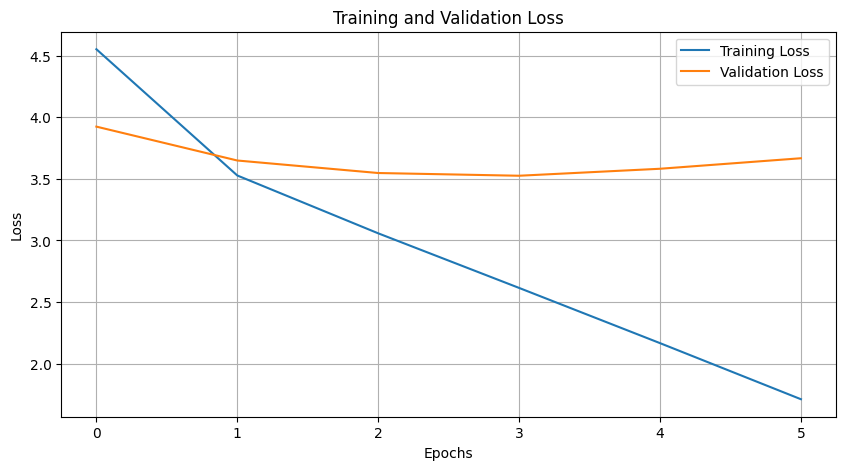

In [20]:
import matplotlib.pyplot as plt

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
train_samples = [(train_dataset.loc[i,'questions'],train_dataset.loc[i,'answers']) for i in range(len(train_dataset))]
train_samples = train_samples[:1000]

In [18]:
# Load the best model state
model.load_state_dict(torch.load('./kaggle_checkpoint/best_model_multiplicative_100k.pt'))
# model.load_state_dict(torch.load('./kaggle_checkpoint/best_model.pt'))
model.eval()

correct_train = 0
total_train = 0

with torch.no_grad():
    for (src,tgt) in train_samples:
        input_ids = bert_tokenizer.encode(f"<bos>{src}<eos>").ids
        input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')

        bos = bert_tokenizer.token_to_id('<bos>')
            
        tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
        tgt_out = bert_tokenizer.decode(tgt_out.numpy())
        # print(f'\nQuestion: {src} \nAnswer: {tgt} \nModelAnswer: {tgt_out}\n')

        tgt = tgt.lower()
        
        # Check if the predicted and actual sequences match
        if tgt_out == tgt:  # Adjust comparison logic as needed
            correct_train += 1
        total_train += 1

# Calculate accuracy
train_accuracy = correct_train / total_train
print(f'Training set accuracy of the best model: {train_accuracy:.4f}')


/tmp/ipykernel_2609876/1365615951.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./kaggle_checkpoint/best_model_multiplicative_100k.pt

Training set accuracy of the best model: 0.0180
